In [1]:
import importlib, yaml
import os, pandas as pd, numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
from sod.core import pdconcat
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)
from sklearn.metrics import roc_curve
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

print('loading source testset')
allset_test = sod_core_dataset.open_dataset('allset_test.hdf', normalize=False, verbose=False)
print('Columns')
print(allset_test.columns.tolist())

# print()
# print('Reading source train dataframe for event times')
# dfr = pd.read_hdf('/Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/allset_train.hdf',
#            columns=['Segment.db.id', 'dataset_id', 'event_time'])
# assert not pd.isna(dfr.event_time).sum()
# # little hack to have the same id column name as the test:
# dfr.rename({'Segment.db.id': 'allset_test.id'}, axis=1, inplace=True)
# print('Columns')
# print(dfr.columns.tolist())

print()
print('DONE')



loading source testset
Columns
['allset_test.id', 'dataset_id', 'psd@0.05sec', 'psd@0.1sec', 'psd@0.2sec', 'psd@0.5sec', 'psd@1sec', 'psd@2sec', 'psd@3sec', 'psd@5sec', 'psd@9sec', 'outlier', 'subclass', 'window_type', 'amplitude_ratio', 'event_id', 'station_id', 'event_time', 'channel_code', 'magnitude', 'distance_km', 'location_code']

DONE


In [2]:
# Reading (creating) predictions on the test set instances

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/eval.allset_train_test.iforest.yaml/'))
assert os.path.isdir(maindir)

names = [
    # 'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50',
    'IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=50',
]
# check we did provide different file names:
assert len(set(names)) == len(names)


print('Reading the following classifiers (clf) with relative id (id: clf name):')
for i, n in enumerate(names):
    print('[%d]: %s' % (i, n))
clfs = [load(os.path.join(maindir, 'models', name+'.model')) for name in names]
# predictions must be recalculated
print('Calculating %d predictions' % len(names))

print('Loading prediction dataframes')
maindir_preddf = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/clfeval.allset_train_test.iforest.psd@5sec.yaml/'))
assert os.path.isdir(maindir_preddf)
pred_dfs = [pd.read_hdf(os.path.join(maindir_preddf, 'predictions', name+'&testset=allset_test.hdf')) for name in names]

# print('Predicting (needs to be run because saved dataframes miss a column)')
# for clf in clfs:
#     columns = ['psd@5sec']
#     _allset_test = allset_test.dropna(subset=columns)
#     pred_dfs = [sod_core_eval.predict(clf, _allset_test, *columns) for clf in clfs]

    
classnames = sod_core_dataset.allset_test.classnames
classes = {_: sod_core_dataset.allset_test.class_selector[_] for _ in classnames}
assert len(classes) == 3

print('Setting scores with offset and normalization')
# setting stuff:
for pred_df in pred_dfs:
    pred_df['channel_code'] = pred_df['channel_code'].astype('category')
    pred_df['location_code'] = pred_df['location_code'].astype('category')
    pred_df['cha_id'] = pred_df['channel_code'].str[:2]
    pred_df['cha_id'] = pred_df['cha_id'].astype('category')
    
    # get best threhold, calcuated from validation set only (inliers + outliers, no Me unknown):
    pred_df_outl_inl_only = pred_df[classes[classnames[0]](pred_df) | classes[classnames[1]](pred_df)]
    fpr, tpr, th = roc_curve(pred_df_outl_inl_only.outlier, pred_df_outl_inl_only.predicted_anomaly_score)
    argmax = np.argmax((1-fpr[1:])*tpr[1:])
    best_th = th[1:][argmax]
    
    scores = np.copy(pred_df.predicted_anomaly_score.values)
    
    # offset: ====================
    scores += 0.5 - best_th
    # ============================
    pred_df['score_samples_offset_only'] = np.copy(scores)
    
    # adjust: ====================
    _max = np.nanmax(scores)
    scores = 0.5 + 0.5*((scores -0.5) / (_max - 0.5))
    # ============================
    pred_df['score_samples'] = scores

print('Prediction dataframe columns:')
print(pred_df.columns.tolist())
print('DONE')

Reading the following classifiers (clf) with relative id (id: clf name):
[0]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=200
[1]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200
[2]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200
[3]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100
[4]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100
[5]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100
[6]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50
[7]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50
[8]: IsolationForest?features=psd@5sec&behaviour=new&contamination=auto&max_samples=

Getting station networks and stations


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Creating plots and saving to "/Users/riccardo/work/gfz/projects/sources/python/sod/sod/jupyter/plot.misclassified.csv"


121 channels to check (one plot per channel, each blue point is one event's score):

Channel: SJ.BEO..BH? dataset_id: 2 (name: me) Num.segments: 2984 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


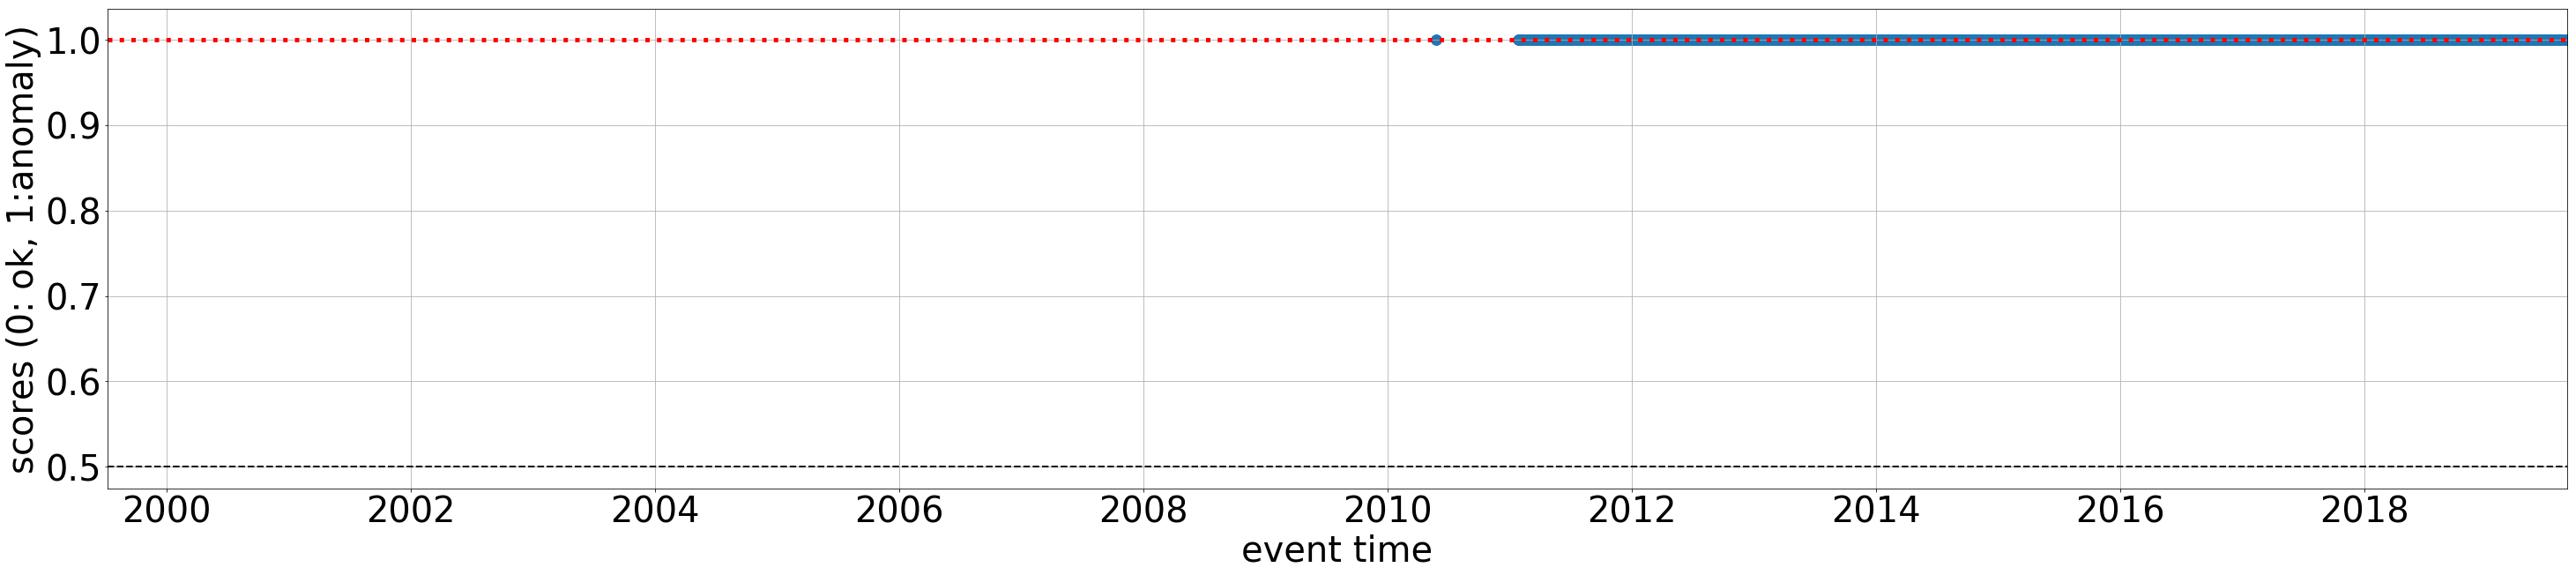

Channel: SJ.DJES..BH? dataset_id: 2 (name: me) Num.segments: 2493 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


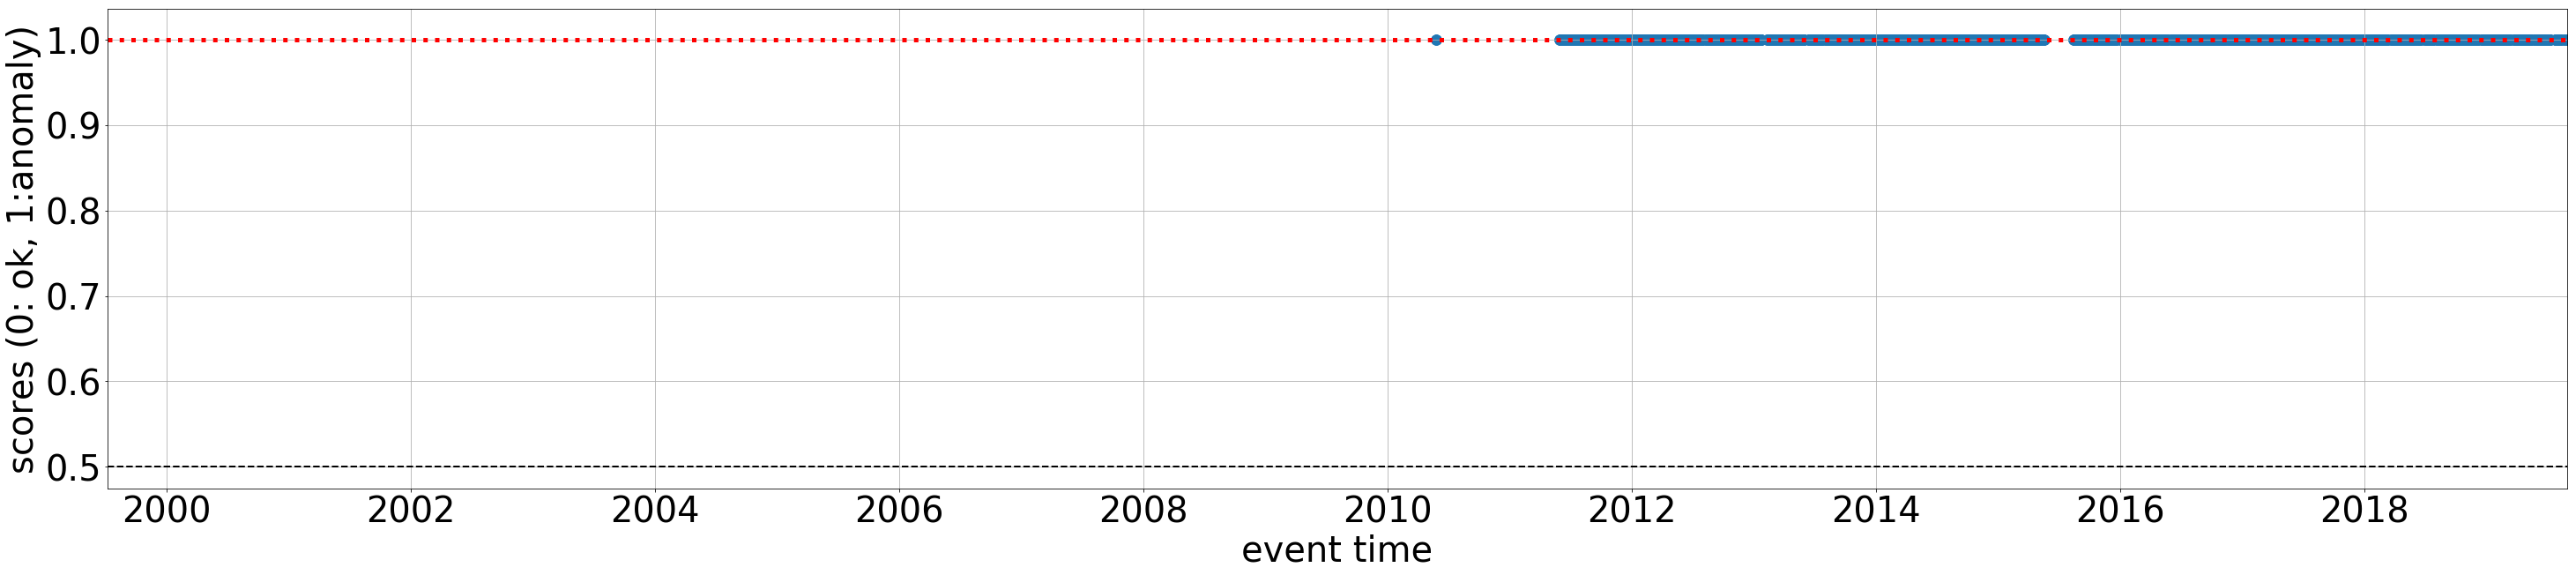

Channel: SL.BOJS..BH? dataset_id: 2 (name: me) Num.segments: 55 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


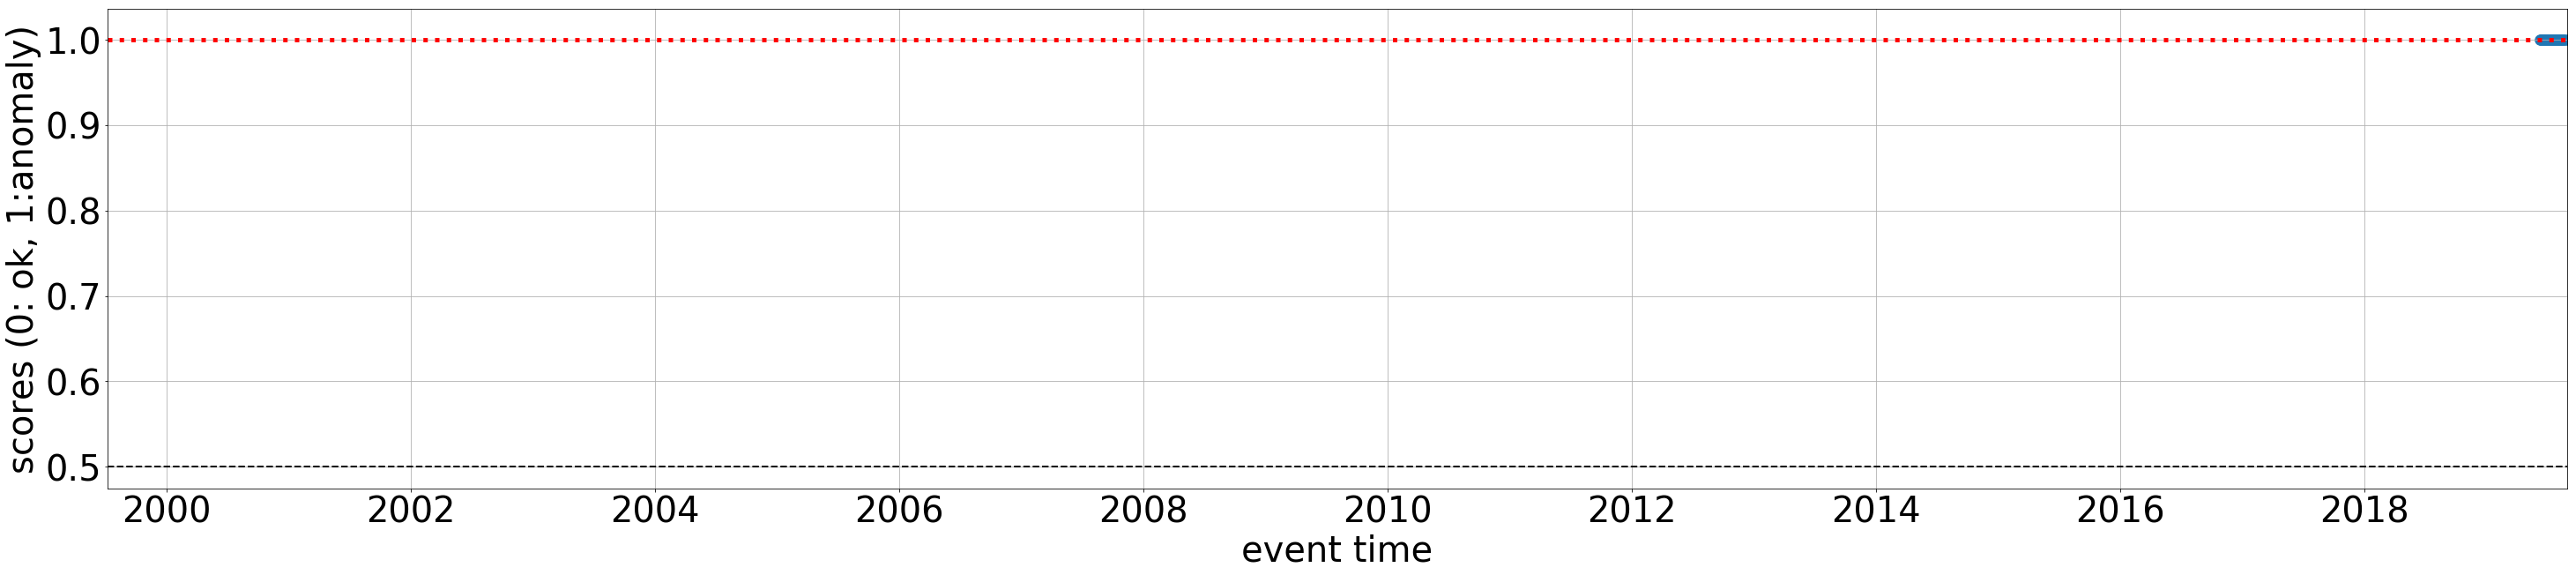

Channel: SL.MOZS..BH? dataset_id: 2 (name: me) Num.segments: 66 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


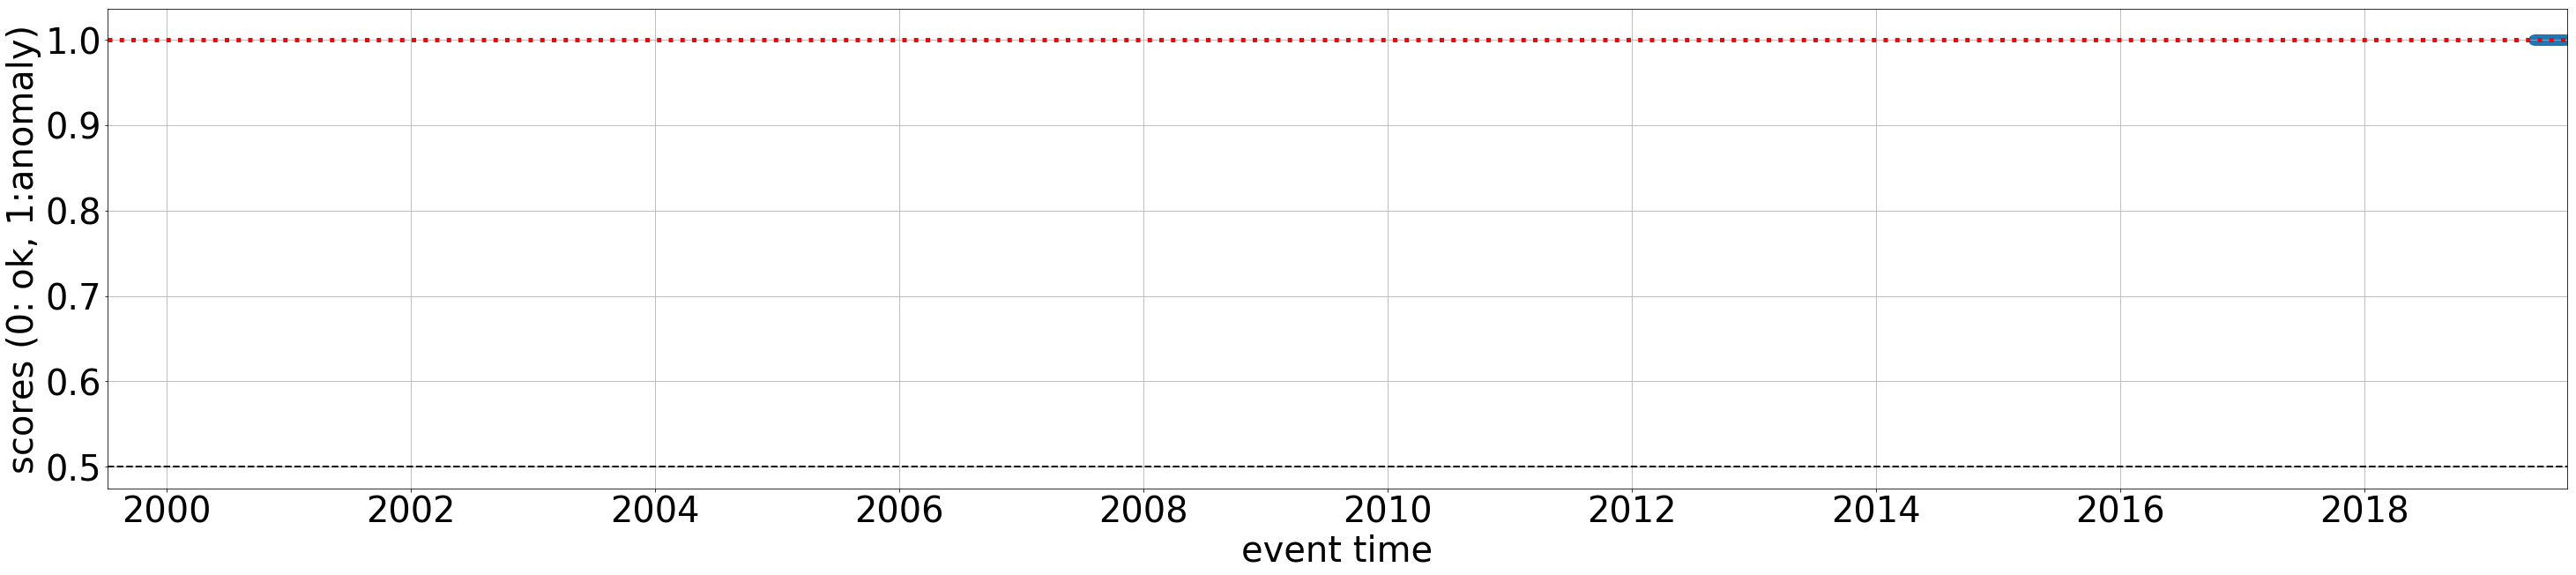

Channel: SL.PDKS..BH? dataset_id: 2 (name: me) Num.segments: 436 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


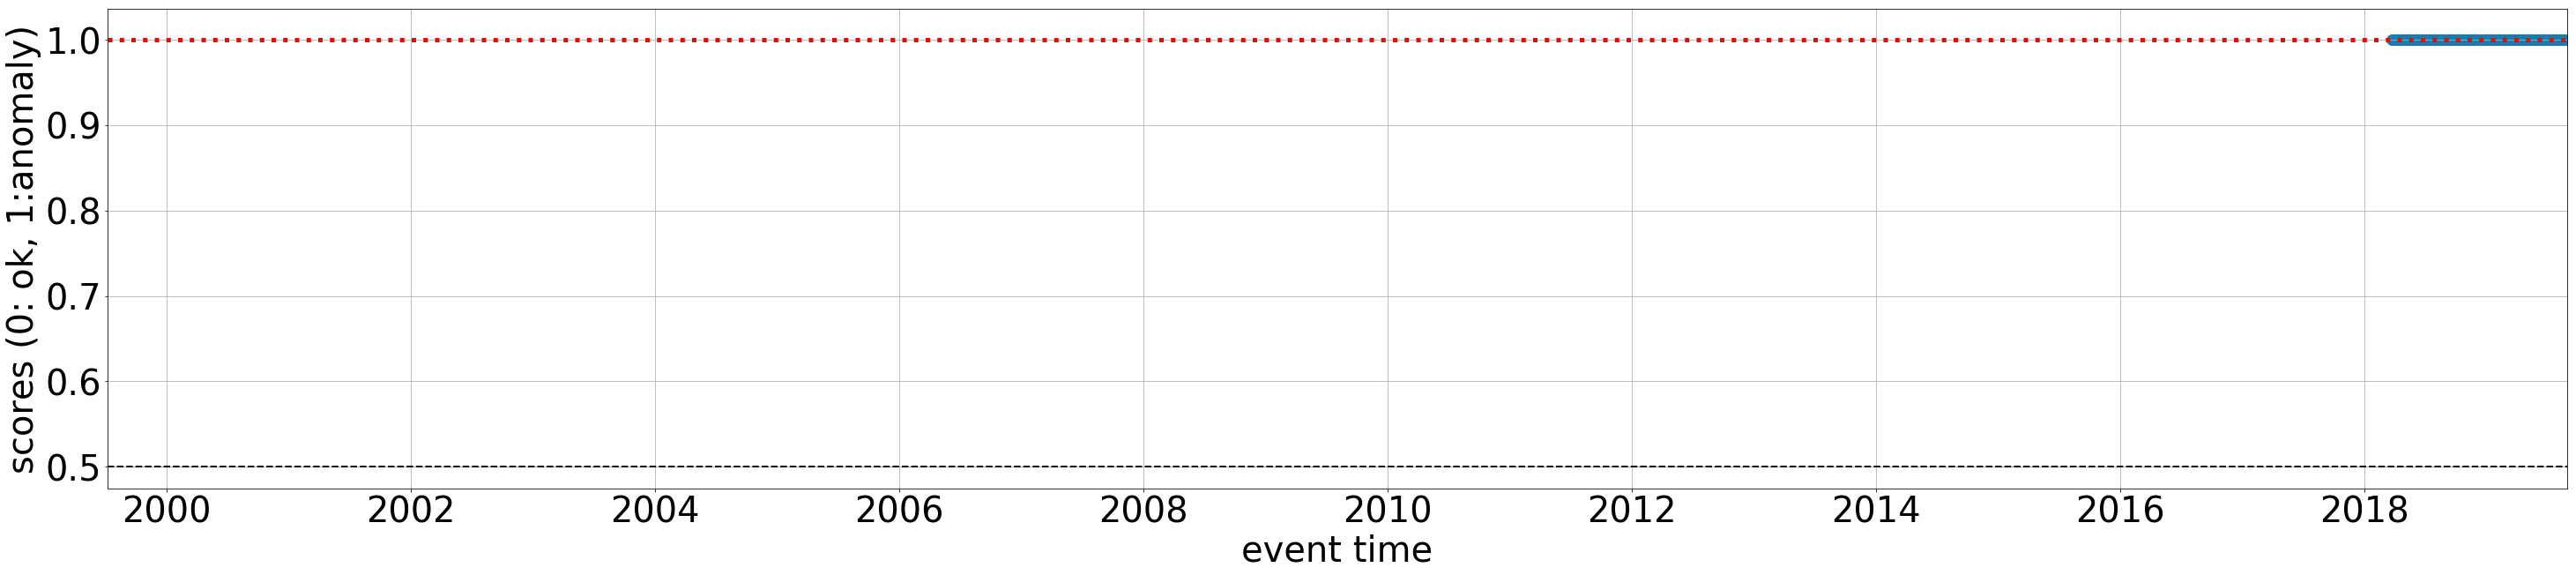

Channel: SL.VNDS..BH? dataset_id: 2 (name: me) Num.segments: 147 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


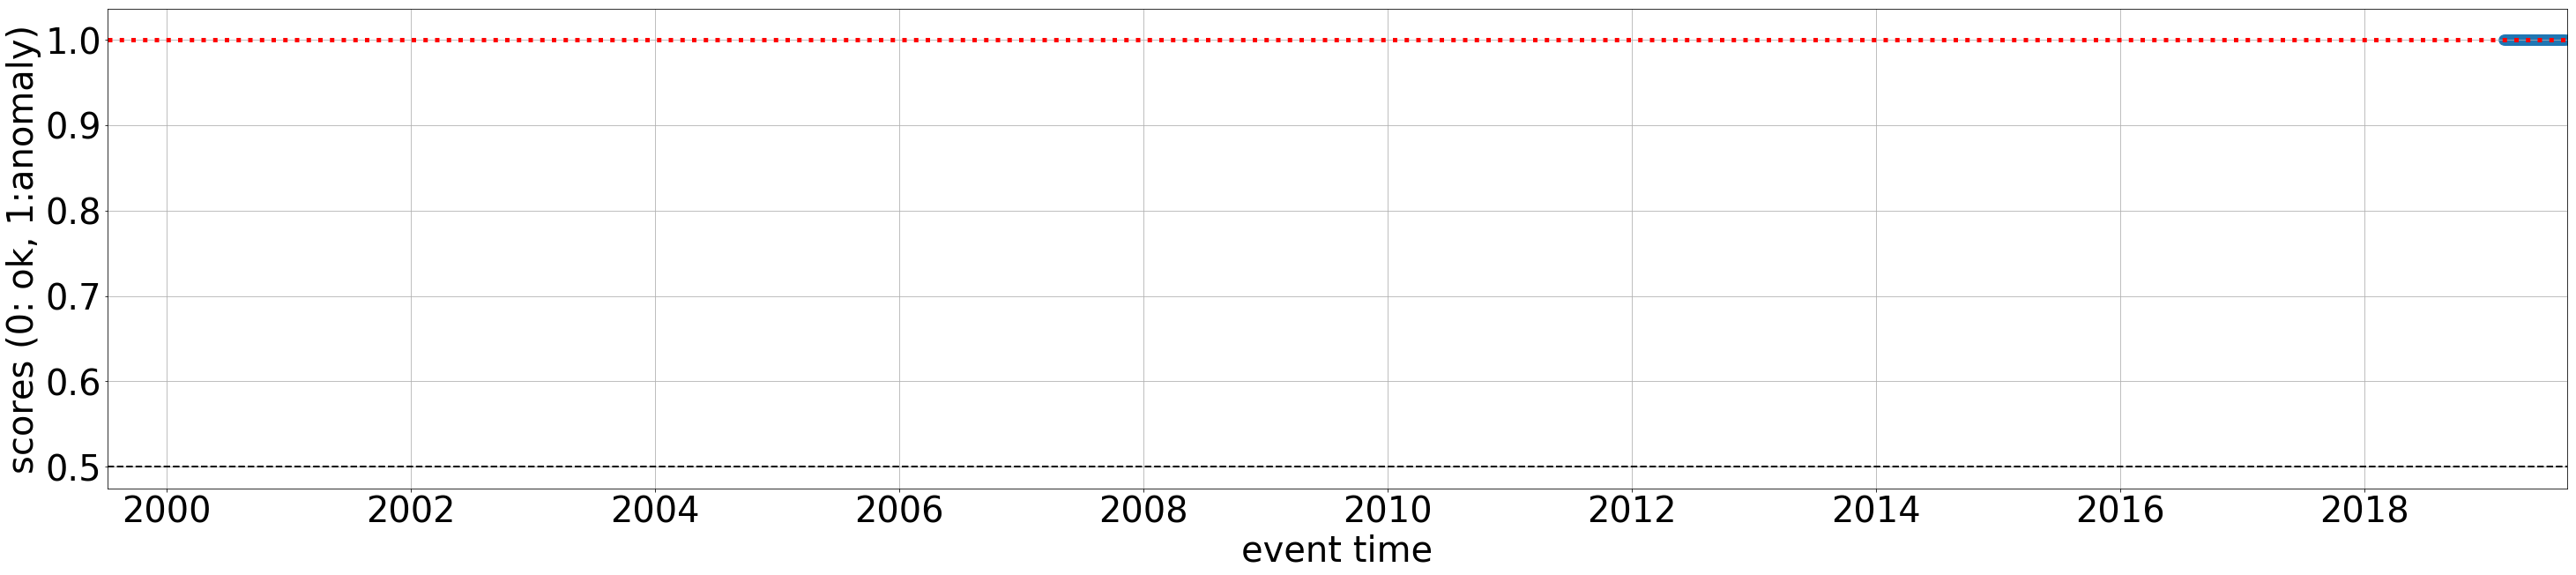

Channel: SL.ZAVS..BH? dataset_id: 2 (name: me) Num.segments: 111 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  1.000[0] 1.000[1] 1.000[2] 1.000[3] 1.000[4] 0.982[5] 1.000[6] 0.999[7] 0.986[8]


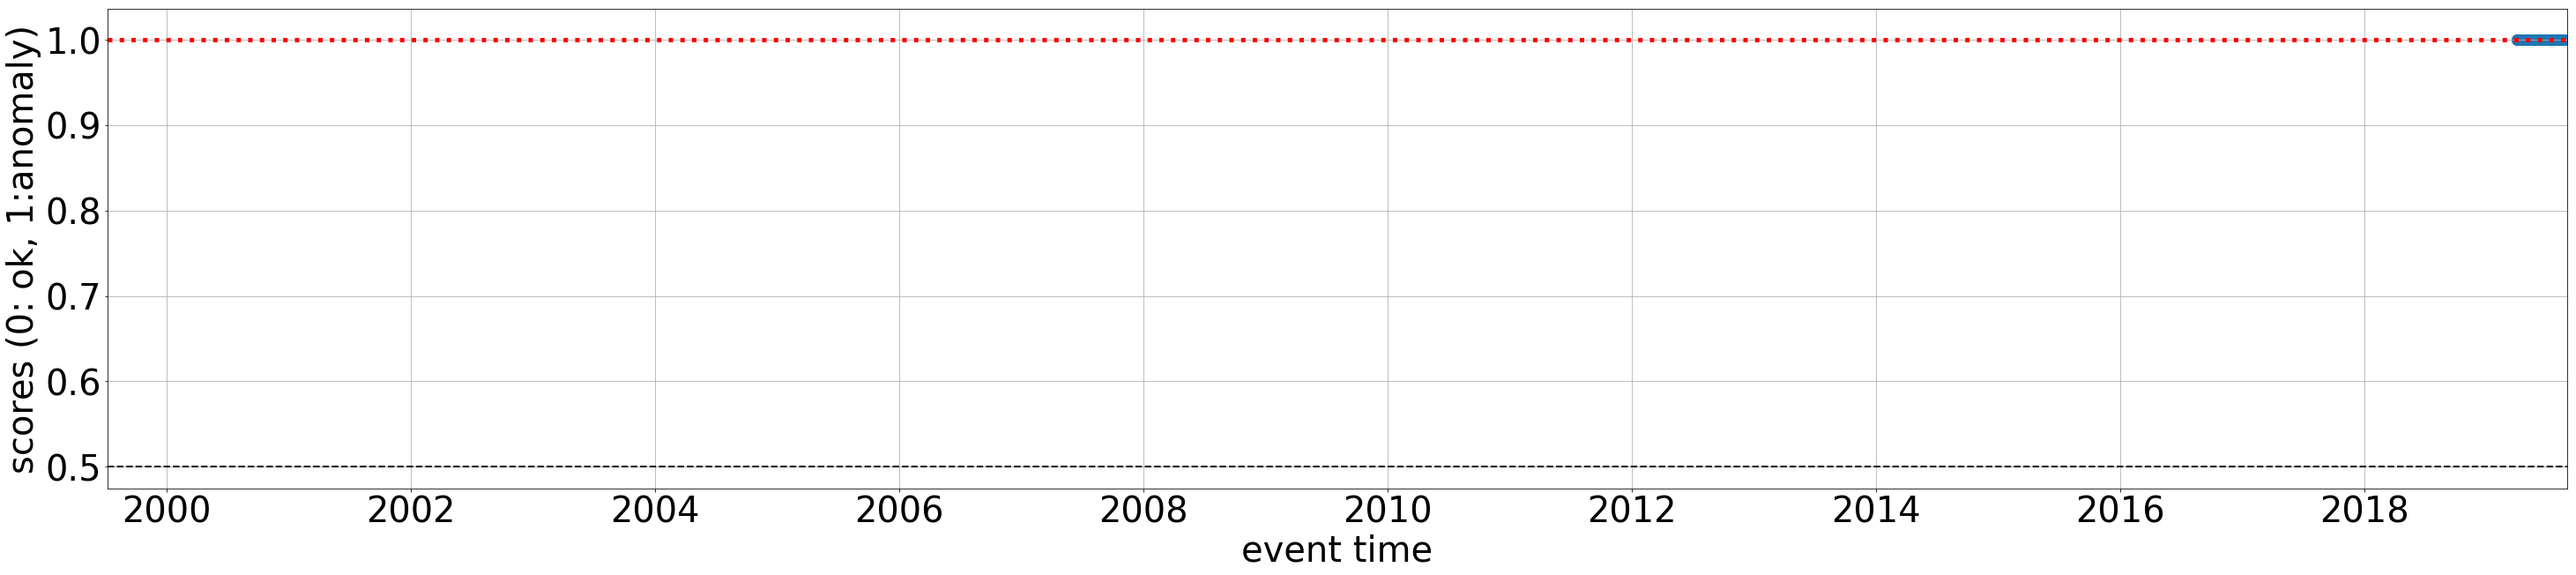

Channel: CZ.CHVC..BH? dataset_id: 2 (name: me) Num.segments: 1096 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


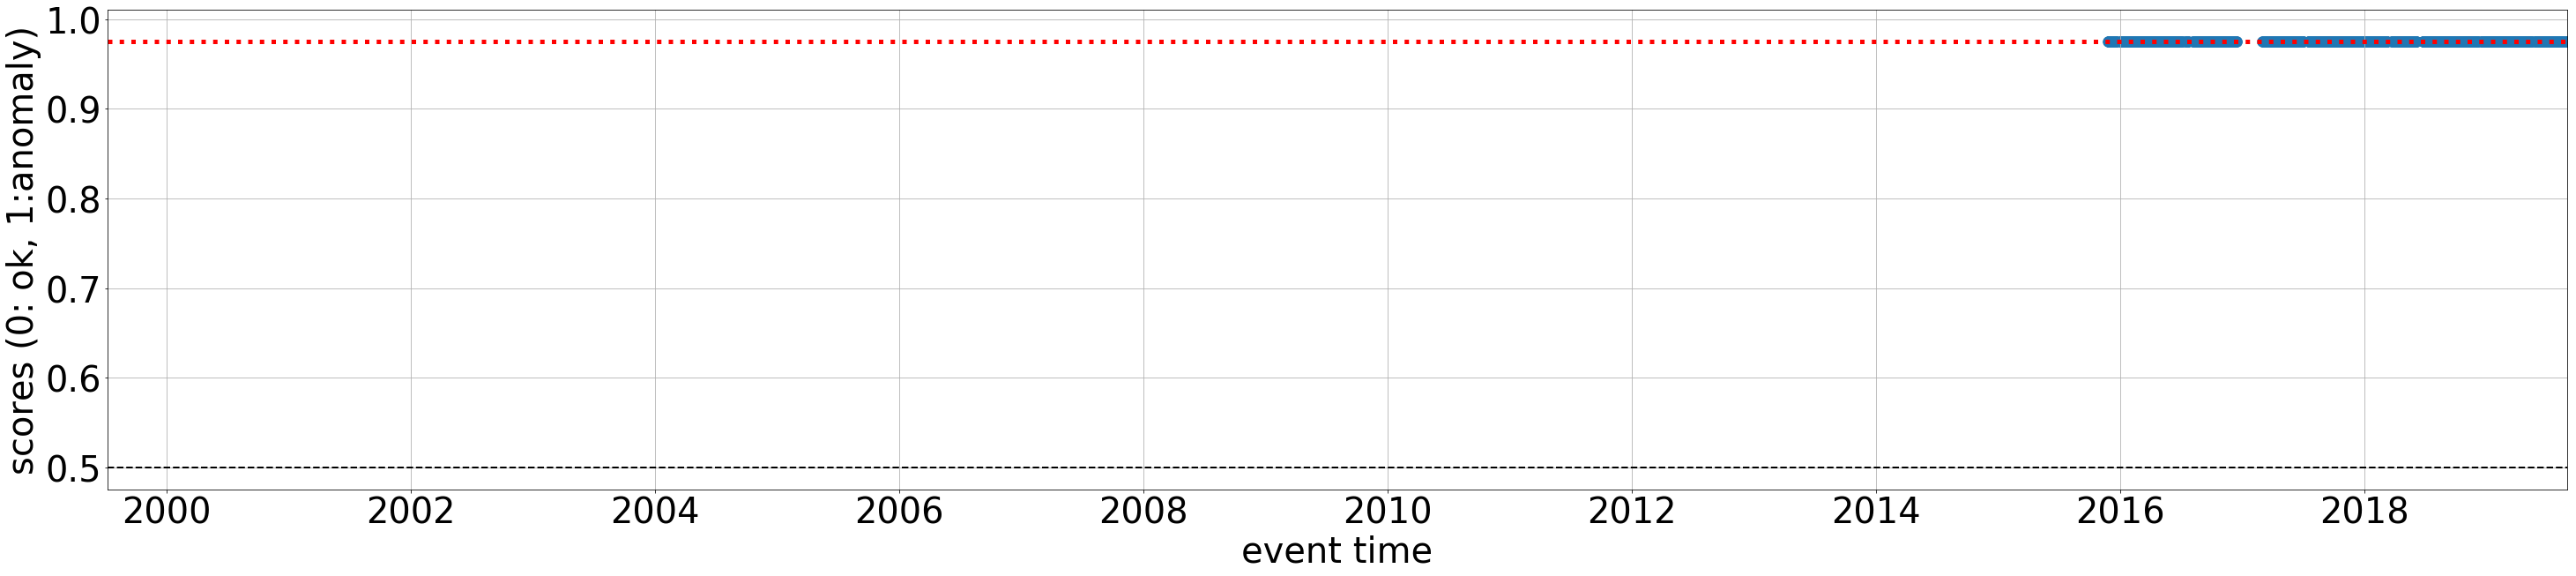

Channel: CZ.CKRC..BH? dataset_id: 2 (name: me) Num.segments: 1128 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


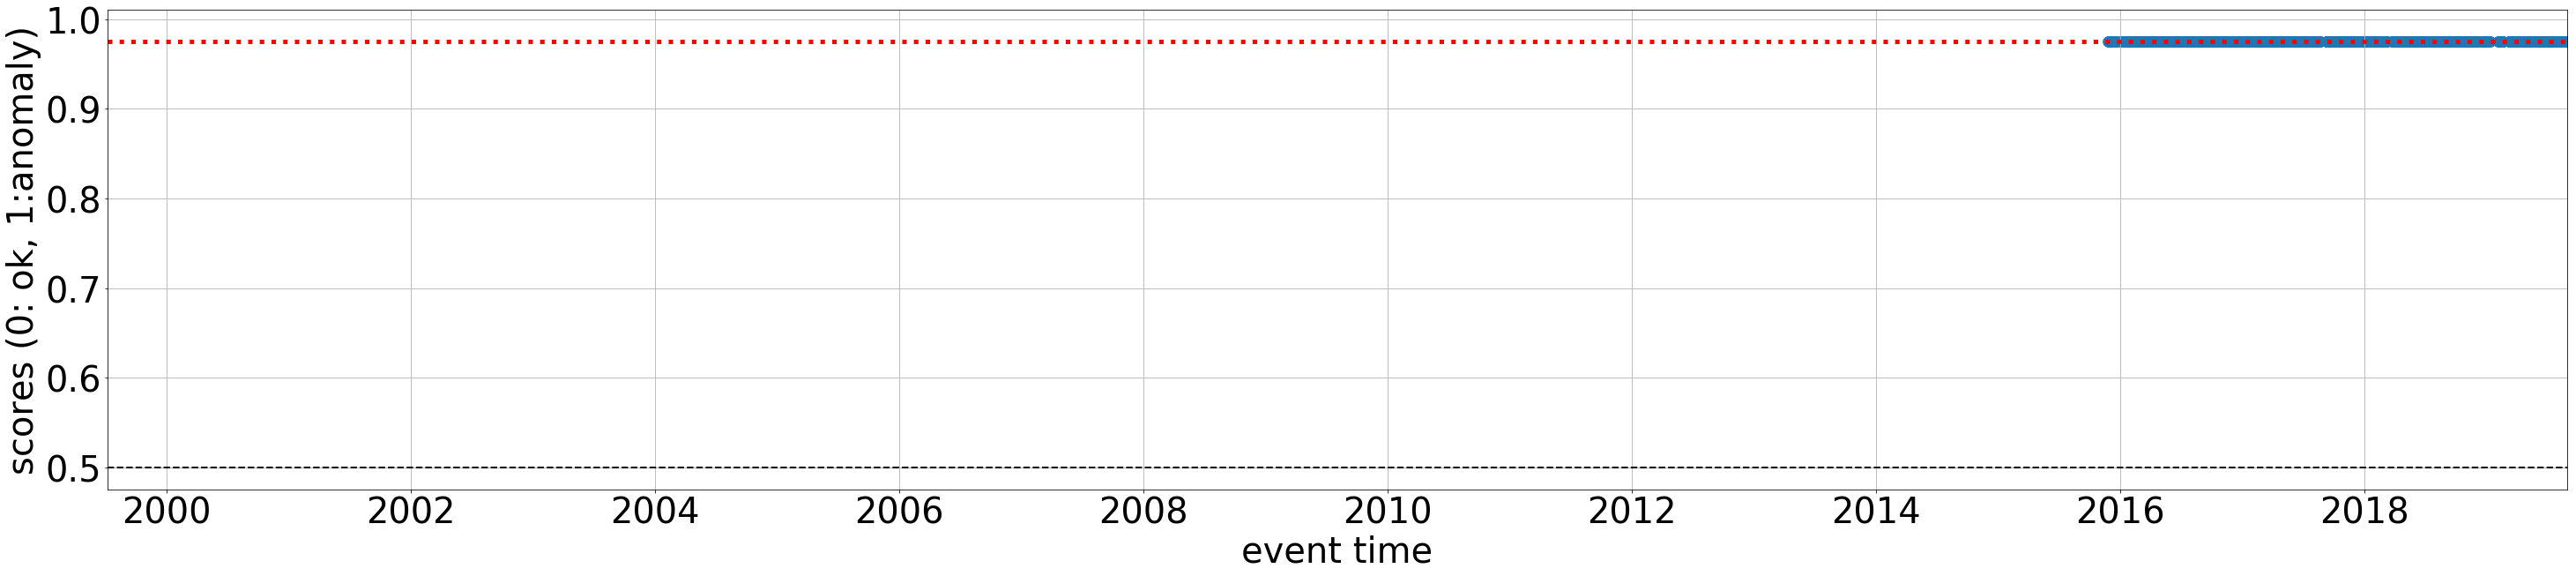

Channel: CZ.DPC..BH? dataset_id: 2 (name: me) Num.segments: 3338 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


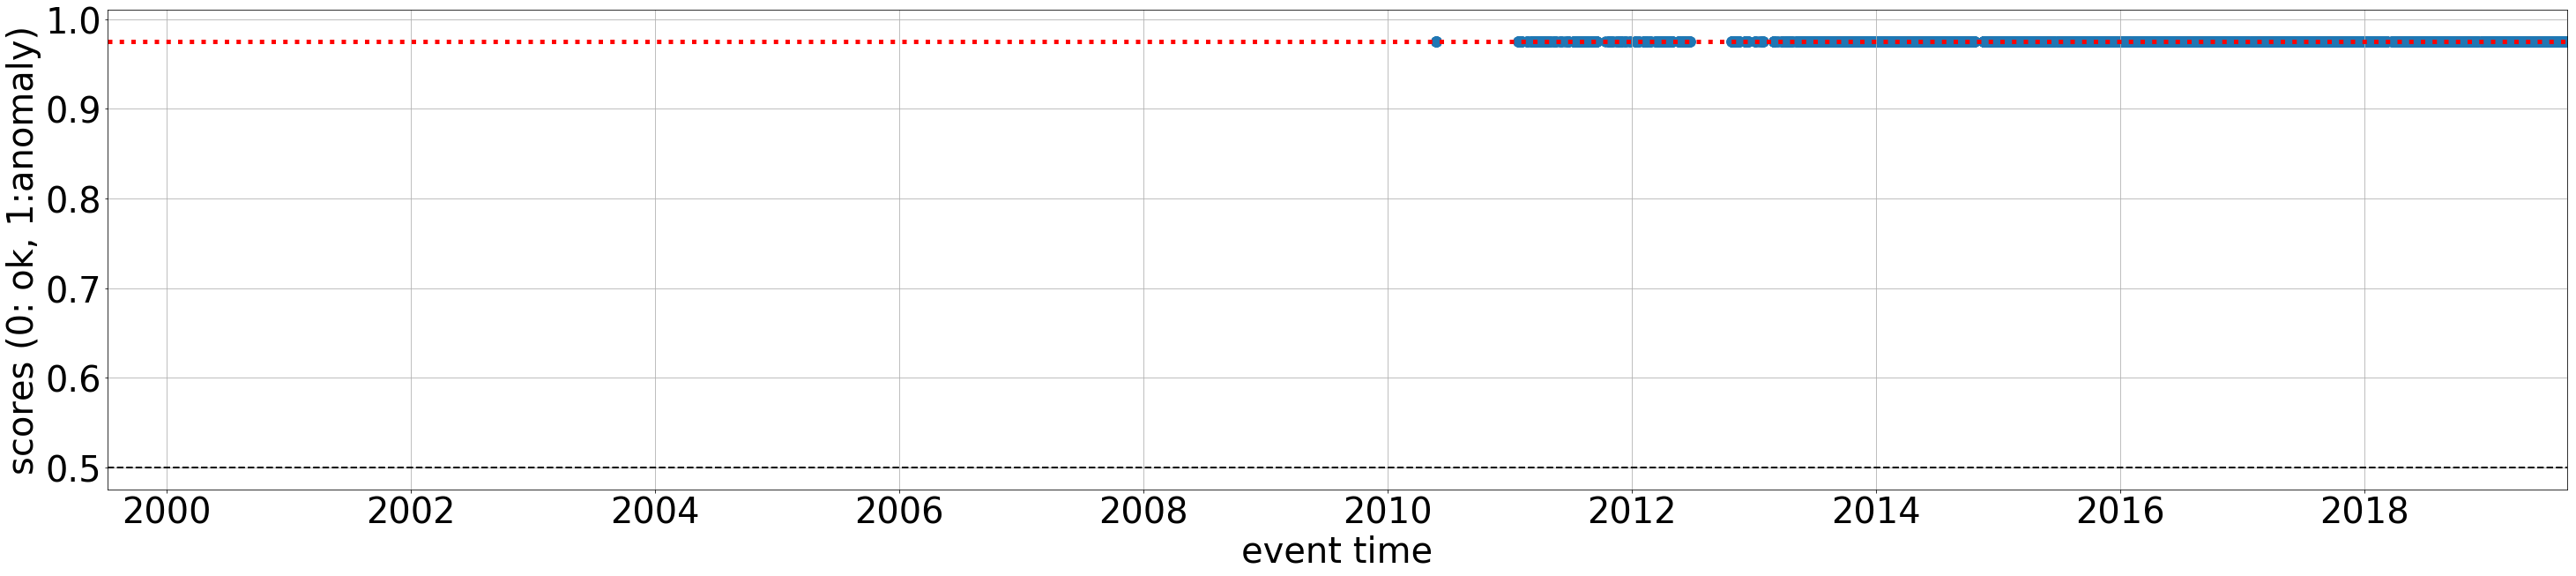

Channel: CZ.GOPC..BH? dataset_id: 2 (name: me) Num.segments: 1143 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


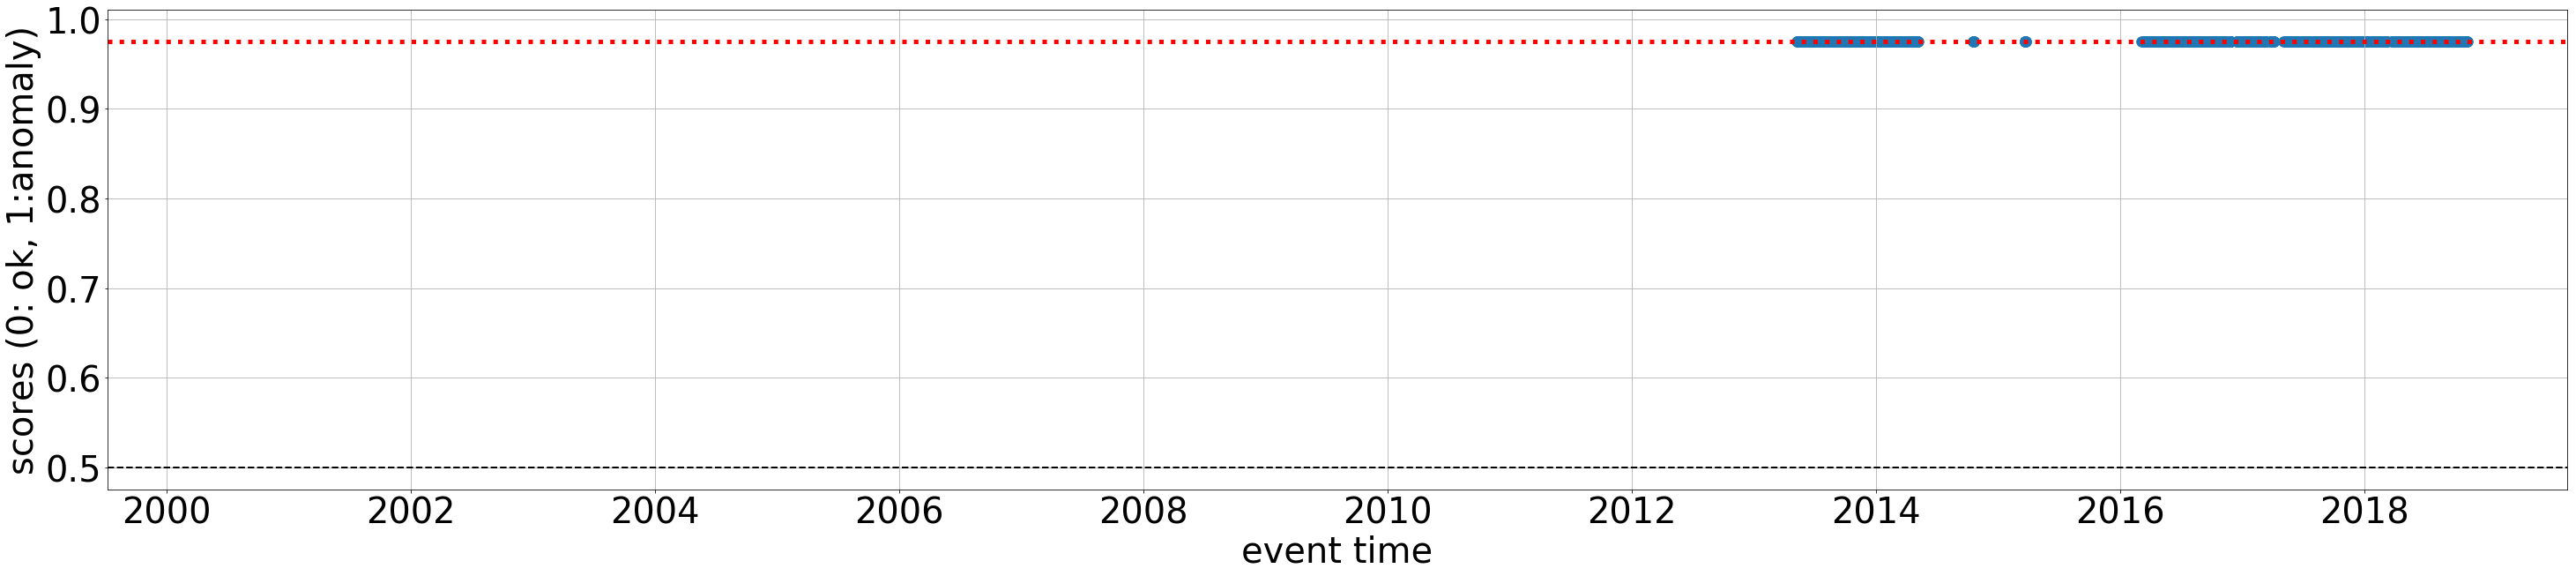

Channel: CZ.HSKC..BH? dataset_id: 2 (name: me) Num.segments: 896 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


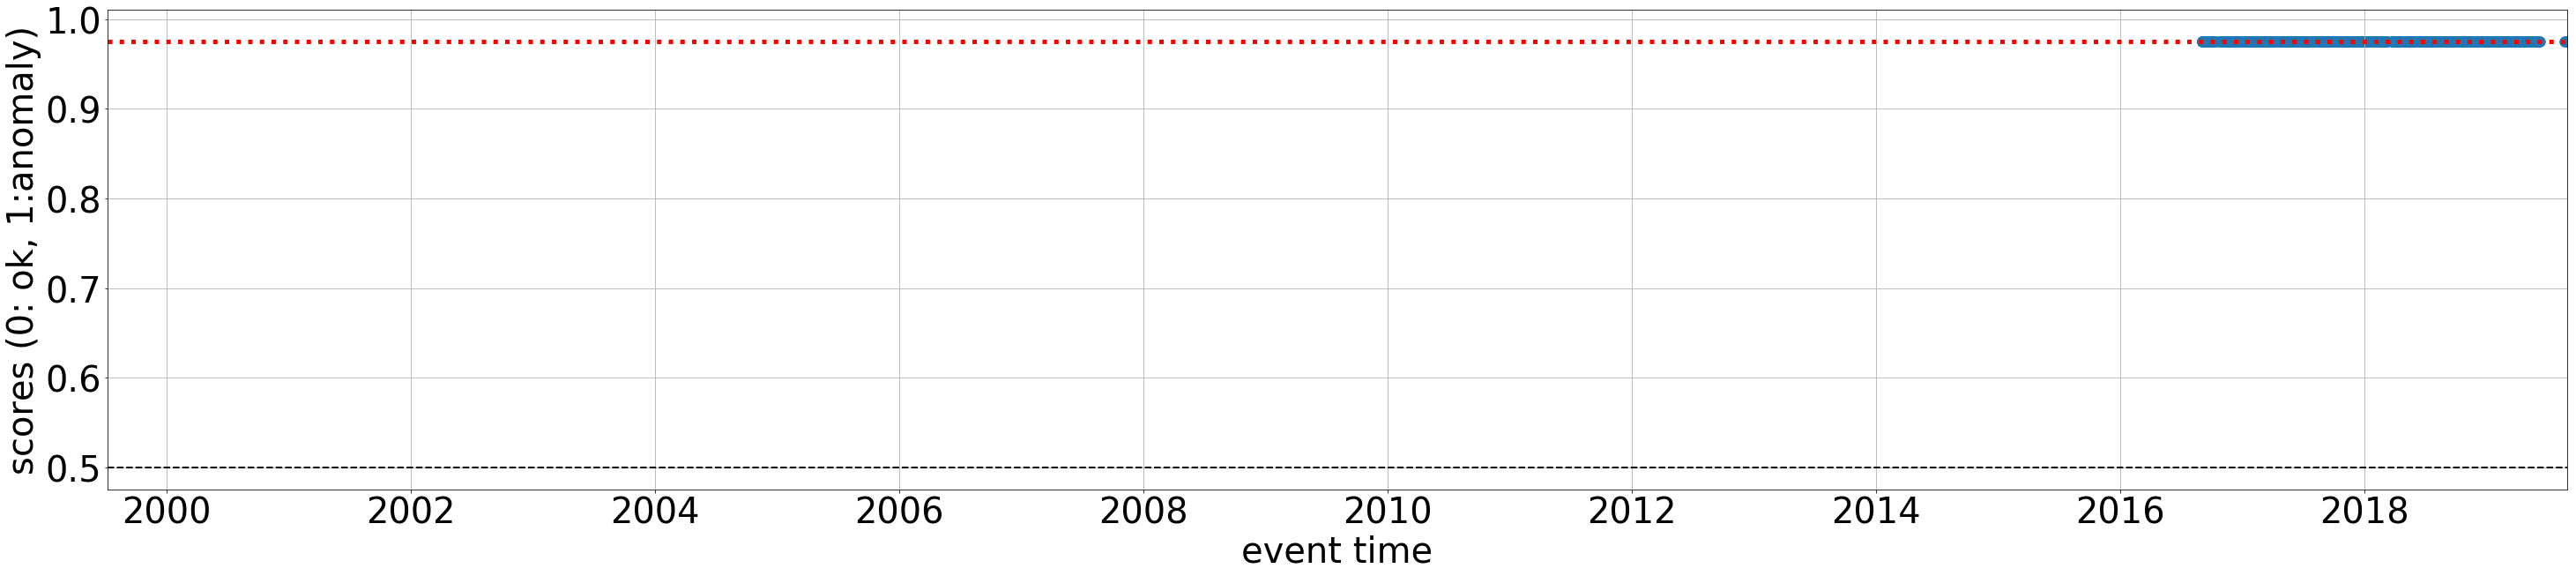

Channel: CZ.KRLC..BH? dataset_id: 2 (name: me) Num.segments: 1880 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


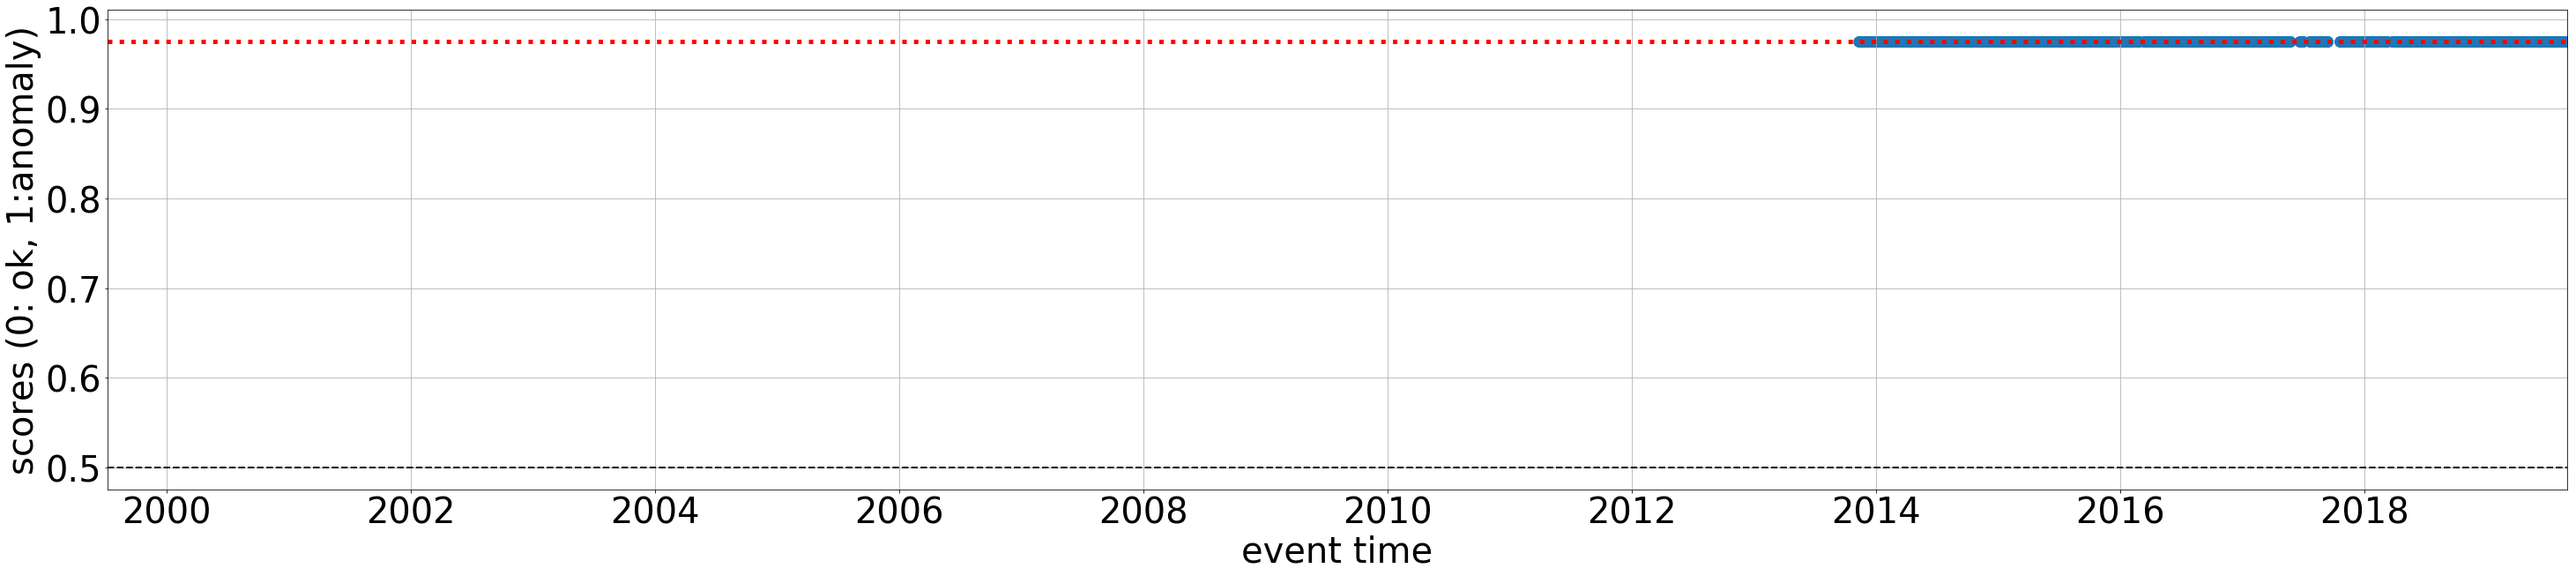

Channel: CZ.OSTC..BH? dataset_id: 2 (name: me) Num.segments: 1257 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


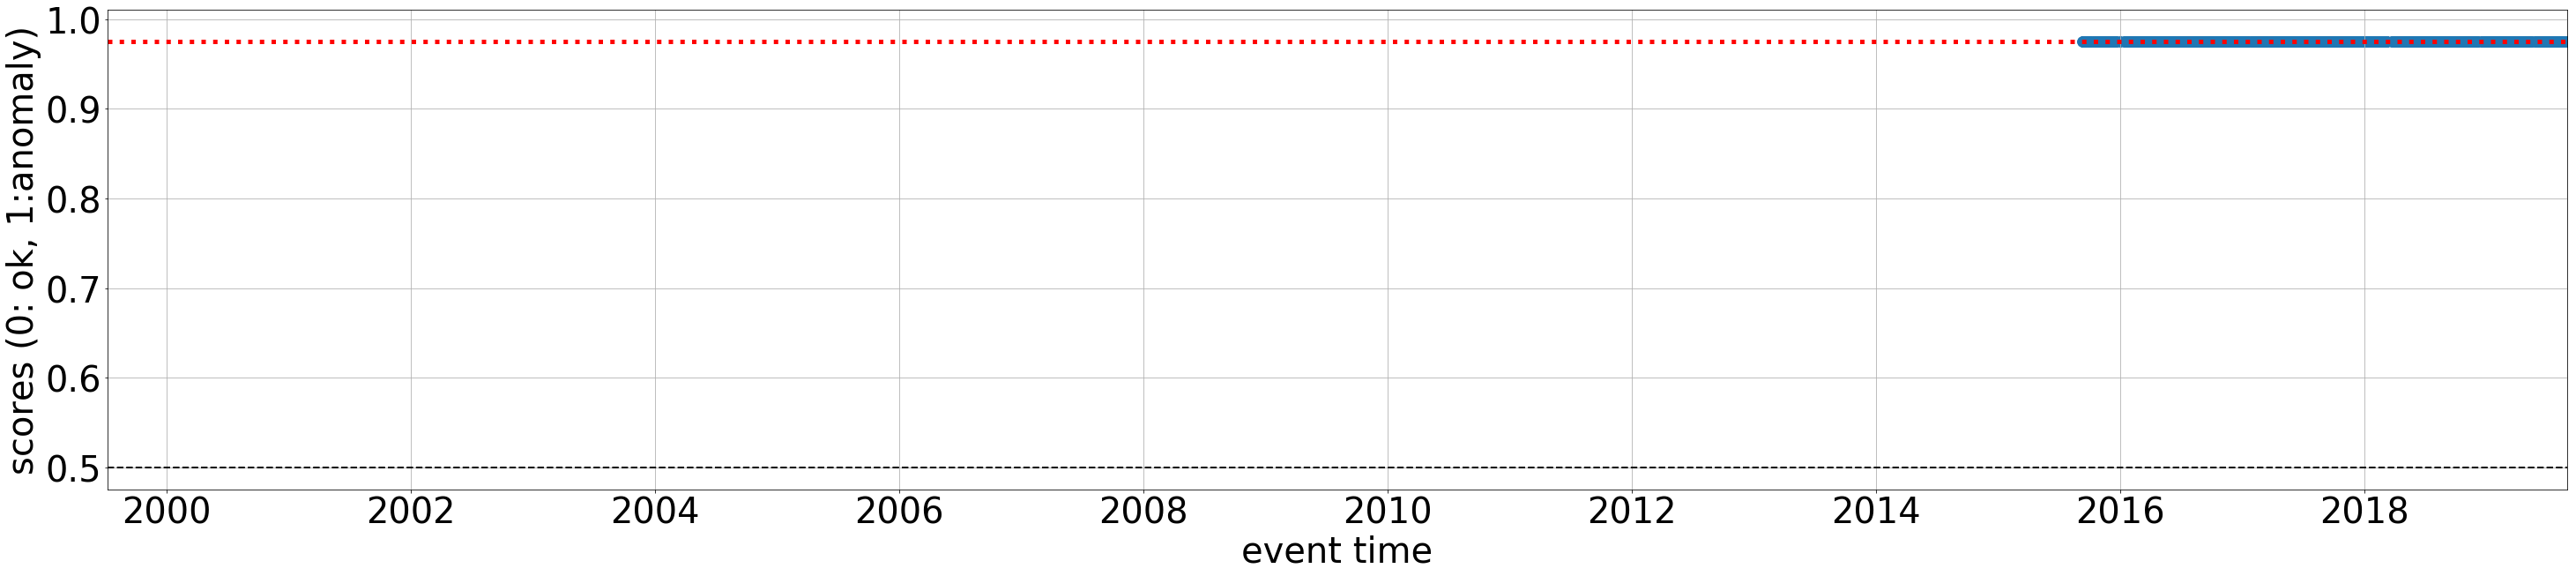

Channel: CZ.PBCC..BH? dataset_id: 2 (name: me) Num.segments: 34 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


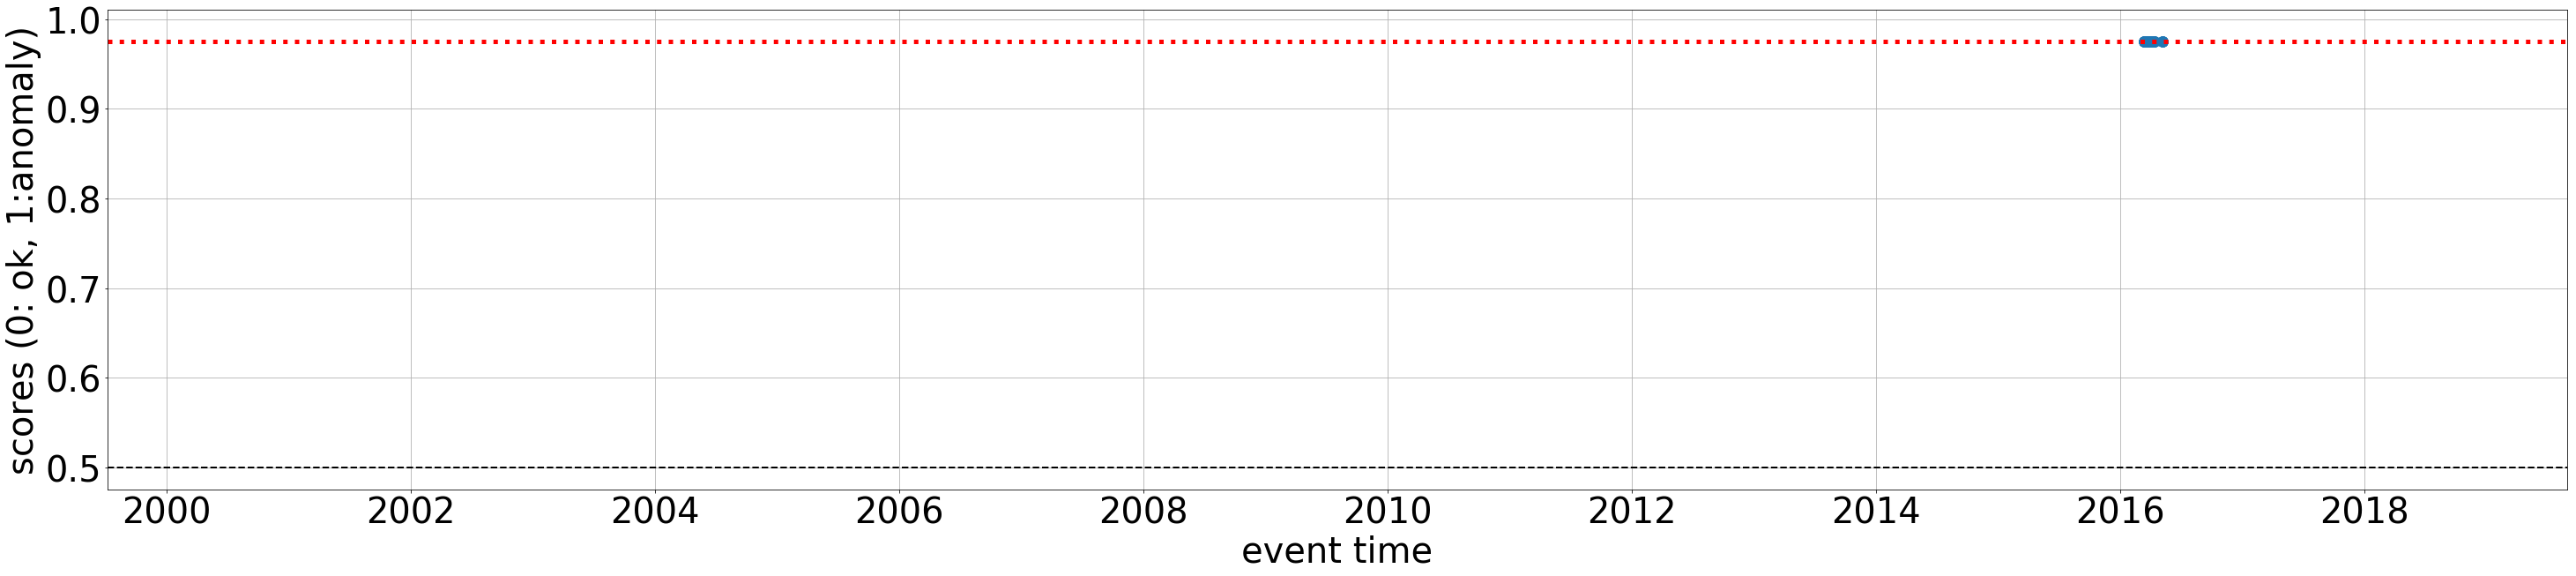

Channel: CZ.PRA..BH? dataset_id: 2 (name: me) Num.segments: 1461 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


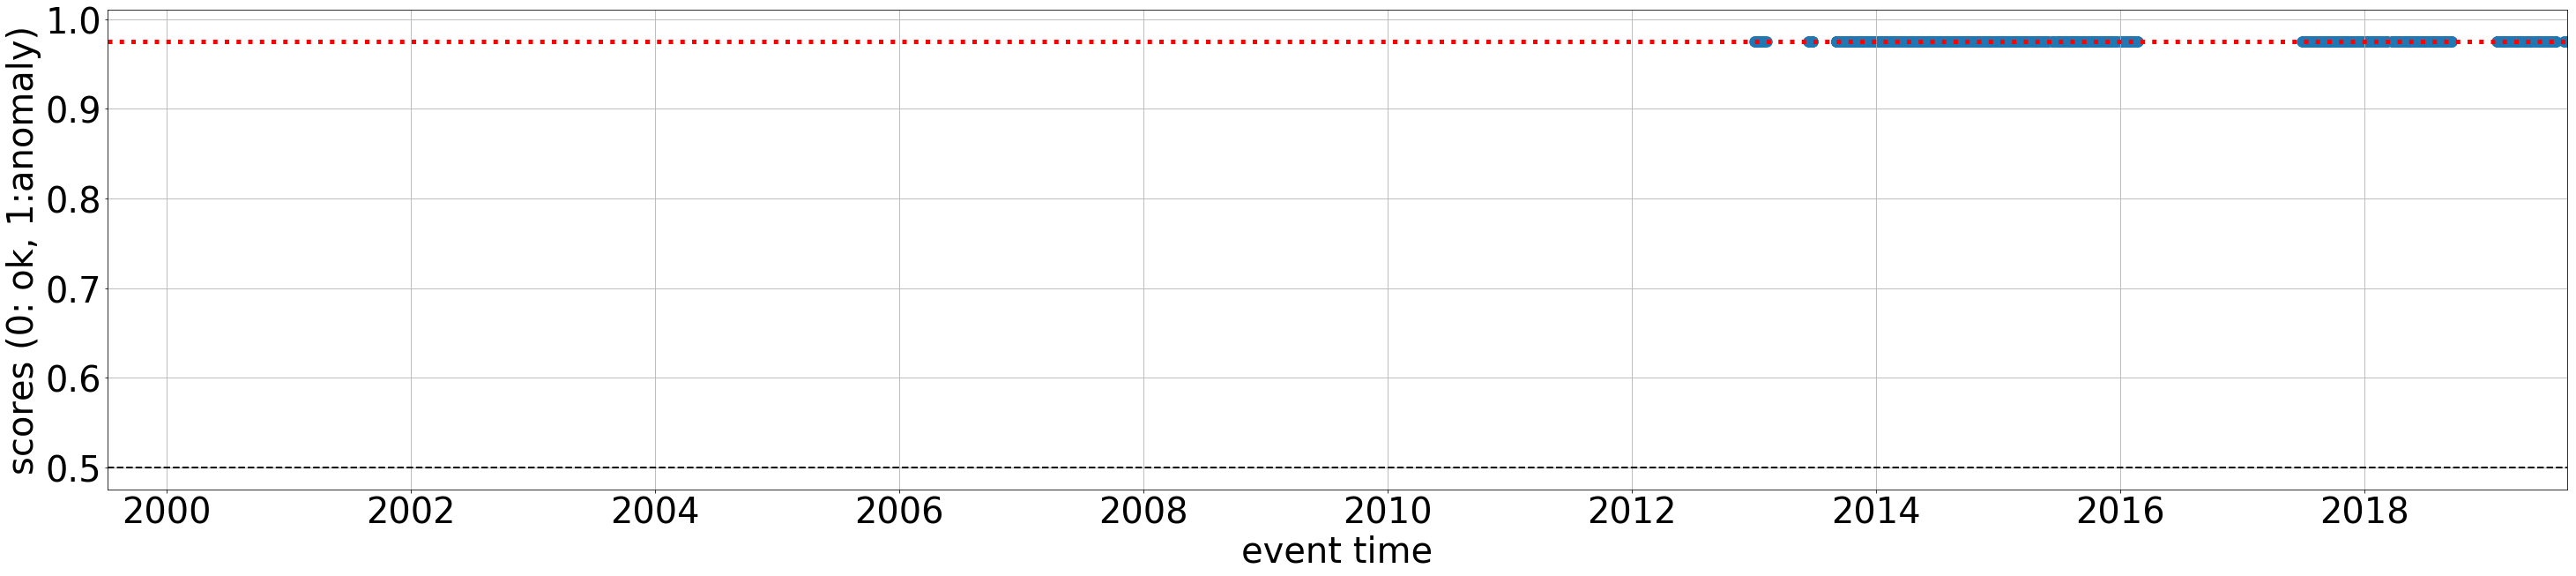

Channel: CZ.UPC..BH? dataset_id: 2 (name: me) Num.segments: 2126 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


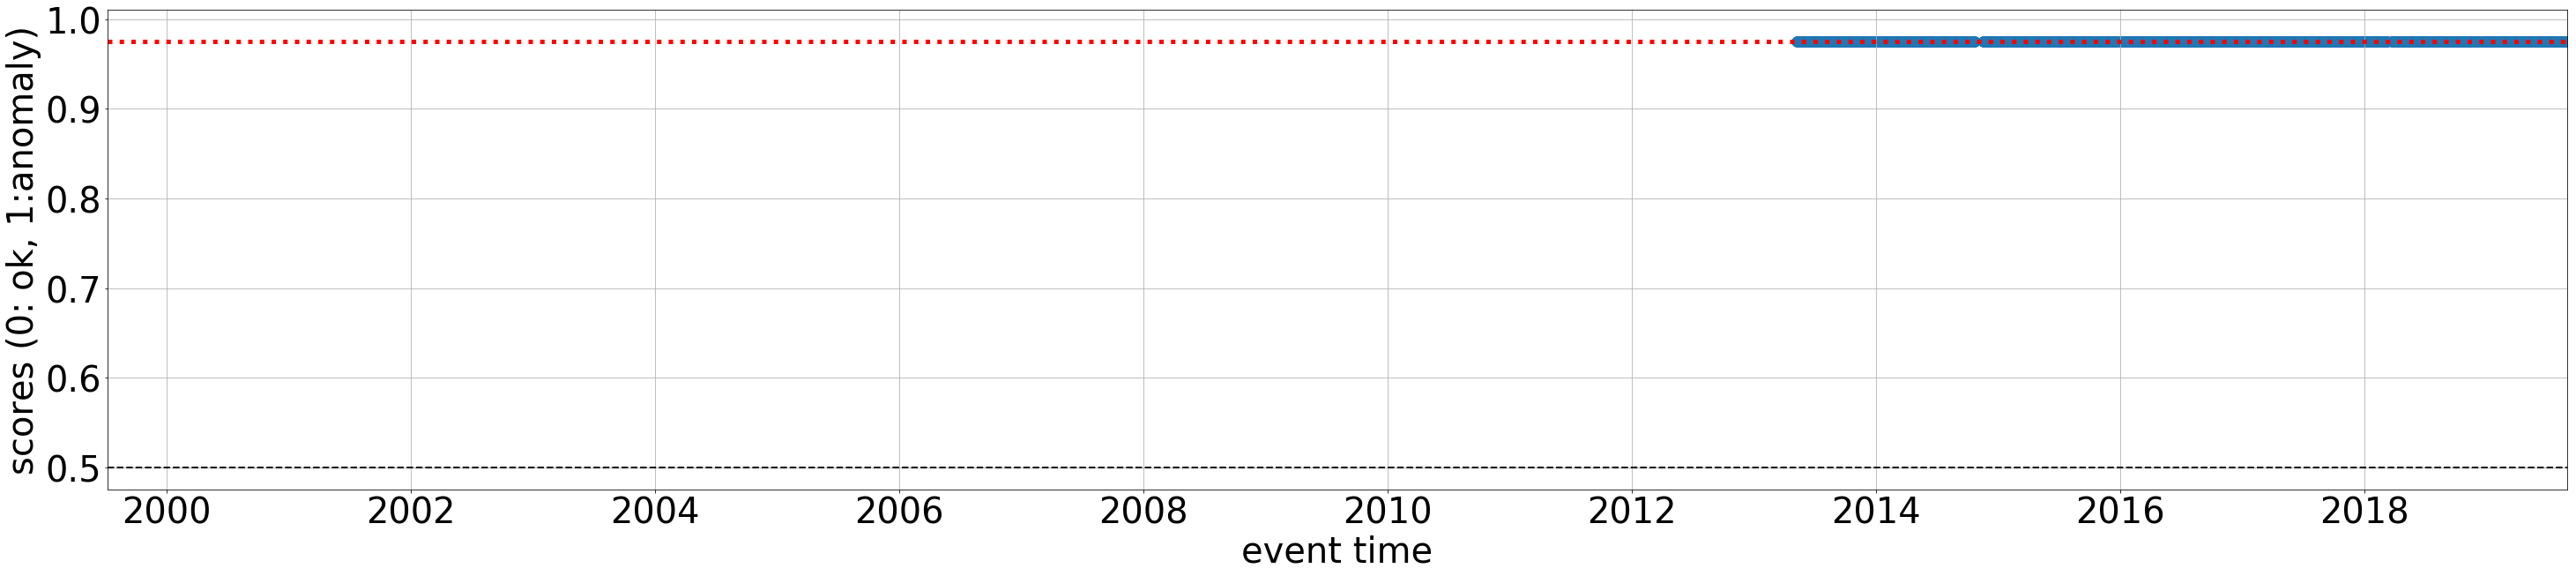

Channel: AF.ANKE..BH? dataset_id: 2 (name: me) Num.segments: 427 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


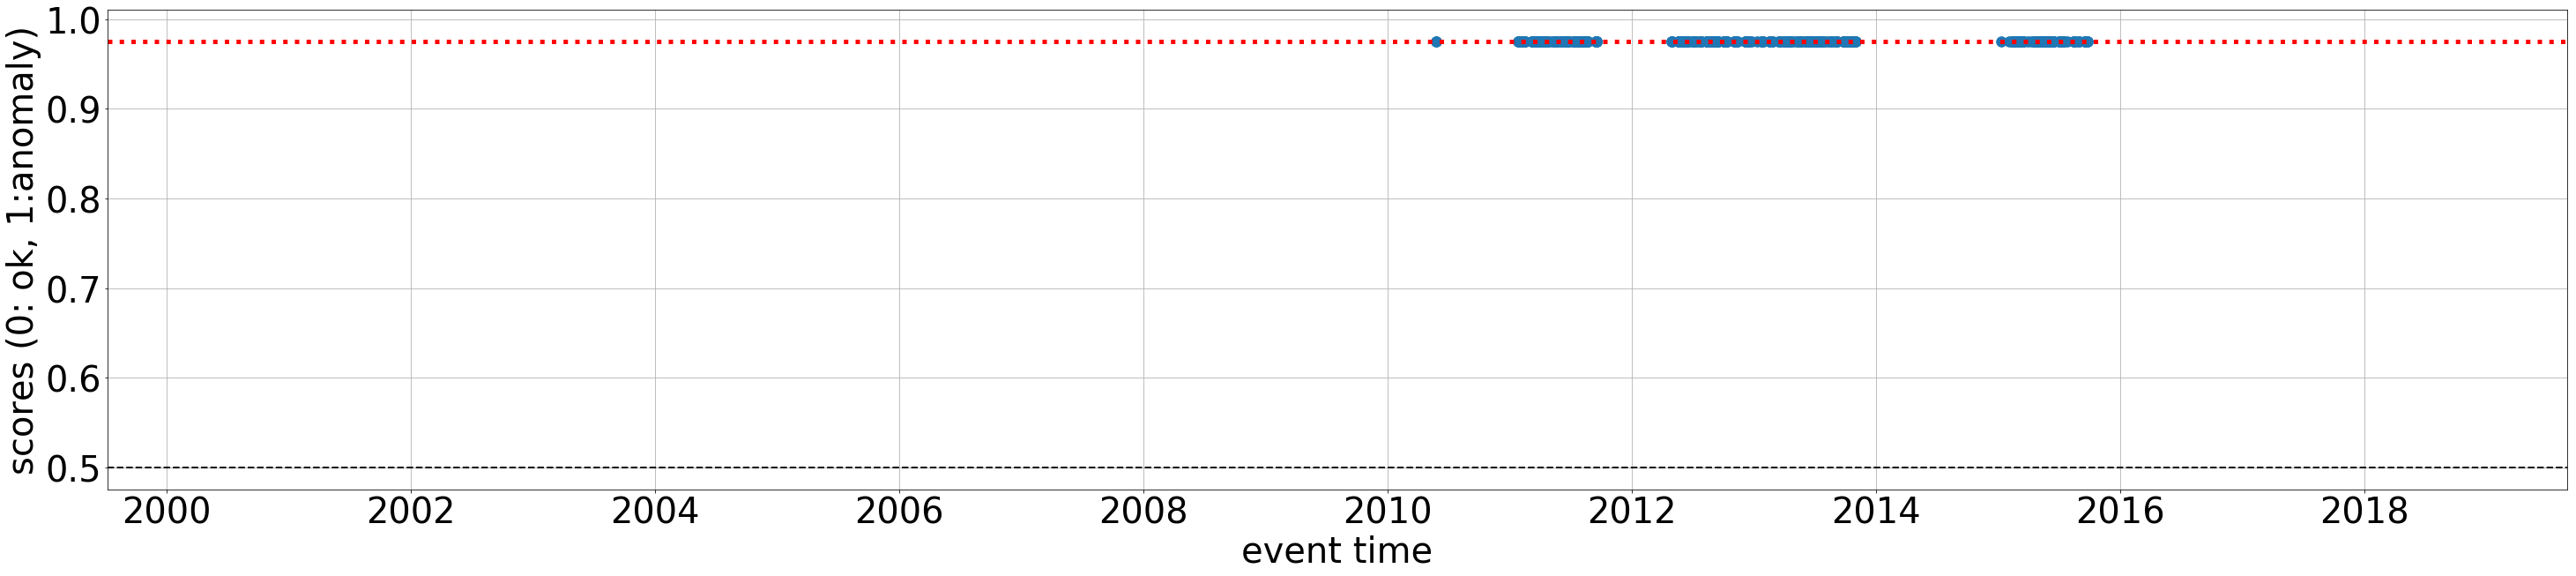

Channel: AF.DODT..BH? dataset_id: 2 (name: me) Num.segments: 335 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


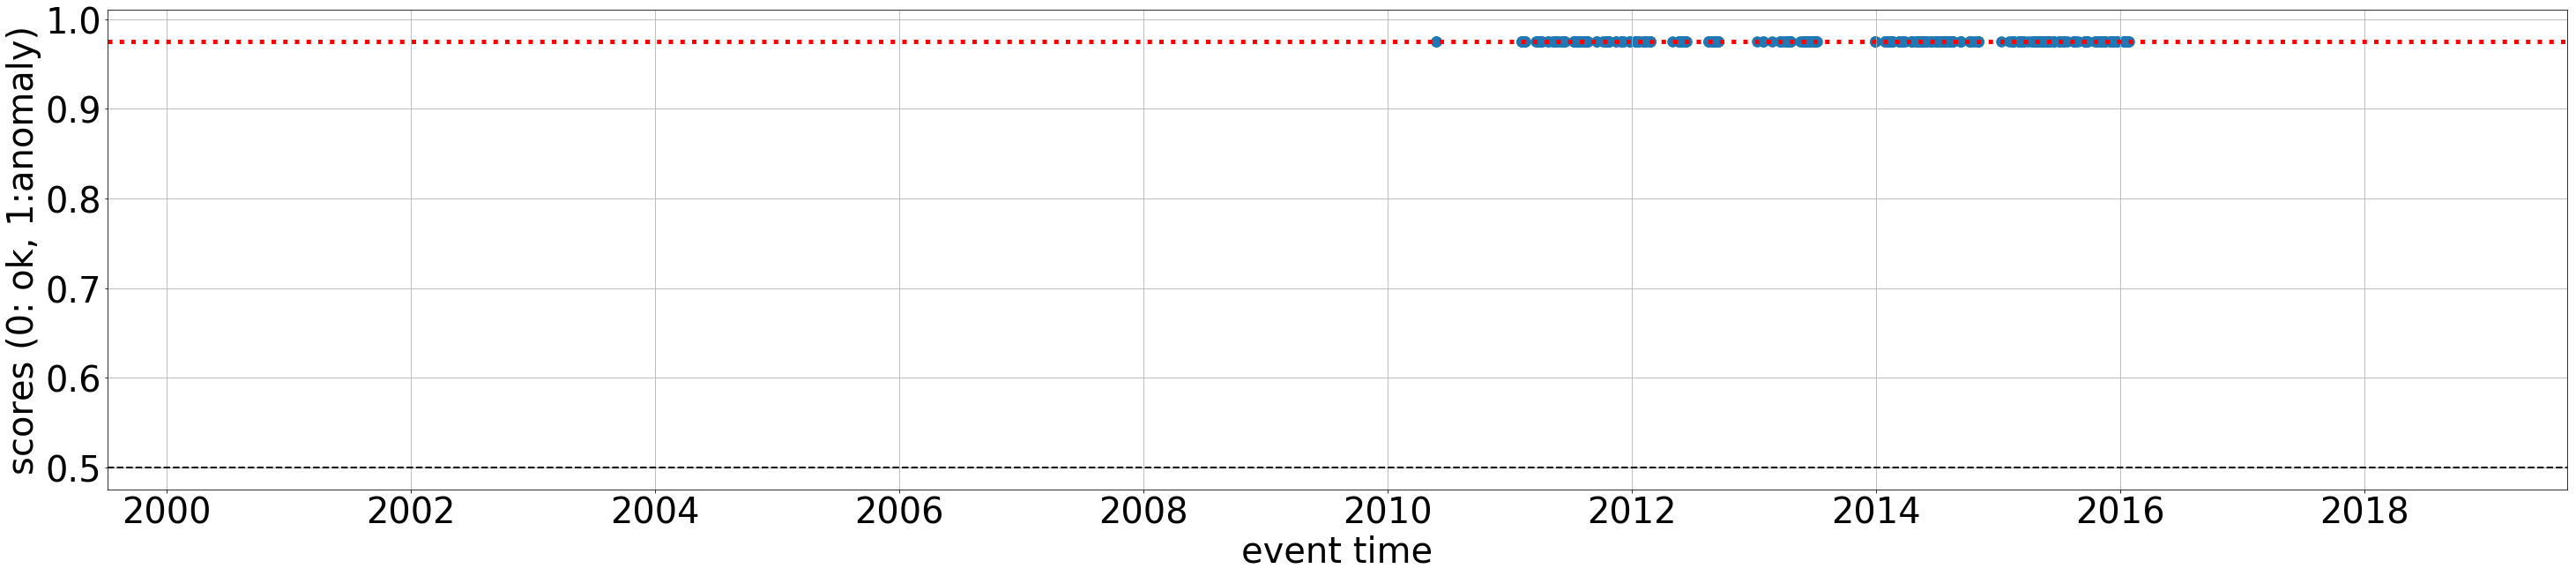

Channel: AF.EKNA..BH? dataset_id: 2 (name: me) Num.segments: 369 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.976[1] 0.983[2] 0.977[3] 0.984[4] 0.988[5] 0.996[6] 0.963[7] 0.986[8]


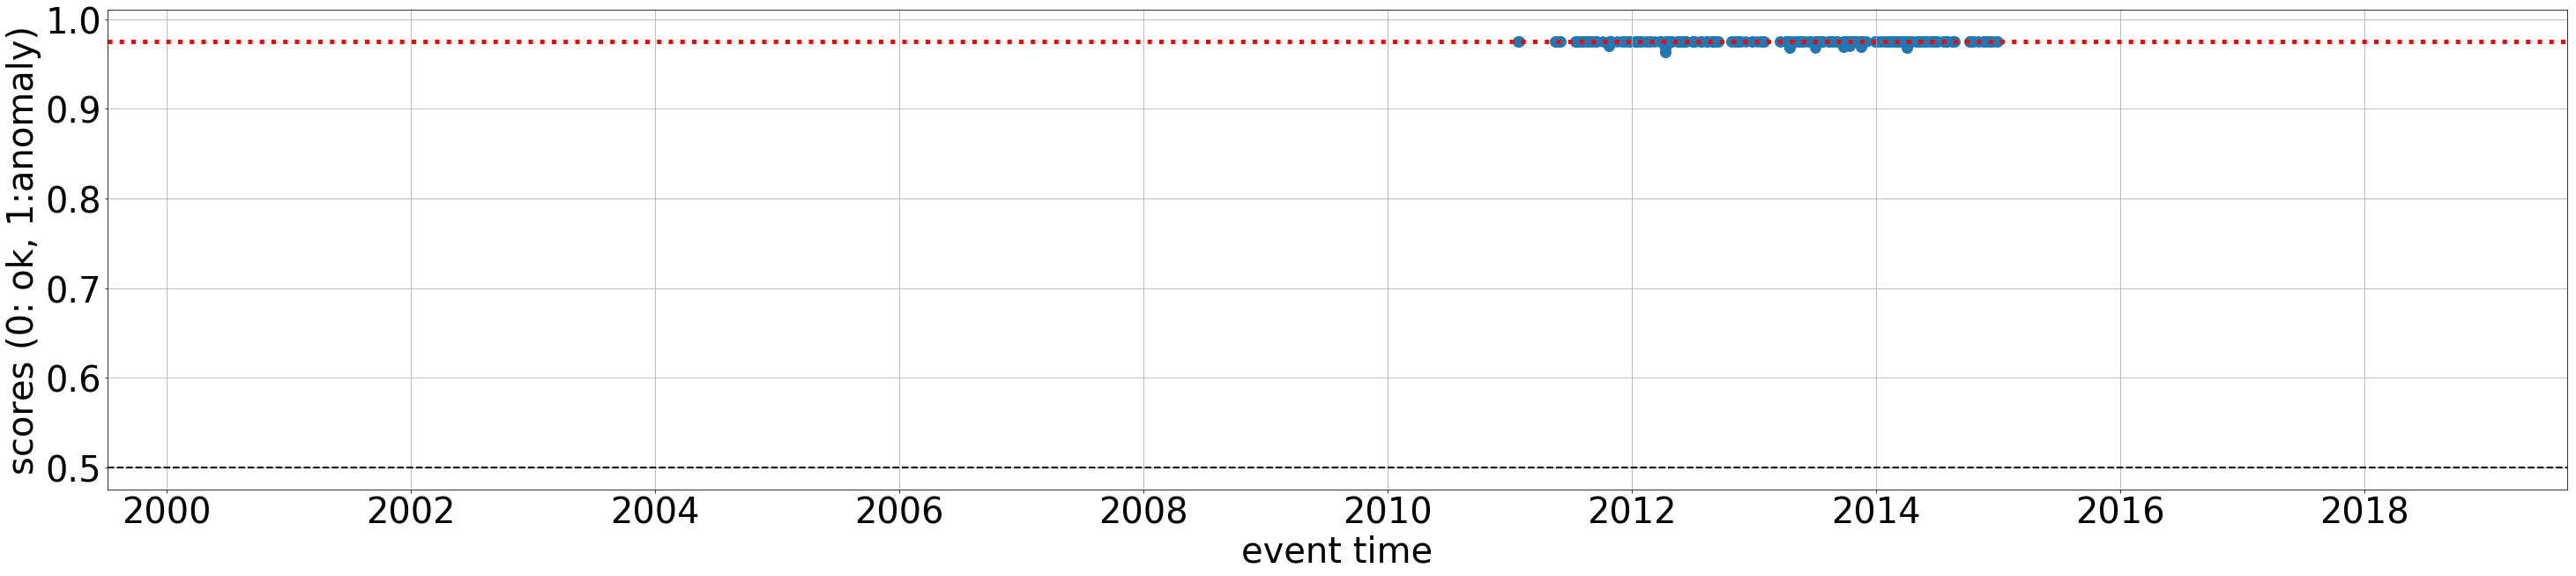

Channel: AF.KTWE..BH? dataset_id: 2 (name: me) Num.segments: 119 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.990[2] 0.977[3] 0.990[4] 0.997[5] 0.996[6] 0.970[7] 0.993[8]


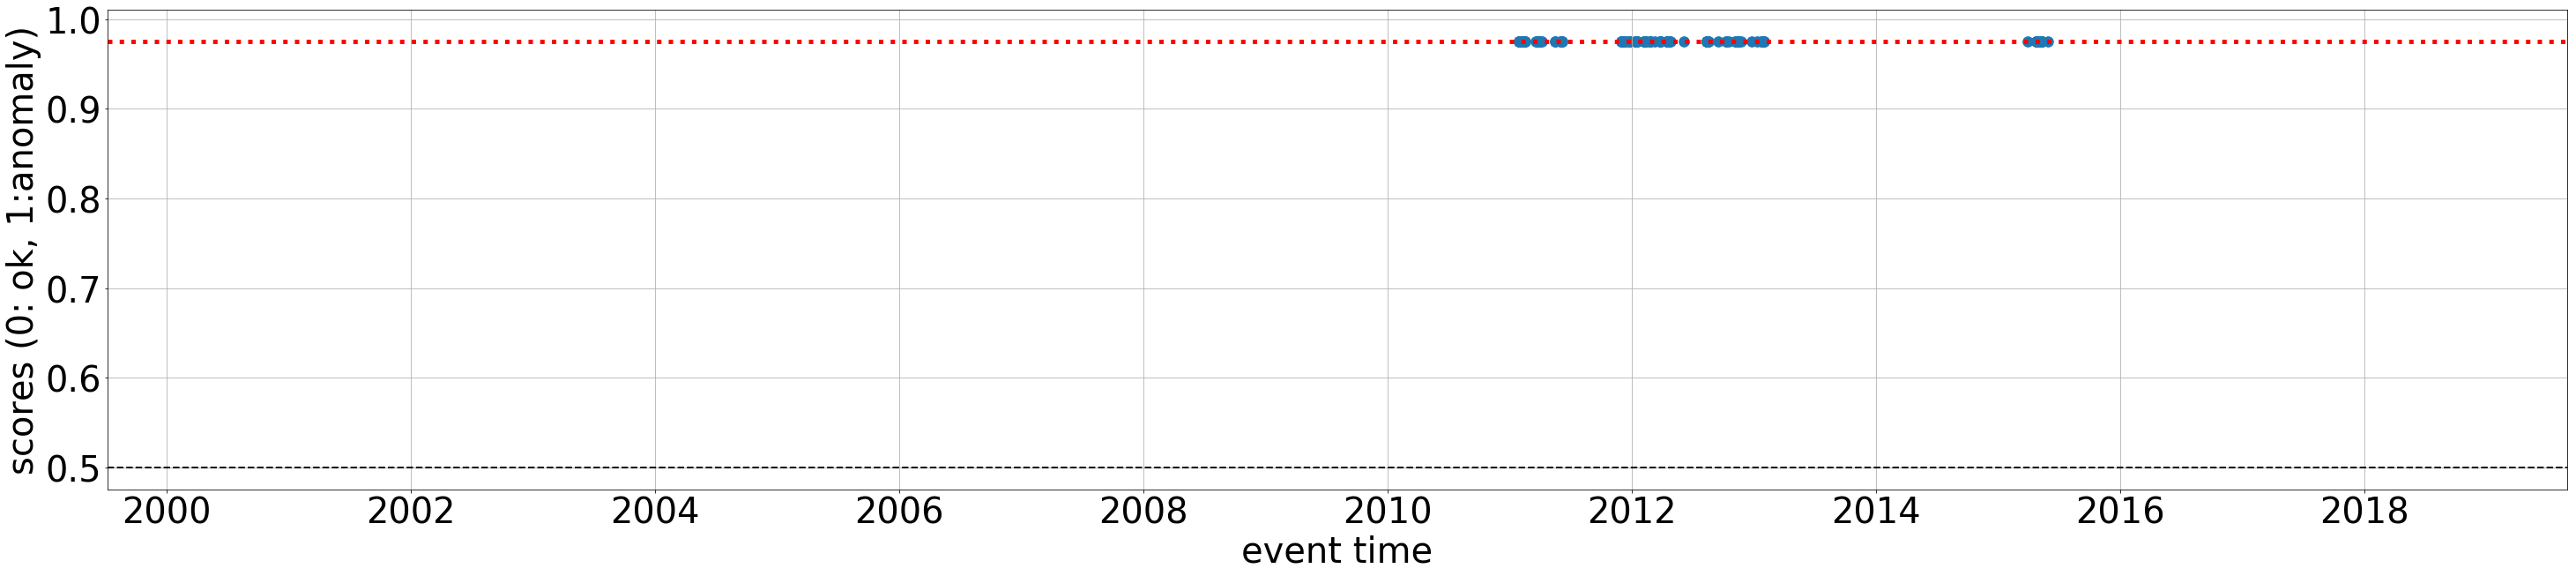

Channel: AF.KUKU..BH? dataset_id: 2 (name: me) Num.segments: 235 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


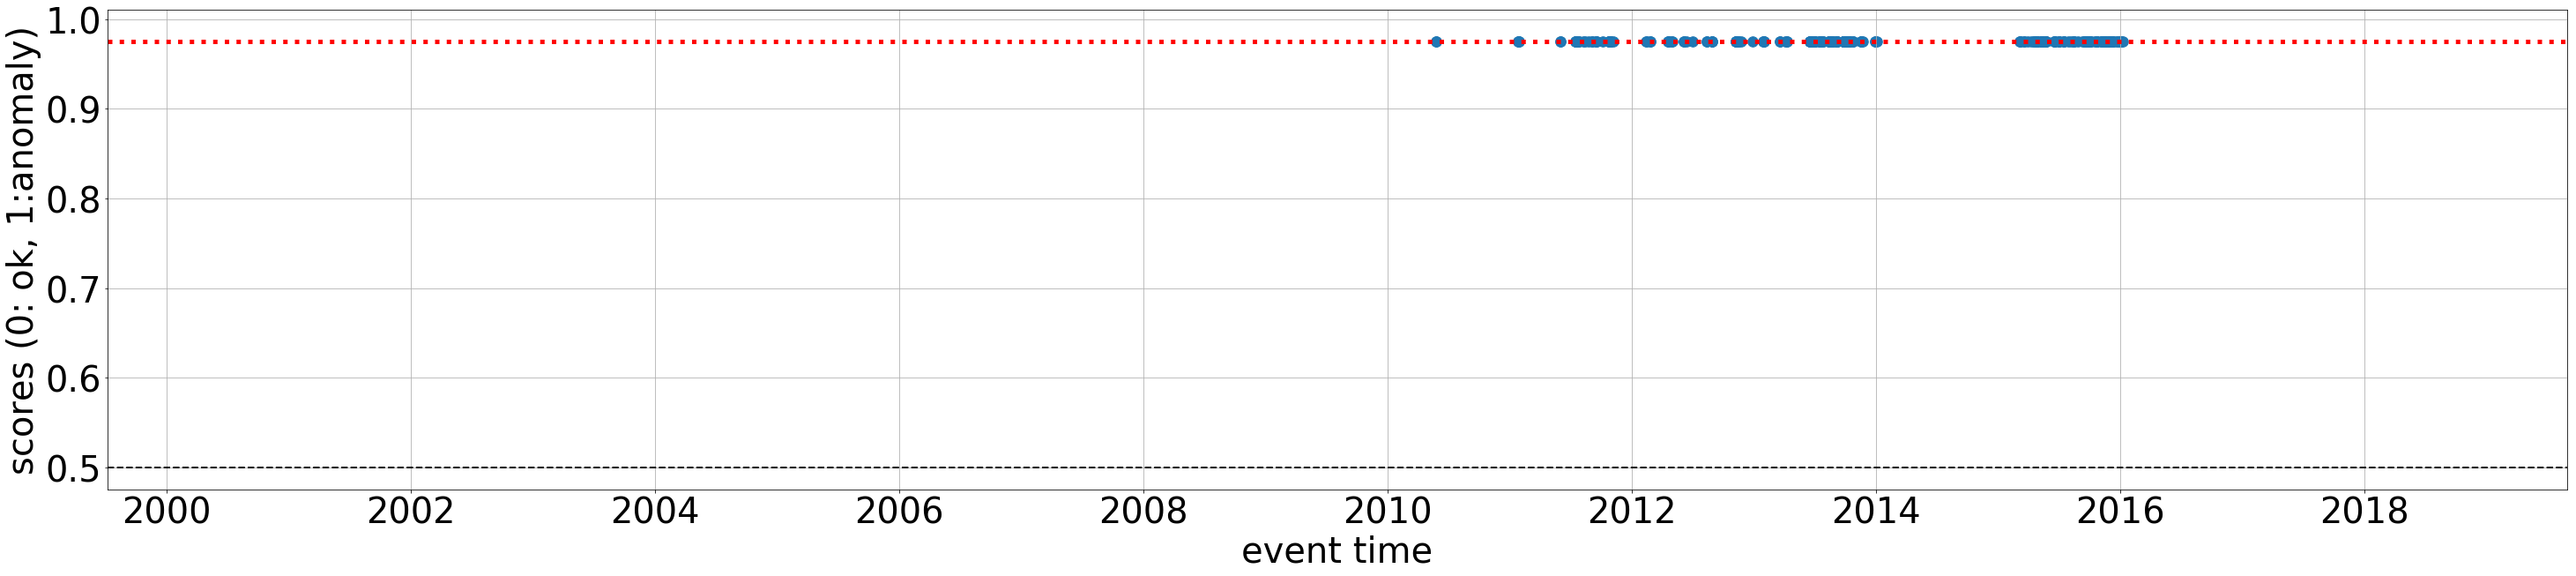

Channel: AF.LBB..BH? dataset_id: 2 (name: me) Num.segments: 148 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


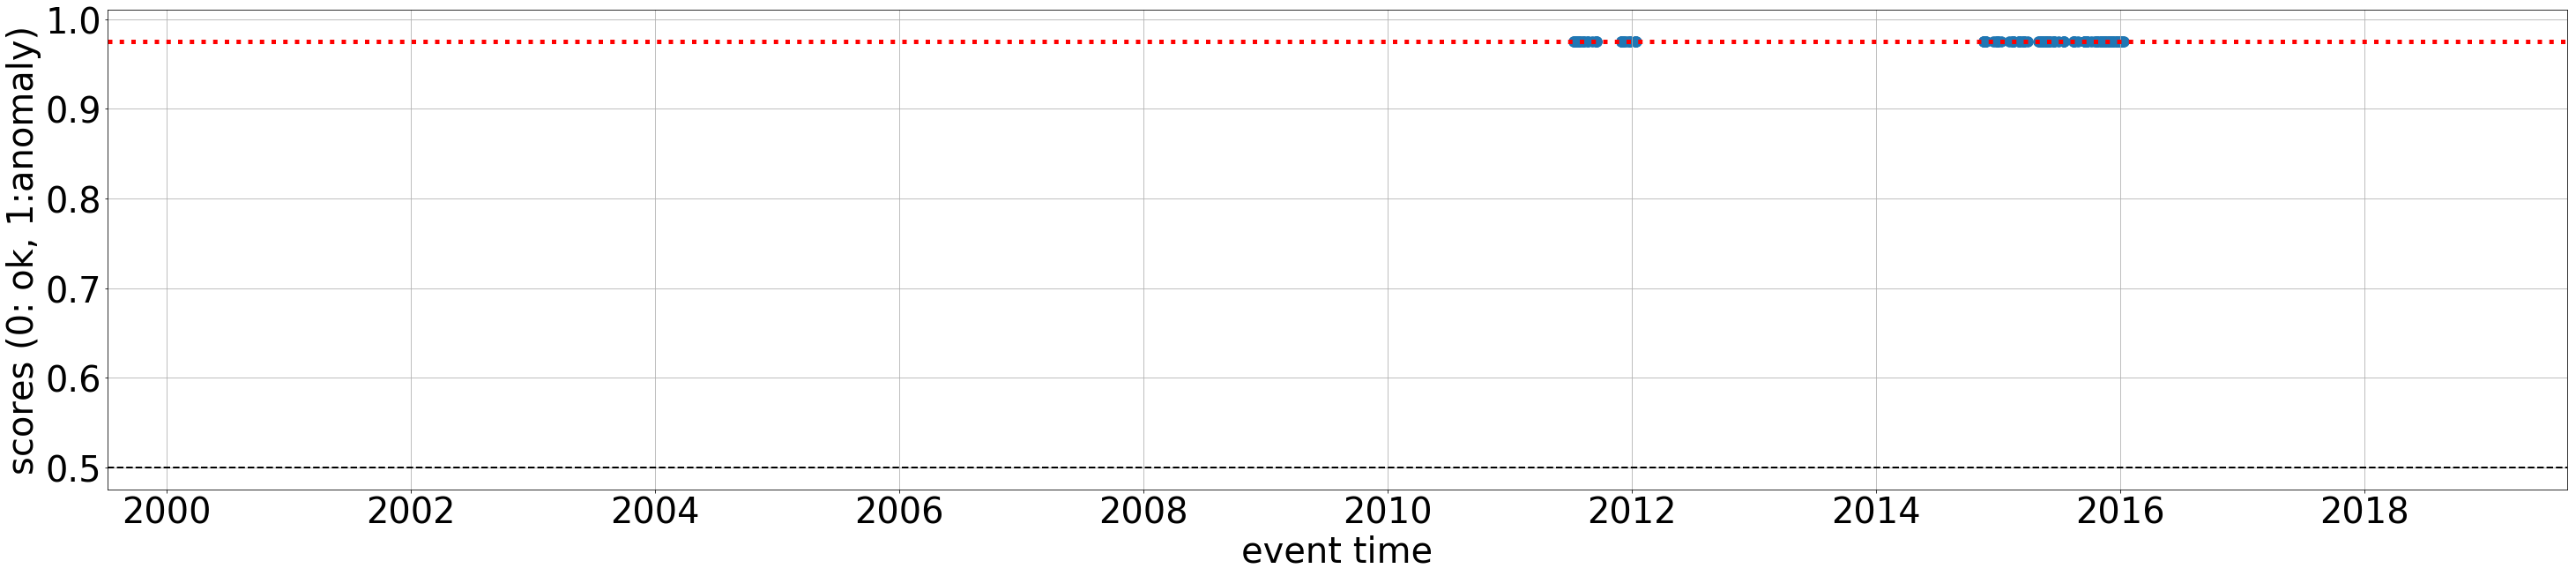

Channel: AF.MBEY..BH? dataset_id: 2 (name: me) Num.segments: 243 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


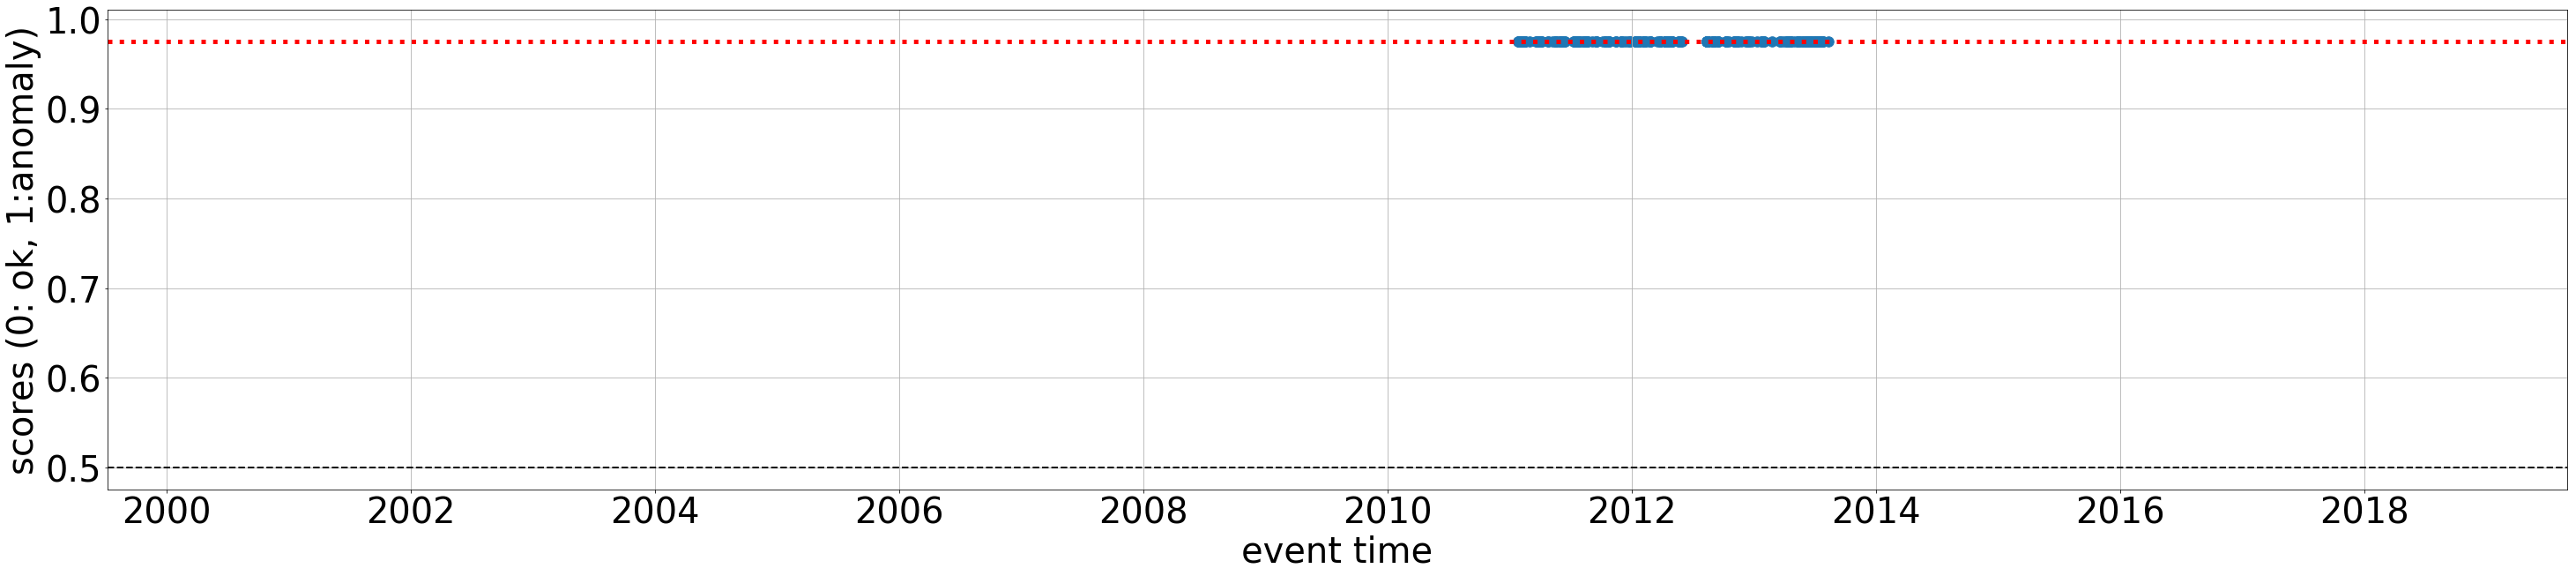

Channel: AF.SHAI..BH? dataset_id: 2 (name: me) Num.segments: 77 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


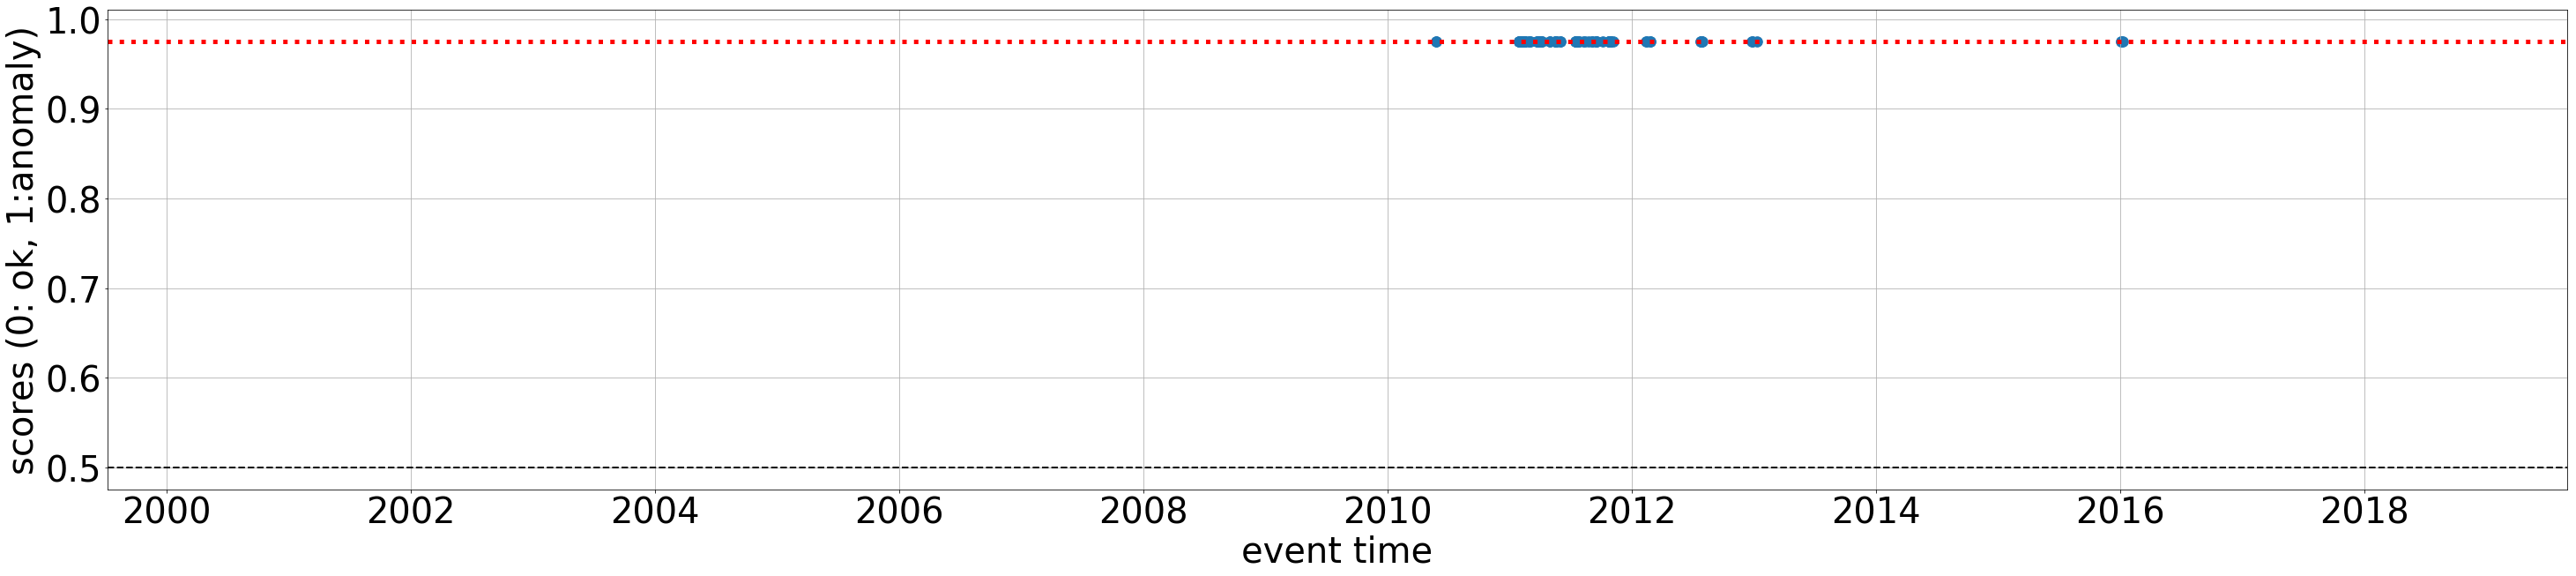

Channel: AF.TEBE..BH? dataset_id: 2 (name: me) Num.segments: 710 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


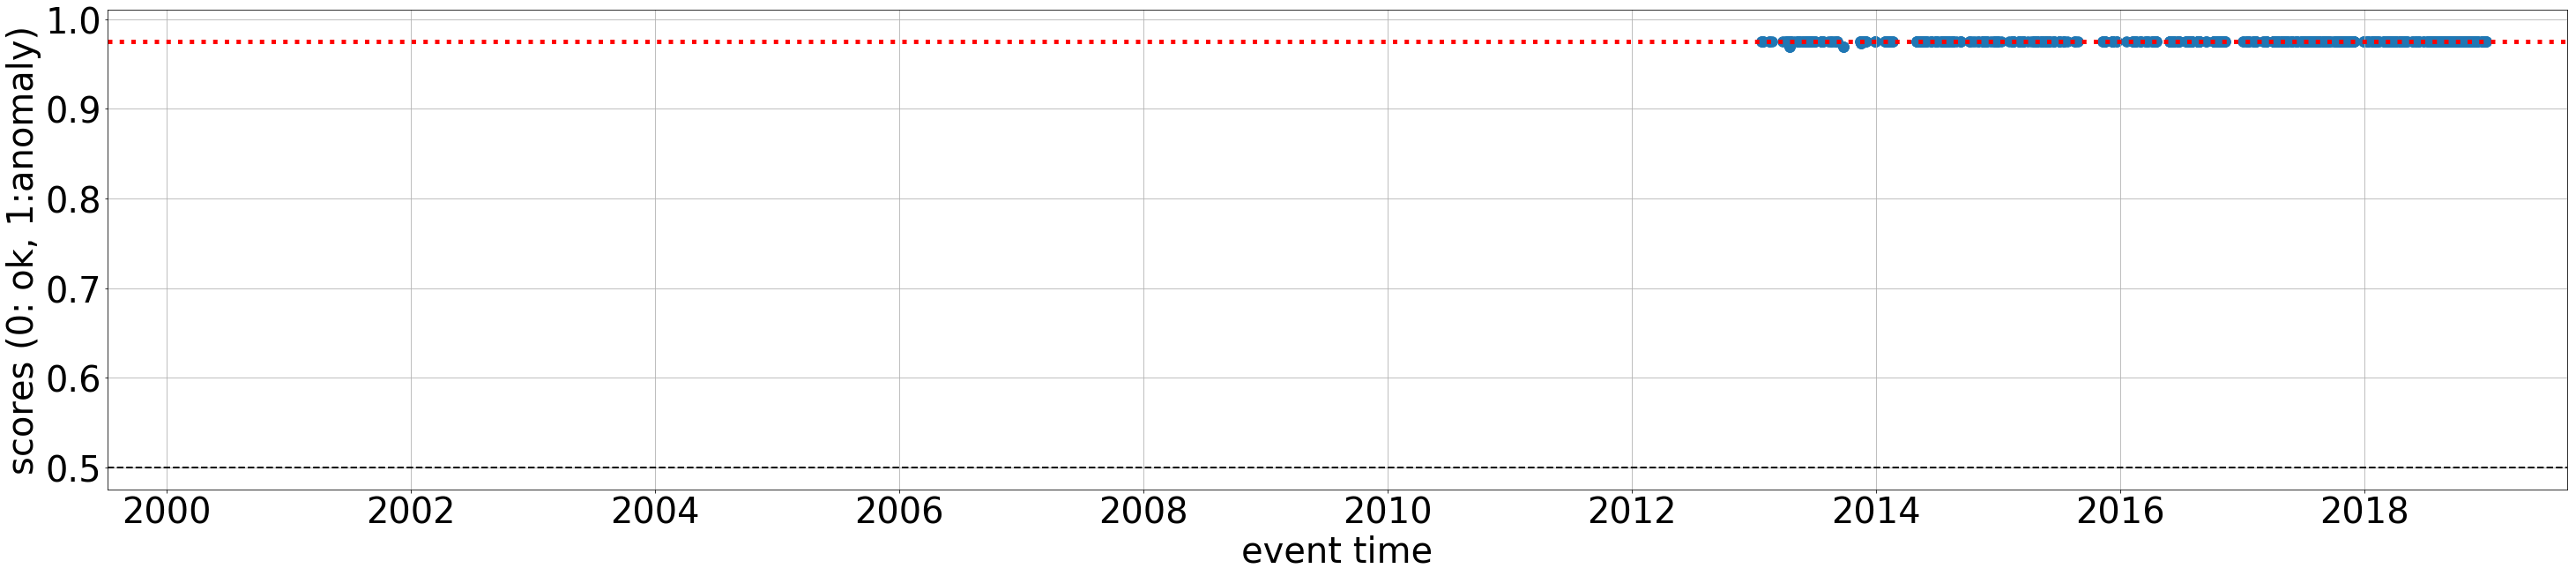

Channel: AF.TEZI..BH? dataset_id: 2 (name: me) Num.segments: 113 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.990[2] 0.977[3] 0.990[4] 0.997[5] 0.996[6] 0.970[7] 0.993[8]


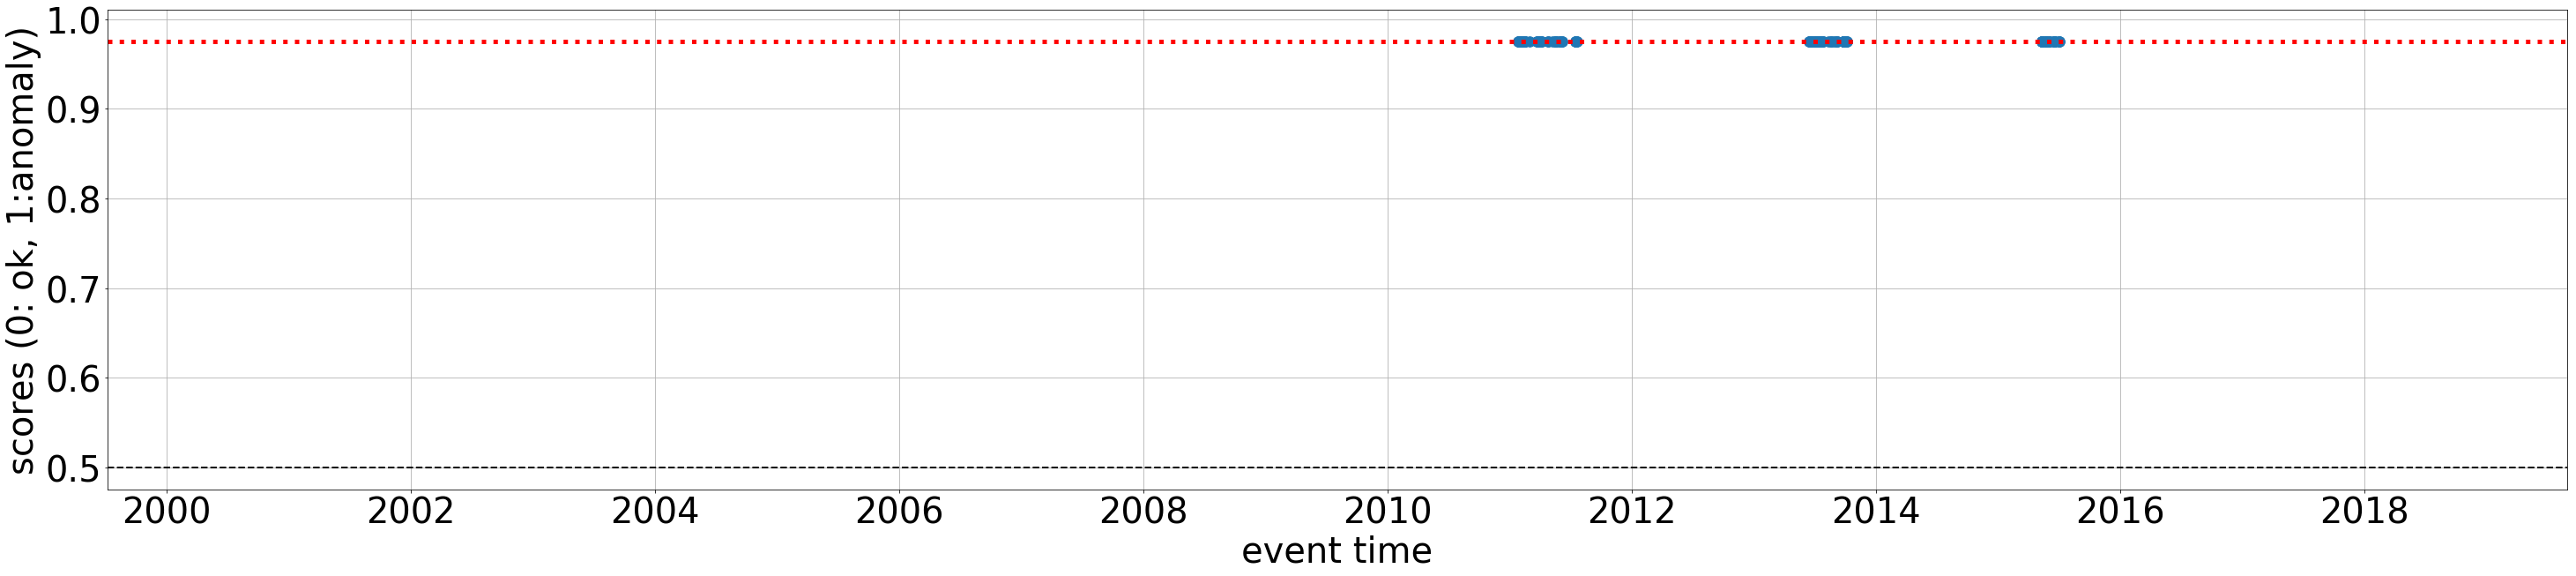

Channel: AF.WIN..BH? dataset_id: 2 (name: me) Num.segments: 309 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


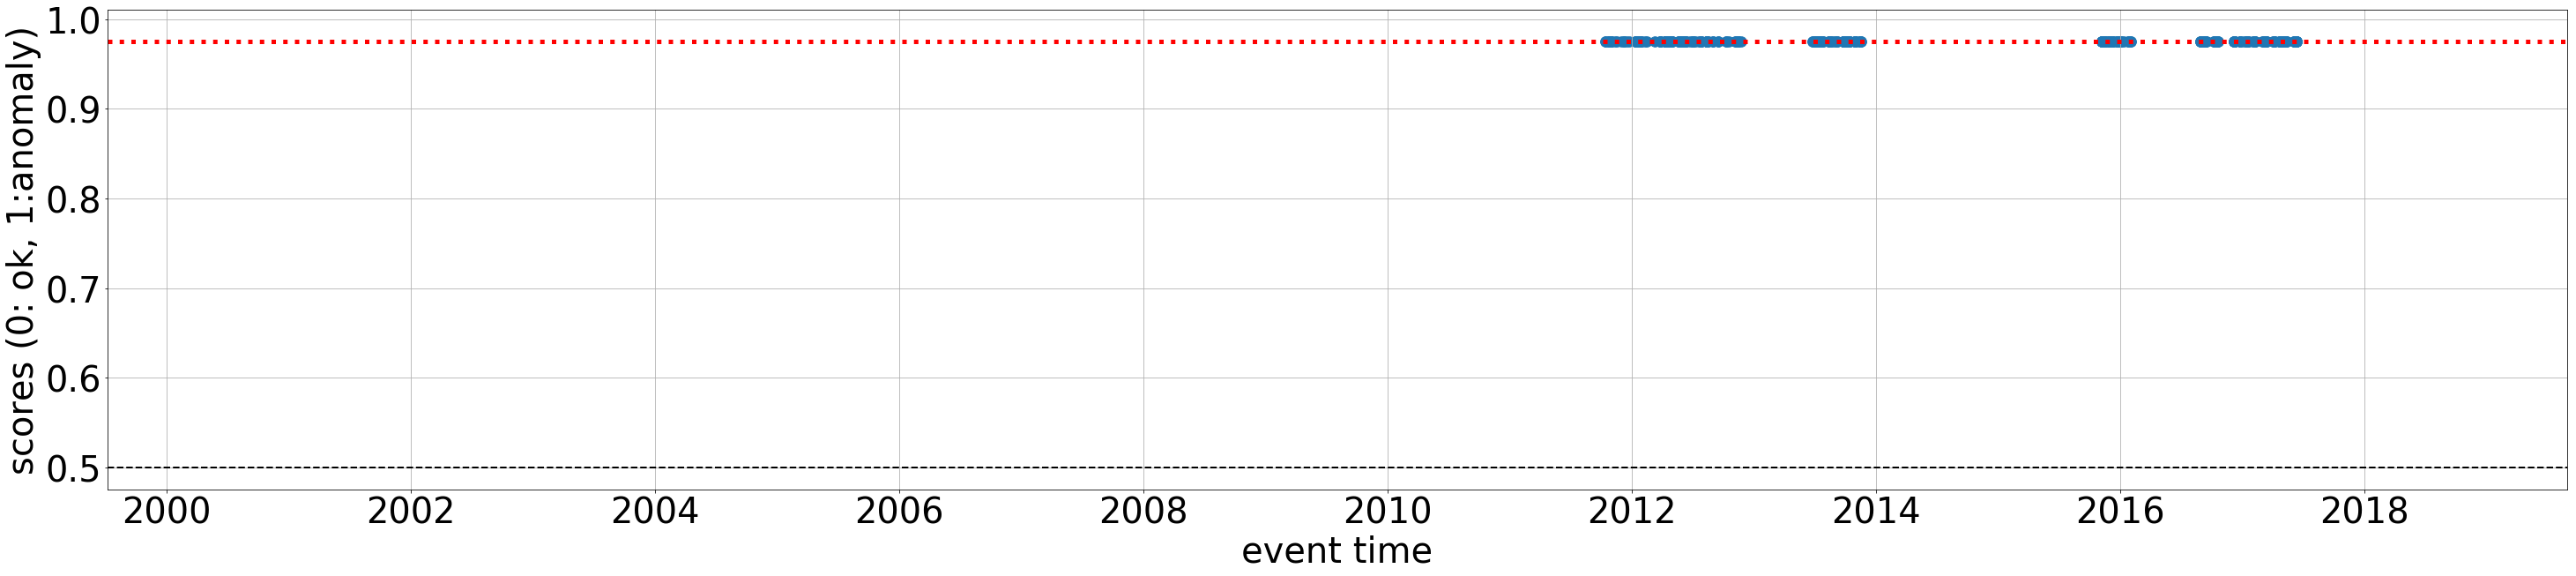

Channel: AF.YNDE..BH? dataset_id: 2 (name: me) Num.segments: 145 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


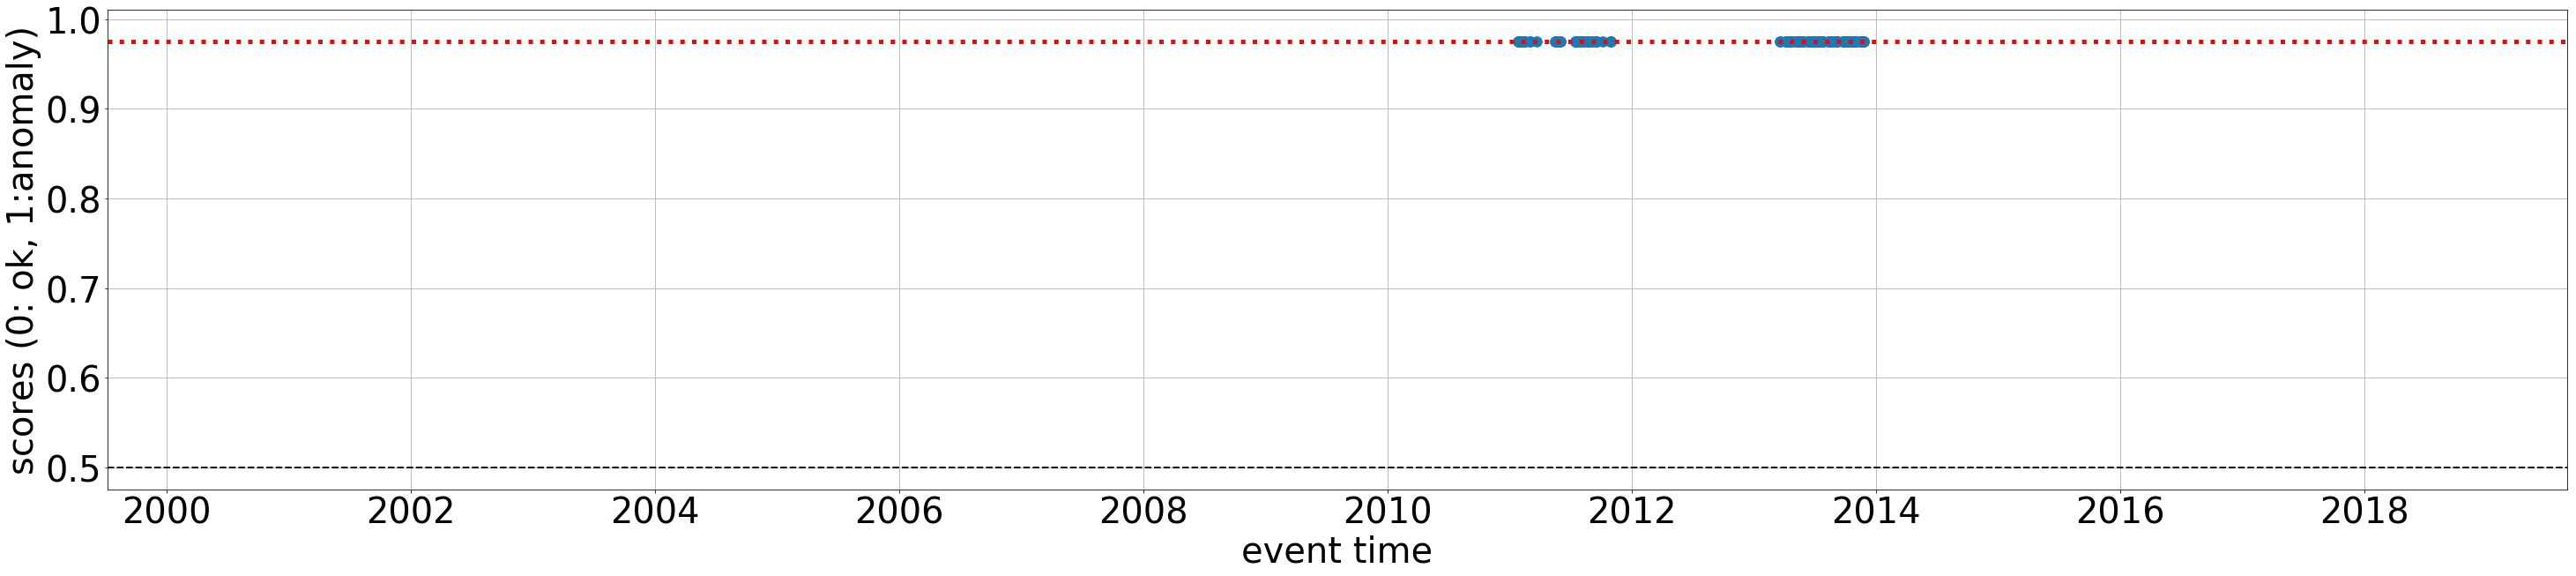

Channel: JP.JEW..BH? dataset_id: 2 (name: me) Num.segments: 1383 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


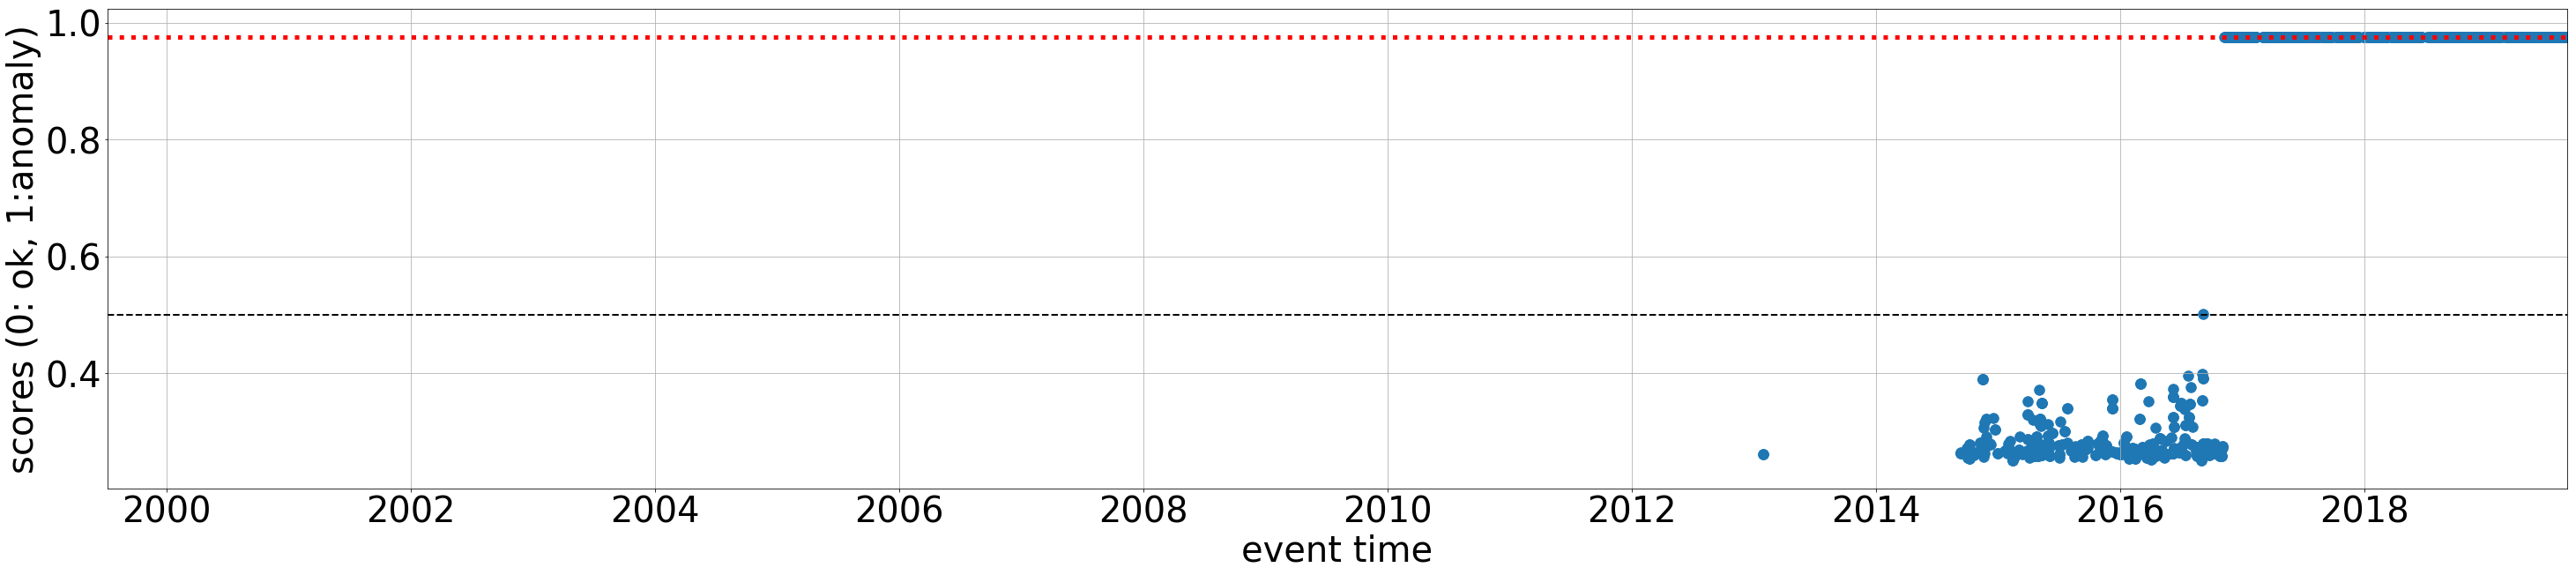

Channel: JP.JYT..BH? dataset_id: 2 (name: me) Num.segments: 1569 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.976[0] 0.981[1] 0.991[2] 0.977[3] 0.990[4] 1.000[5] 0.996[6] 0.970[7] 1.000[8]


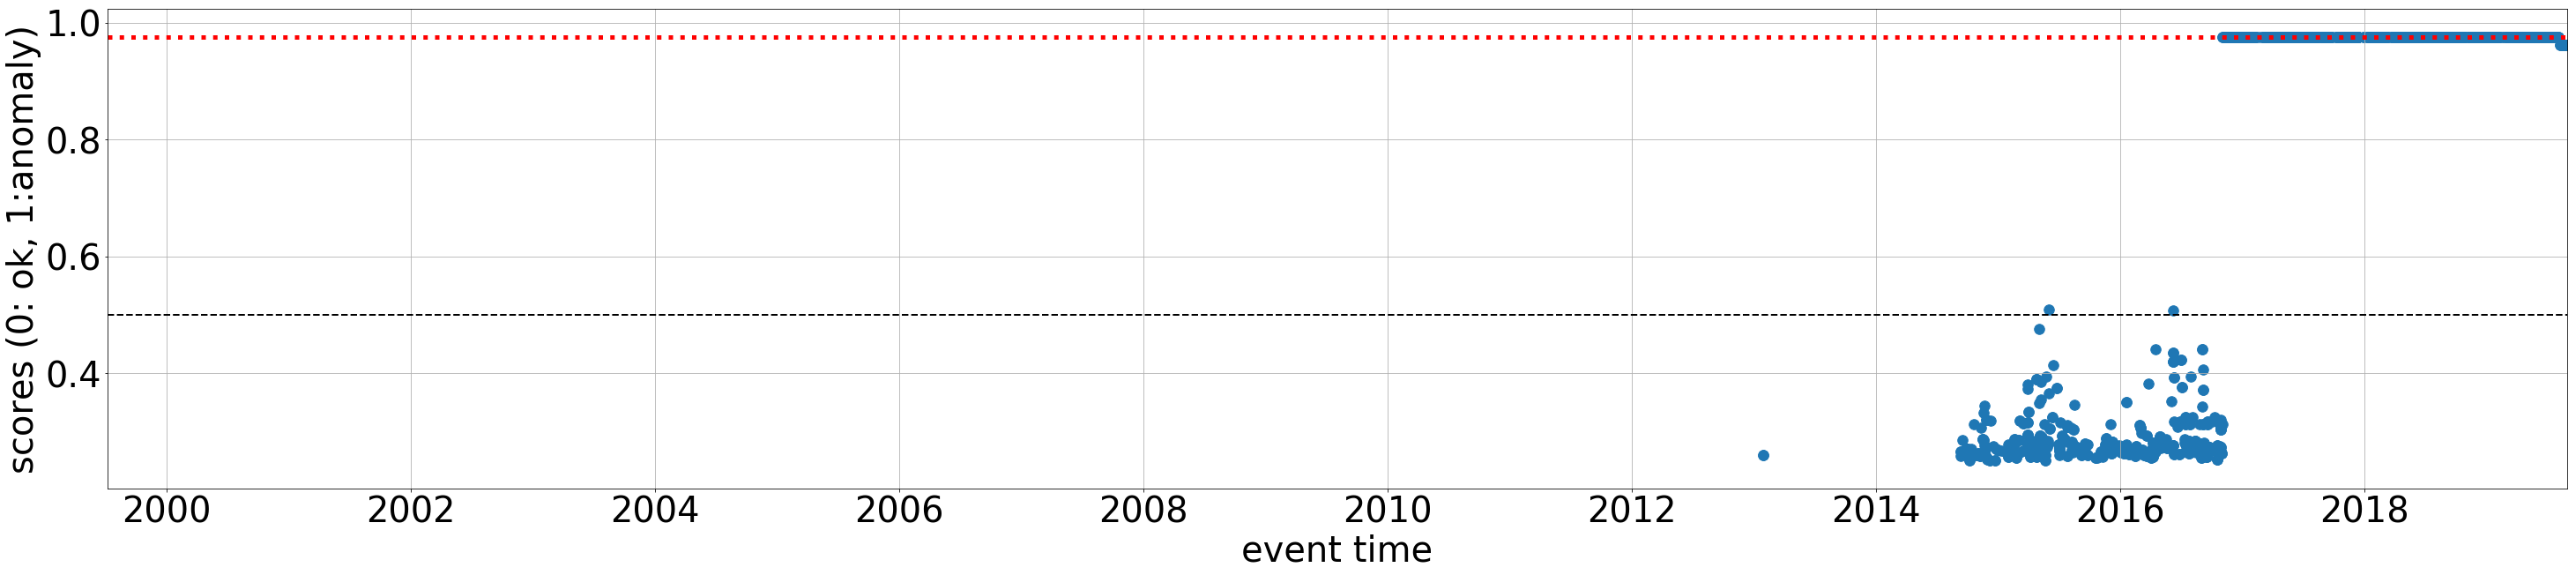

Channel: UD.LUBAR..BH? dataset_id: 2 (name: me) Num.segments: 58 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.971[0] 0.939[1] 0.888[2] 0.973[3] 0.939[4] 0.876[5] 0.956[6] 0.937[7] 0.883[8]


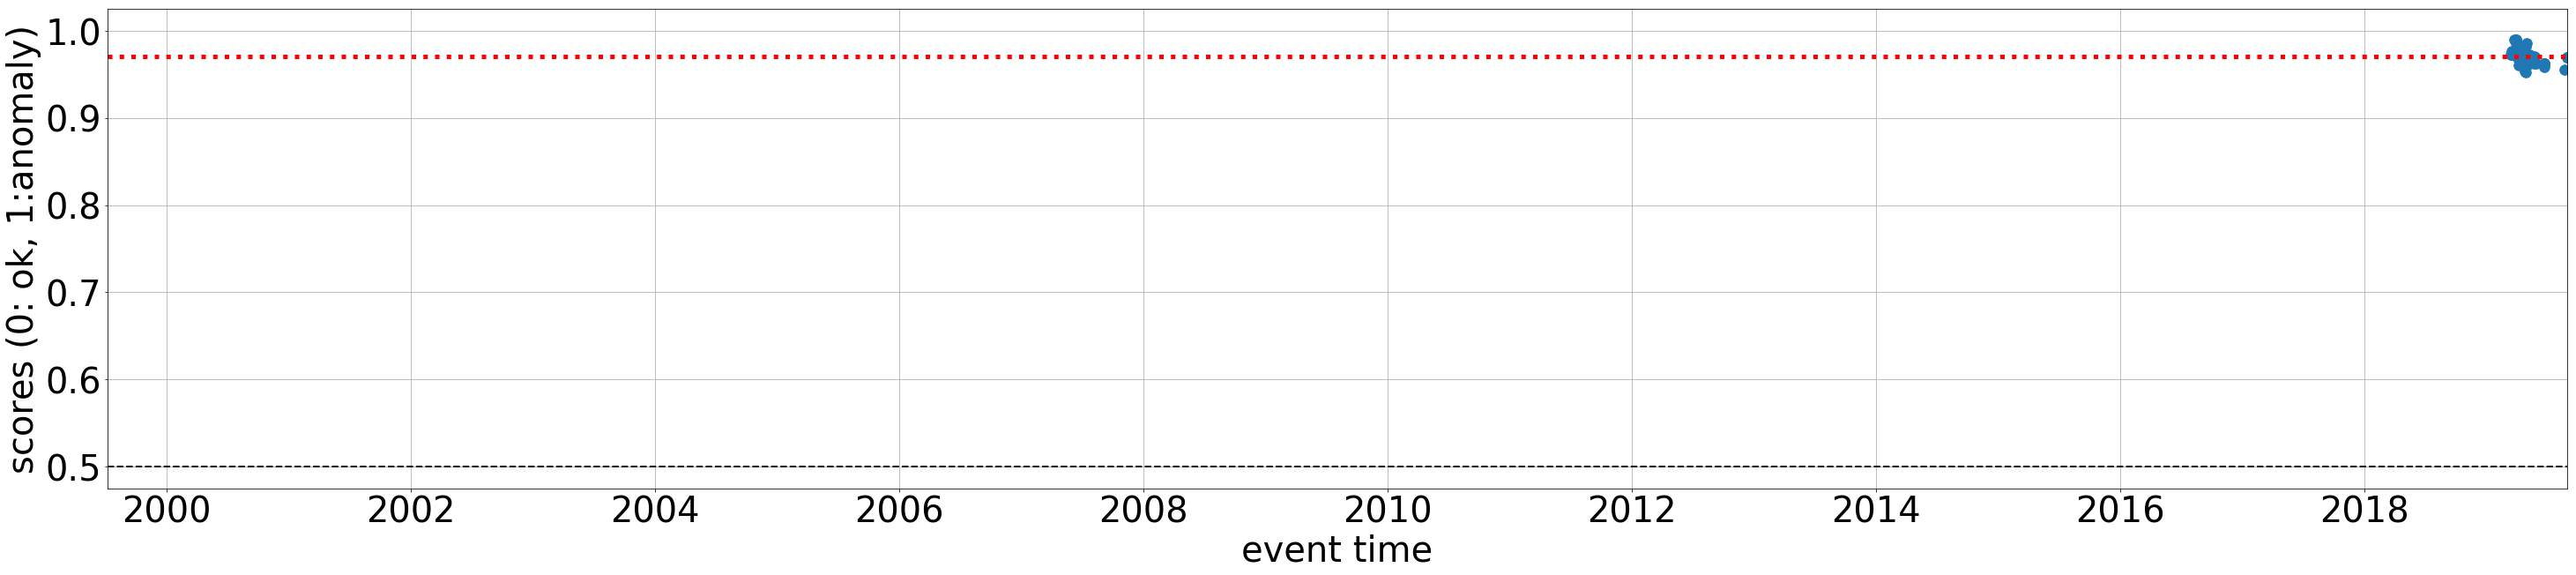

Channel: BS.JMB..BH? dataset_id: 2 (name: me) Num.segments: 756 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.970[0] 0.971[1] 0.955[2] 0.977[3] 0.983[4] 0.966[5] 0.996[6] 0.961[7] 0.961[8]


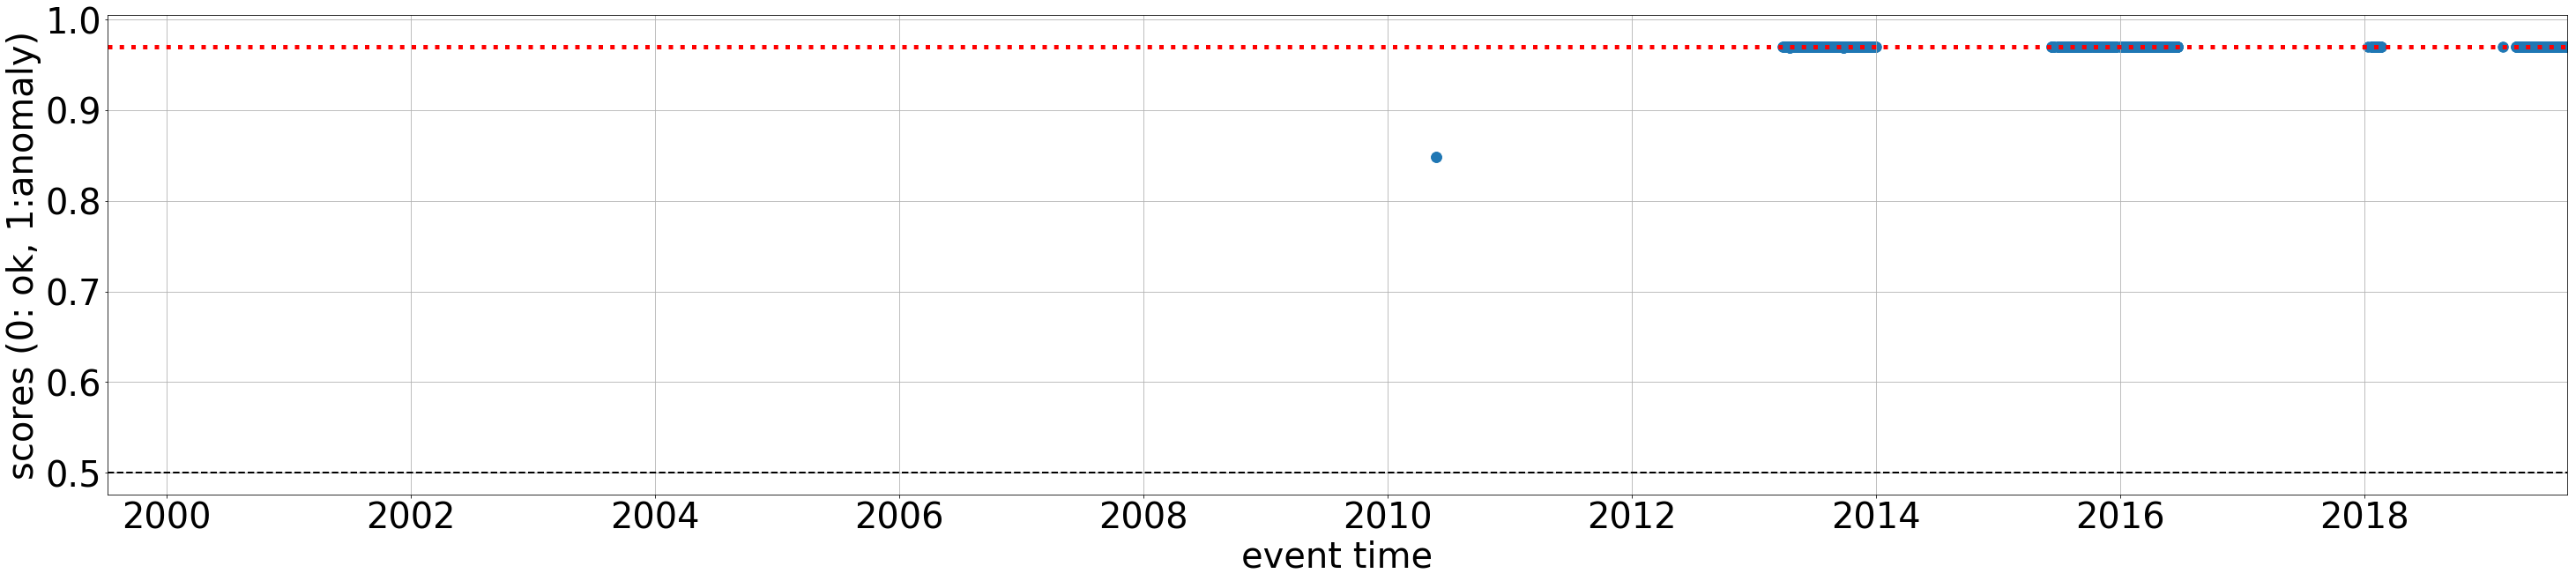

Channel: OE.CONA.51.BH? dataset_id: 2 (name: me) Num.segments: 5 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.969[0] 0.967[1] 0.946[2] 0.977[3] 0.982[4] 0.960[5] 0.996[6] 0.961[7] 0.957[8]


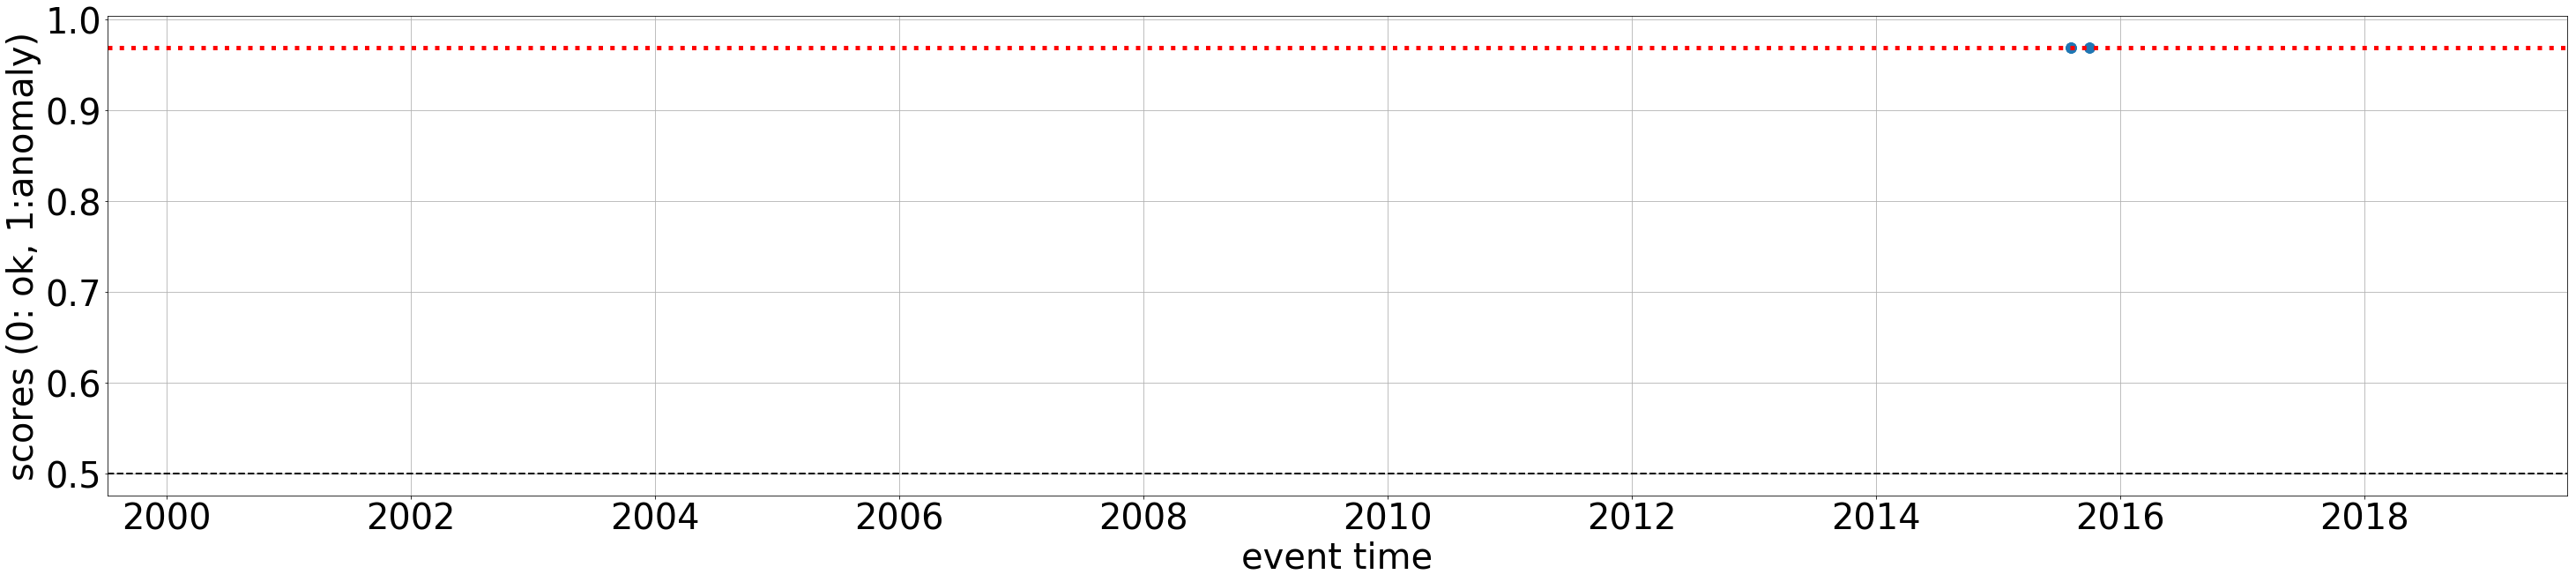

Channel: NU.MGAN..BH? dataset_id: 2 (name: me) Num.segments: 1869 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.968[0] 0.965[1] 0.933[2] 0.974[3] 0.976[4] 0.946[5] 0.990[6] 0.952[7] 0.935[8]


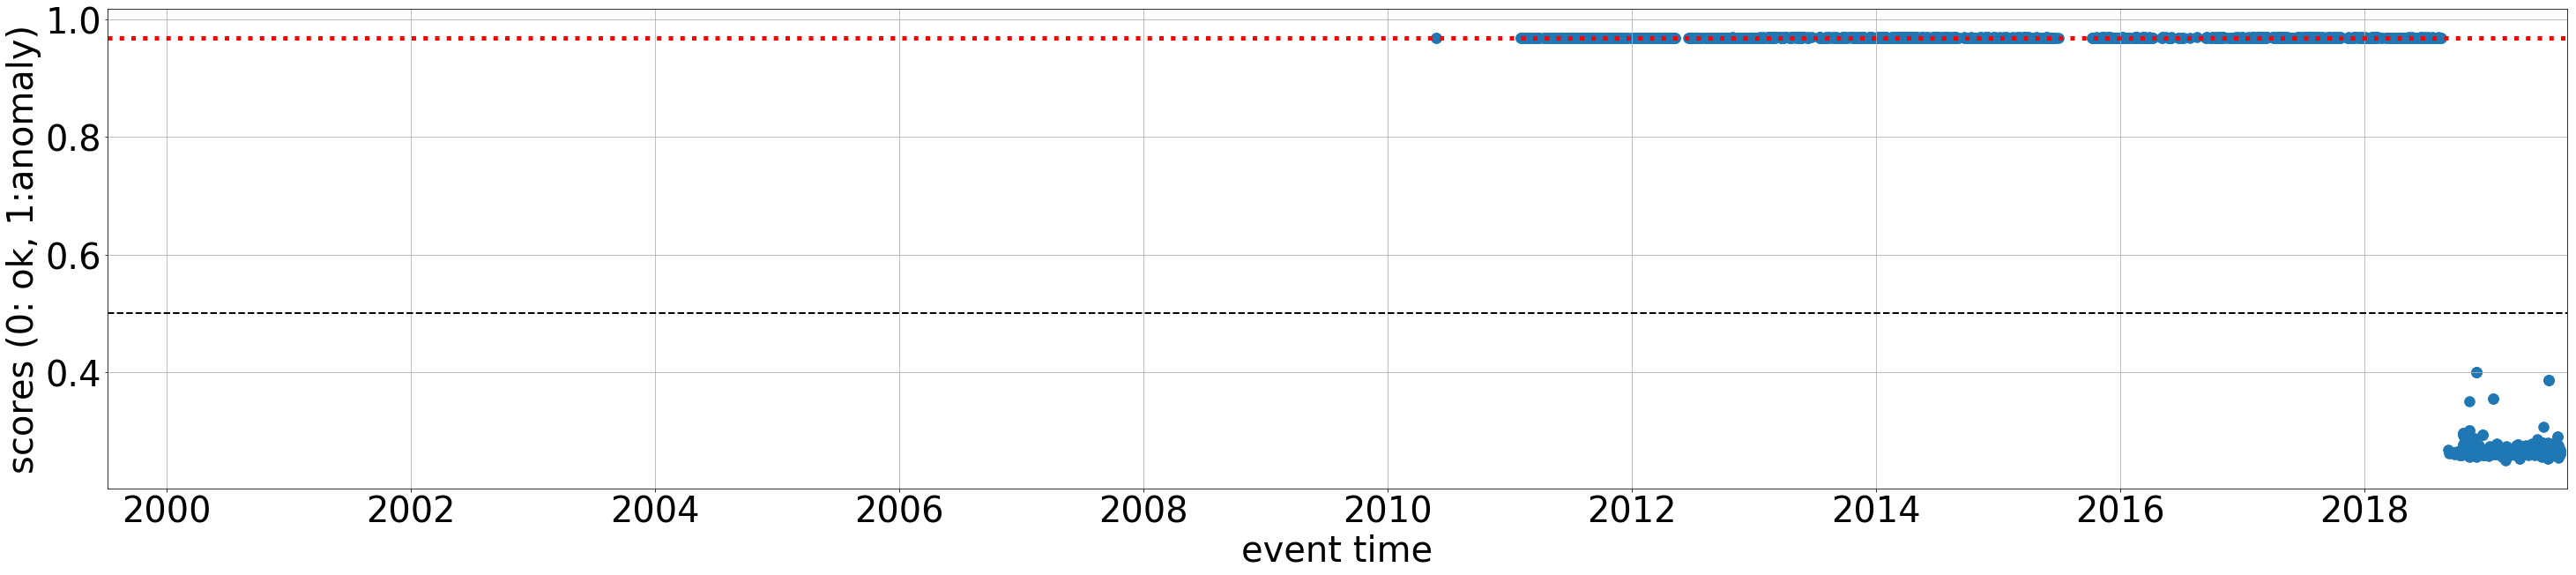

Channel: MS.UBIN..BH? dataset_id: 2 (name: me) Num.segments: 14 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.968[0] 0.958[1] 0.917[2] 0.974[3] 0.972[4] 0.929[5] 0.990[6] 0.949[7] 0.922[8]


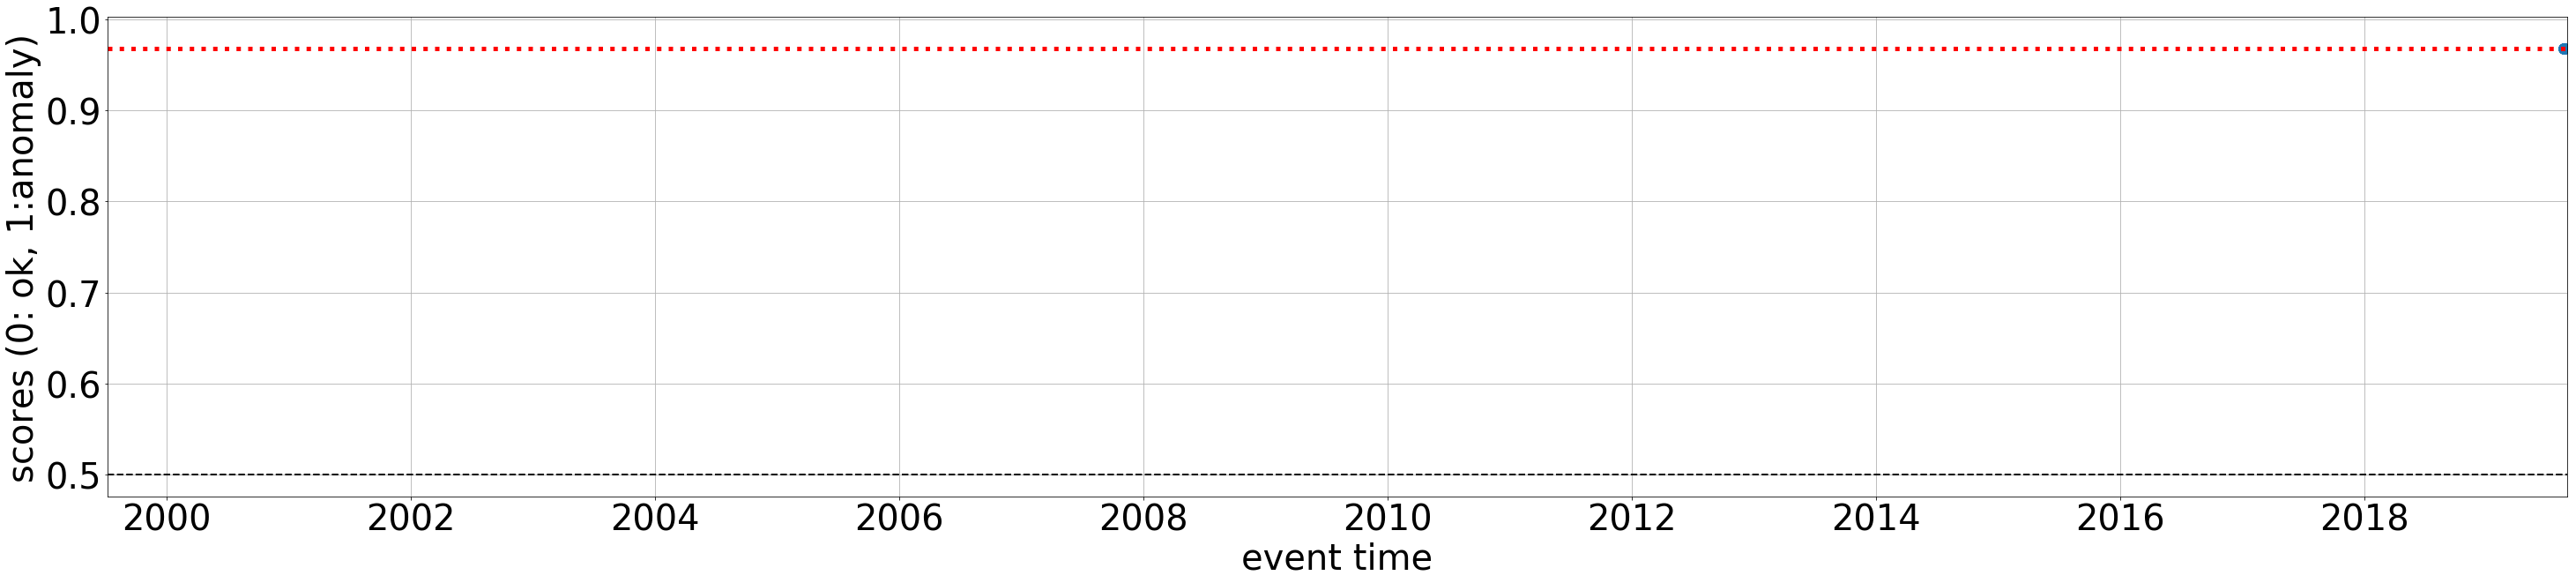

Channel: NU.MGAN..BH? dataset_id: 2 (name: me) Num.segments: 1069 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.968[0] 0.965[1] 0.933[2] 0.974[3] 0.976[4] 0.947[5] 0.990[6] 0.952[7] 0.936[8]


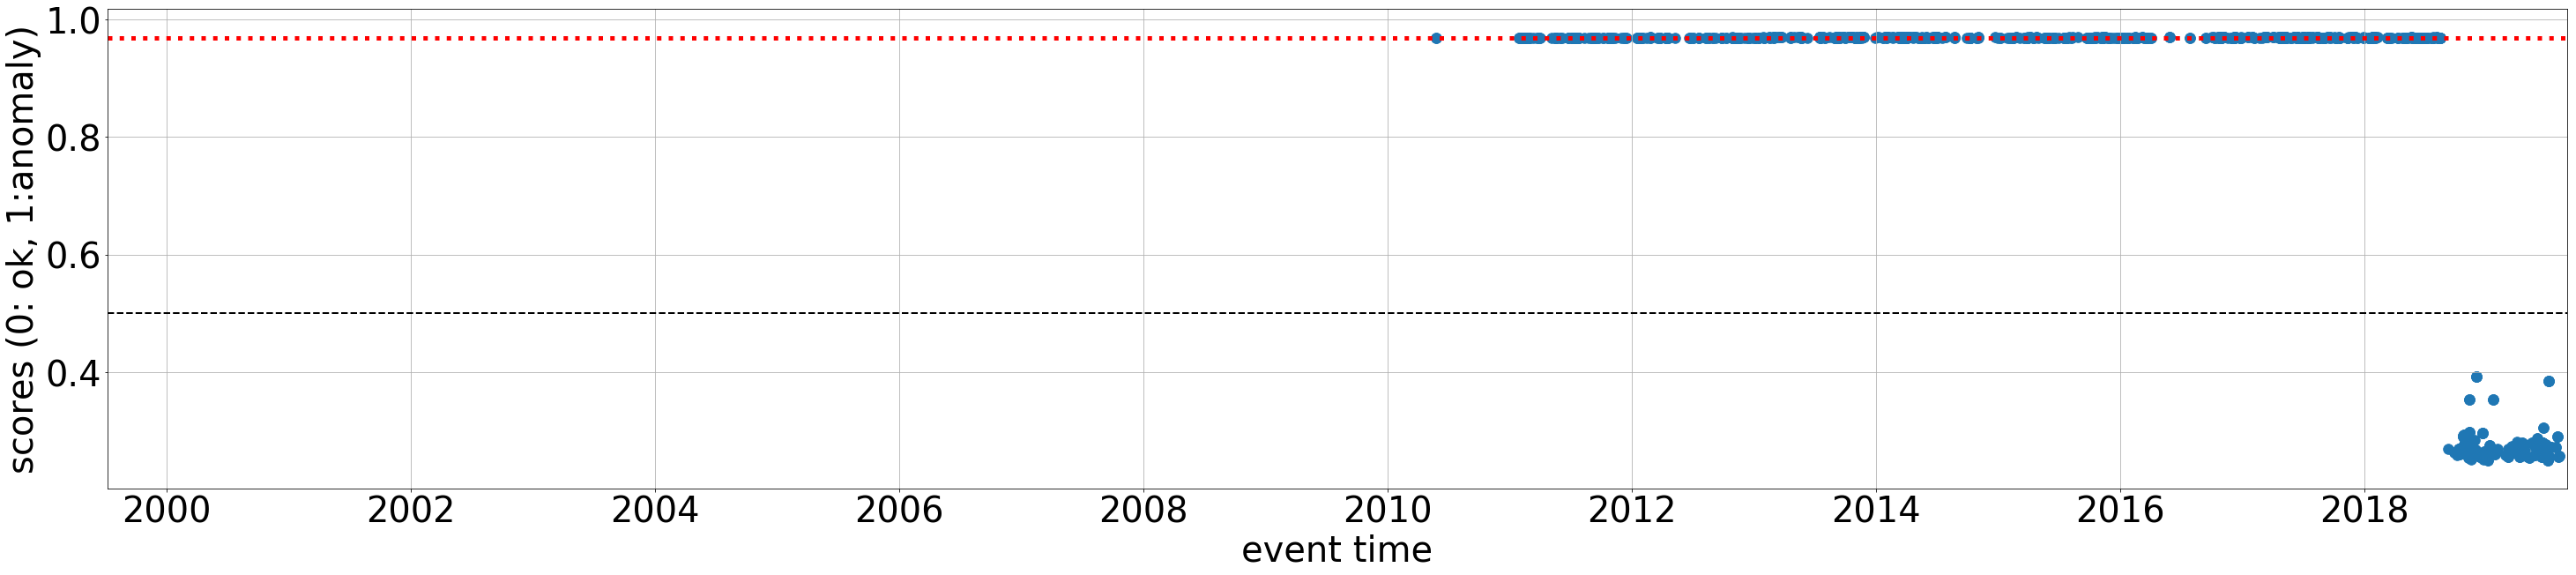

Channel: TA.Y22D.01.BH? dataset_id: 2 (name: me) Num.segments: 287 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.968[0] 0.965[1] 0.930[2] 0.974[3] 0.976[4] 0.945[5] 0.990[6] 0.952[7] 0.935[8]


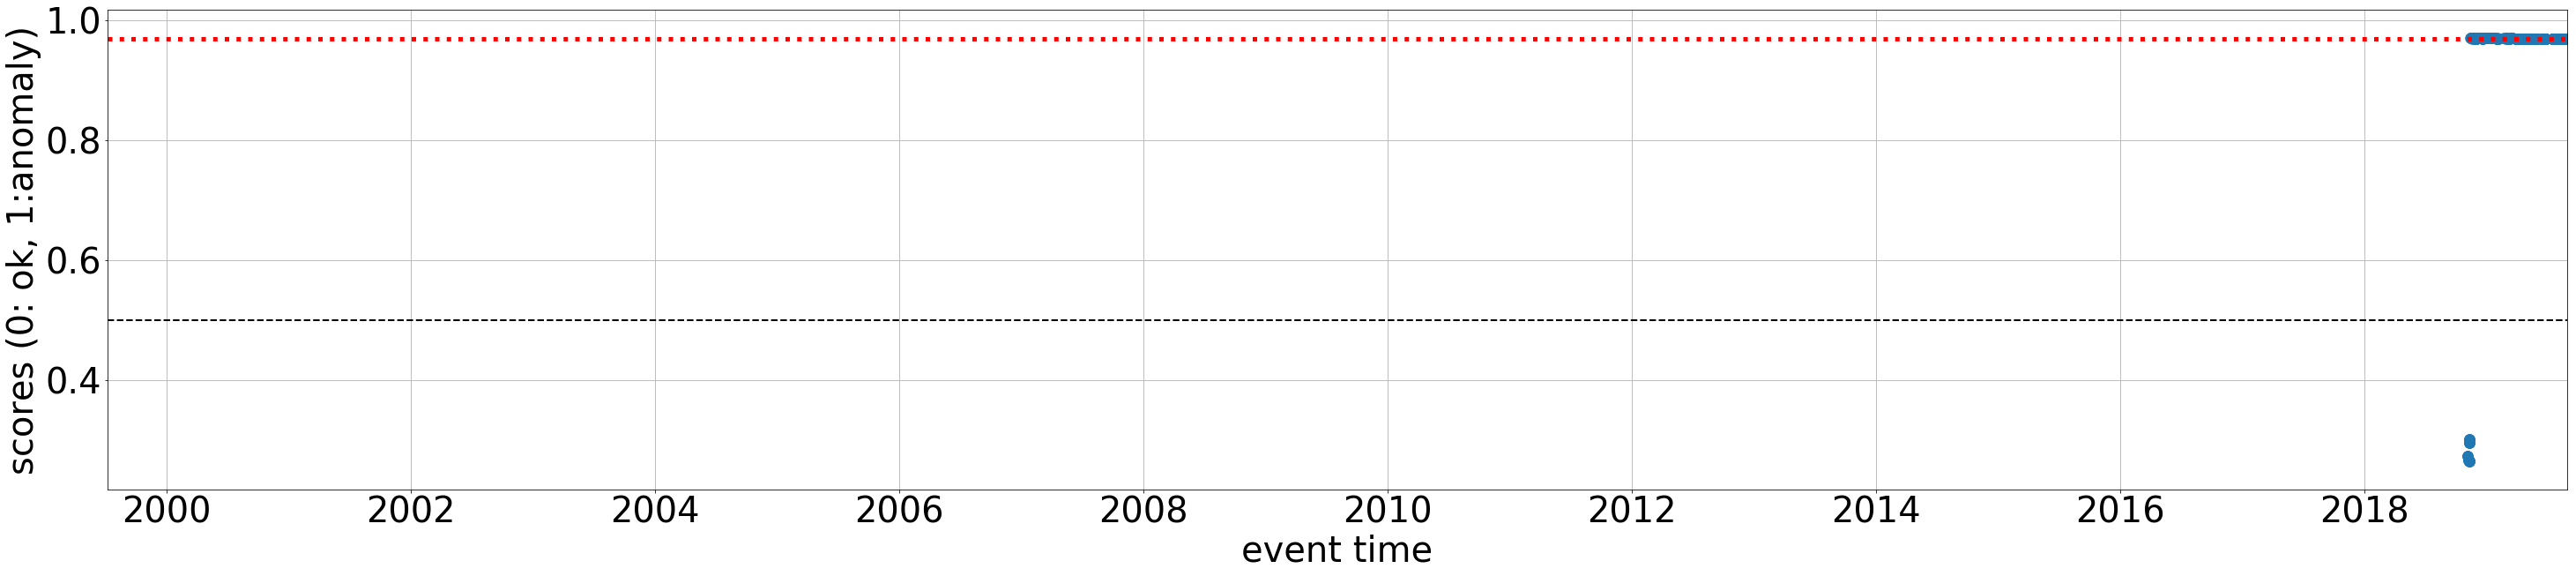

Channel: JP.JSU..BH? dataset_id: 2 (name: me) Num.segments: 1567 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.963[0] 0.953[1] 0.891[2] 0.972[3] 0.966[4] 0.904[5] 0.985[6] 0.941[7] 0.892[8]


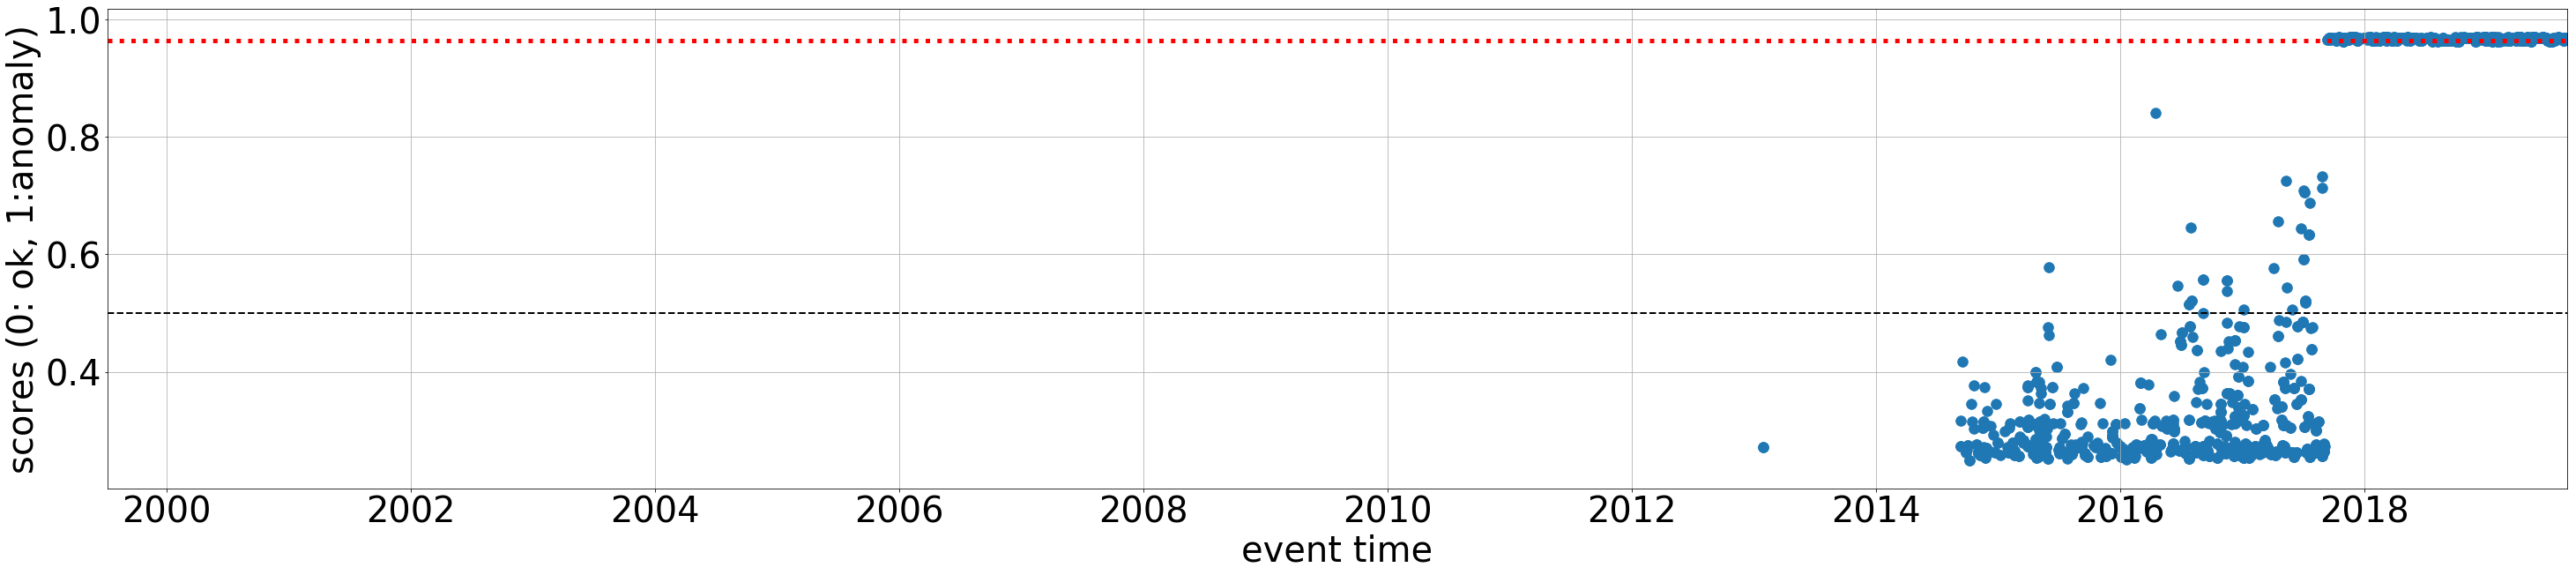

Channel: IU.TRQA.00.BH? dataset_id: 2 (name: me) Num.segments: 769 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.963[0] 0.951[1] 0.883[2] 0.972[3] 0.962[4] 0.898[5] 0.985[6] 0.940[7] 0.886[8]


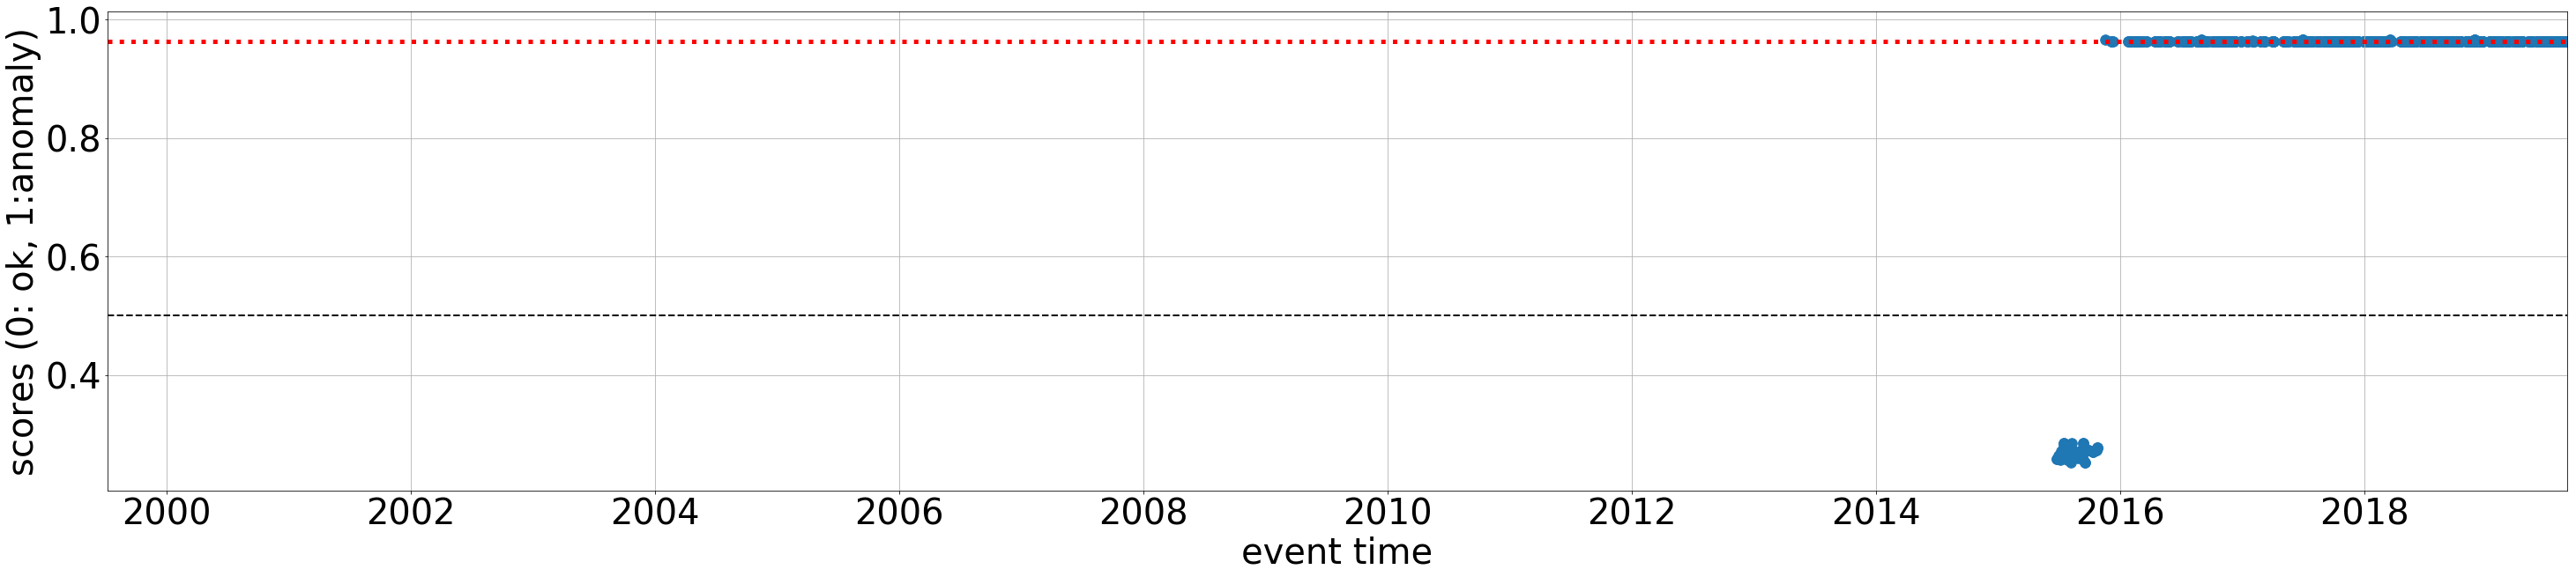

Channel: YN.TFRD..BH? dataset_id: 2 (name: me) Num.segments: 1107 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.963[0] 0.943[1] 0.874[2] 0.972[3] 0.956[4] 0.879[5] 0.985[6] 0.935[7] 0.872[8]


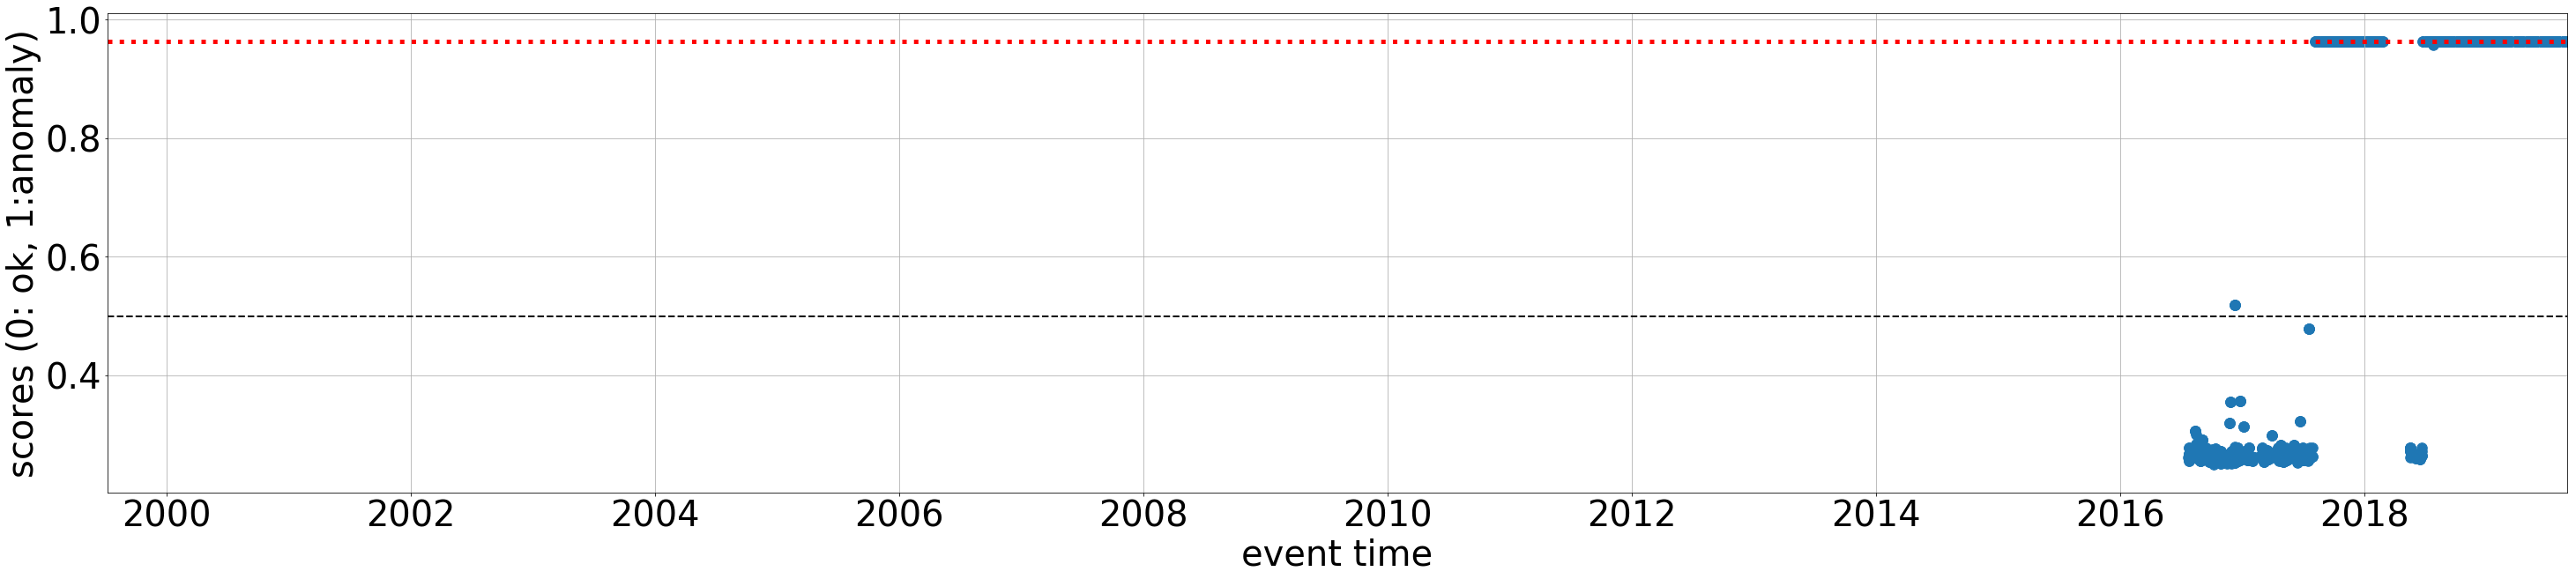

Channel: MC.TRNT..BH? dataset_id: 2 (name: me) Num.segments: 650 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.961[0] 0.919[1] 0.857[2] 0.961[3] 0.925[4] 0.847[5] 0.951[6] 0.924[7] 0.847[8]


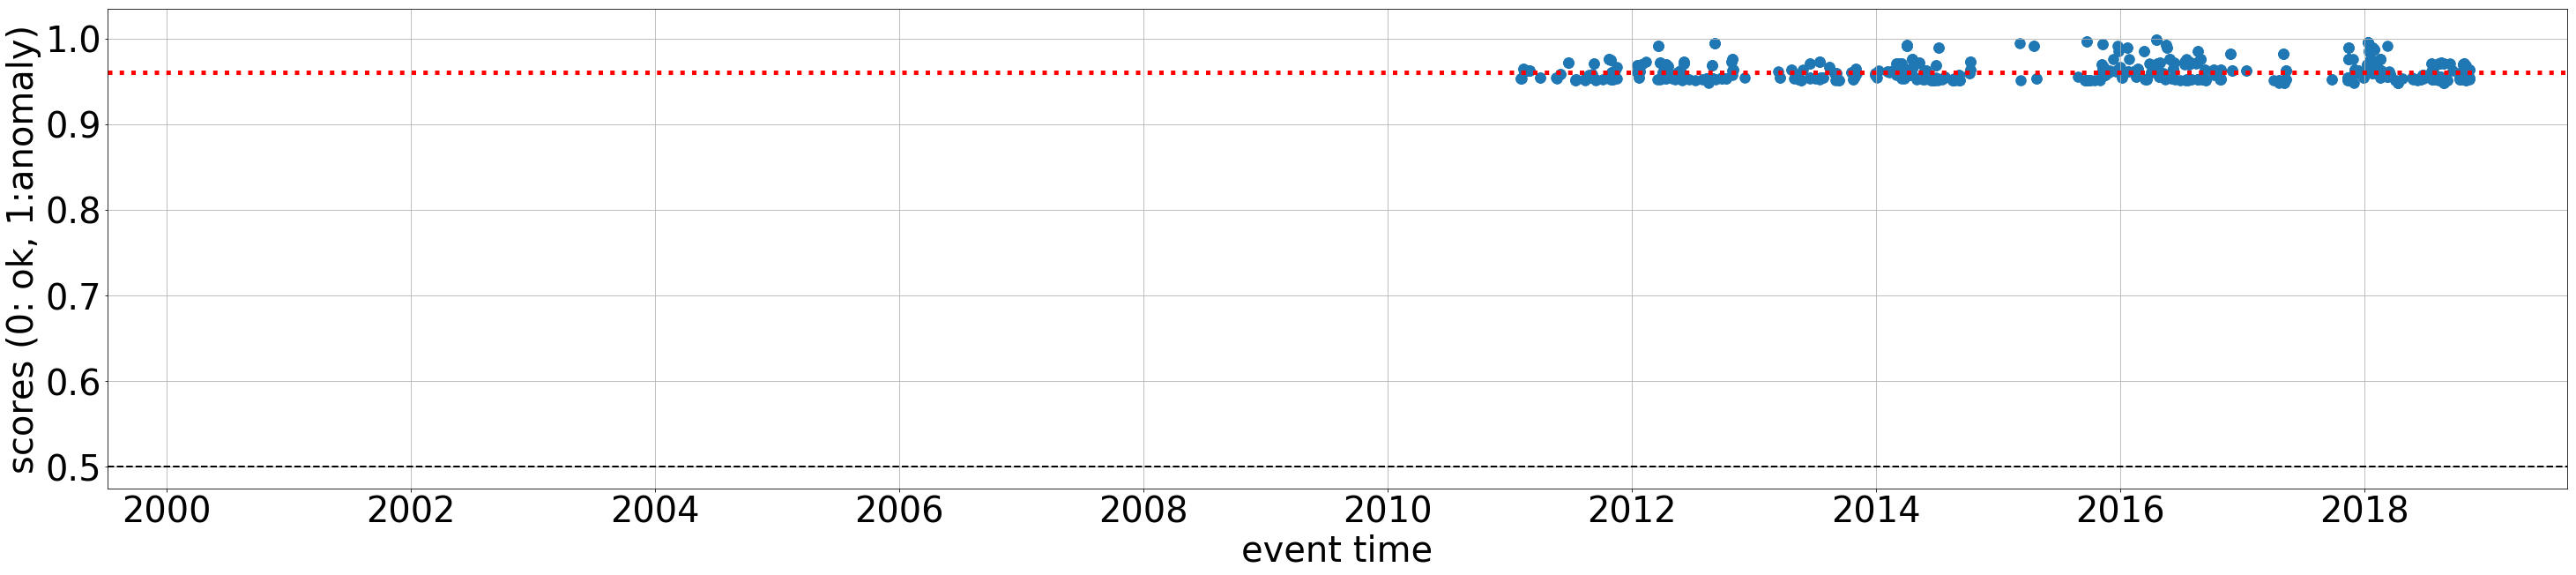

Channel: HL.DION..HH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 24 Label: ok
Misclassified by 9 clfs with median scores:  0.954[0] 0.926[1] 0.855[2] 0.960[3] 0.933[4] 0.867[5] 0.970[6] 0.914[7] 0.861[8]


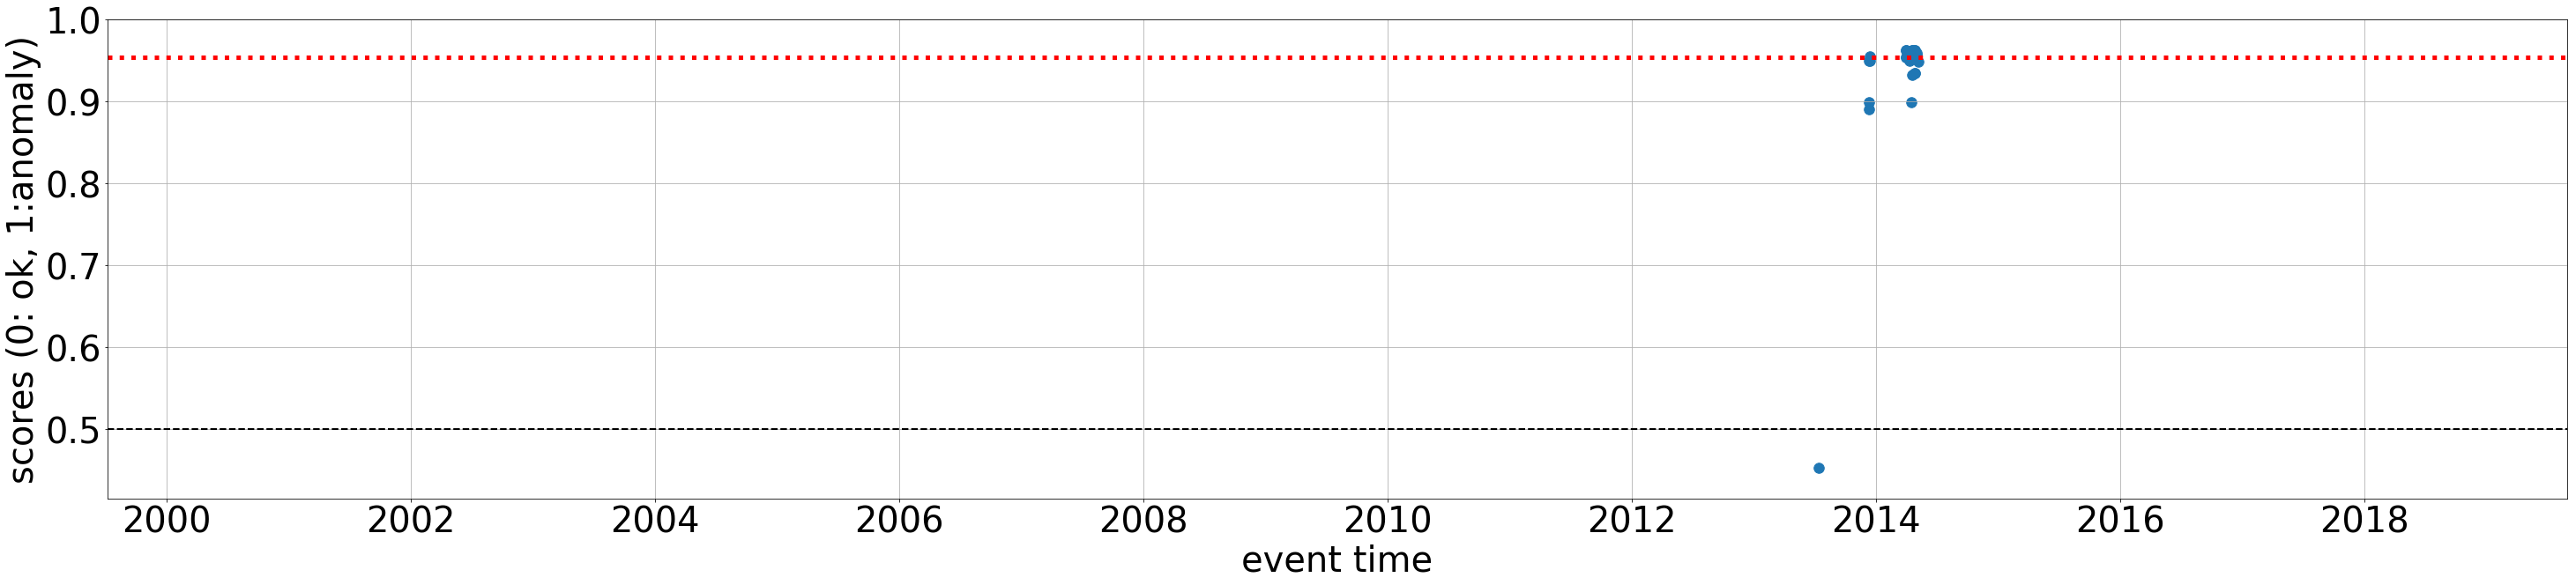

Channel: MC.AIRS..BH? dataset_id: 2 (name: me) Num.segments: 41 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.940[0] 0.876[1] 0.804[2] 0.934[3] 0.879[4] 0.795[5] 0.925[6] 0.884[7] 0.799[8]


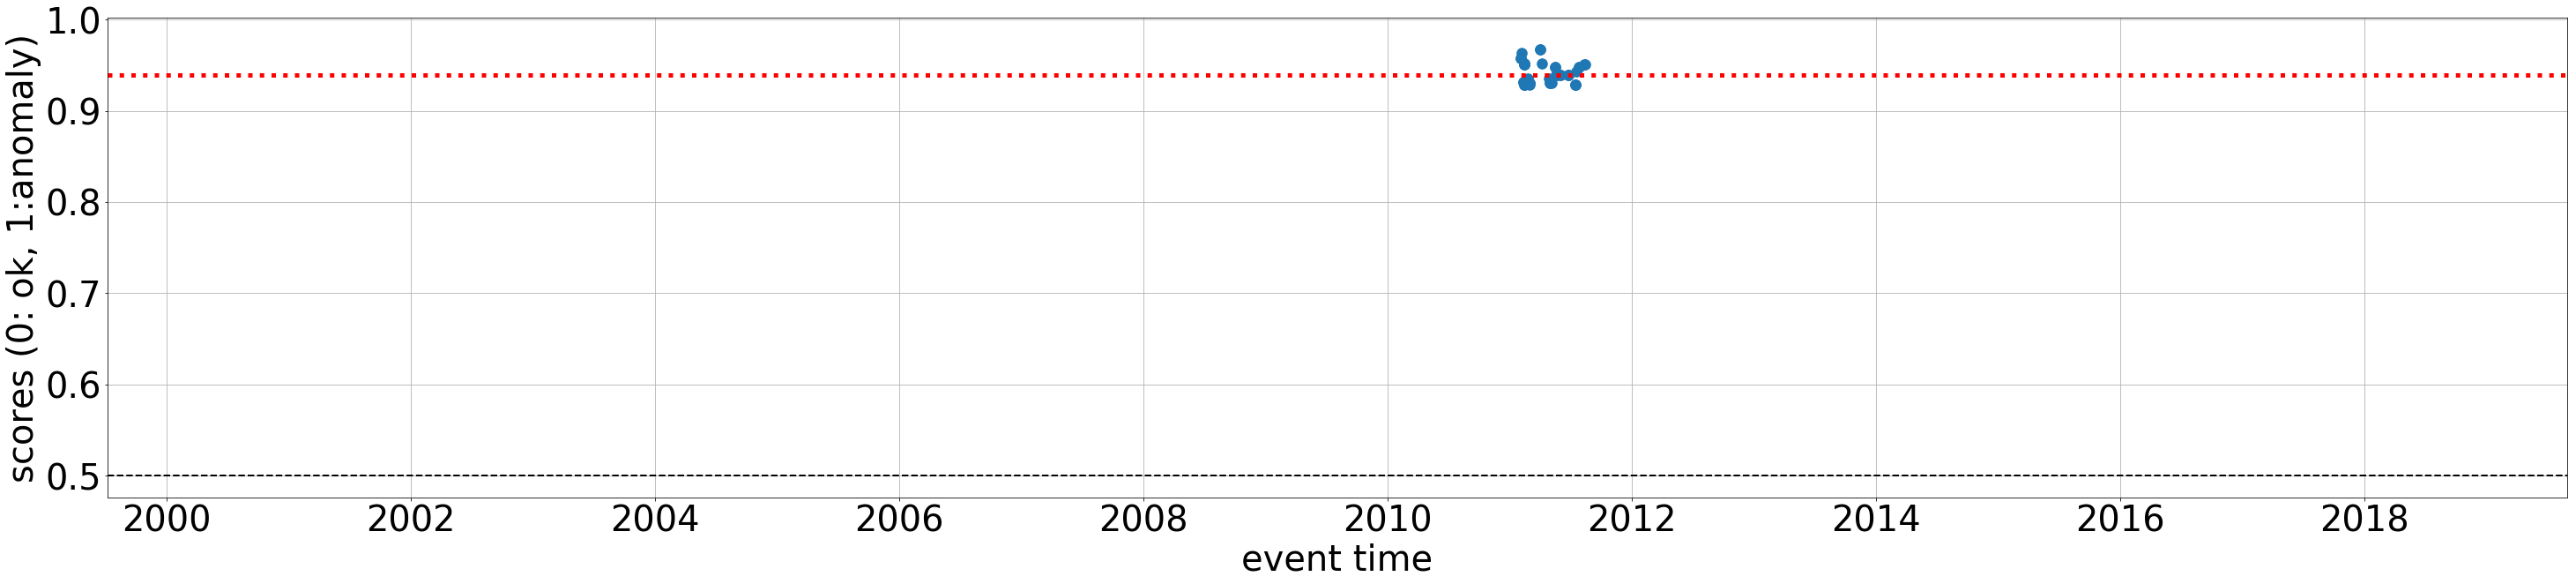

Channel: JP.JWT..BH? dataset_id: 2 (name: me) Num.segments: 1560 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.932[0] 0.898[1] 0.809[2] 0.934[3] 0.906[4] 0.815[5] 0.945[6] 0.879[7] 0.814[8]


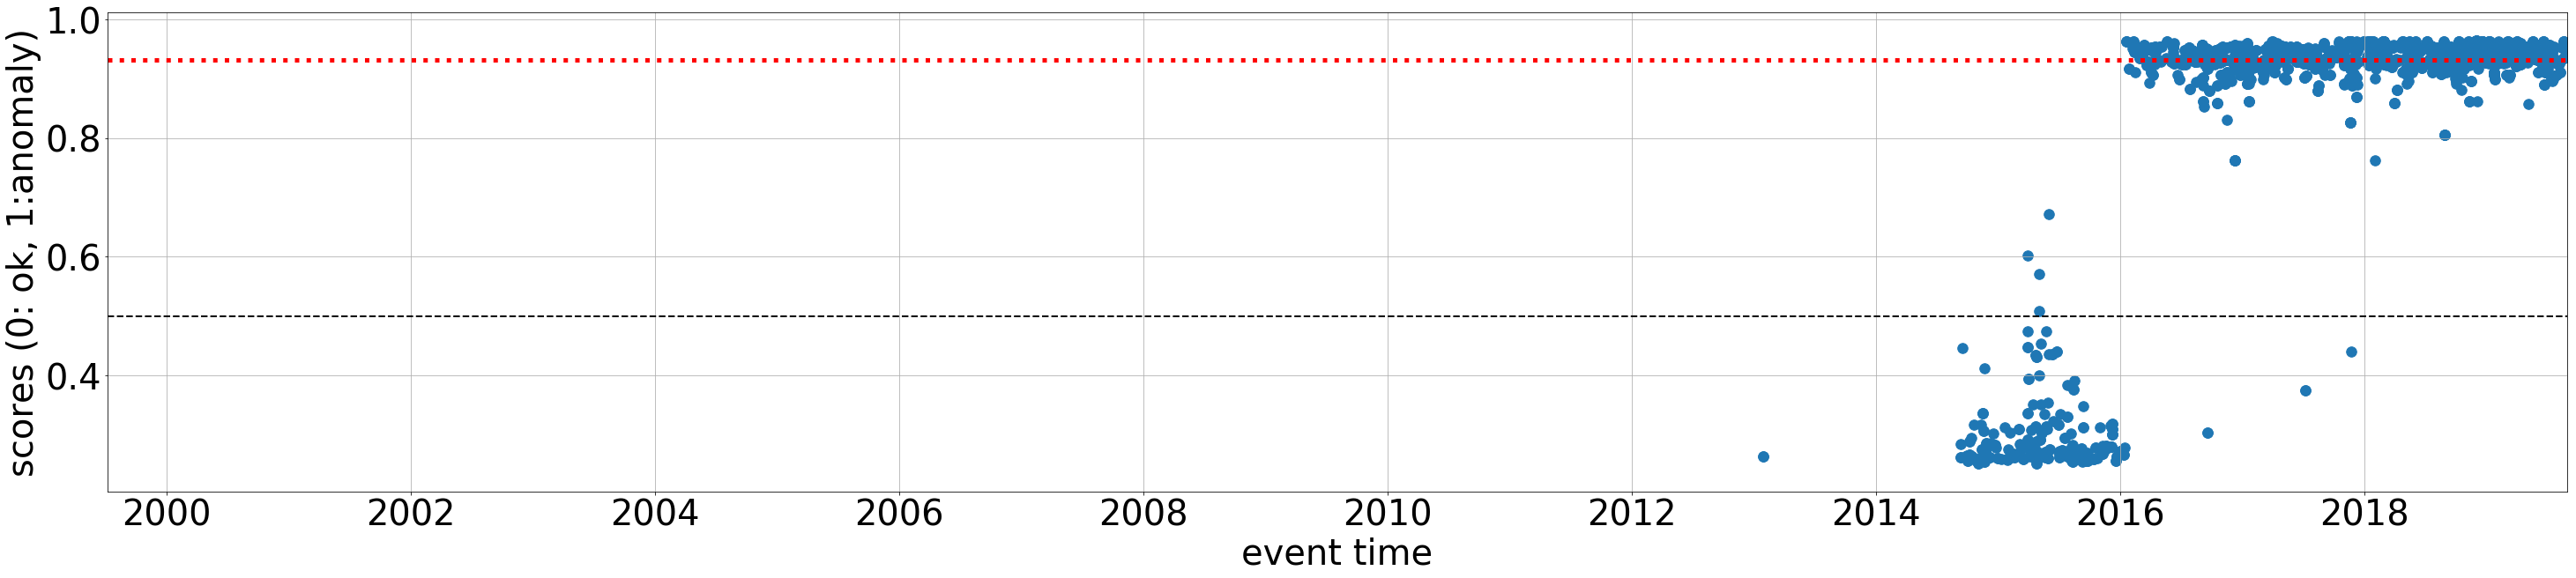

Channel: MC.OLV2..BH? dataset_id: 2 (name: me) Num.segments: 808 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.931[0] 0.867[1] 0.792[2] 0.921[3] 0.868[4] 0.788[5] 0.907[6] 0.872[7] 0.783[8]


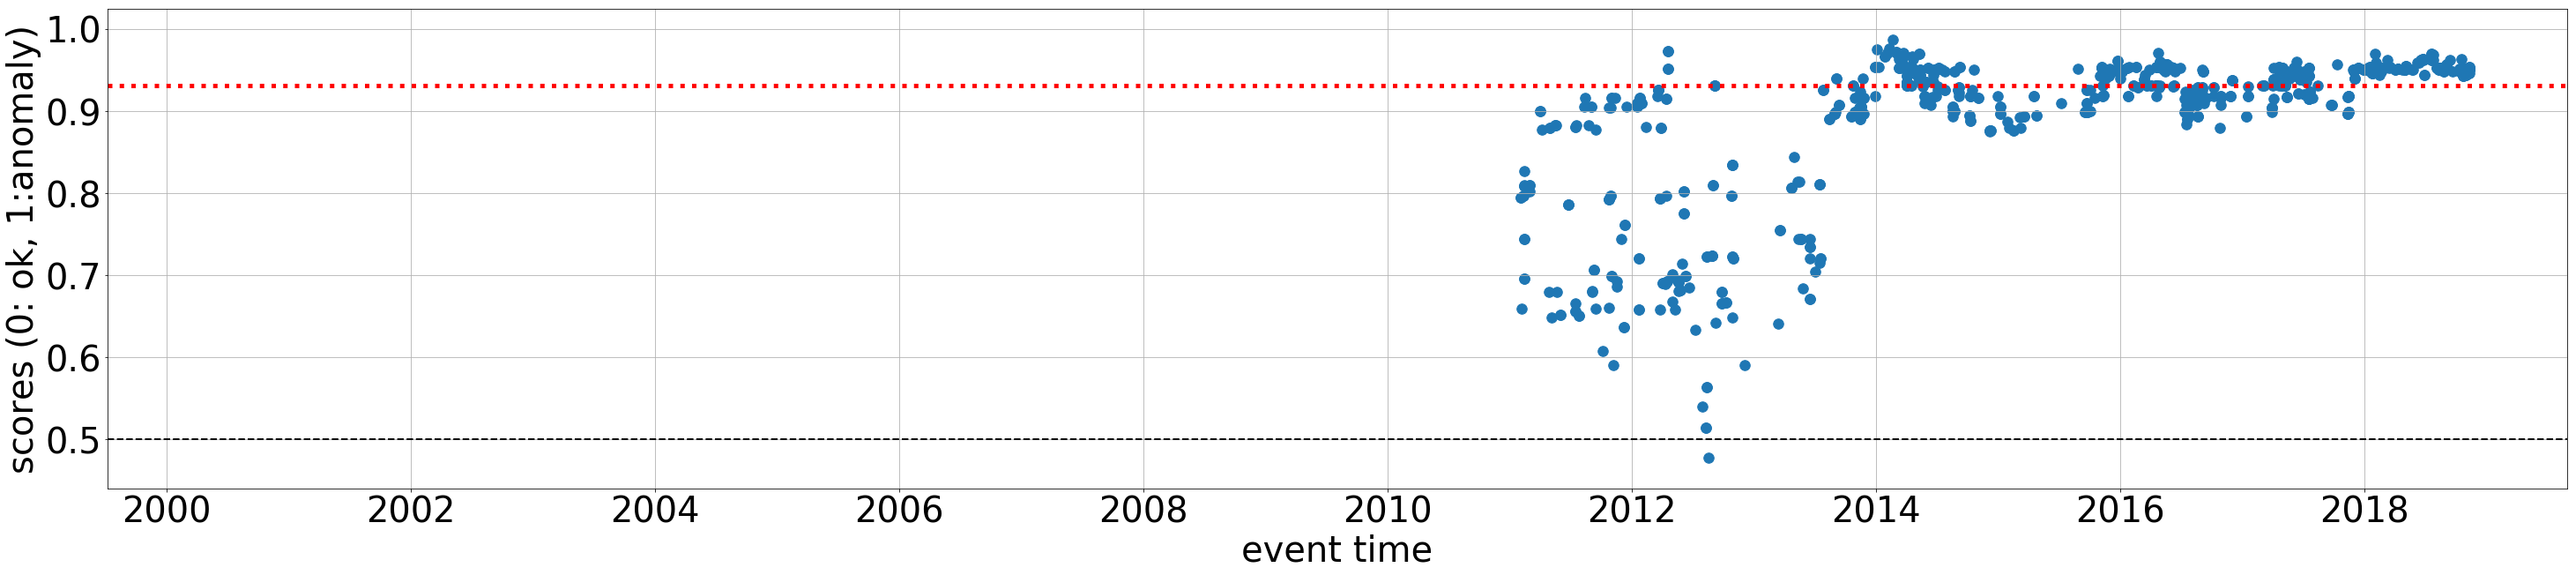

Channel: ND.MARNC.00.BH? dataset_id: 2 (name: me) Num.segments: 1604 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.920[0] 0.872[1] 0.787[2] 0.927[3] 0.881[4] 0.792[5] 0.938[6] 0.857[7] 0.784[8]


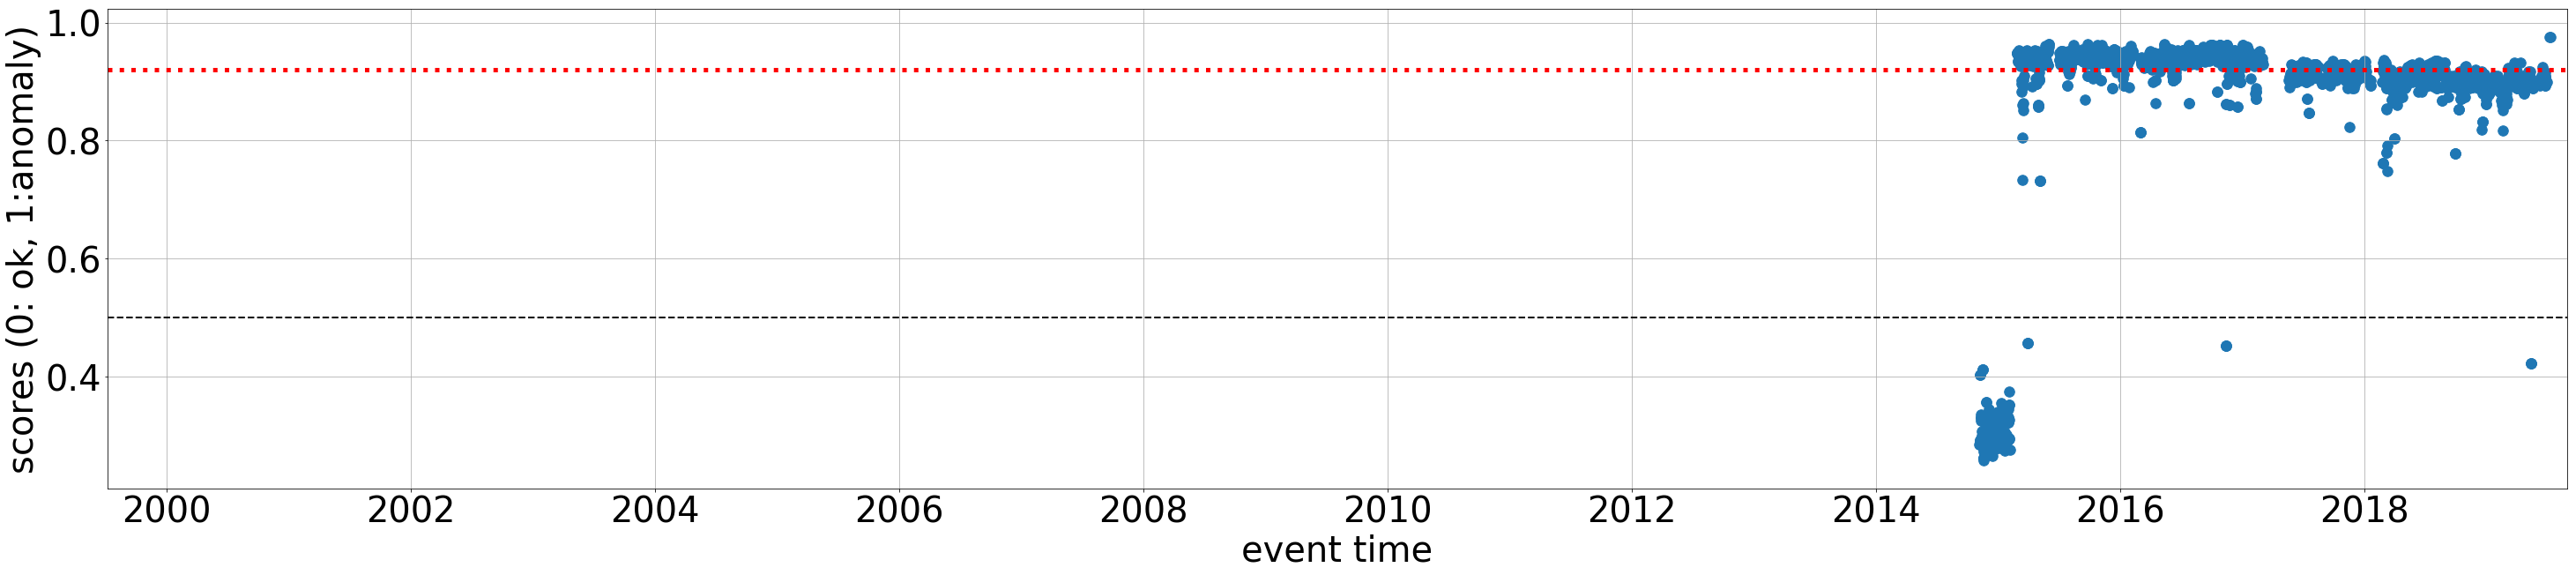

Channel: SL.GOLS..BH? dataset_id: 2 (name: me) Num.segments: 469 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.916[0] 0.830[1] 0.757[2] 0.908[3] 0.838[4] 0.737[5] 0.894[6] 0.850[7] 0.725[8]


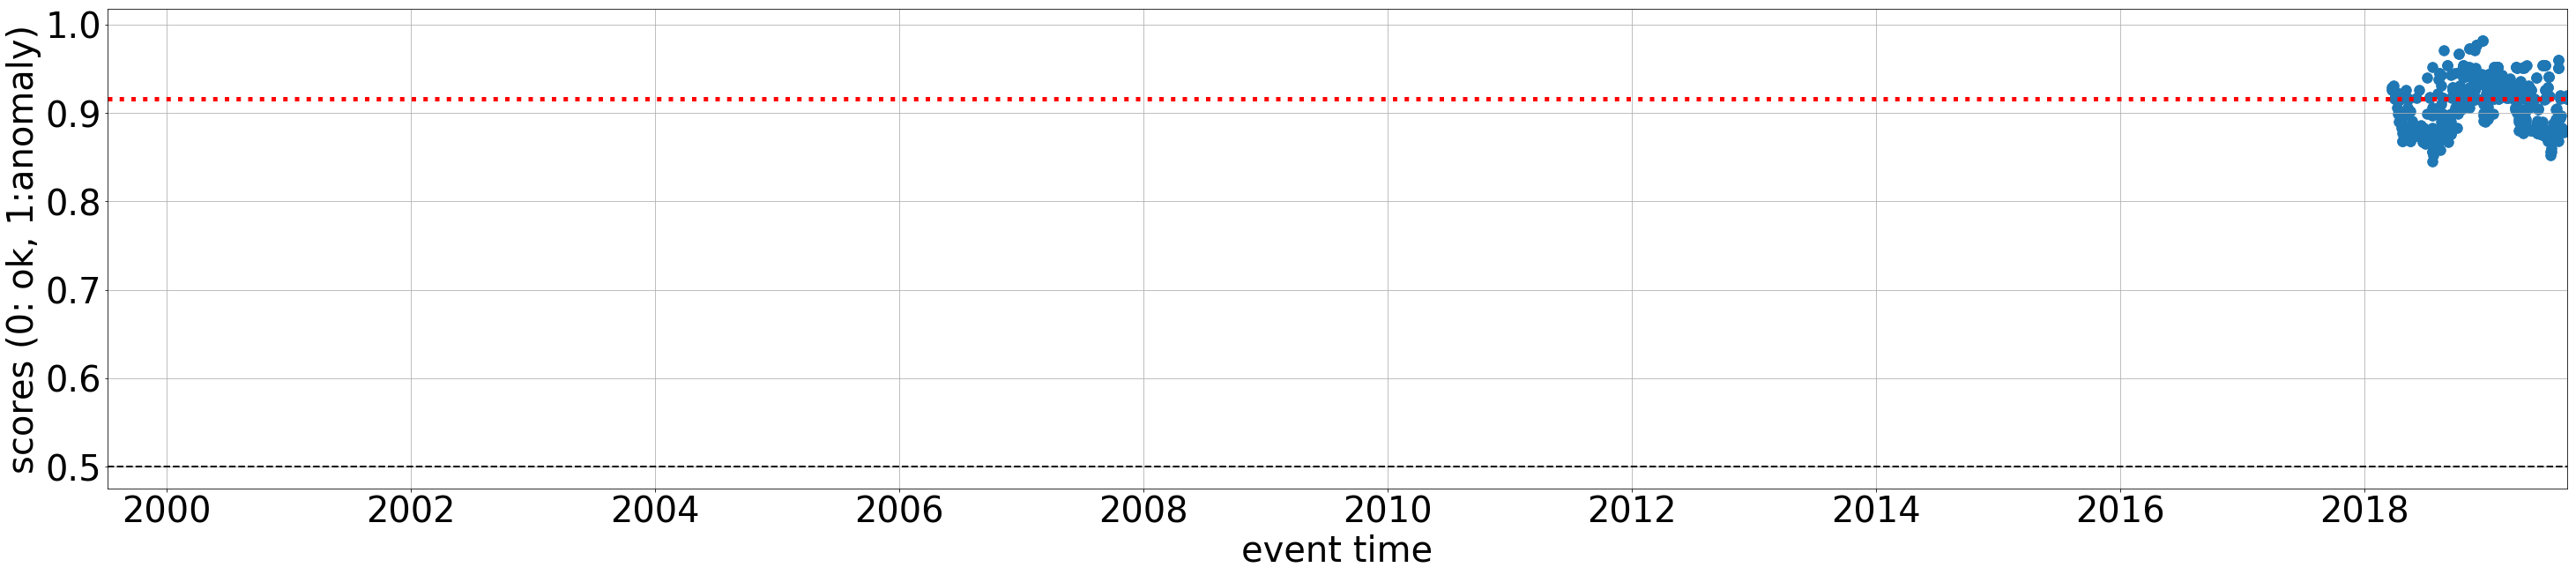

Channel: IV.MABI..HH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 18 Label: ok
Misclassified by 9 clfs with median scores:  0.910[0] 0.858[1] 0.782[2] 0.915[3] 0.869[4] 0.791[5] 0.934[6] 0.845[7] 0.788[8]


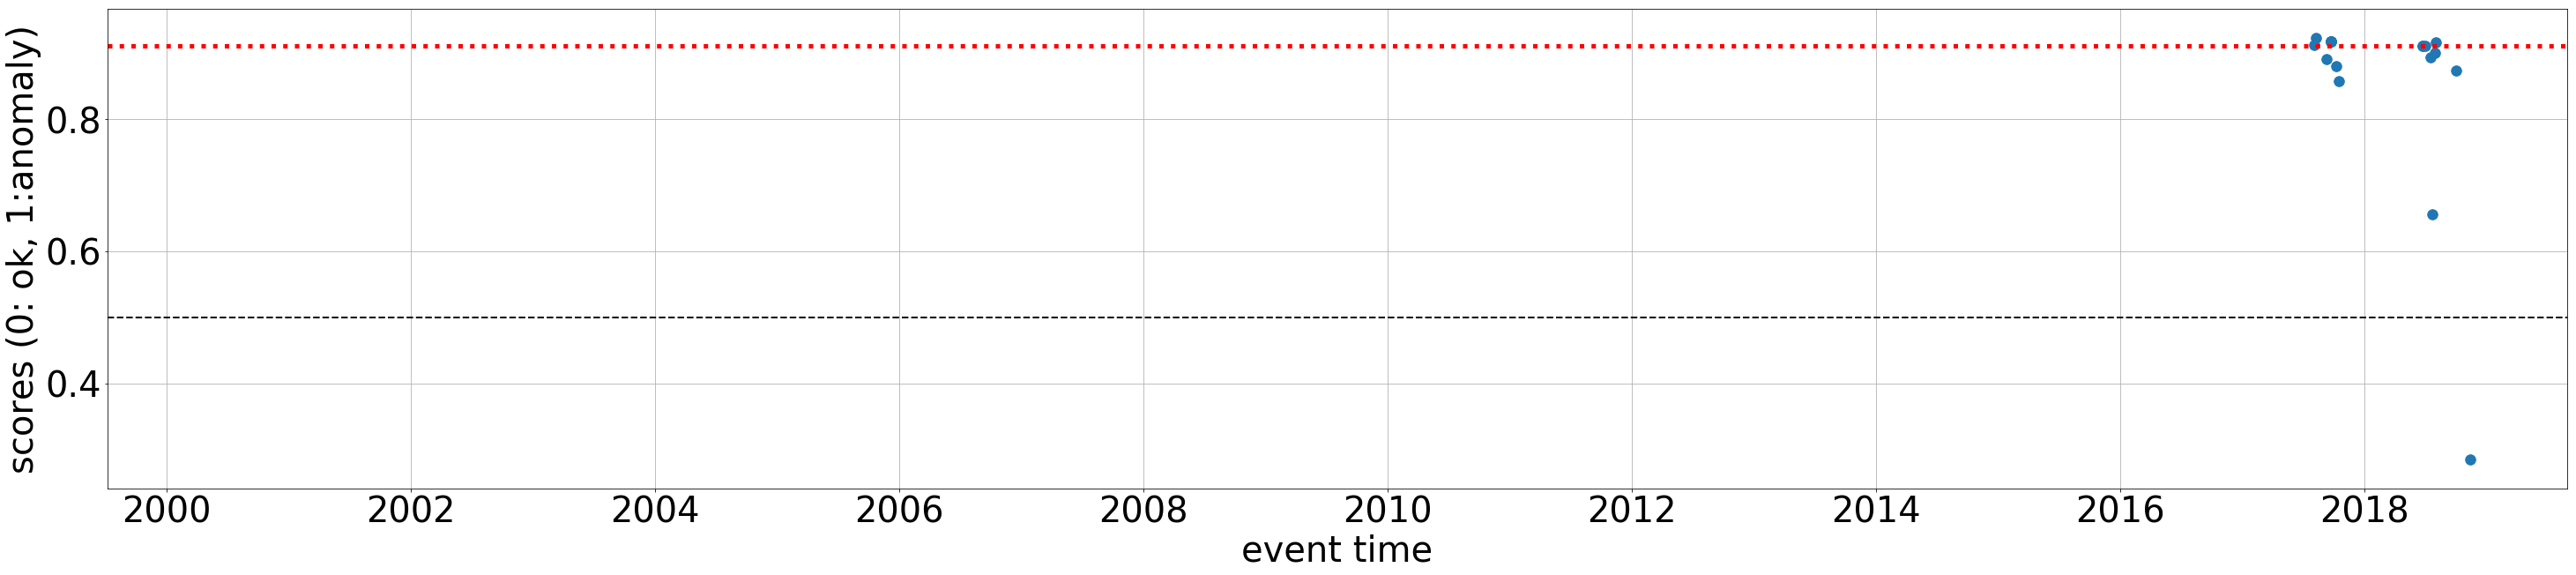

Channel: CH.MMK..HG? dataset_id: 1 (name: s2s_2019_03) Num.segments: 16 Label: ok
Misclassified by 9 clfs with median scores:  0.908[0] 0.820[1] 0.747[2] 0.900[3] 0.828[4] 0.735[5] 0.894[6] 0.836[7] 0.722[8]


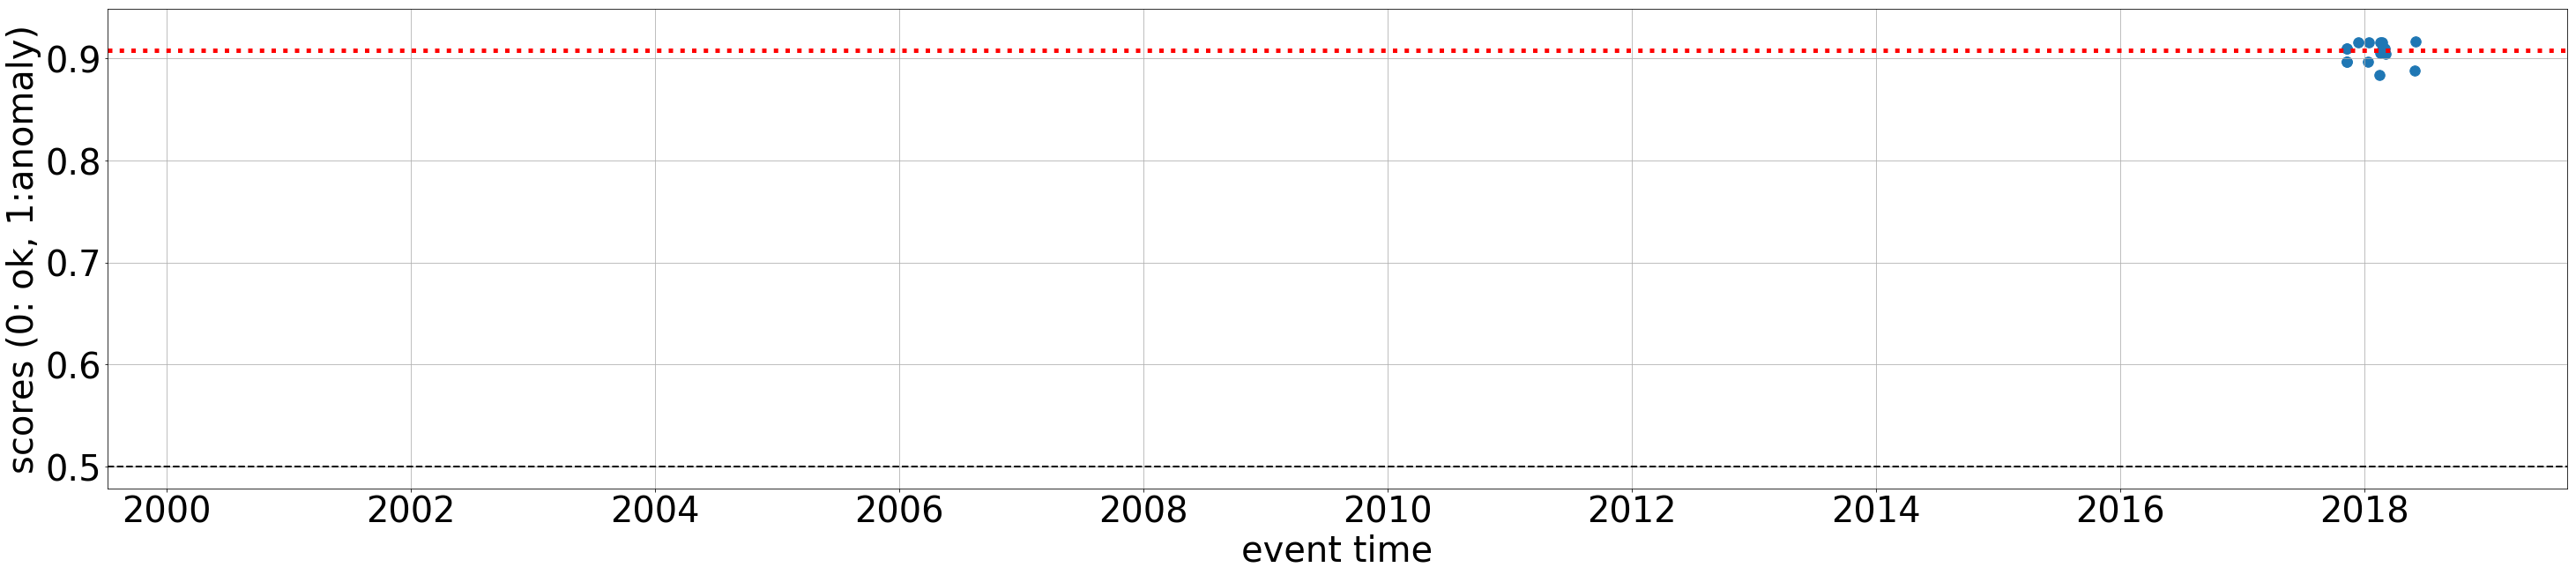

Channel: HP.LTHK..HH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 2 Label: ok
Misclassified by 9 clfs with median scores:  0.901[0] 0.843[1] 0.780[2] 0.907[3] 0.858[4] 0.776[5] 0.918[6] 0.837[7] 0.771[8]


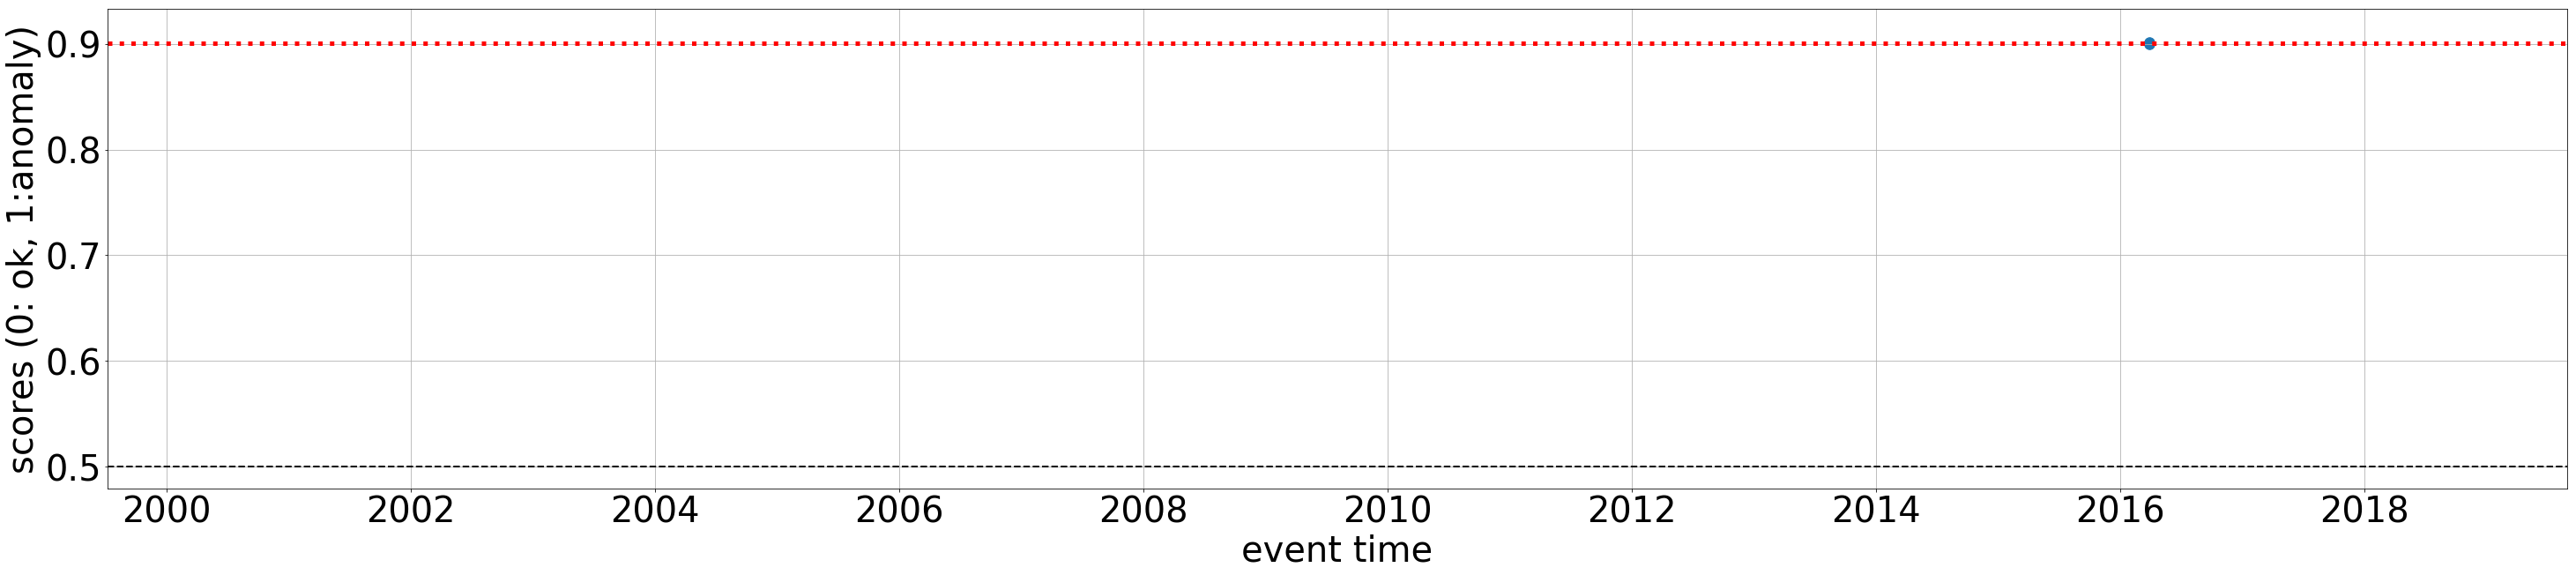

Channel: TR.SKI..BH? dataset_id: 2 (name: me) Num.segments: 120 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.900[0] 0.842[1] 0.779[2] 0.907[3] 0.858[4] 0.771[5] 0.918[6] 0.836[7] 0.763[8]


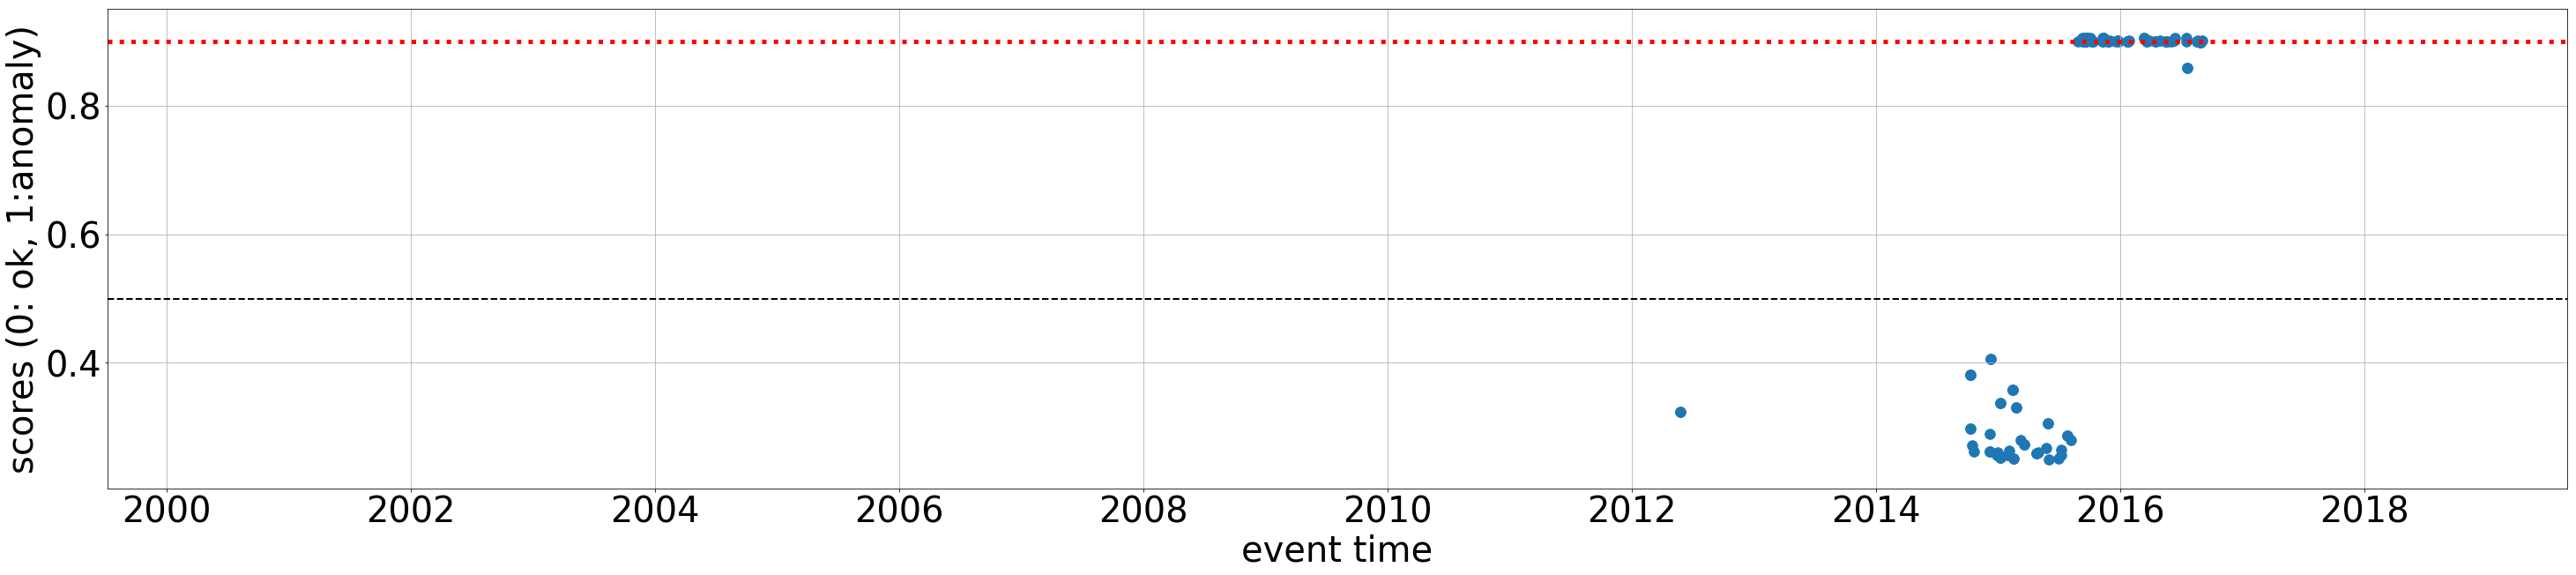

Channel: CL.ROD3.01.EH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 22 Label: ok
Misclassified by 9 clfs with median scores:  0.898[0] 0.853[1] 0.778[2] 0.898[3] 0.864[4] 0.781[5] 0.902[6] 0.838[7] 0.778[8]


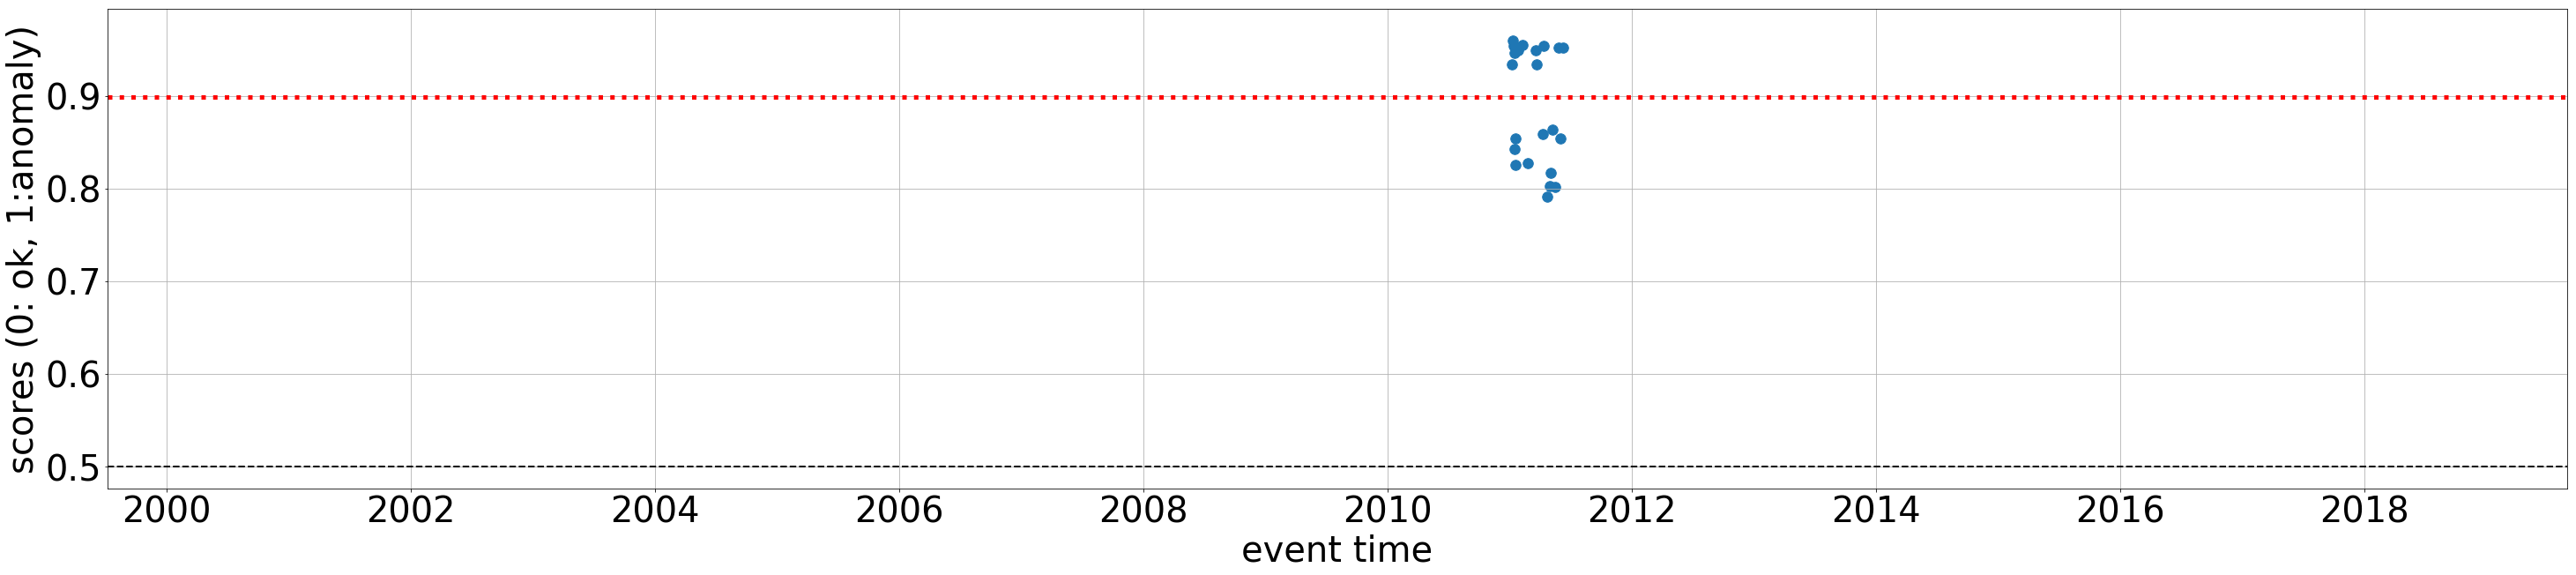

Channel: AF.BOBN..BH? dataset_id: 2 (name: me) Num.segments: 190 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.891[0] 0.827[1] 0.760[2] 0.890[3] 0.846[4] 0.769[5] 0.911[6] 0.828[7] 0.756[8]


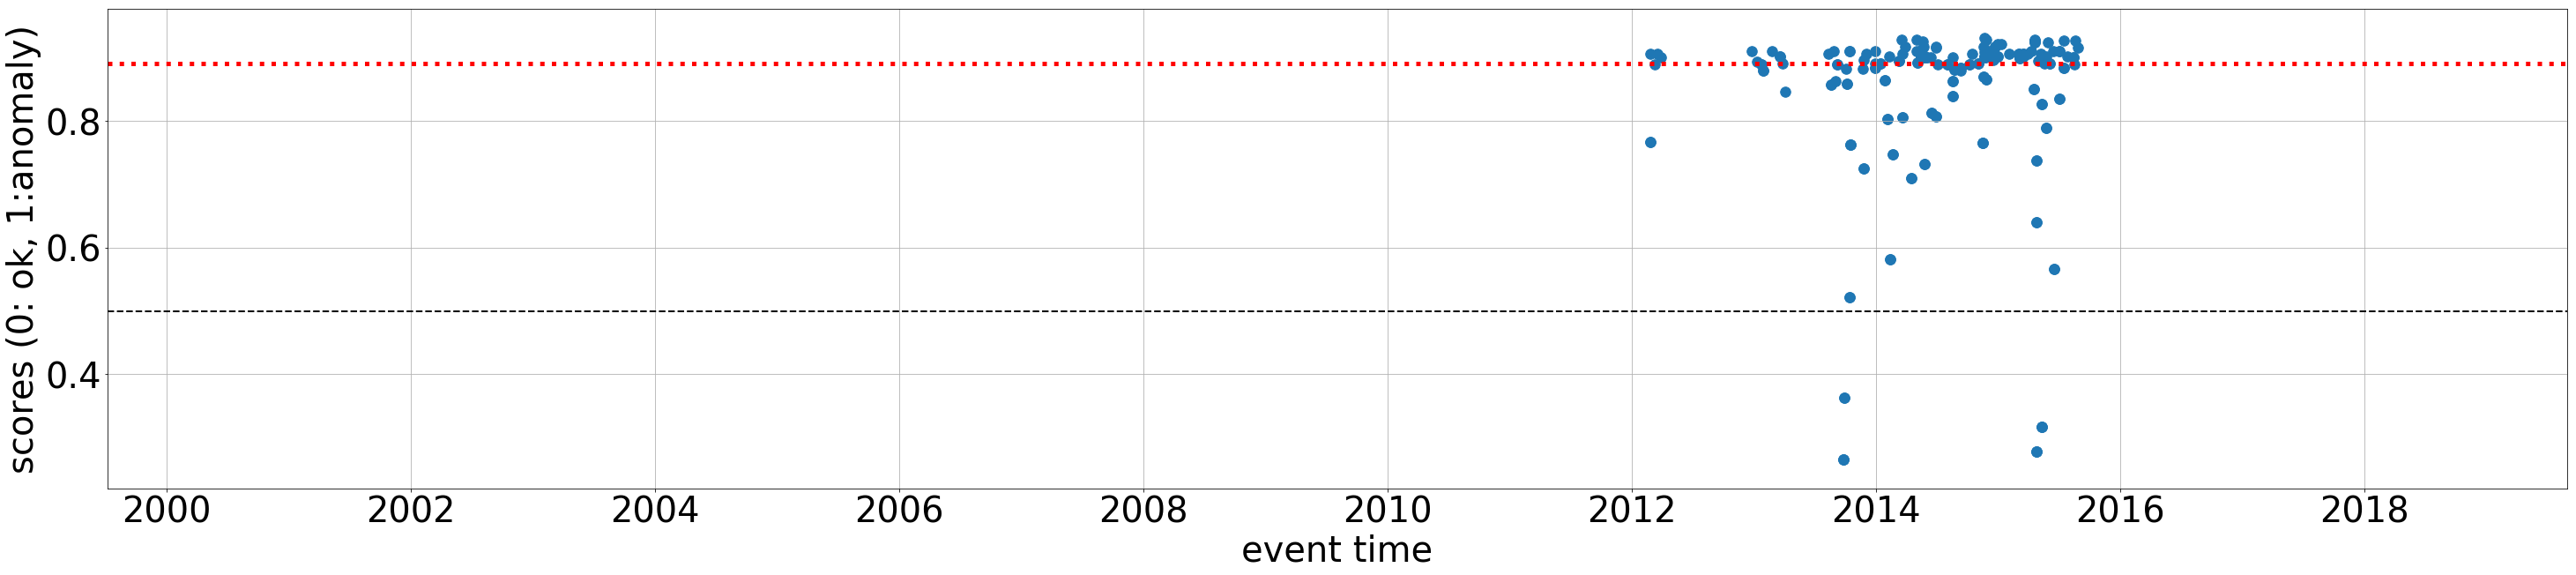

Channel: IS.GEM..BH? dataset_id: 2 (name: me) Num.segments: 1644 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.890[0] 0.825[1] 0.759[2] 0.889[3] 0.843[4] 0.769[5] 0.909[6] 0.827[7] 0.756[8]


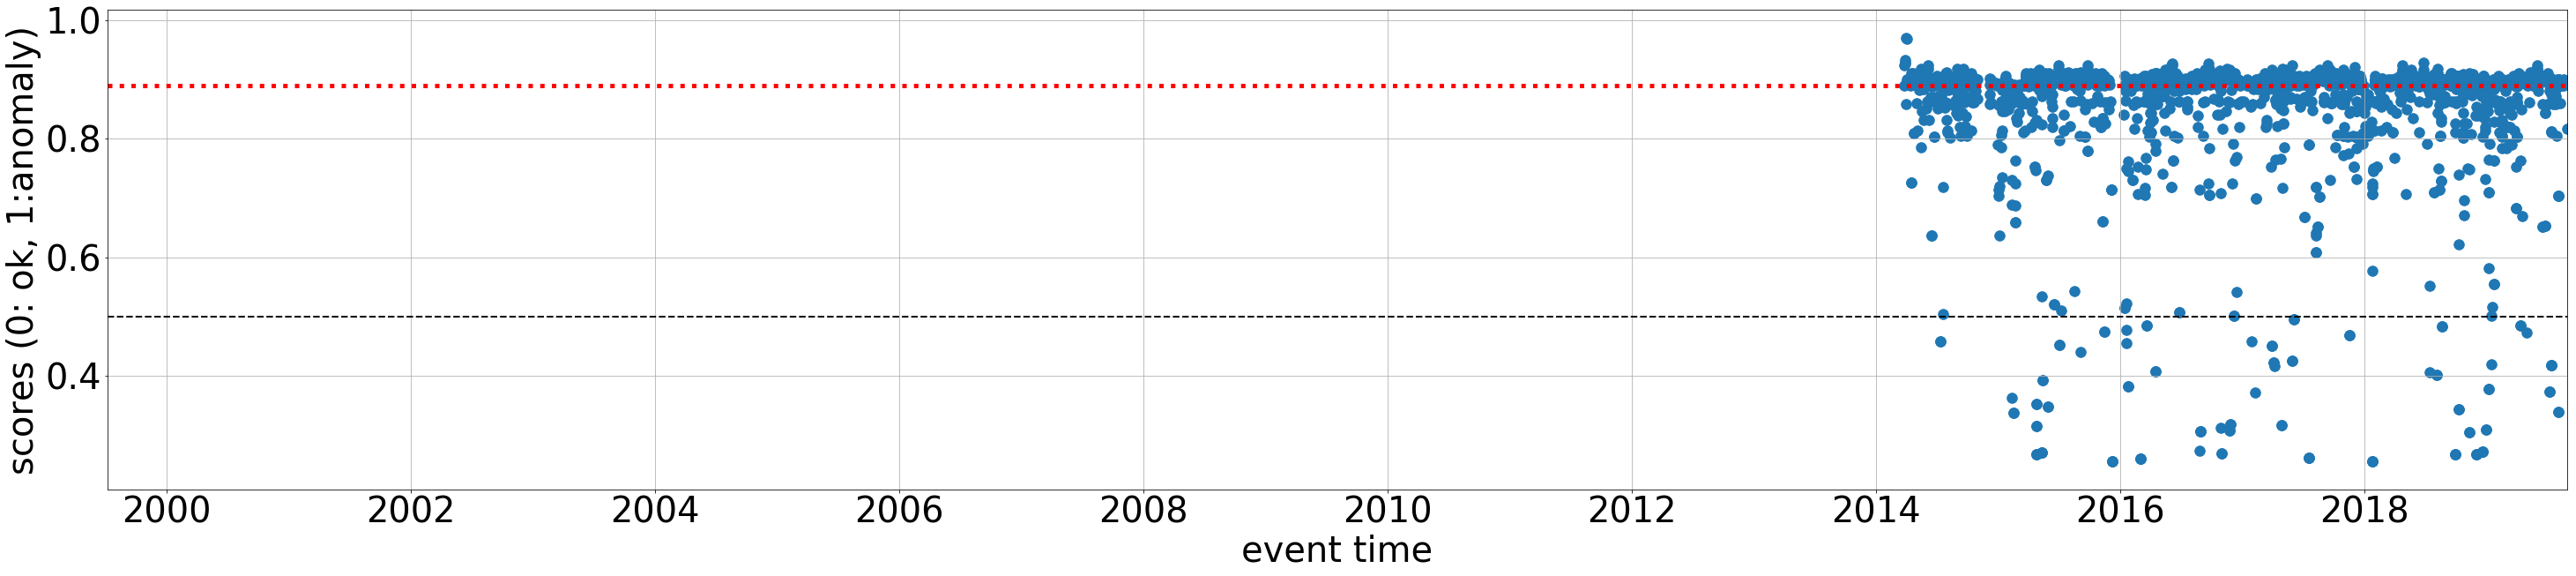

Channel: SL.MOZS..BH? dataset_id: 2 (name: me) Num.segments: 297 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.883[0] 0.790[1] 0.736[2] 0.872[3] 0.794[4] 0.715[5] 0.871[6] 0.805[7] 0.707[8]


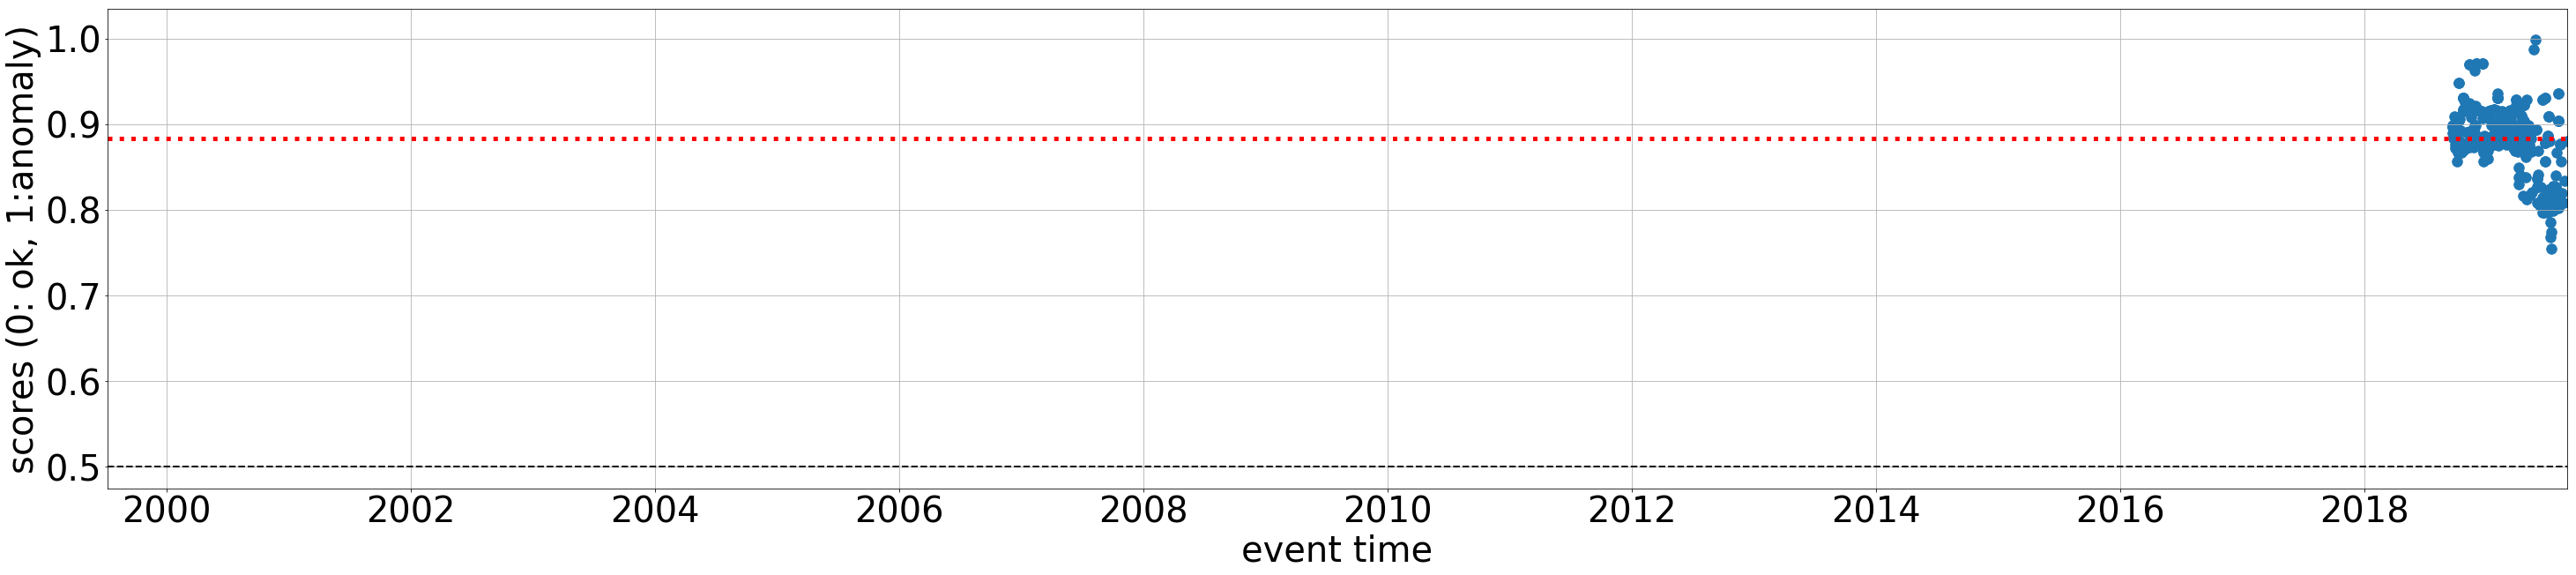

Channel: CH.MMK..HG? dataset_id: 1 (name: s2s_2019_03) Num.segments: 6 Label: ok
Misclassified by 9 clfs with median scores:  0.881[0] 0.784[1] 0.728[2] 0.869[3] 0.787[4] 0.708[5] 0.869[6] 0.792[7] 0.700[8]


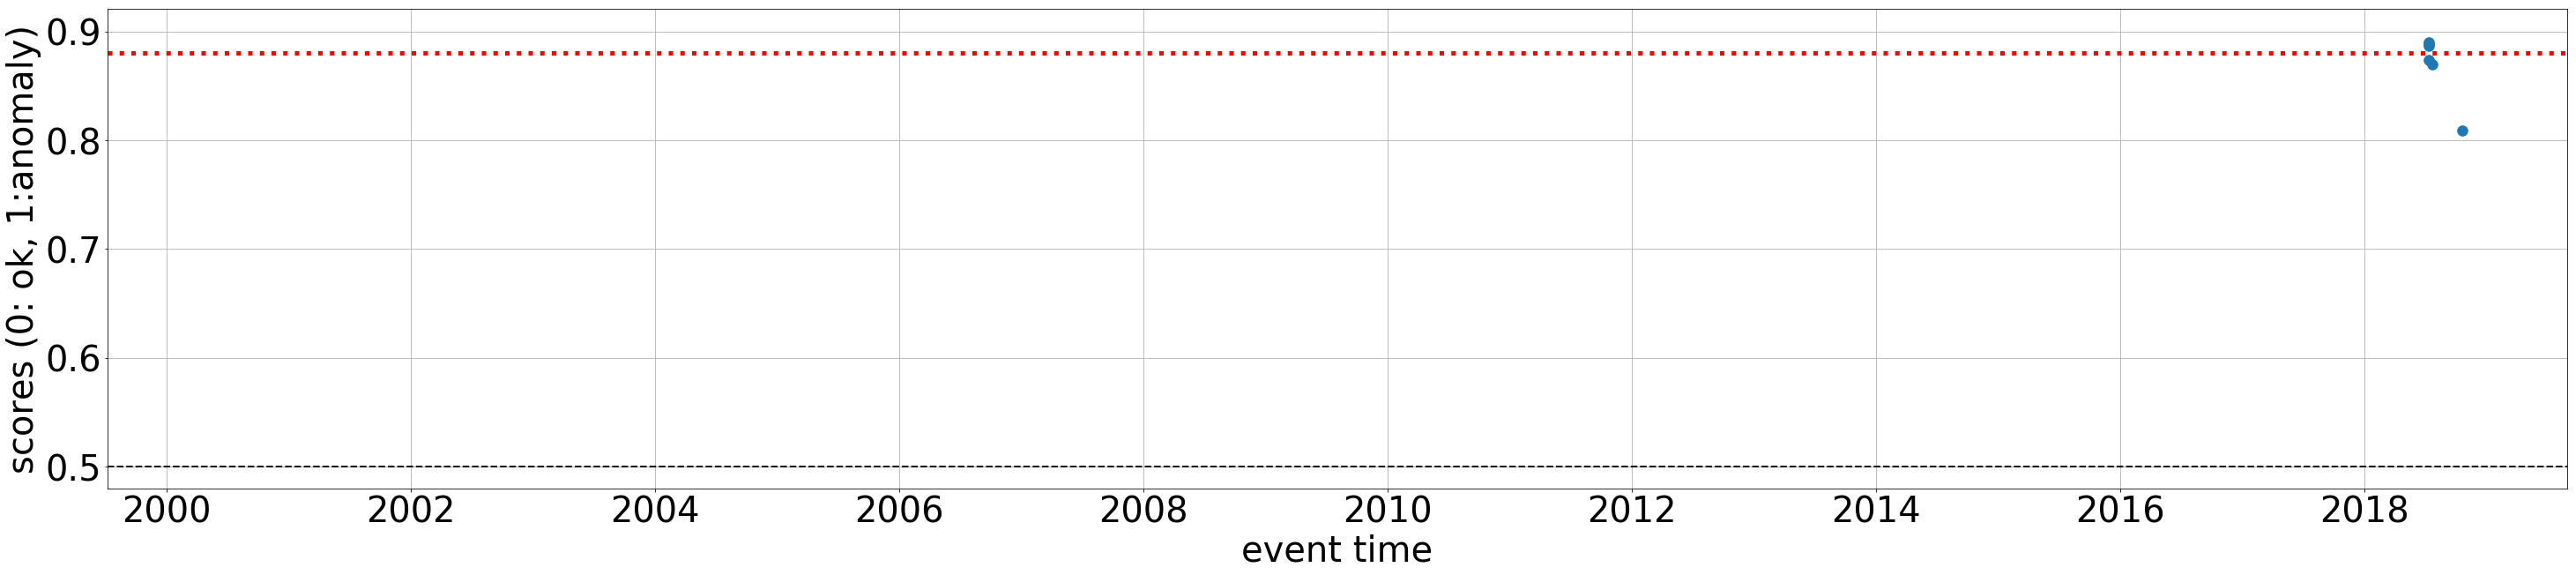

Channel: SL.VOJS..BH? dataset_id: 2 (name: me) Num.segments: 244 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.880[0] 0.788[1] 0.735[2] 0.870[3] 0.790[4] 0.713[5] 0.871[6] 0.802[7] 0.704[8]


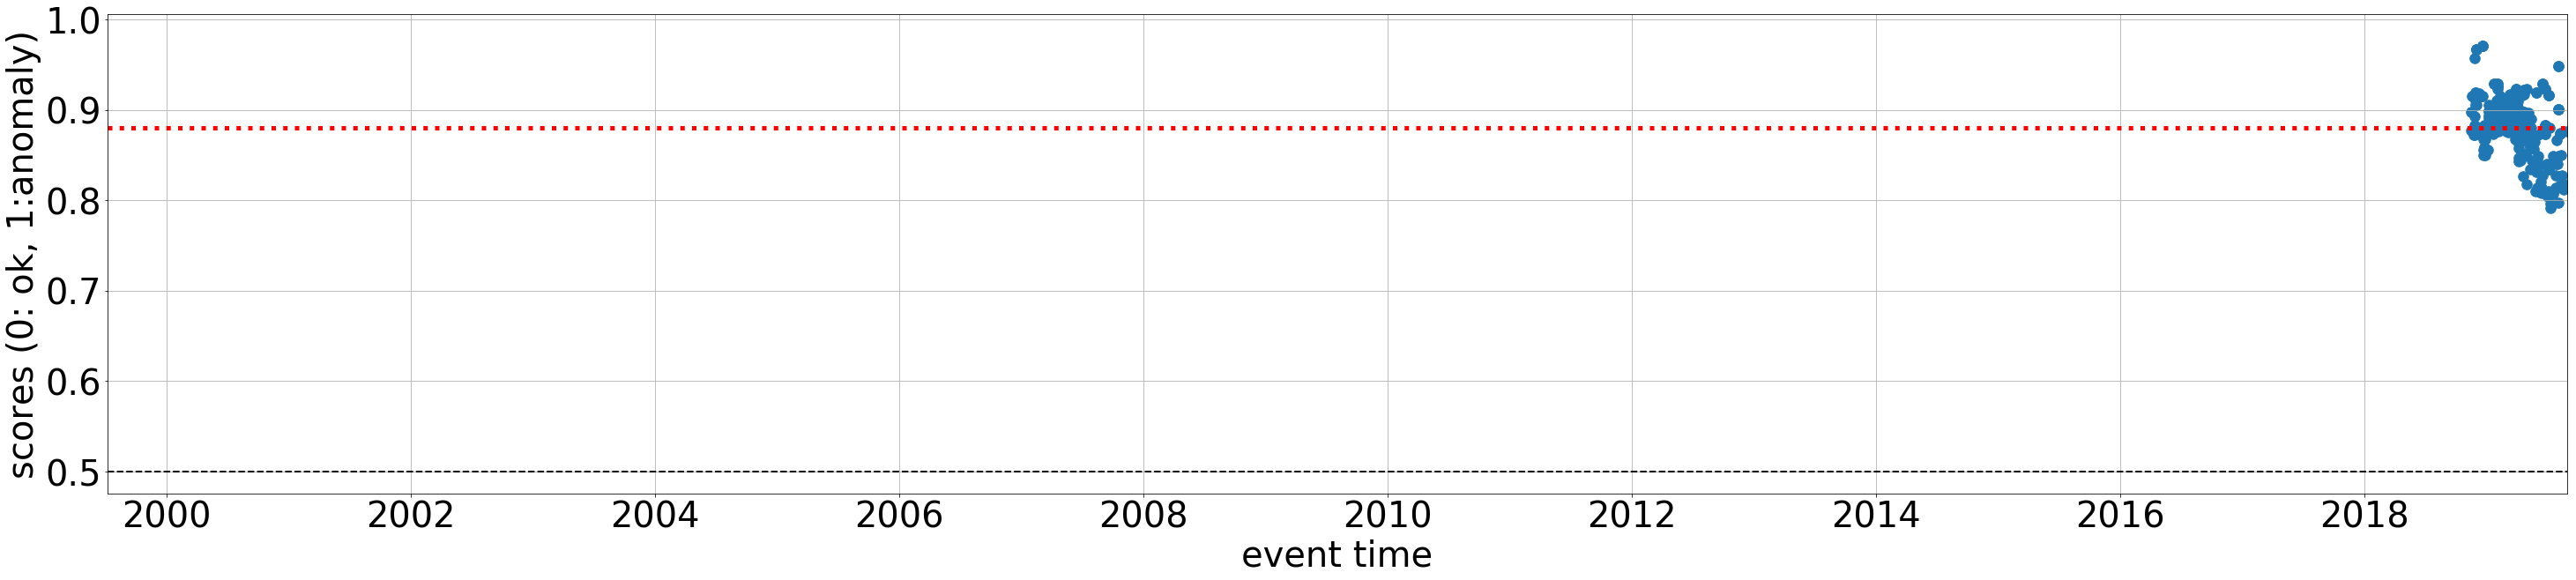

Channel: UD.MI29..BH? dataset_id: 2 (name: me) Num.segments: 69 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.880[0] 0.787[1] 0.736[2] 0.868[3] 0.792[4] 0.711[5] 0.871[6] 0.805[7] 0.700[8]


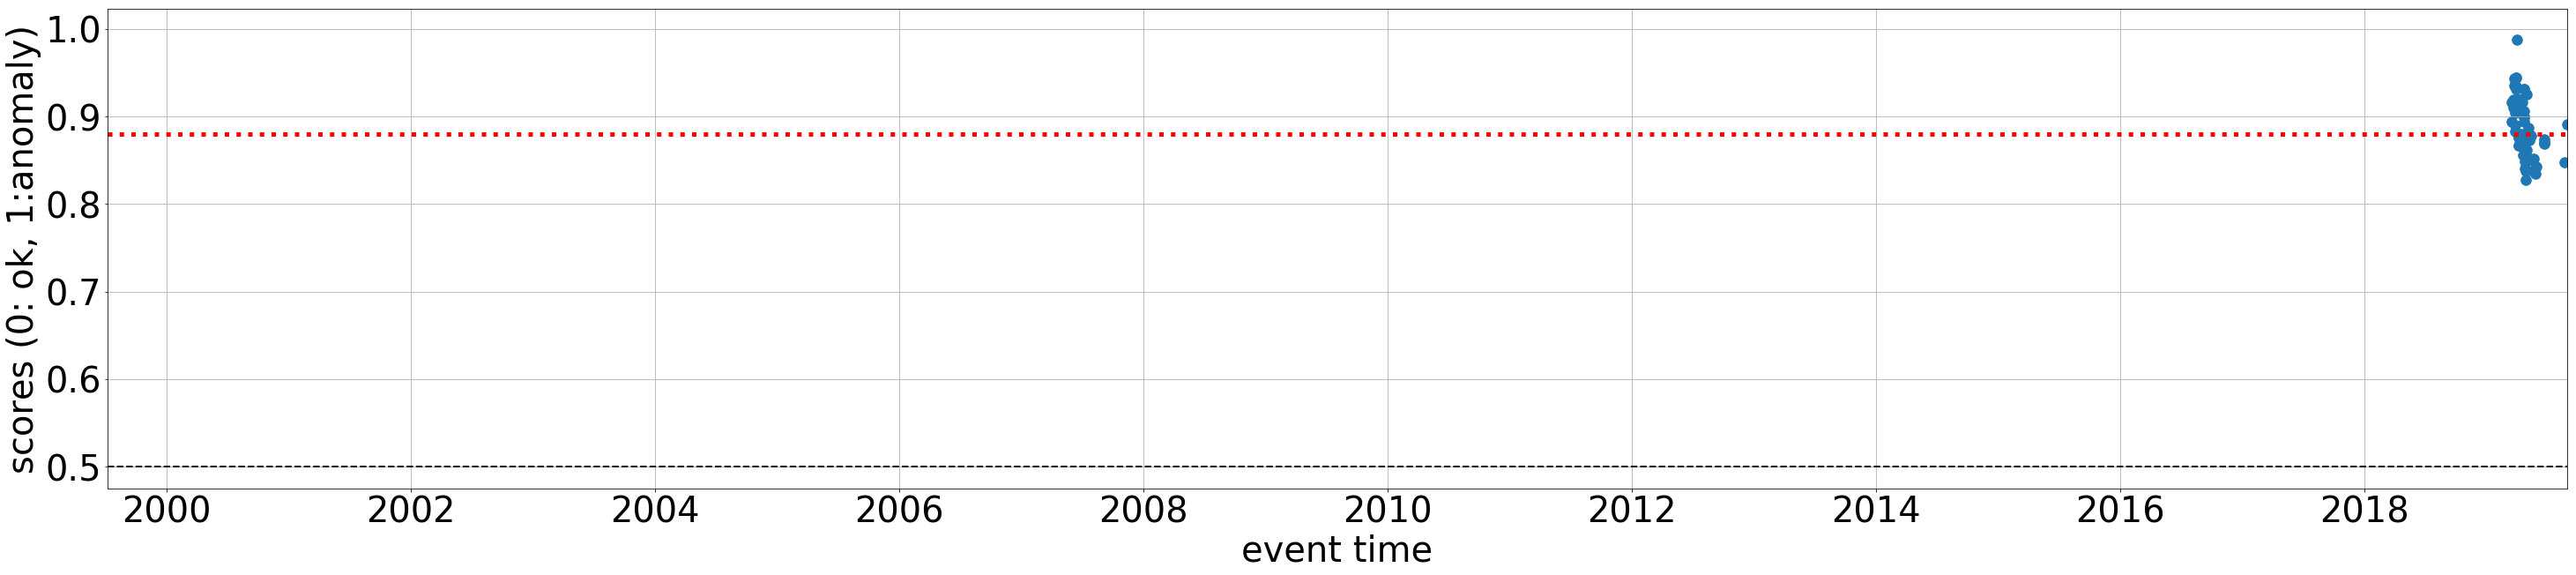

Channel: MC.GERD..BH? dataset_id: 2 (name: me) Num.segments: 754 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.879[0] 0.787[1] 0.734[2] 0.867[3] 0.791[4] 0.712[5] 0.870[6] 0.802[7] 0.696[8]


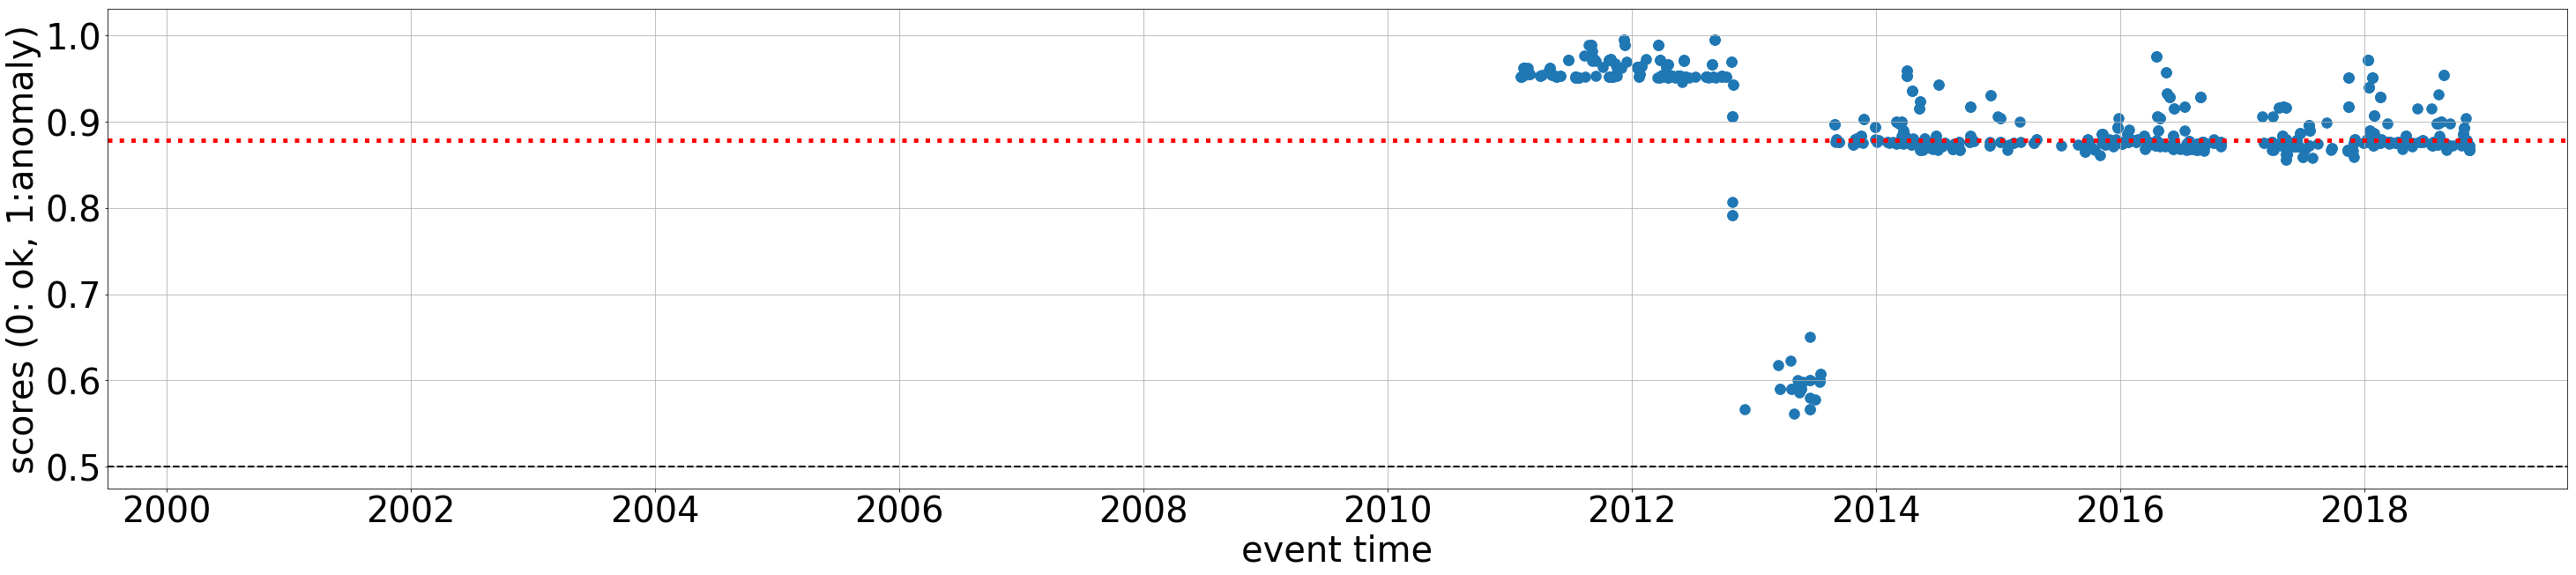

Channel: SL.GBRS..BH? dataset_id: 2 (name: me) Num.segments: 577 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.877[0] 0.784[1] 0.731[2] 0.866[3] 0.789[4] 0.710[5] 0.866[6] 0.800[7] 0.693[8]


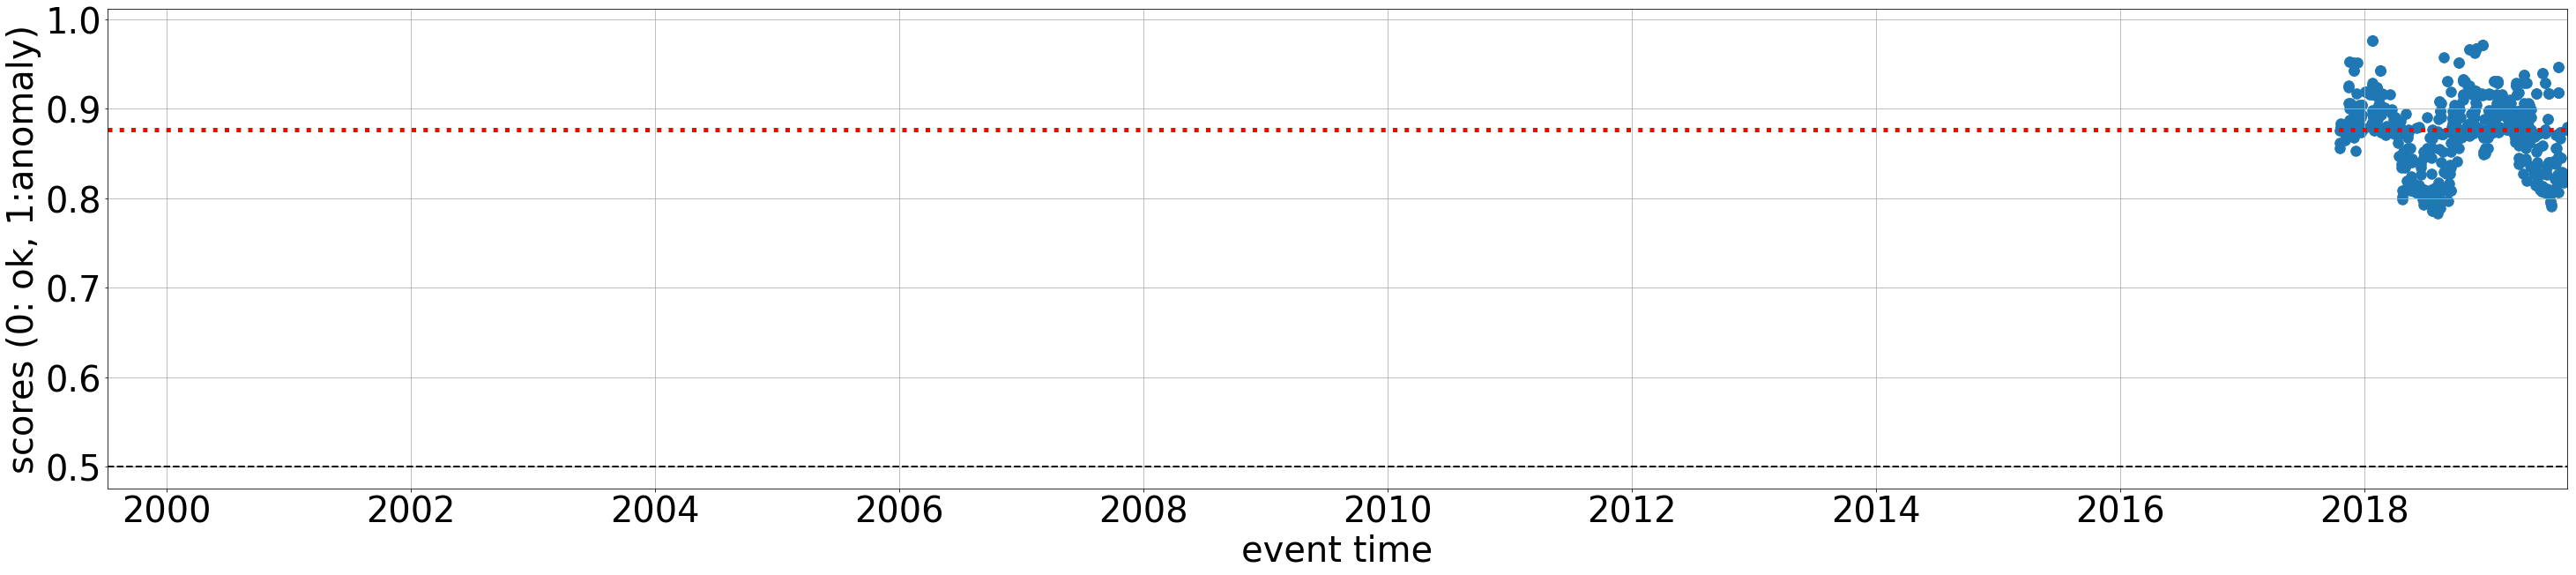

Channel: SL.GCIS..BH? dataset_id: 2 (name: me) Num.segments: 607 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.876[0] 0.779[1] 0.721[2] 0.865[3] 0.786[4] 0.702[5] 0.866[6] 0.790[7] 0.693[8]


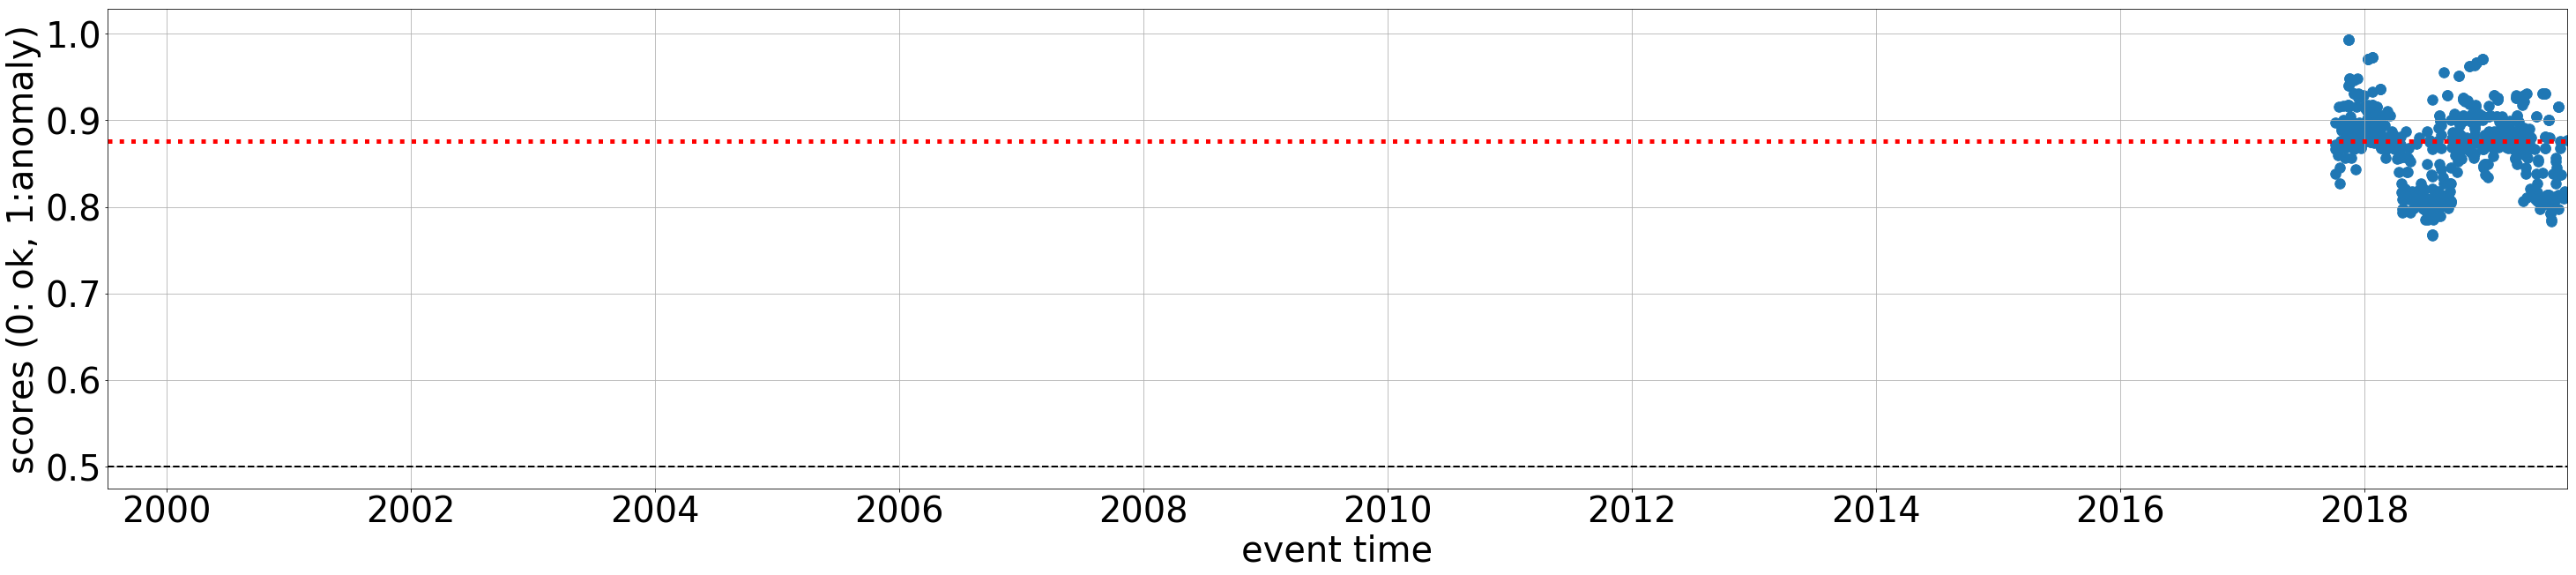

Channel: SL.ROBS..BH? dataset_id: 2 (name: me) Num.segments: 550 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.876[0] 0.779[1] 0.722[2] 0.865[3] 0.786[4] 0.703[5] 0.866[6] 0.791[7] 0.691[8]


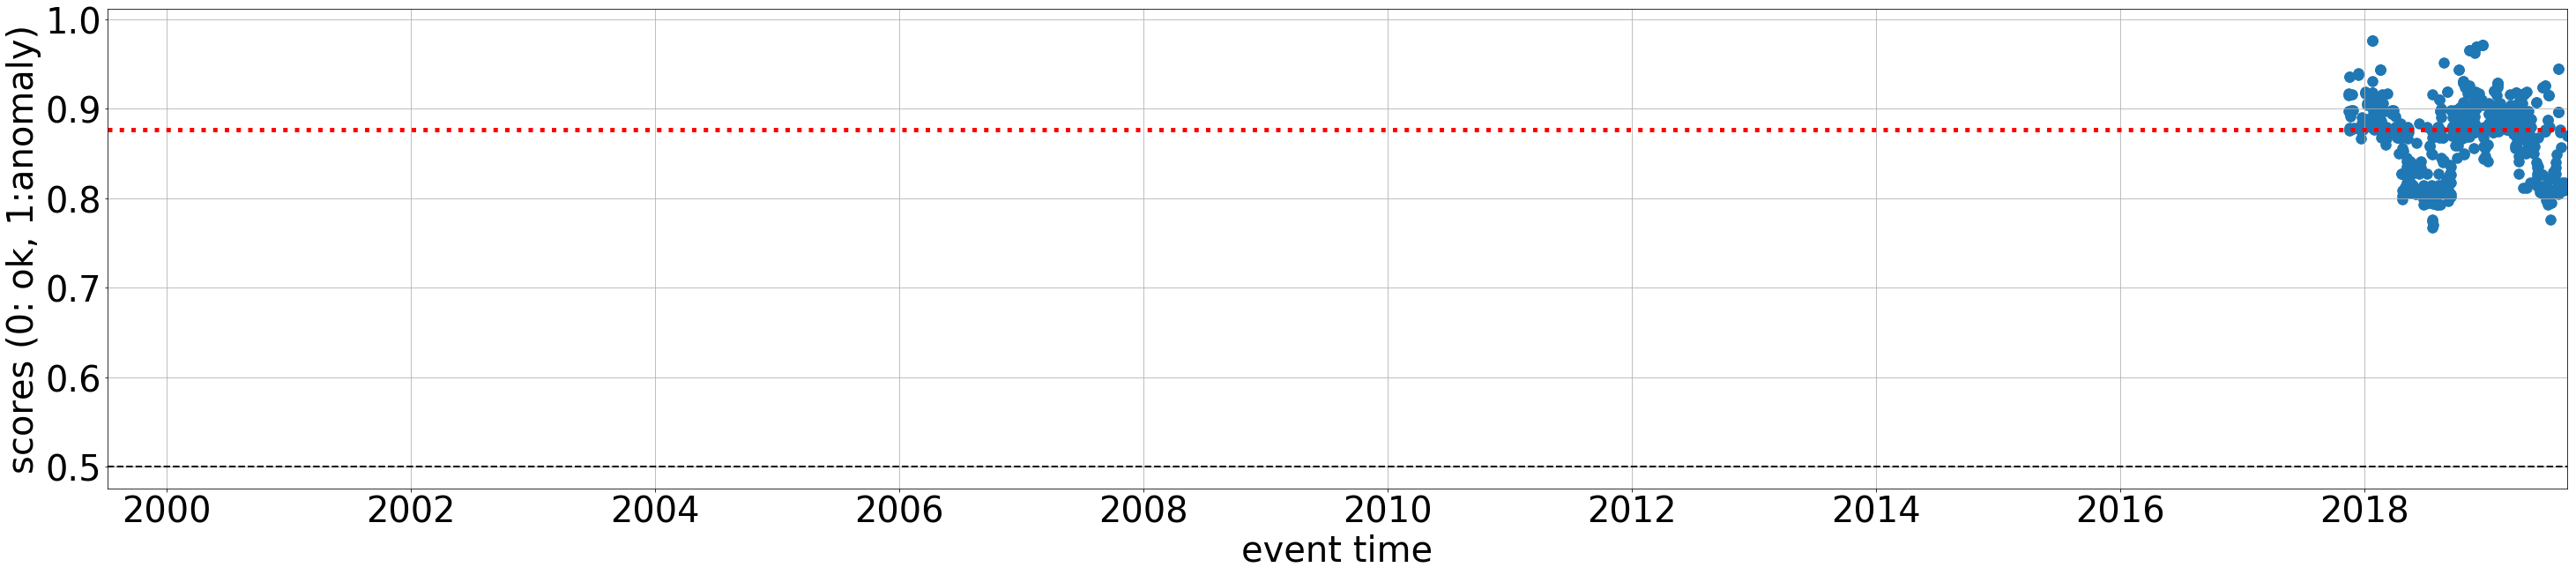

Channel: UD.MI28..BH? dataset_id: 2 (name: me) Num.segments: 72 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.876[0] 0.779[1] 0.725[2] 0.866[3] 0.787[4] 0.703[5] 0.867[6] 0.795[7] 0.697[8]


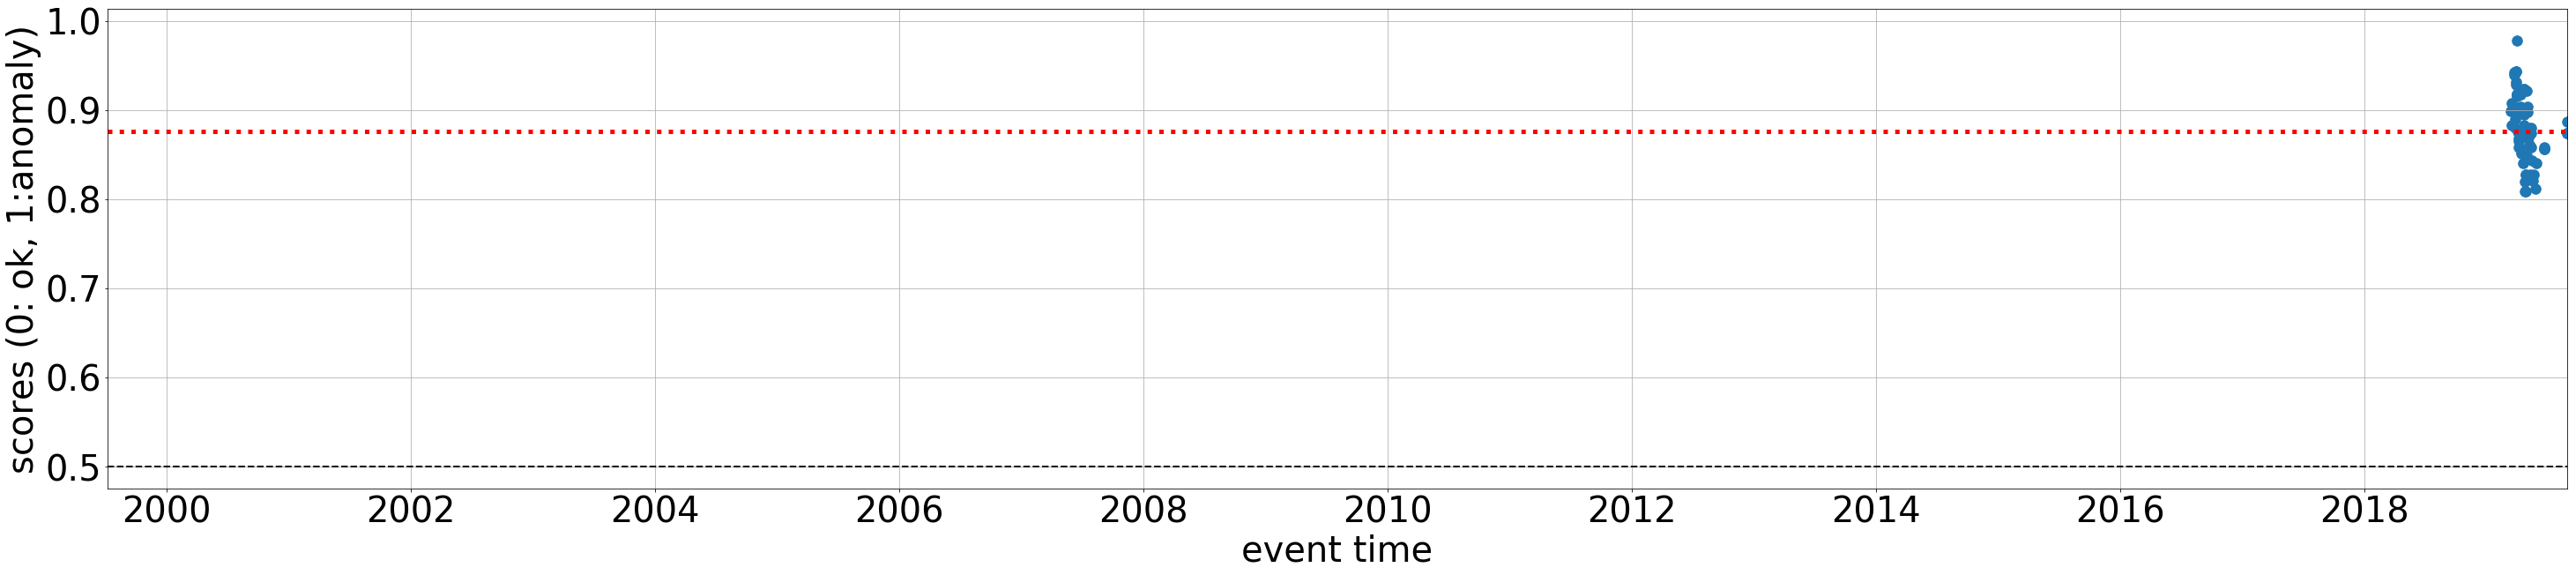

Channel: SL.GBAS..BH? dataset_id: 2 (name: me) Num.segments: 840 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.876[0] 0.778[1] 0.721[2] 0.865[3] 0.784[4] 0.702[5] 0.865[6] 0.787[7] 0.694[8]


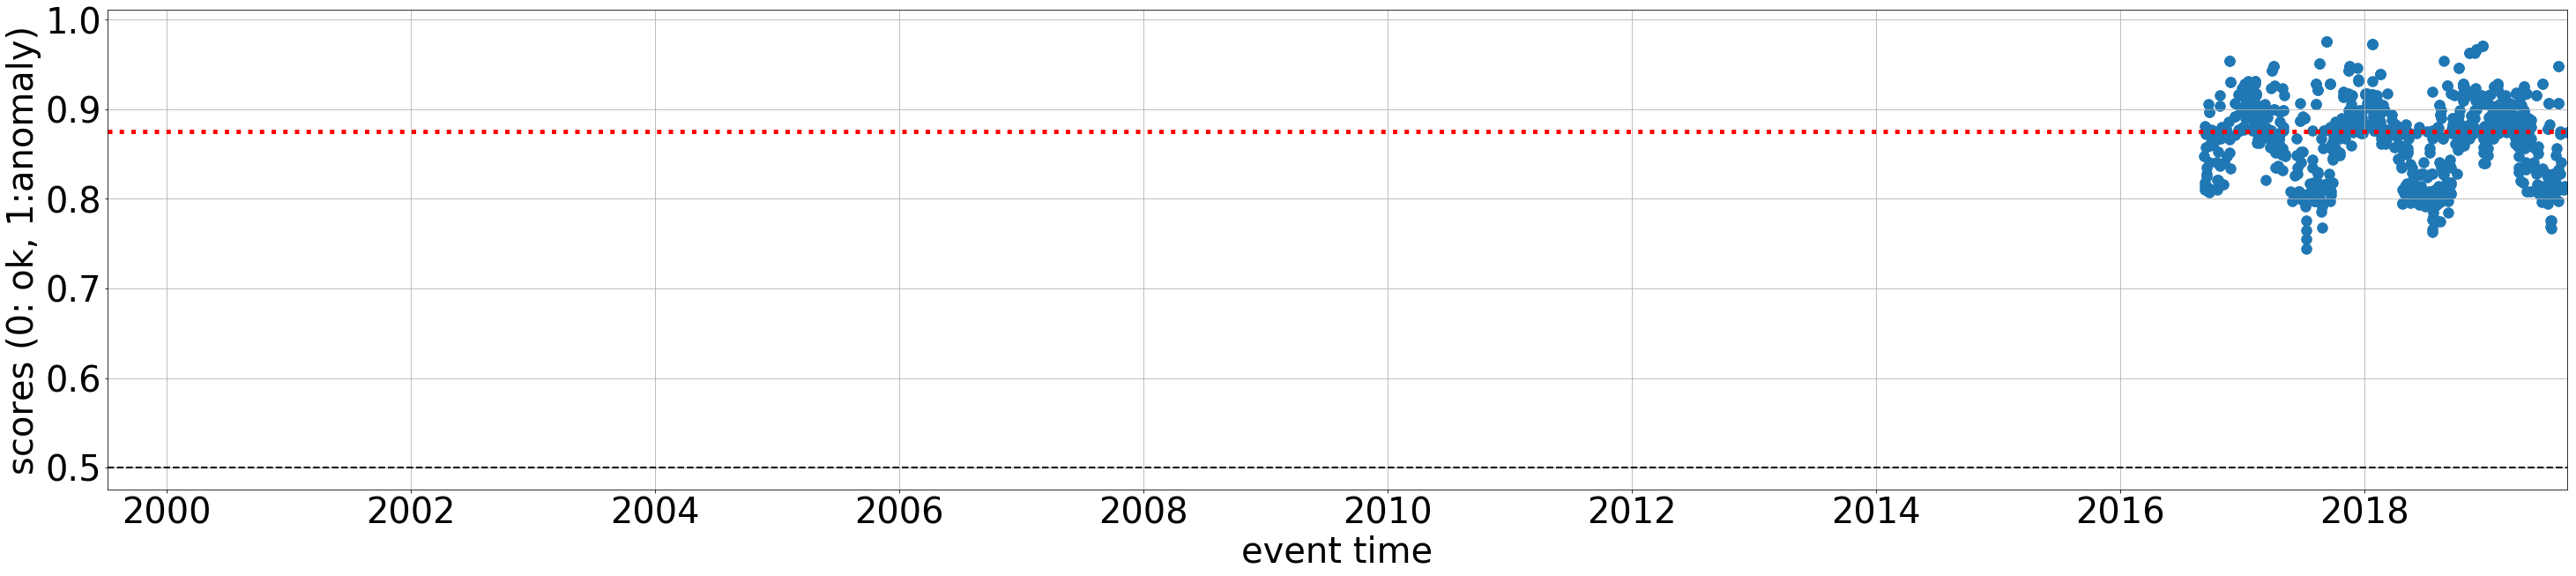

Channel: SL.CEY..BH? dataset_id: 2 (name: me) Num.segments: 358 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.874[0] 0.775[1] 0.721[2] 0.863[3] 0.779[4] 0.702[5] 0.864[6] 0.777[7] 0.694[8]


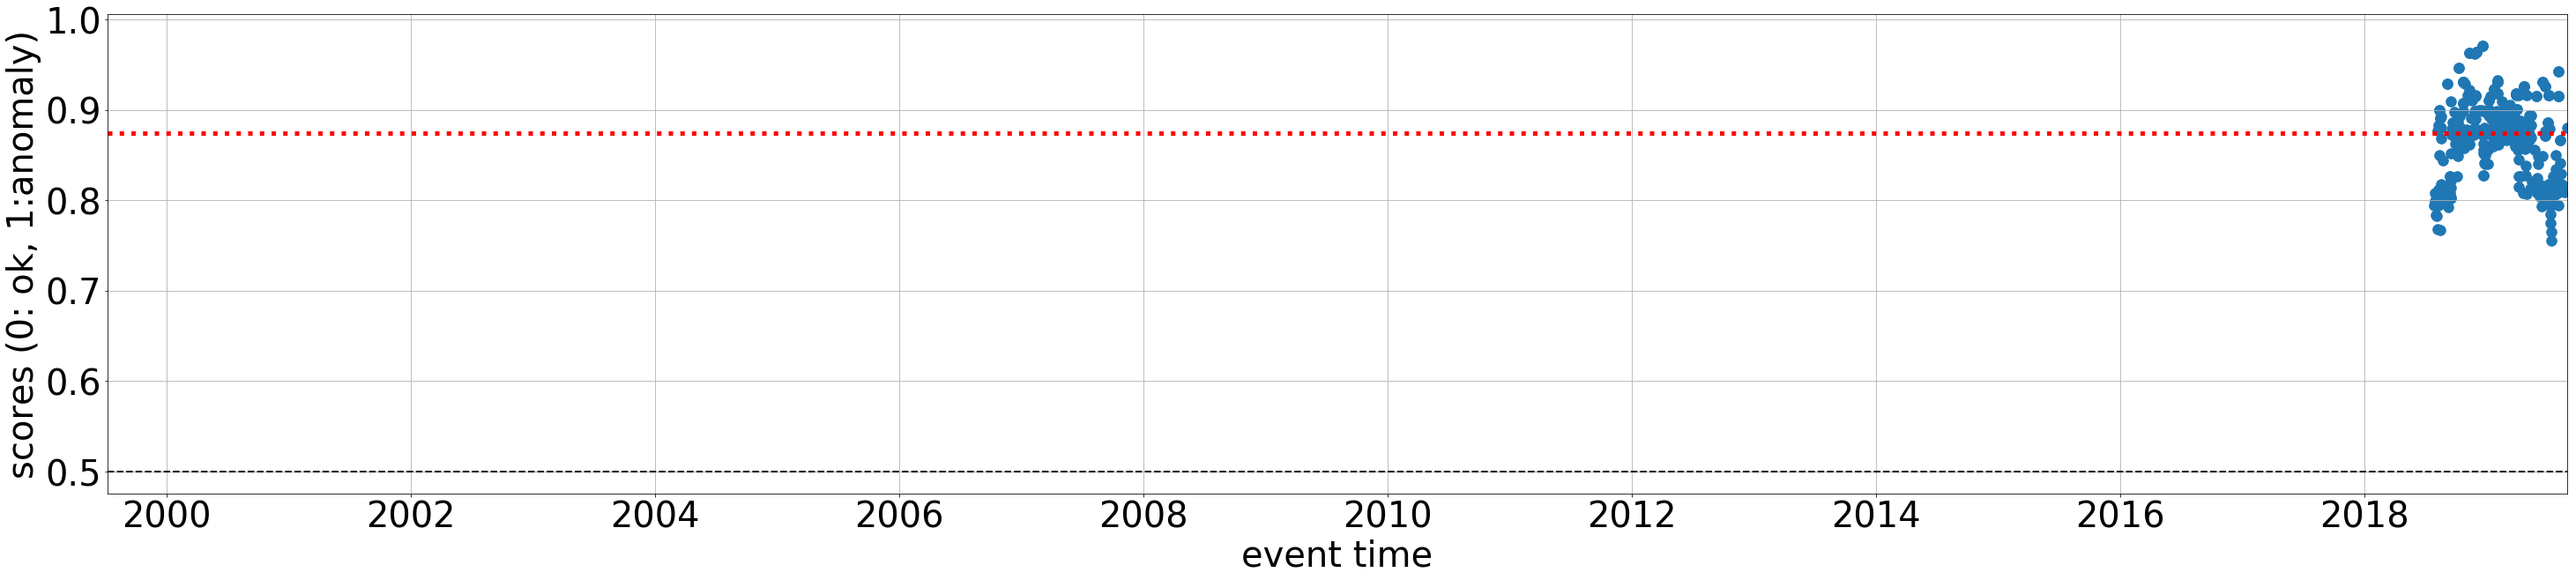

Channel: SL.GROS..BH? dataset_id: 2 (name: me) Num.segments: 322 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.874[0] 0.775[1] 0.721[2] 0.863[3] 0.779[4] 0.702[5] 0.864[6] 0.777[7] 0.690[8]


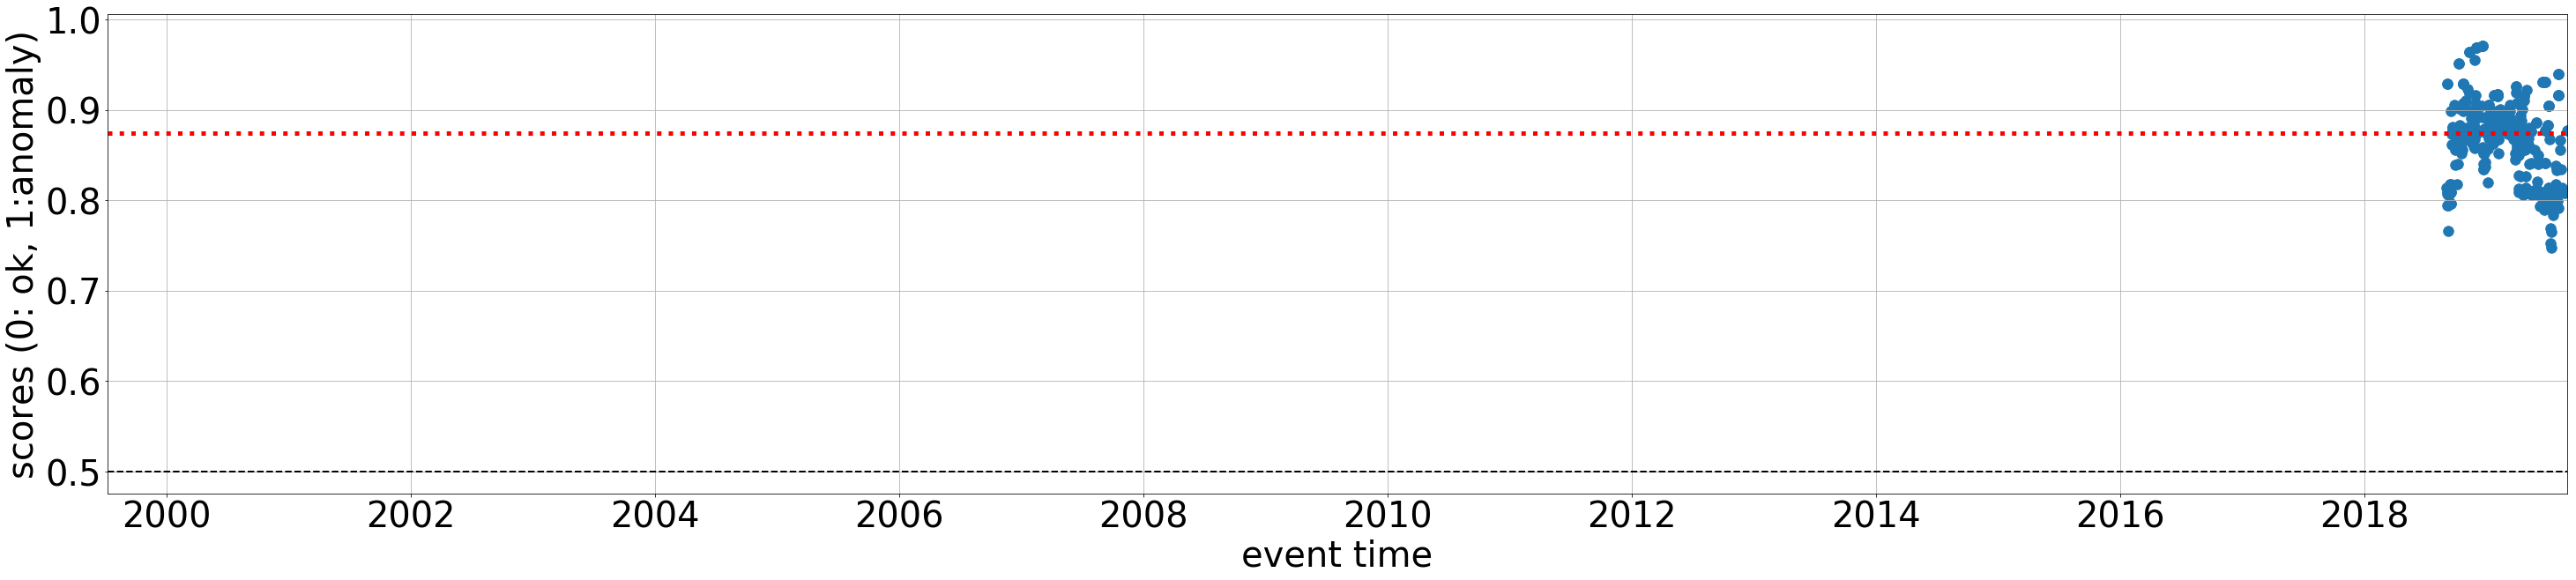

Channel: SL.KOGS..BH? dataset_id: 2 (name: me) Num.segments: 1293 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.874[0] 0.775[1] 0.720[2] 0.863[3] 0.779[4] 0.702[5] 0.864[6] 0.777[7] 0.692[8]


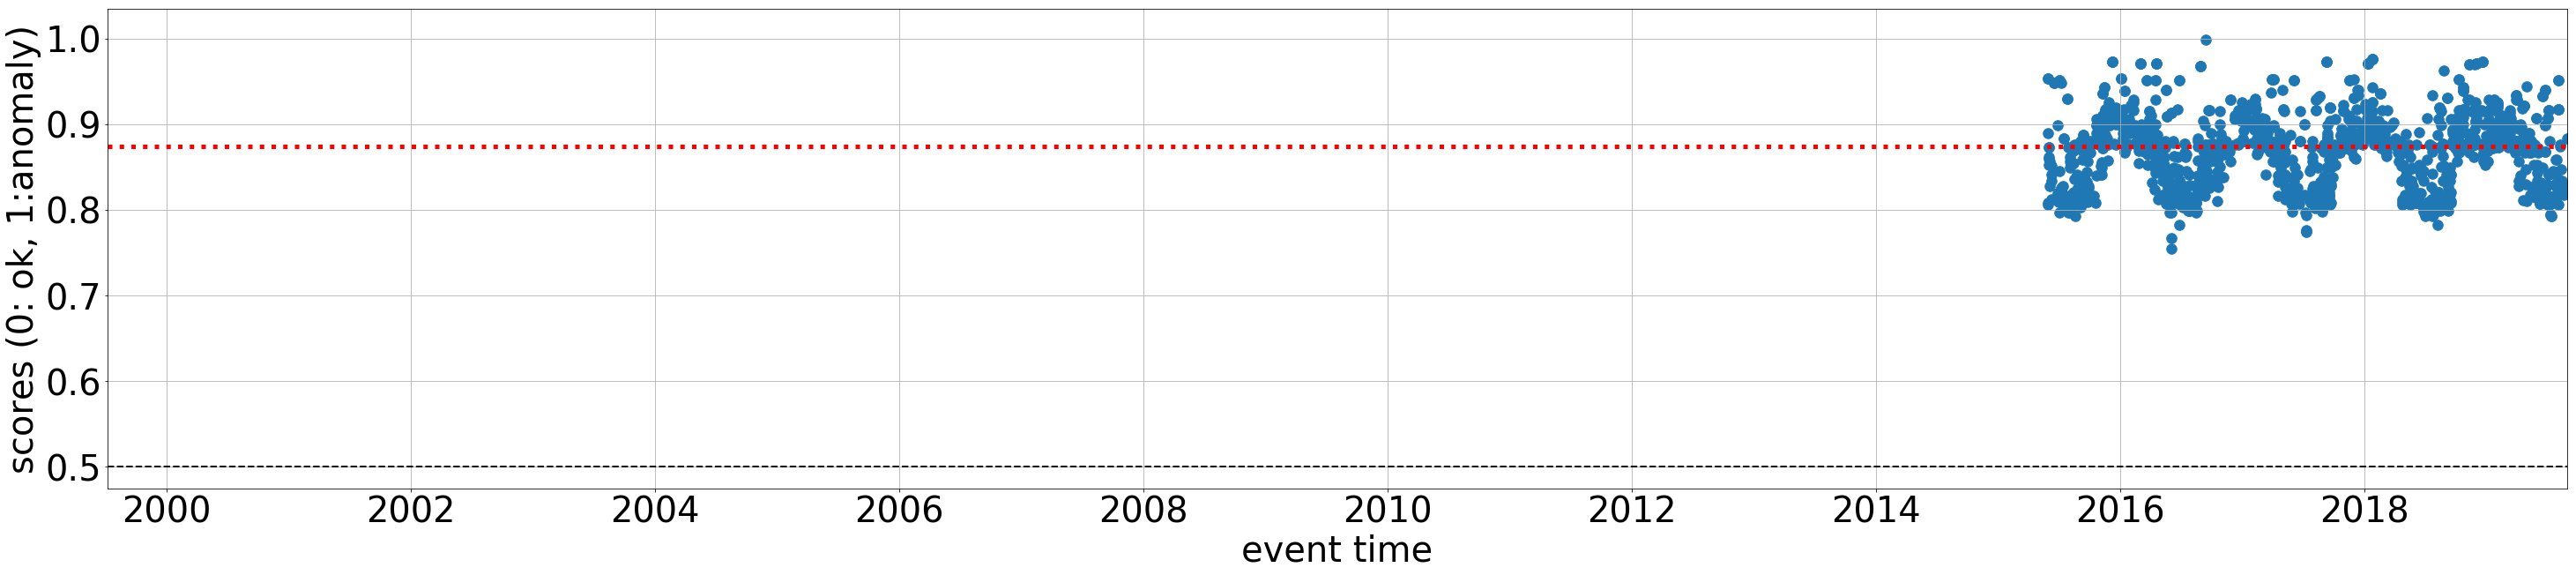

Channel: SL.LJU..BH? dataset_id: 2 (name: me) Num.segments: 1240 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.874[0] 0.775[1] 0.719[2] 0.863[3] 0.778[4] 0.702[5] 0.864[6] 0.776[7] 0.691[8]


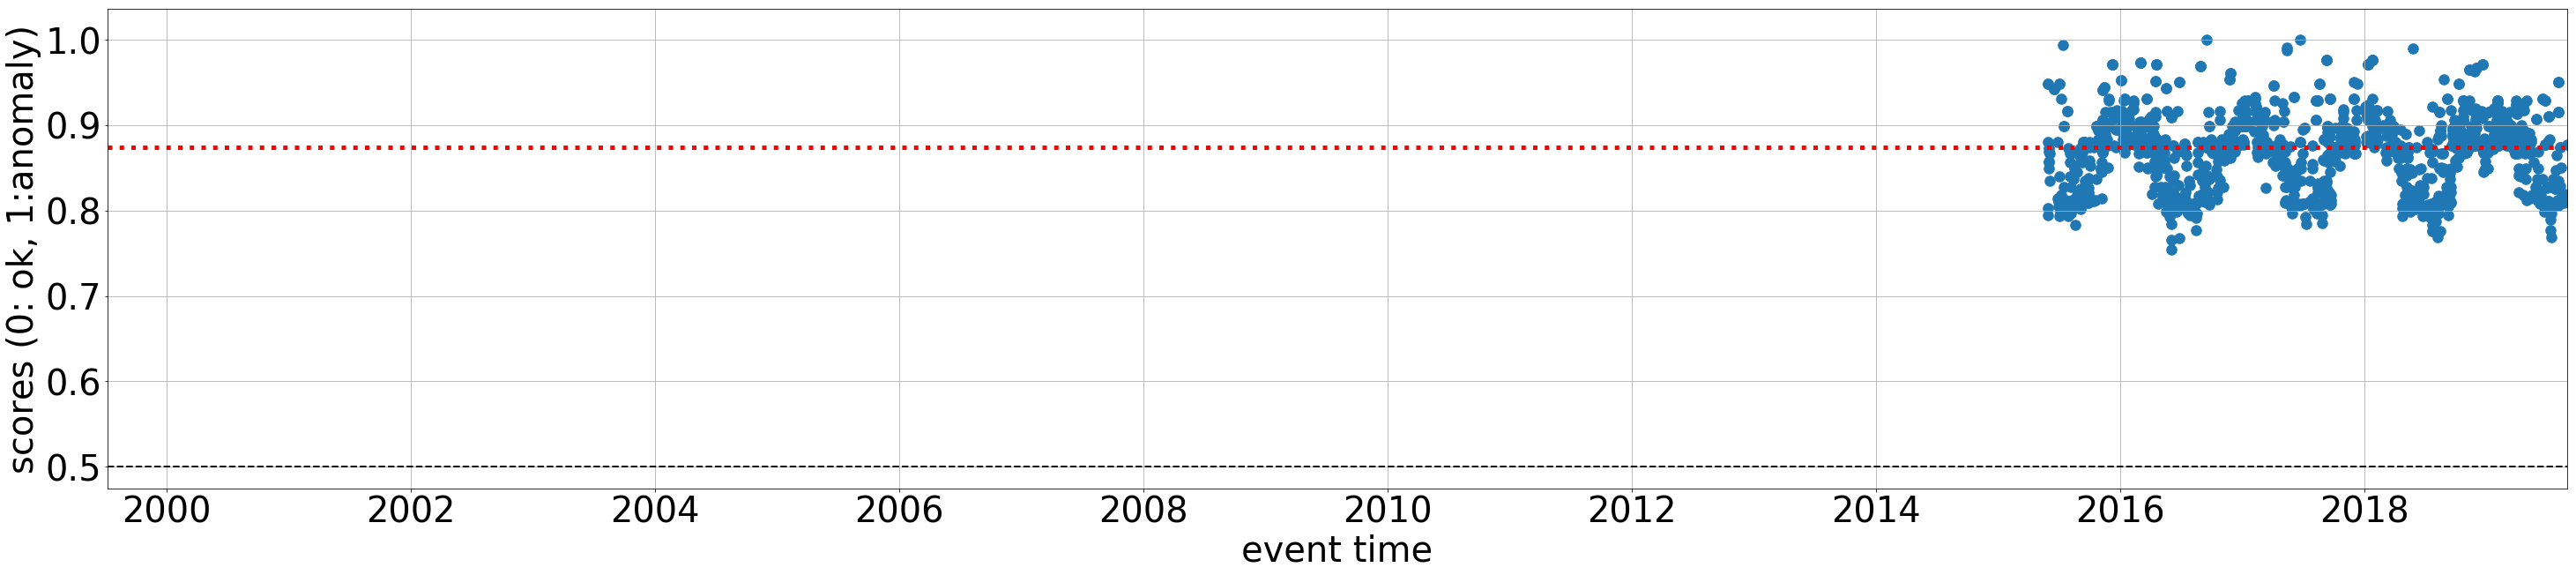

Channel: SL.VNDS..BH? dataset_id: 2 (name: me) Num.segments: 306 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.873[0] 0.771[1] 0.719[2] 0.862[3] 0.772[4] 0.701[5] 0.864[6] 0.769[7] 0.691[8]


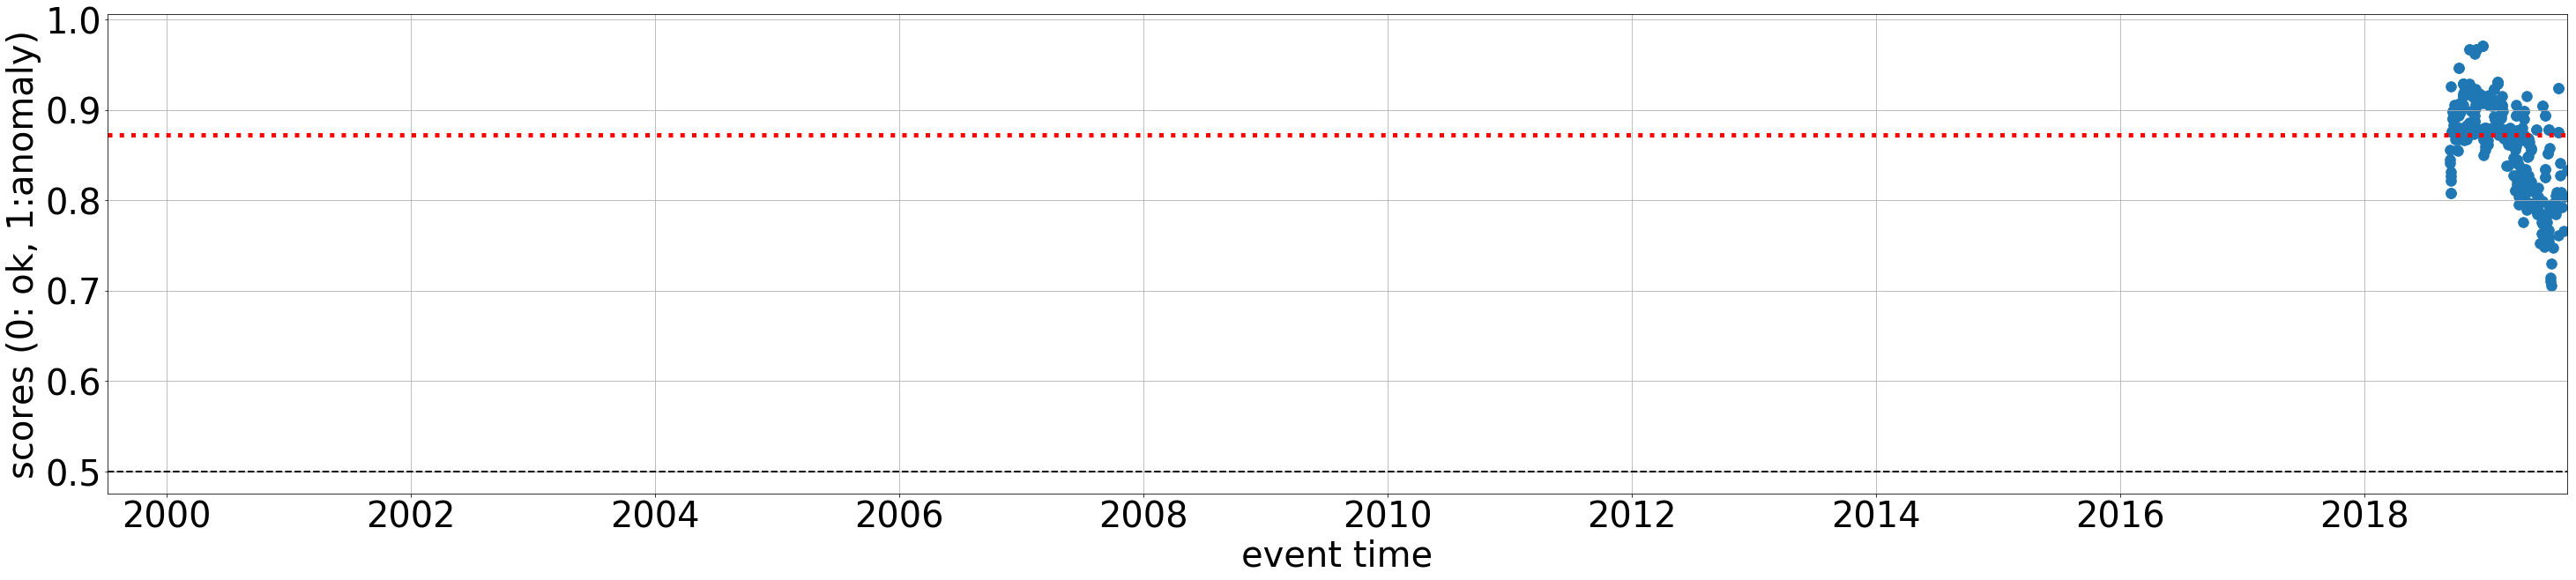

Channel: SL.CRNS..BH? dataset_id: 2 (name: me) Num.segments: 910 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.872[0] 0.768[1] 0.718[2] 0.861[3] 0.771[4] 0.699[5] 0.864[6] 0.767[7] 0.690[8]


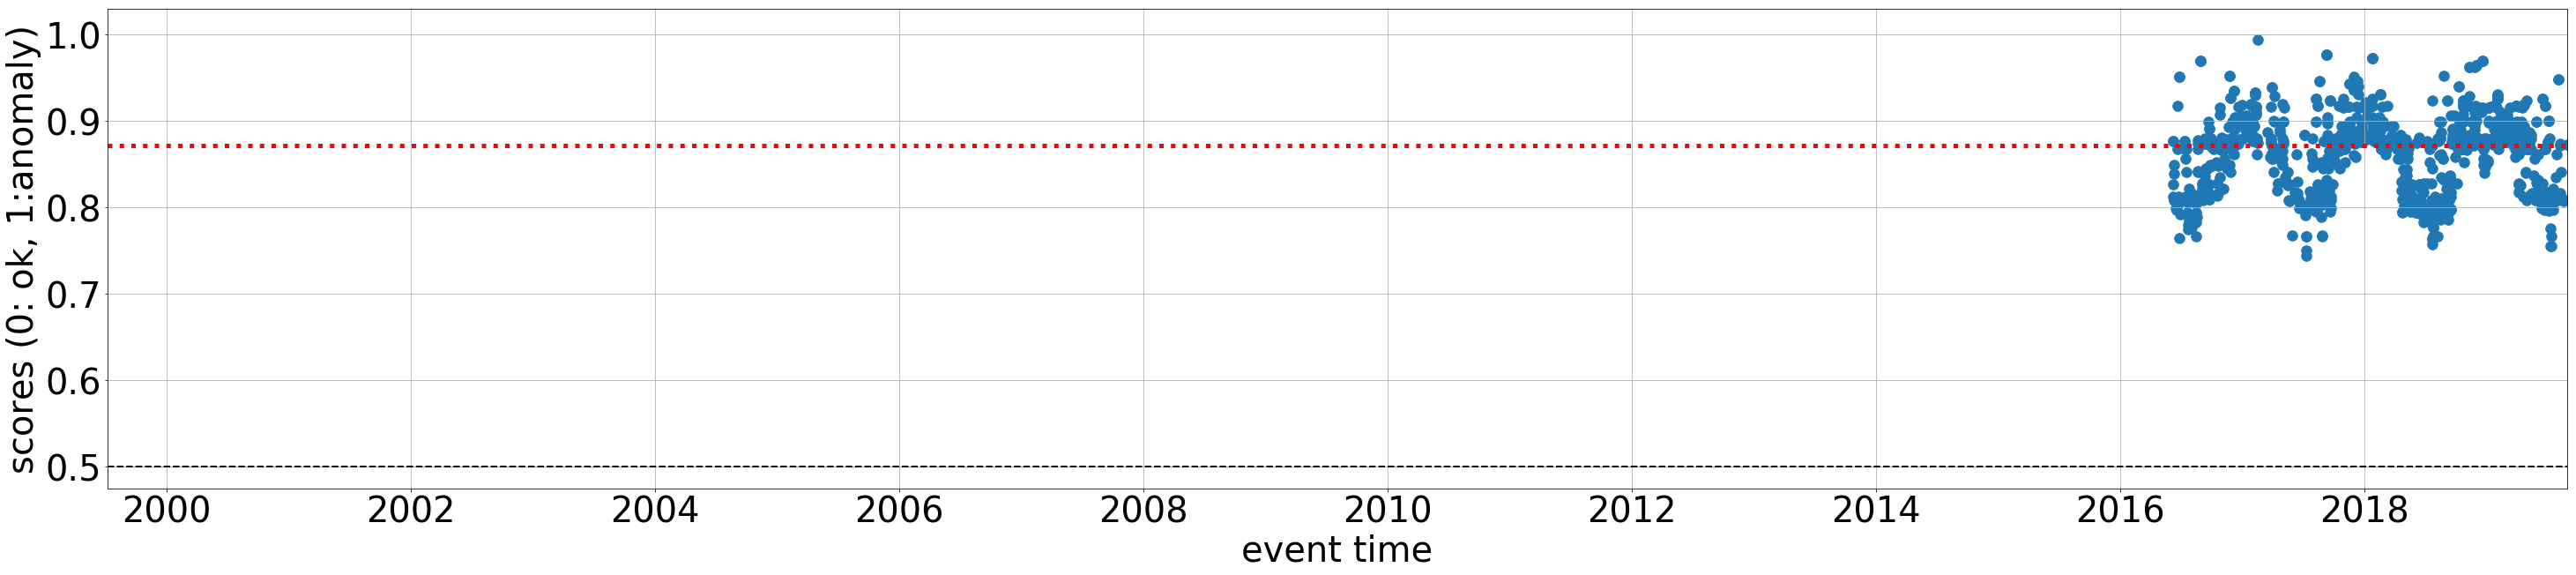

Channel: SL.DOBS..BH? dataset_id: 2 (name: me) Num.segments: 540 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.869[0] 0.765[1] 0.718[2] 0.856[3] 0.771[4] 0.697[5] 0.855[6] 0.764[7] 0.689[8]


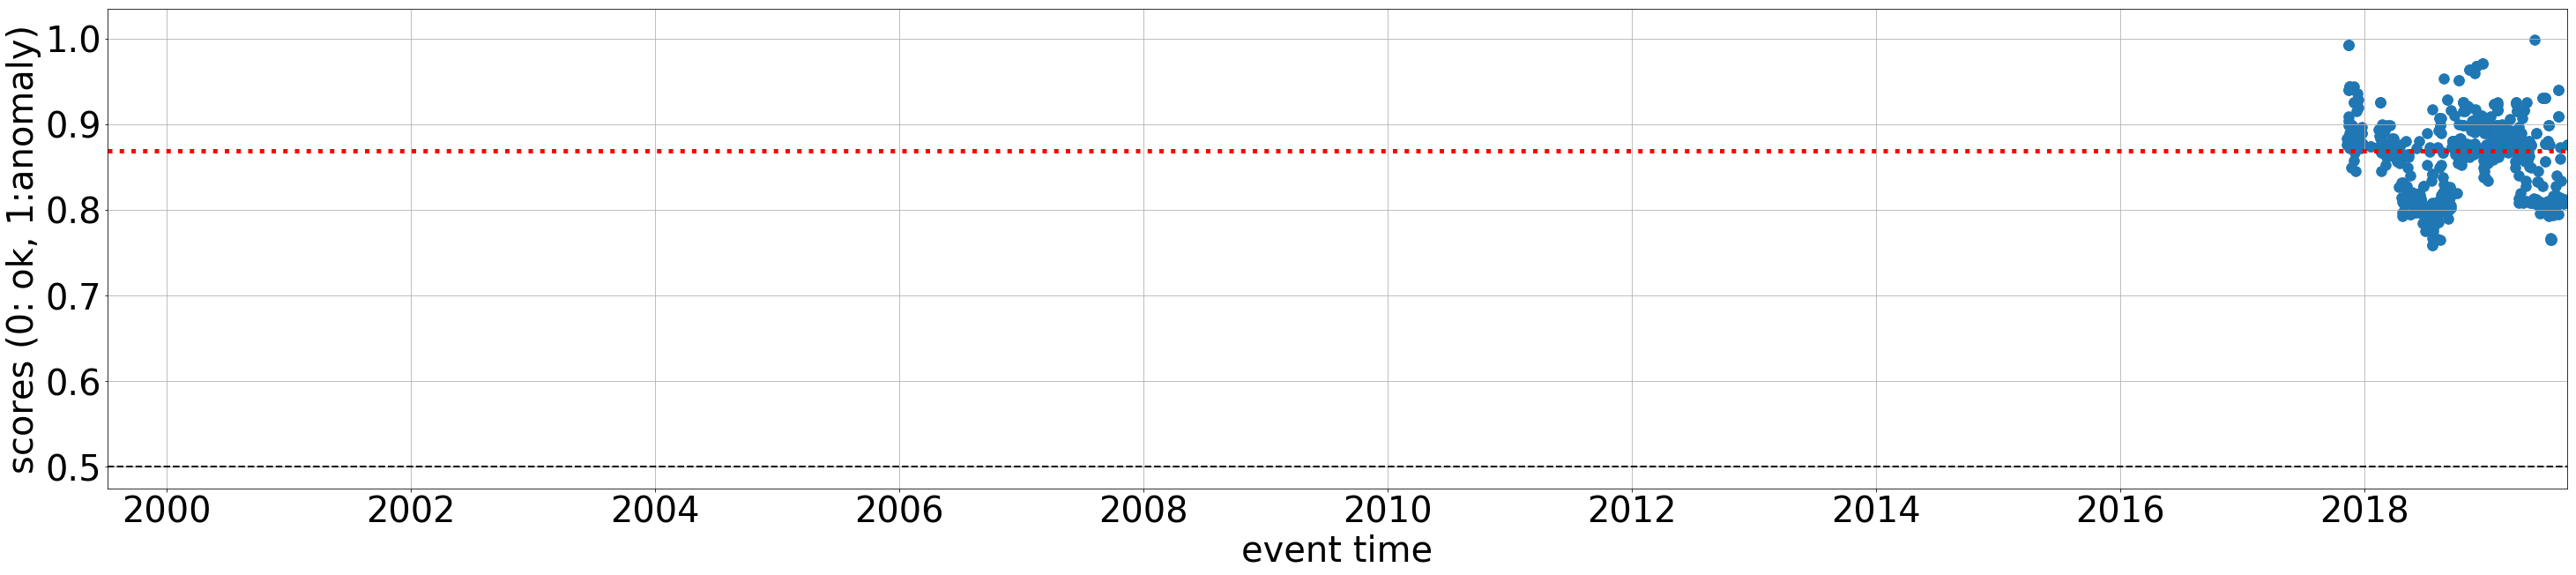

Channel: SL.KNDS..BH? dataset_id: 2 (name: me) Num.segments: 1312 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.868[0] 0.763[1] 0.718[2] 0.856[3] 0.770[4] 0.695[5] 0.855[6] 0.762[7] 0.690[8]


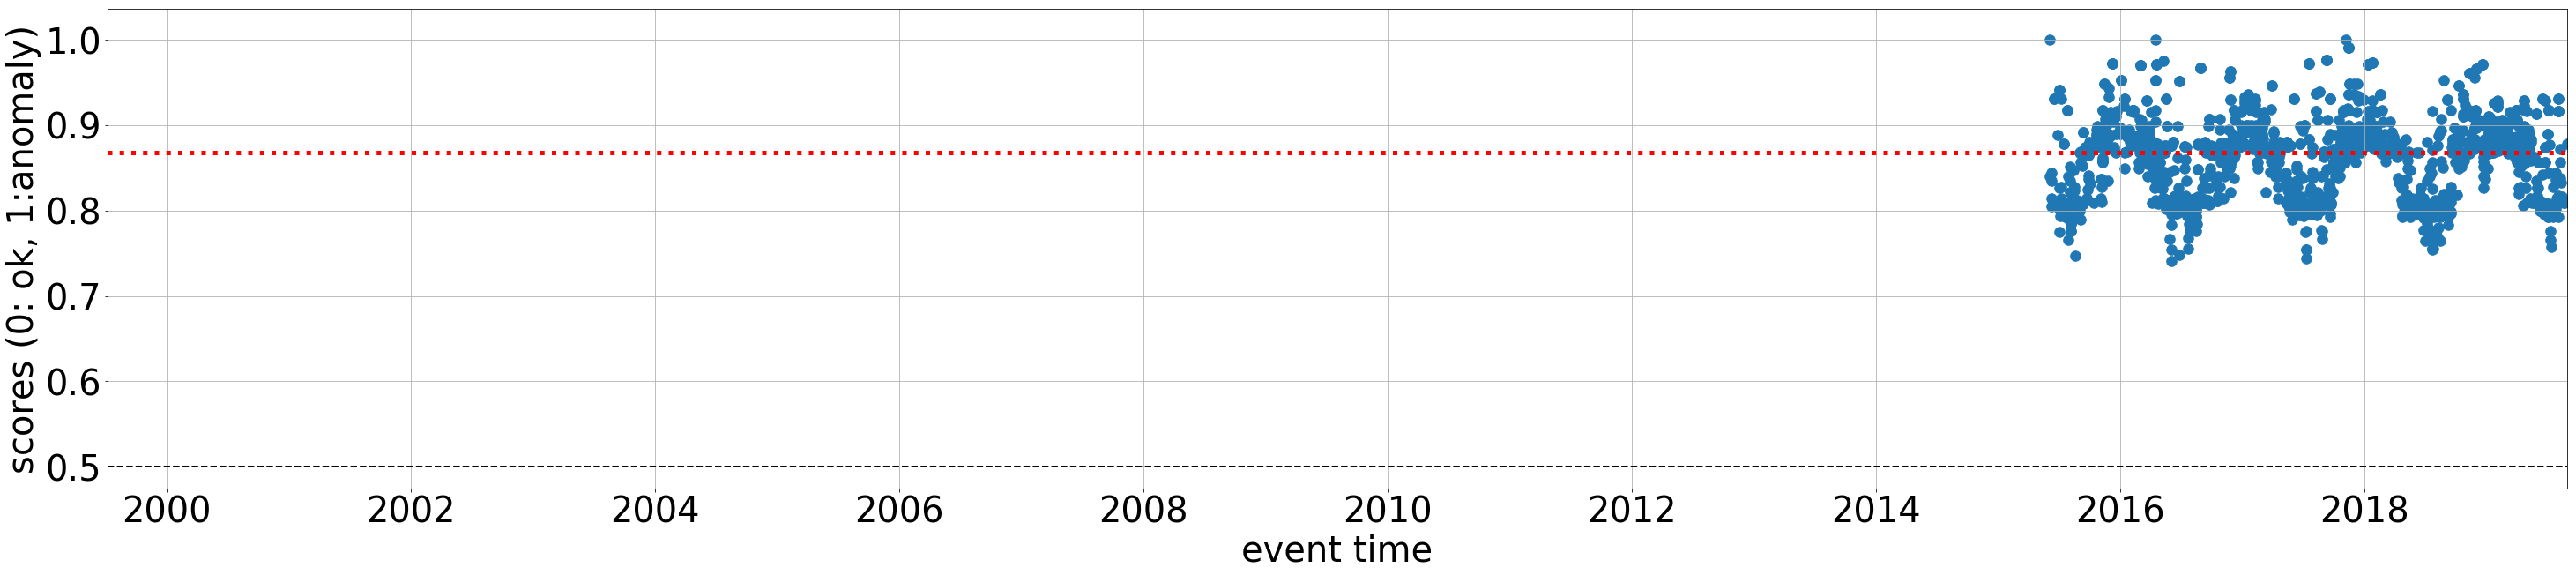

Channel: SL.JAVS..BH? dataset_id: 2 (name: me) Num.segments: 1239 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.868[0] 0.762[1] 0.718[2] 0.856[3] 0.770[4] 0.694[5] 0.855[6] 0.762[7] 0.688[8]


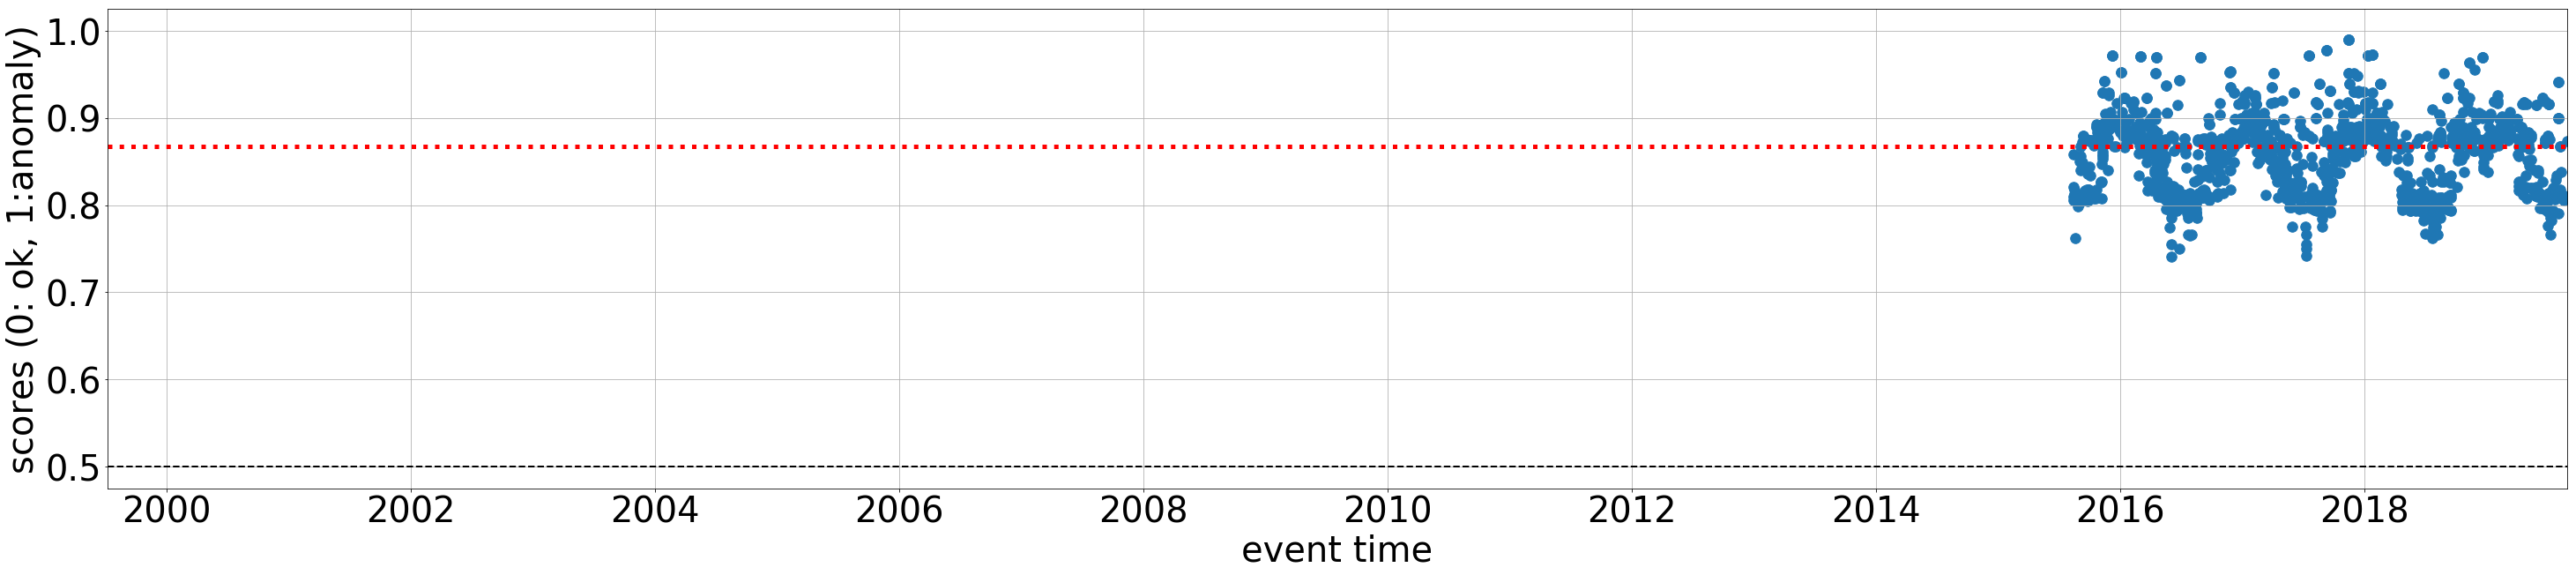

Channel: SL.VISS..BH? dataset_id: 2 (name: me) Num.segments: 733 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.868[0] 0.763[1] 0.718[2] 0.856[3] 0.770[4] 0.695[5] 0.855[6] 0.763[7] 0.690[8]


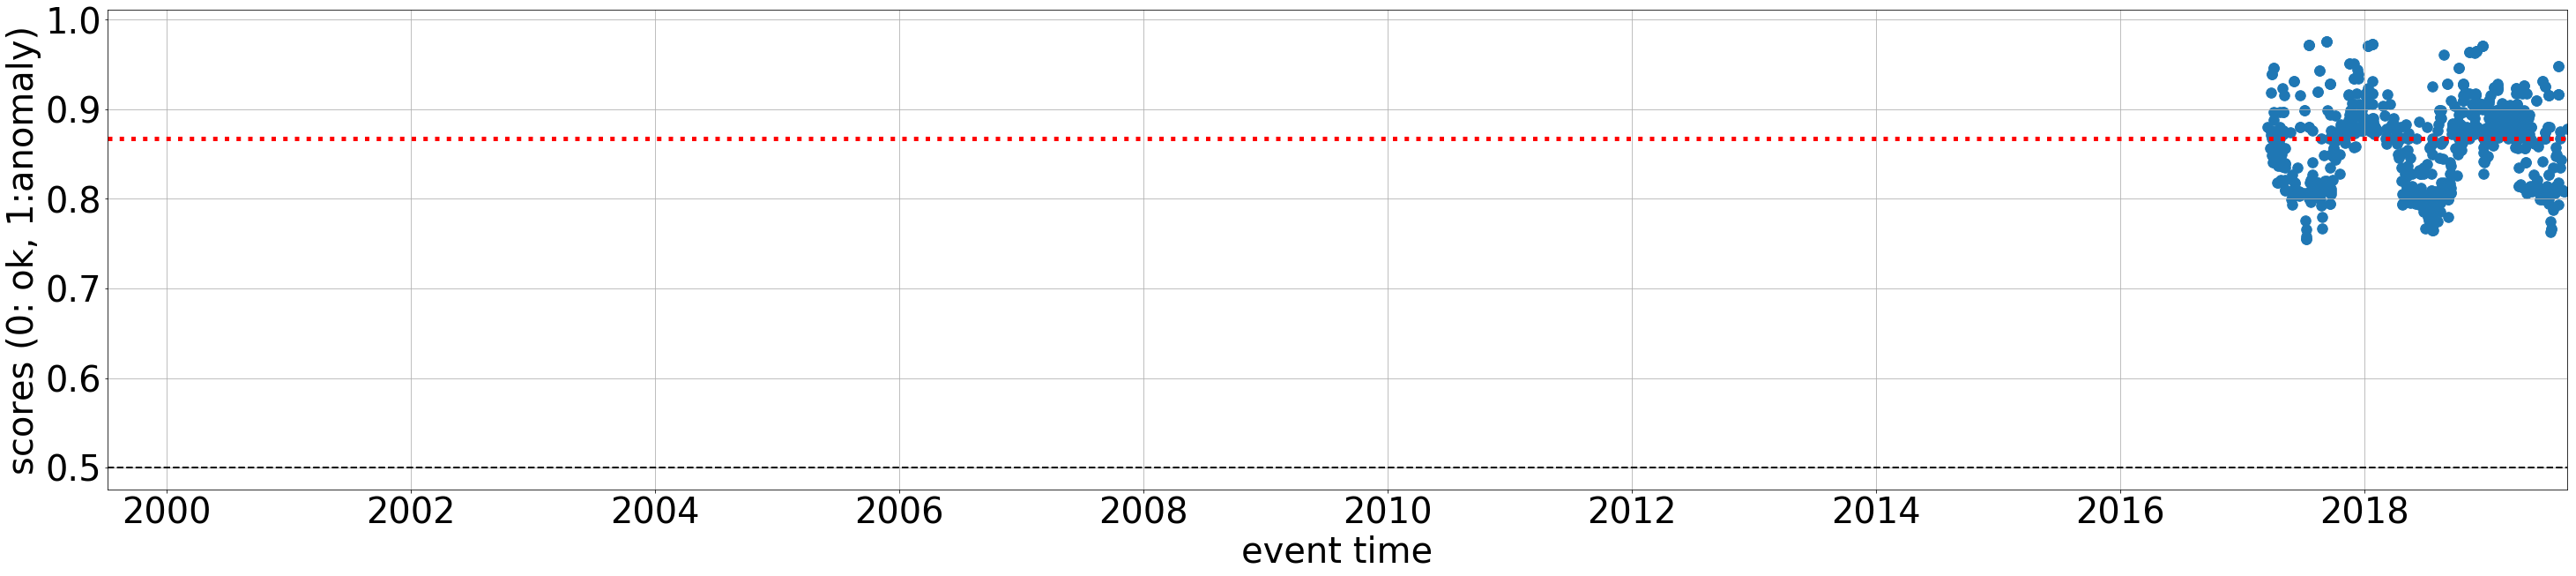

Channel: SL.CADS..BH? dataset_id: 2 (name: me) Num.segments: 855 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.867[0] 0.760[1] 0.717[2] 0.856[3] 0.770[4] 0.694[5] 0.854[6] 0.762[7] 0.688[8]


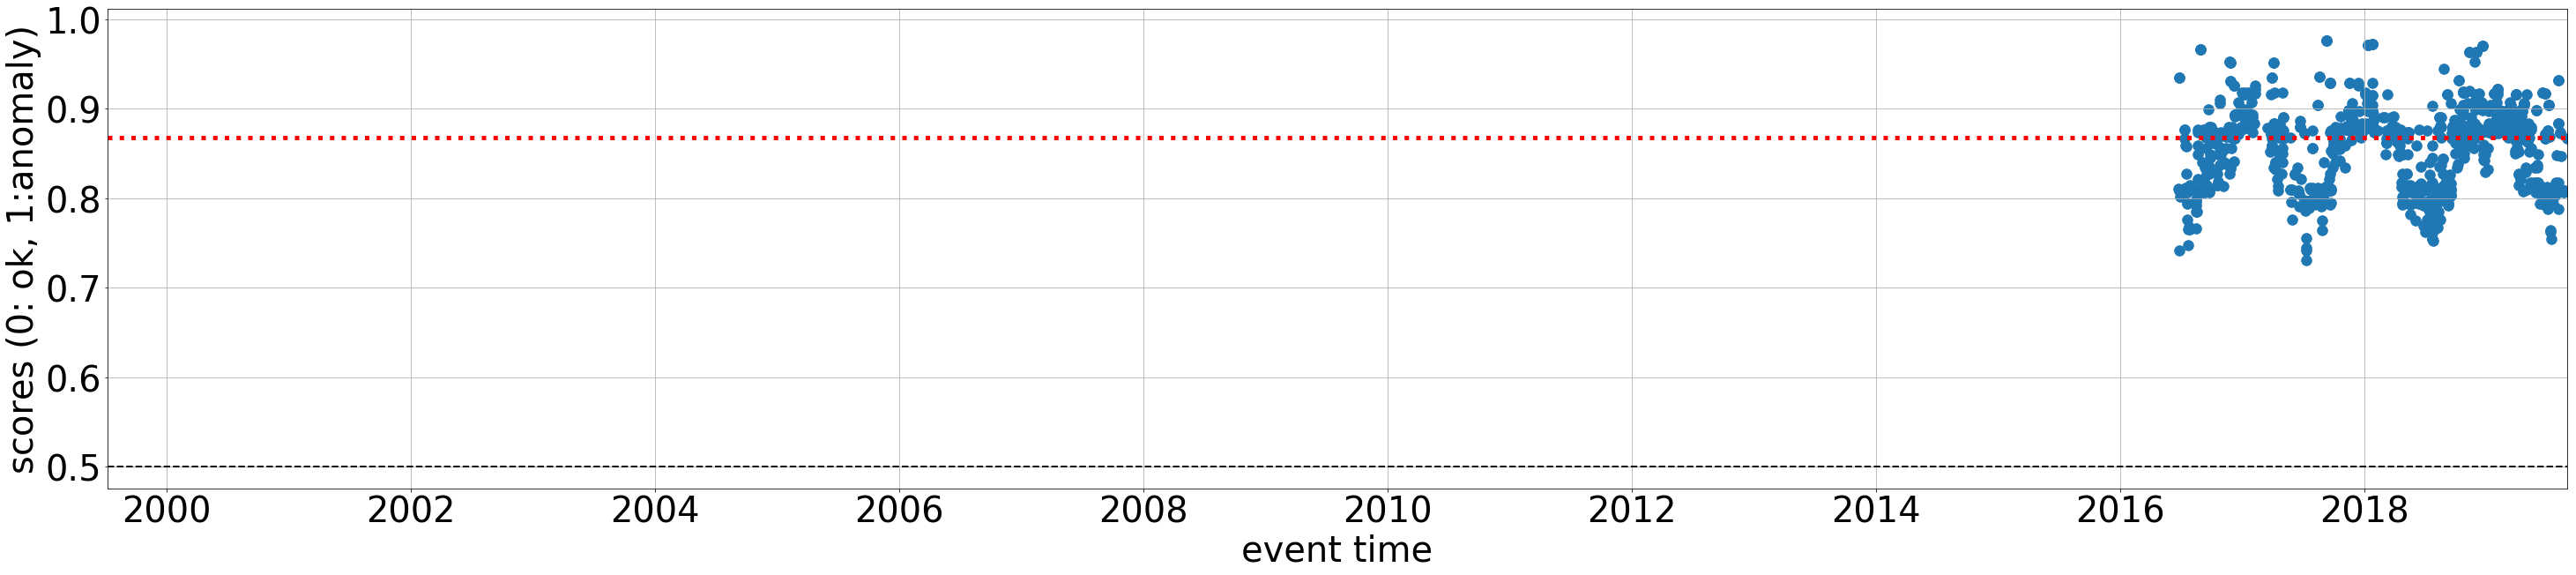

Channel: SL.GORS..BH? dataset_id: 2 (name: me) Num.segments: 1208 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.867[0] 0.761[1] 0.717[2] 0.856[3] 0.770[4] 0.693[5] 0.854[6] 0.762[7] 0.688[8]


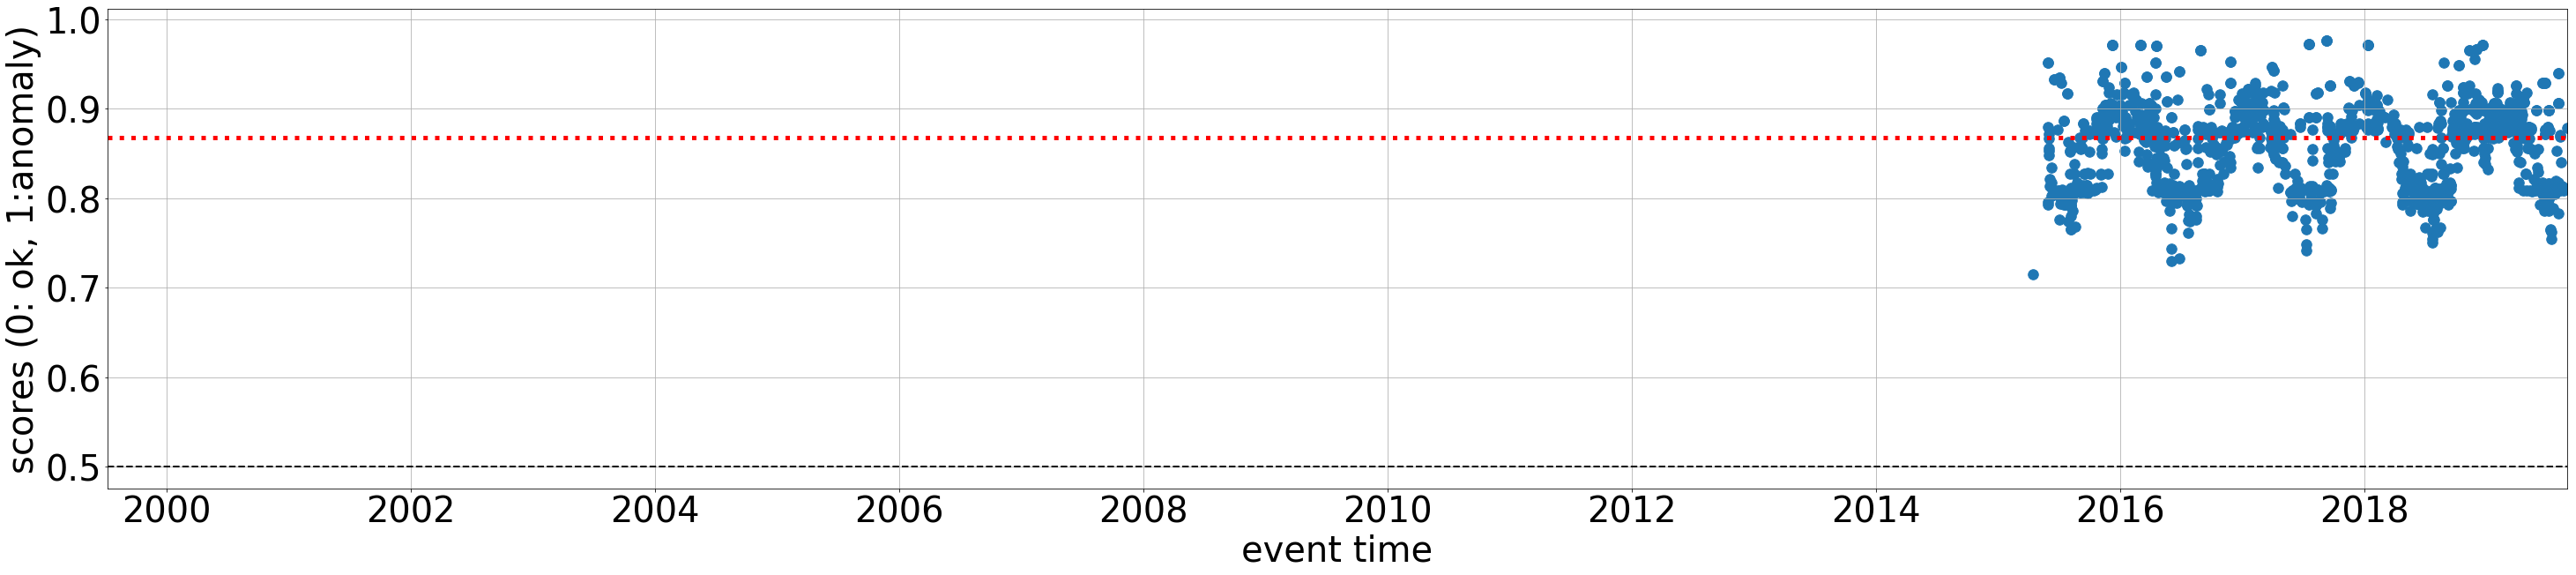

Channel: SL.CRES..BH? dataset_id: 2 (name: me) Num.segments: 1121 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.867[0] 0.755[1] 0.716[2] 0.856[3] 0.764[4] 0.693[5] 0.854[6] 0.759[7] 0.688[8]


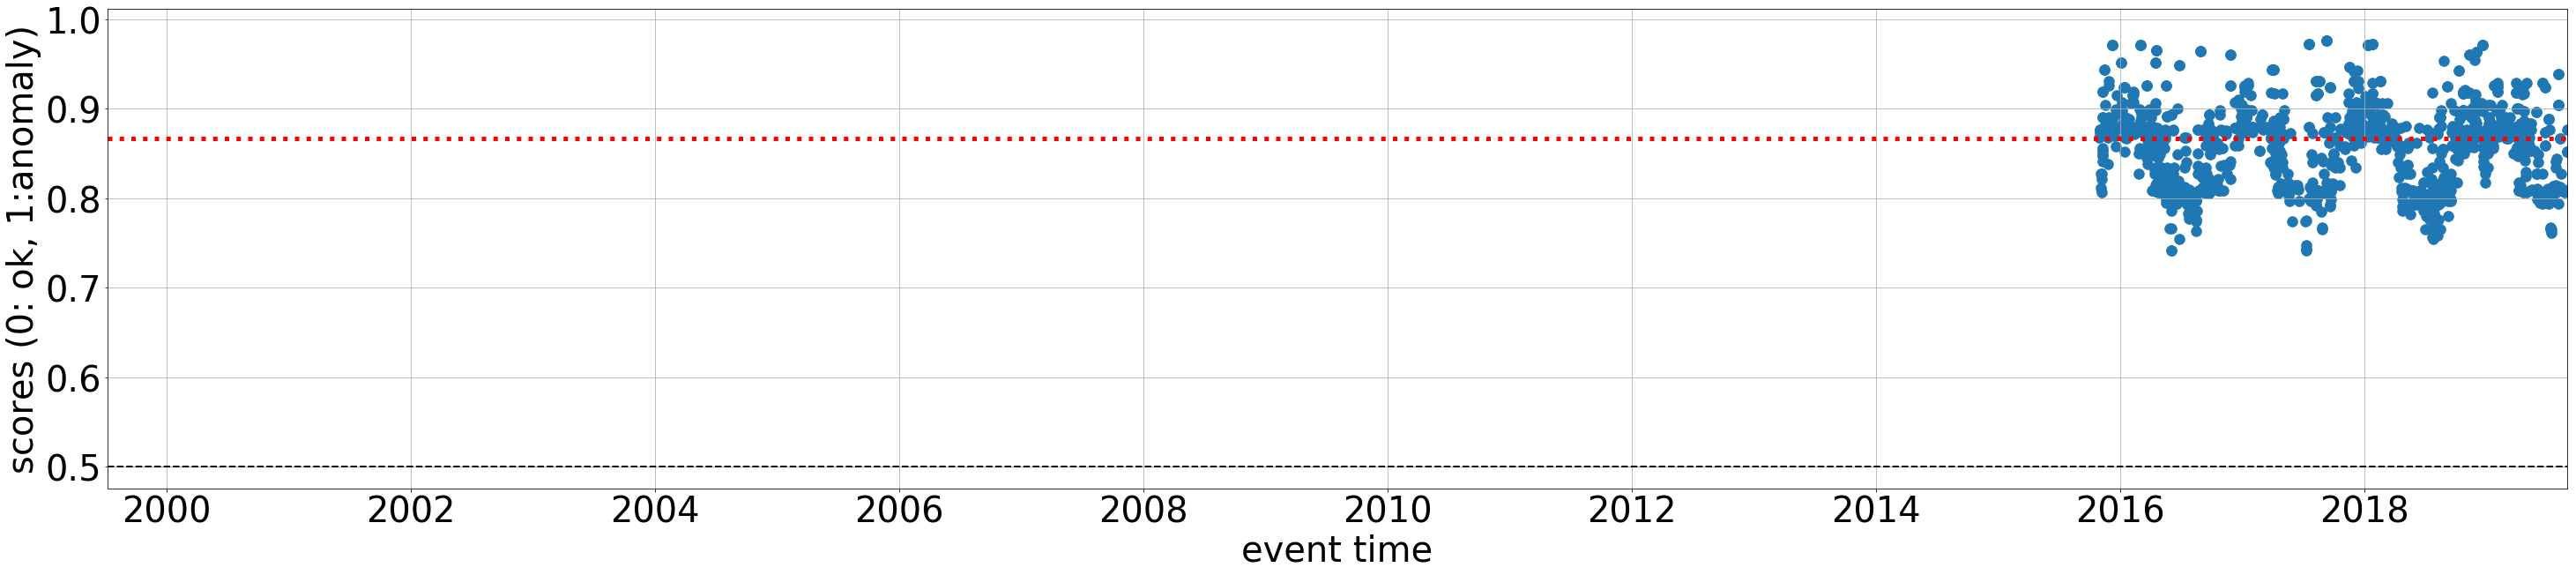

Channel: SL.PERS..BH? dataset_id: 2 (name: me) Num.segments: 763 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.867[0] 0.760[1] 0.717[2] 0.856[3] 0.770[4] 0.693[5] 0.854[6] 0.762[7] 0.688[8]


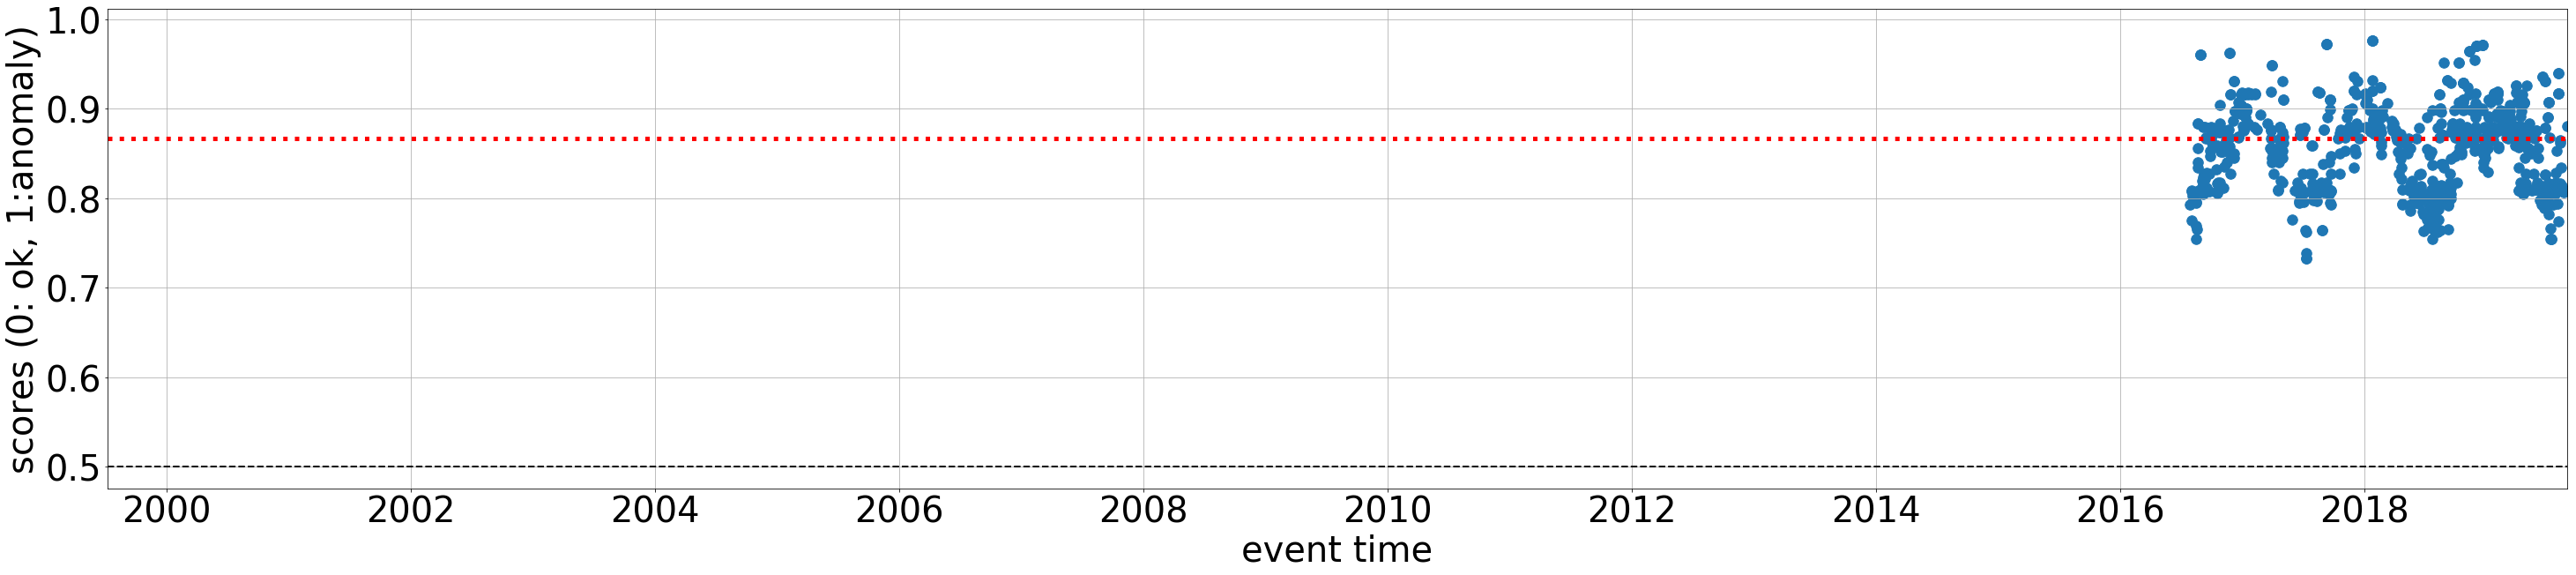

Channel: SL.ZAVS..BH? dataset_id: 2 (name: me) Num.segments: 237 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.867[0] 0.758[1] 0.717[2] 0.856[3] 0.767[4] 0.691[5] 0.854[6] 0.761[7] 0.688[8]


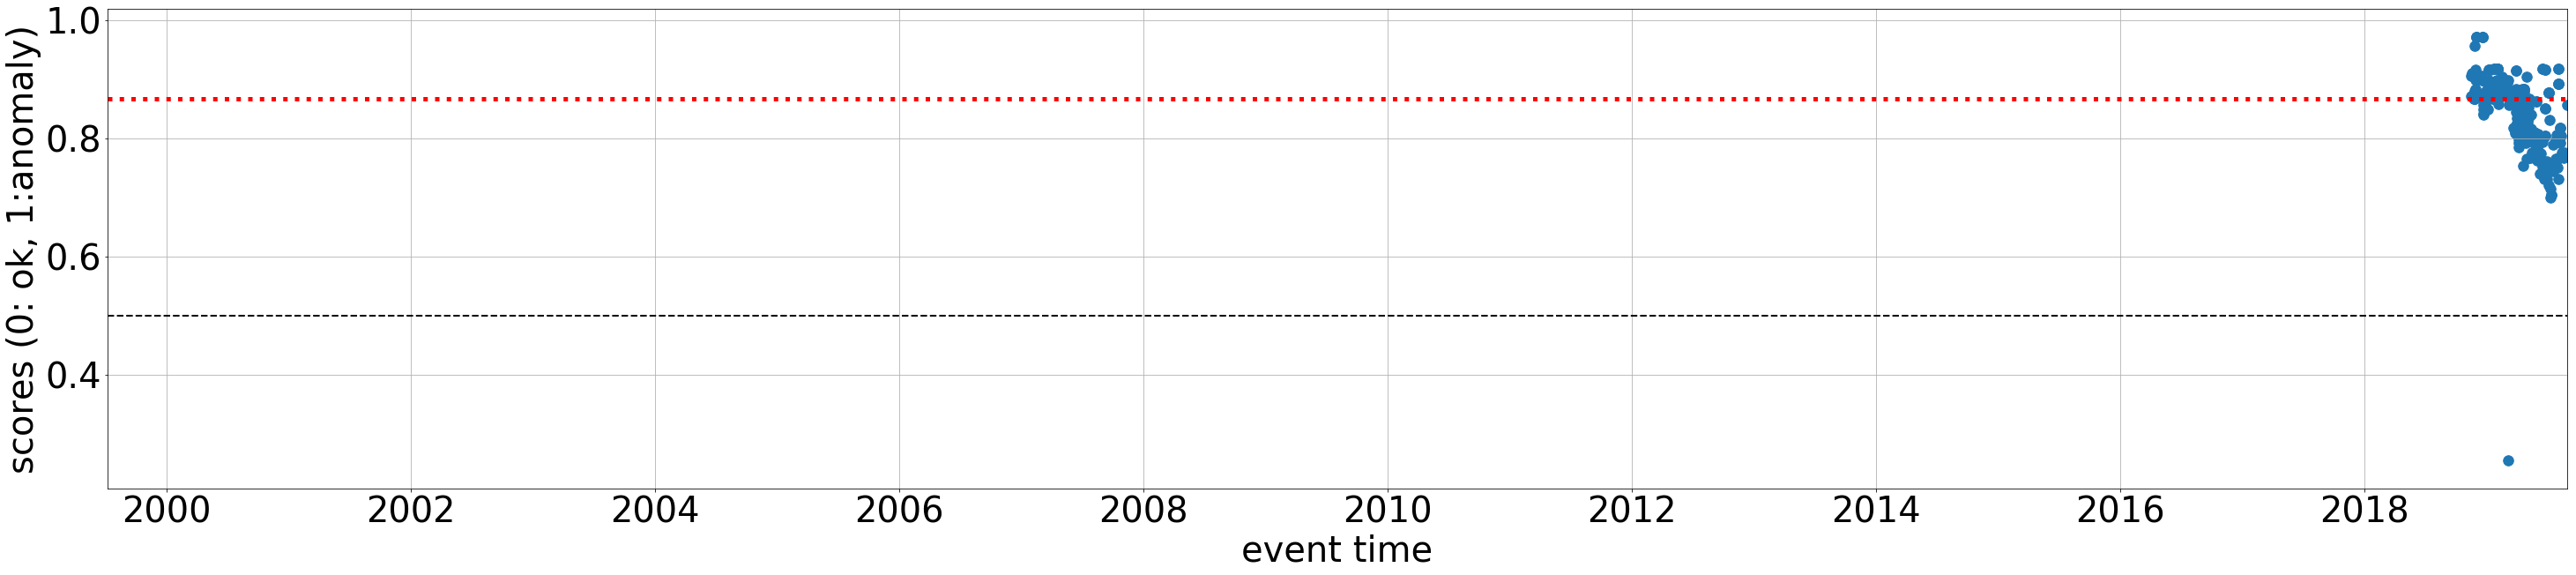

Channel: RO.TLB..BH? dataset_id: 2 (name: me) Num.segments: 563 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.862[0] 0.806[1] 0.742[2] 0.860[3] 0.819[4] 0.742[5] 0.859[6] 0.797[7] 0.735[8]


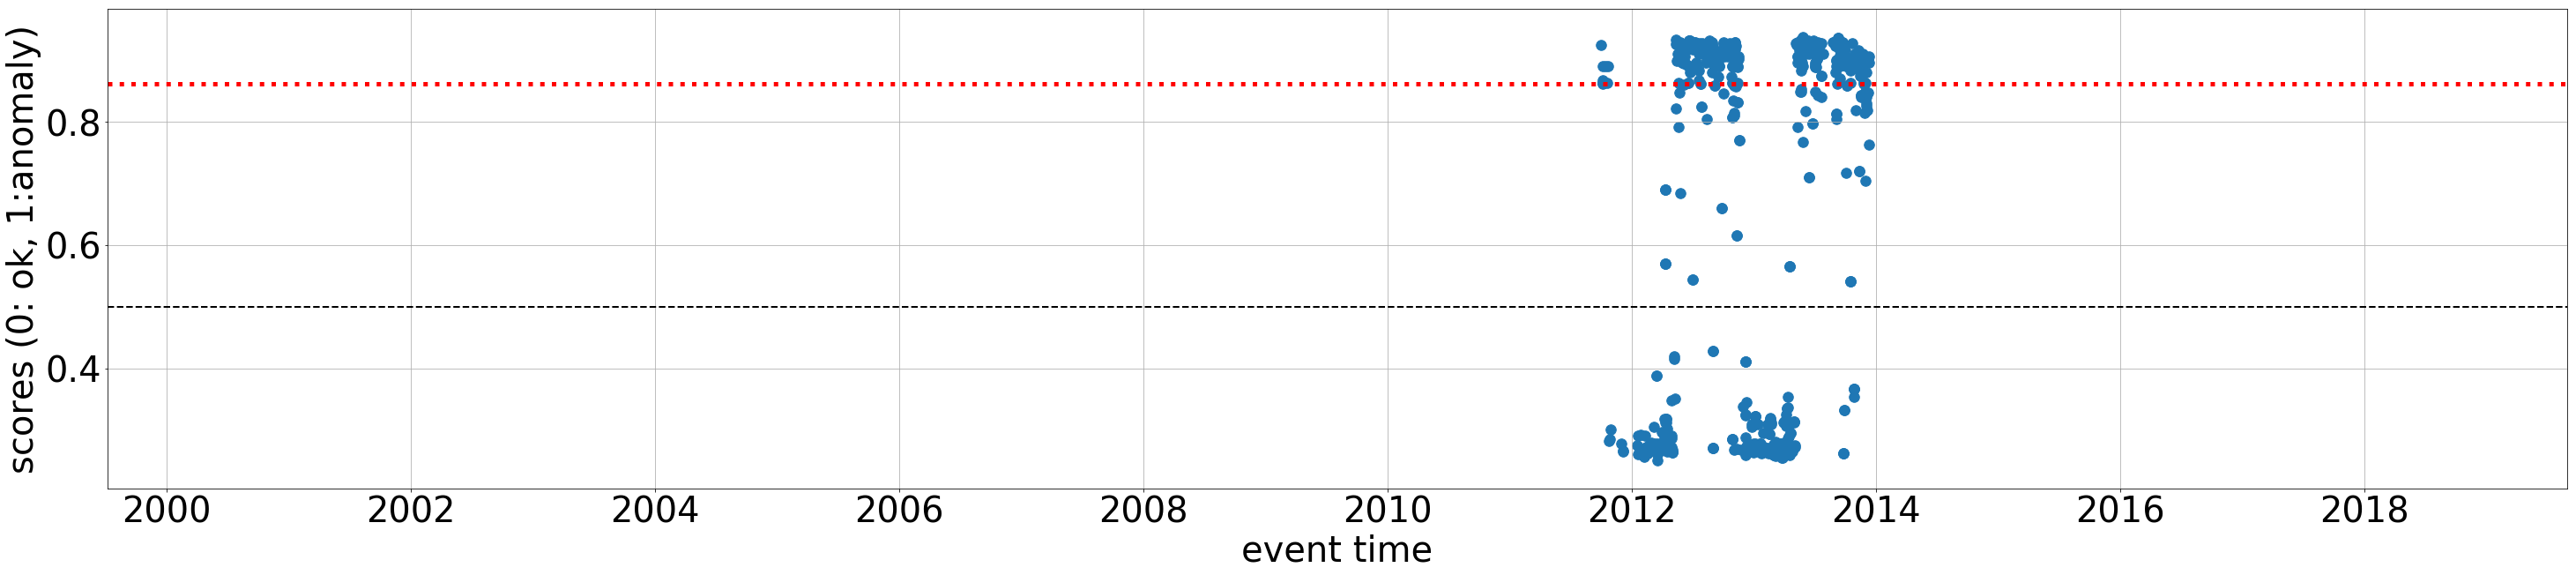

Channel: SL.BOJS..BH? dataset_id: 2 (name: me) Num.segments: 1283 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.859[0] 0.746[1] 0.715[2] 0.853[3] 0.759[4] 0.689[5] 0.847[6] 0.756[7] 0.684[8]


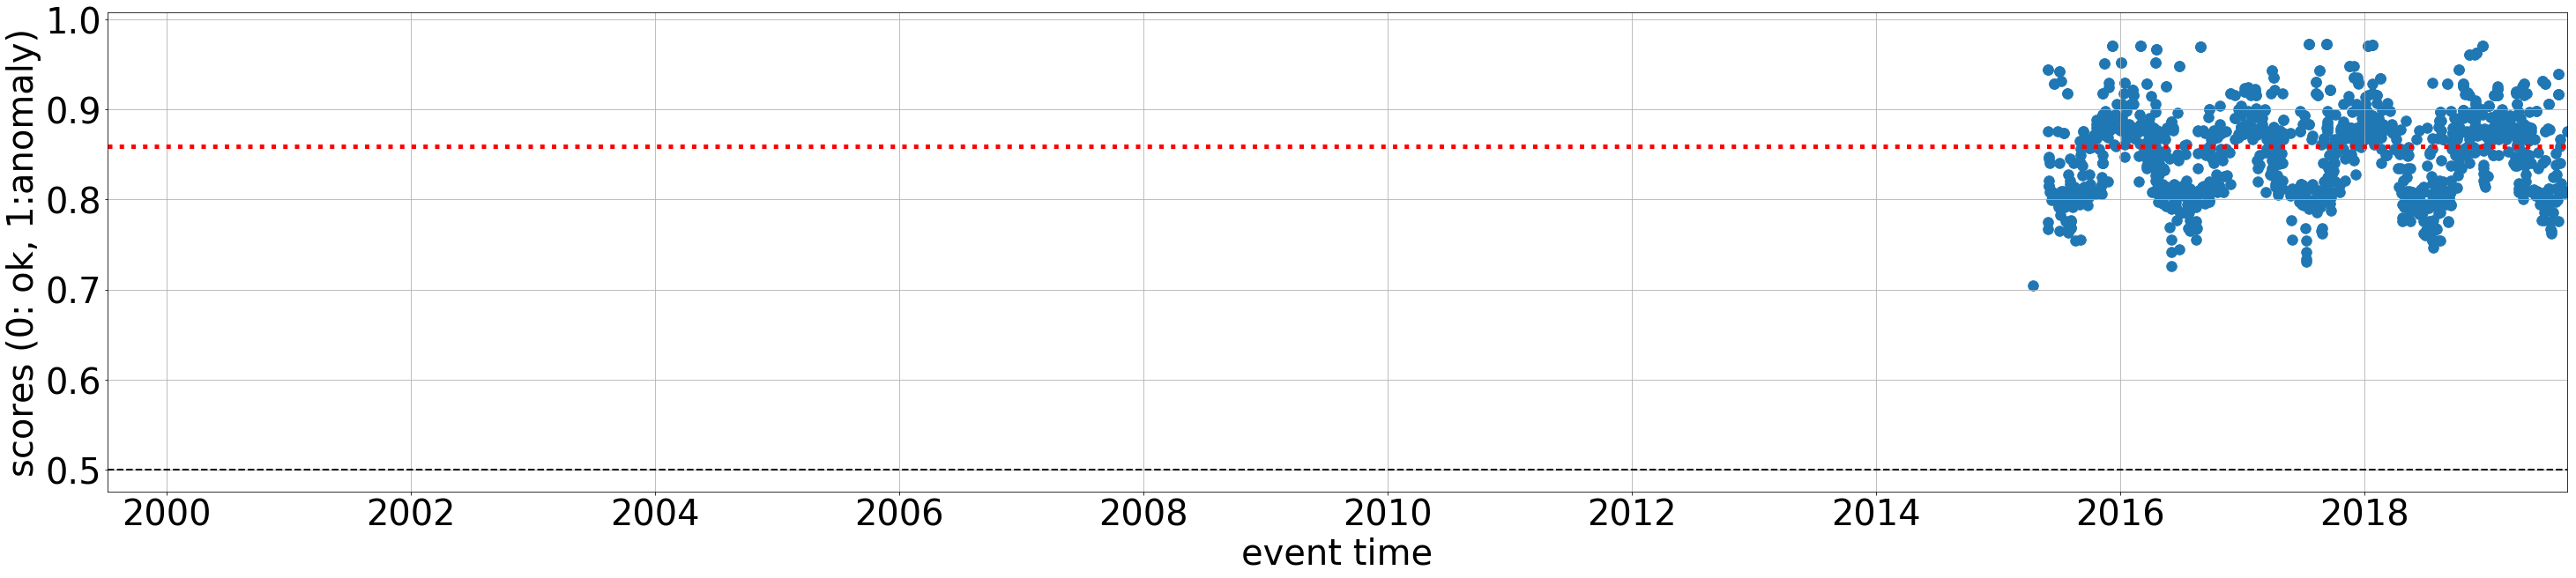

Channel: KO.BAYT..BH? dataset_id: 2 (name: me) Num.segments: 2107 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.853[0] 0.792[1] 0.738[2] 0.841[3] 0.804[4] 0.735[5] 0.831[6] 0.777[7] 0.730[8]


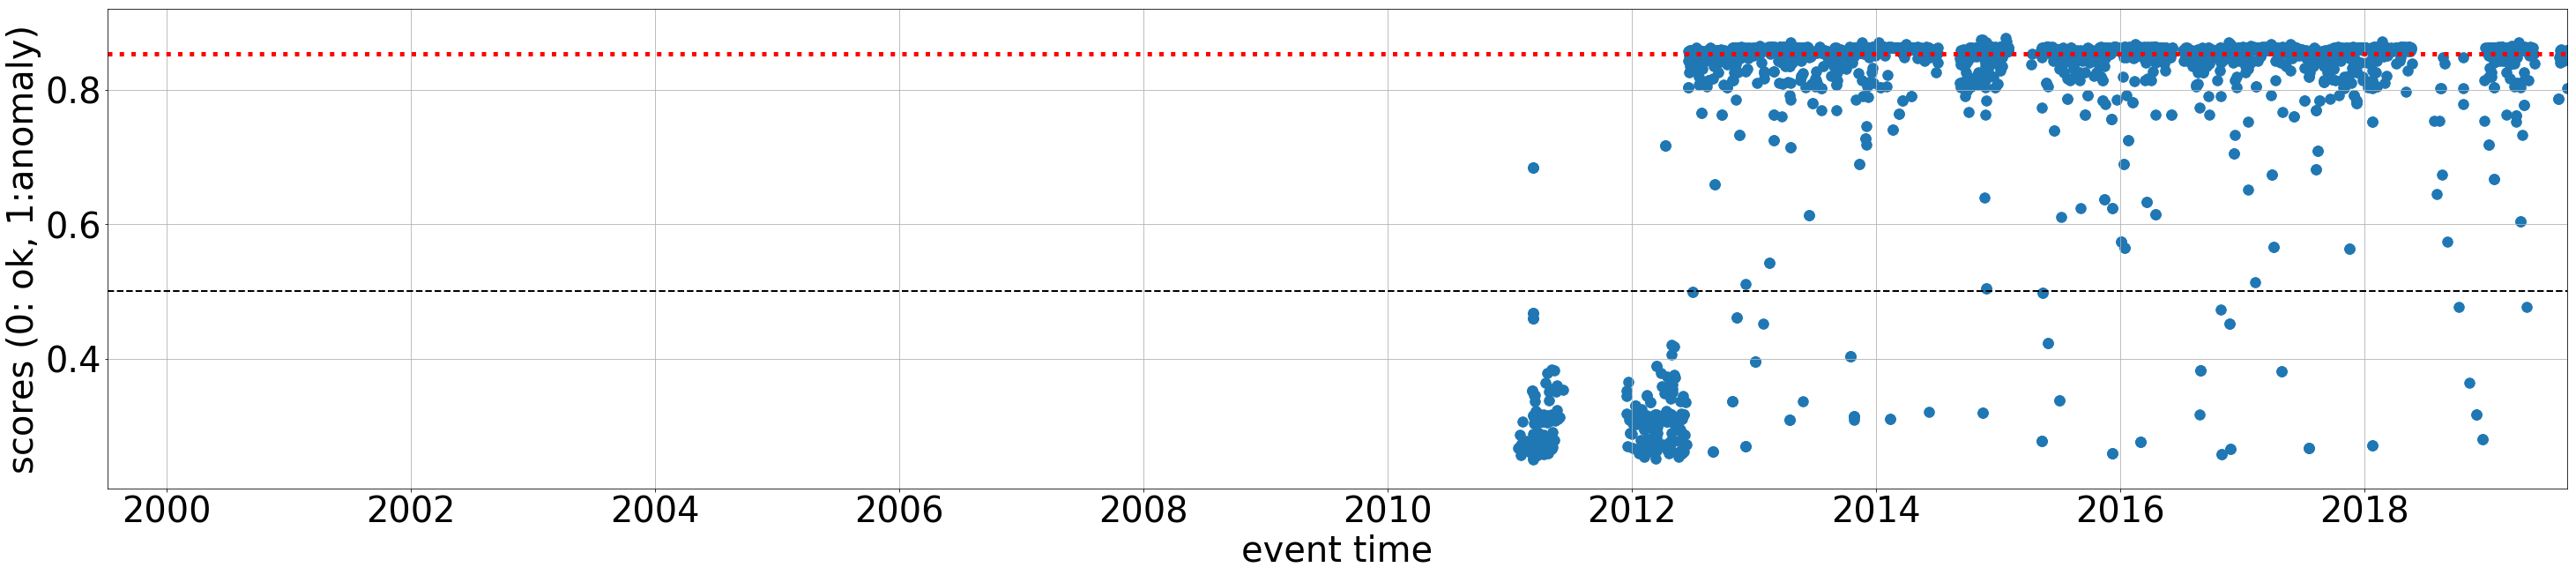

Channel: IV.MABI..BH? dataset_id: 2 (name: me) Num.segments: 484 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.853[0] 0.791[1] 0.738[2] 0.841[3] 0.803[4] 0.740[5] 0.831[6] 0.777[7] 0.732[8]


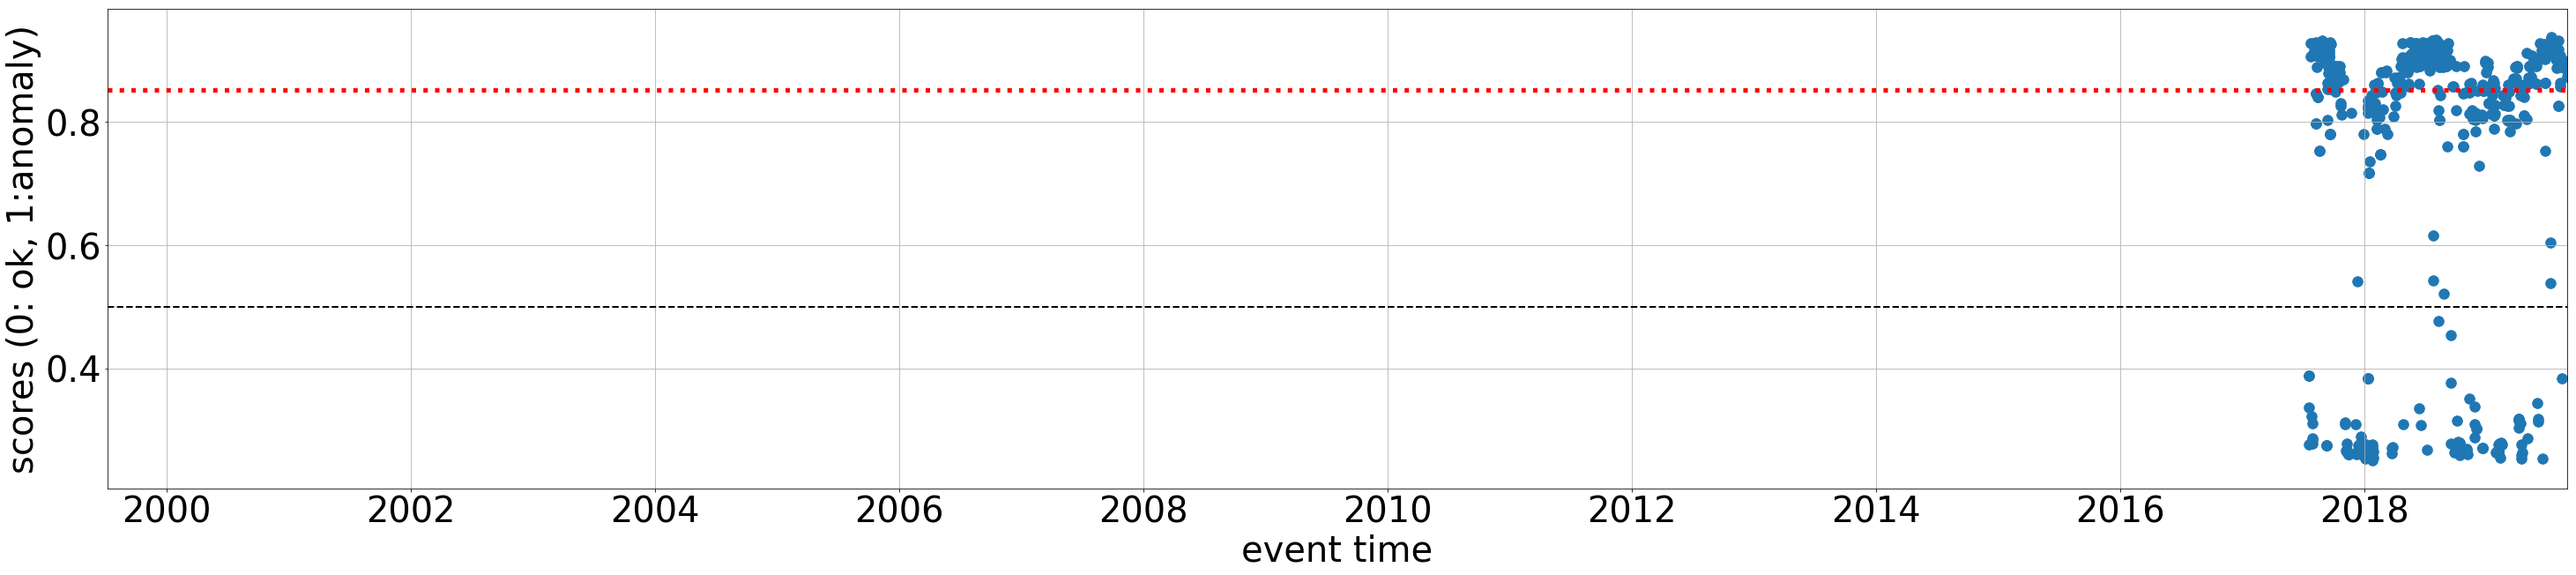

Channel: SL.SKDS..BH? dataset_id: 2 (name: me) Num.segments: 1222 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.852[0] 0.744[1] 0.708[2] 0.843[3] 0.757[4] 0.684[5] 0.841[6] 0.752[7] 0.683[8]


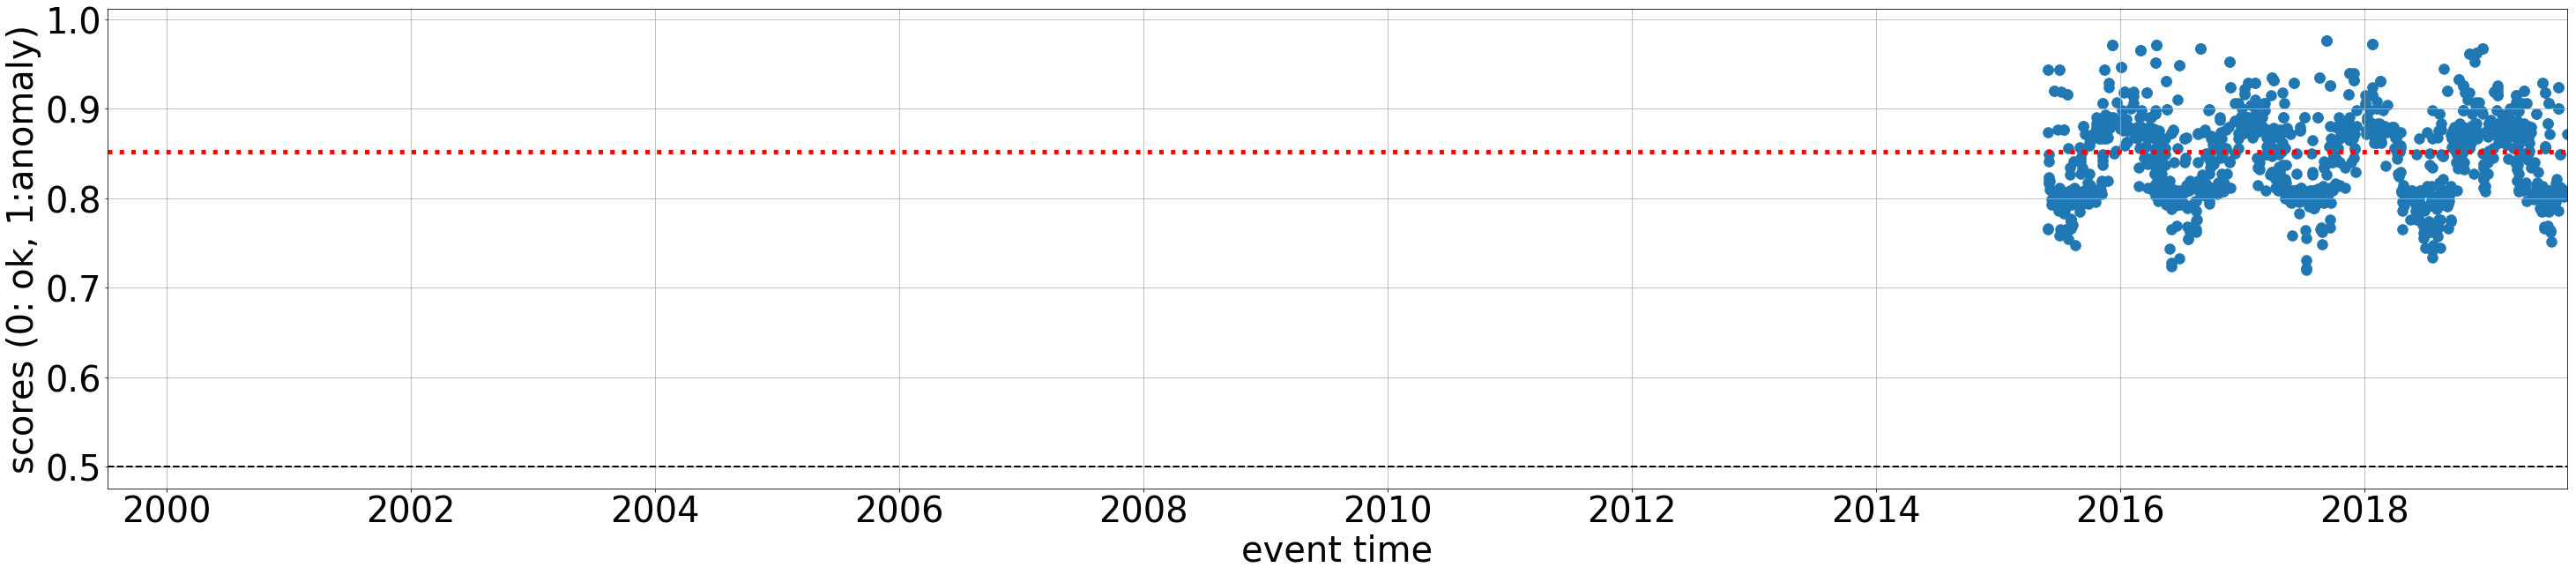

Channel: II.RAYN.00.BH? dataset_id: 2 (name: me) Num.segments: 1691 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.851[0] 0.790[1] 0.738[2] 0.839[3] 0.804[4] 0.739[5] 0.831[6] 0.777[7] 0.732[8]


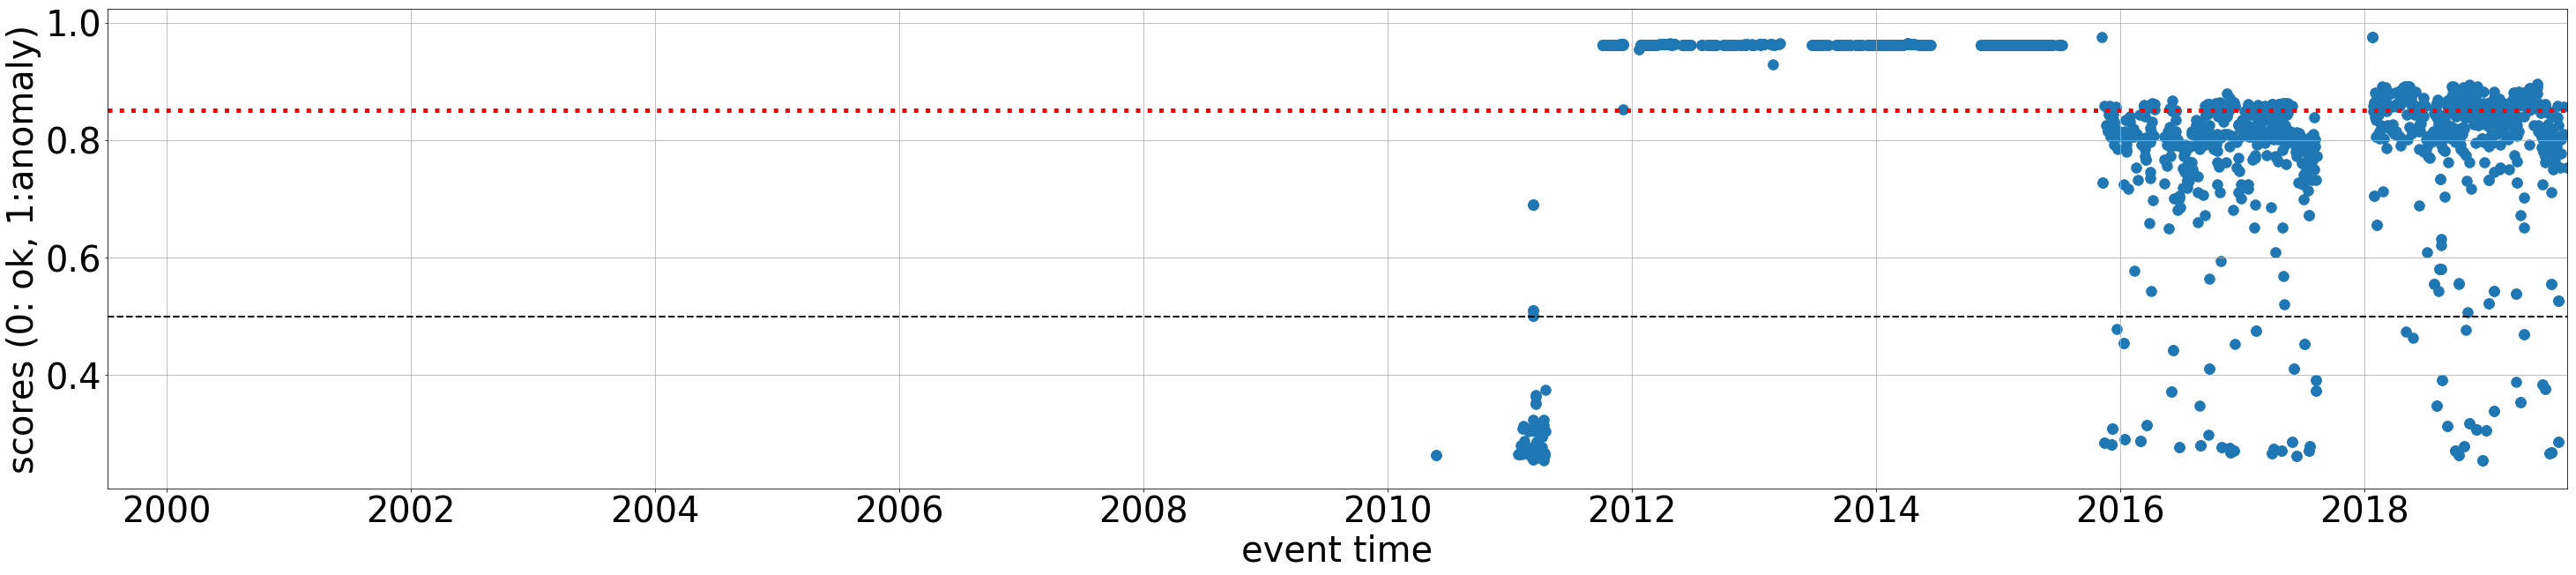

Channel: XW.W13.00.BH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 10 Label: ok
Misclassified by 9 clfs with median scores:  0.837[0] 0.775[1] 0.730[2] 0.837[3] 0.787[4] 0.729[5] 0.841[6] 0.765[7] 0.712[8]


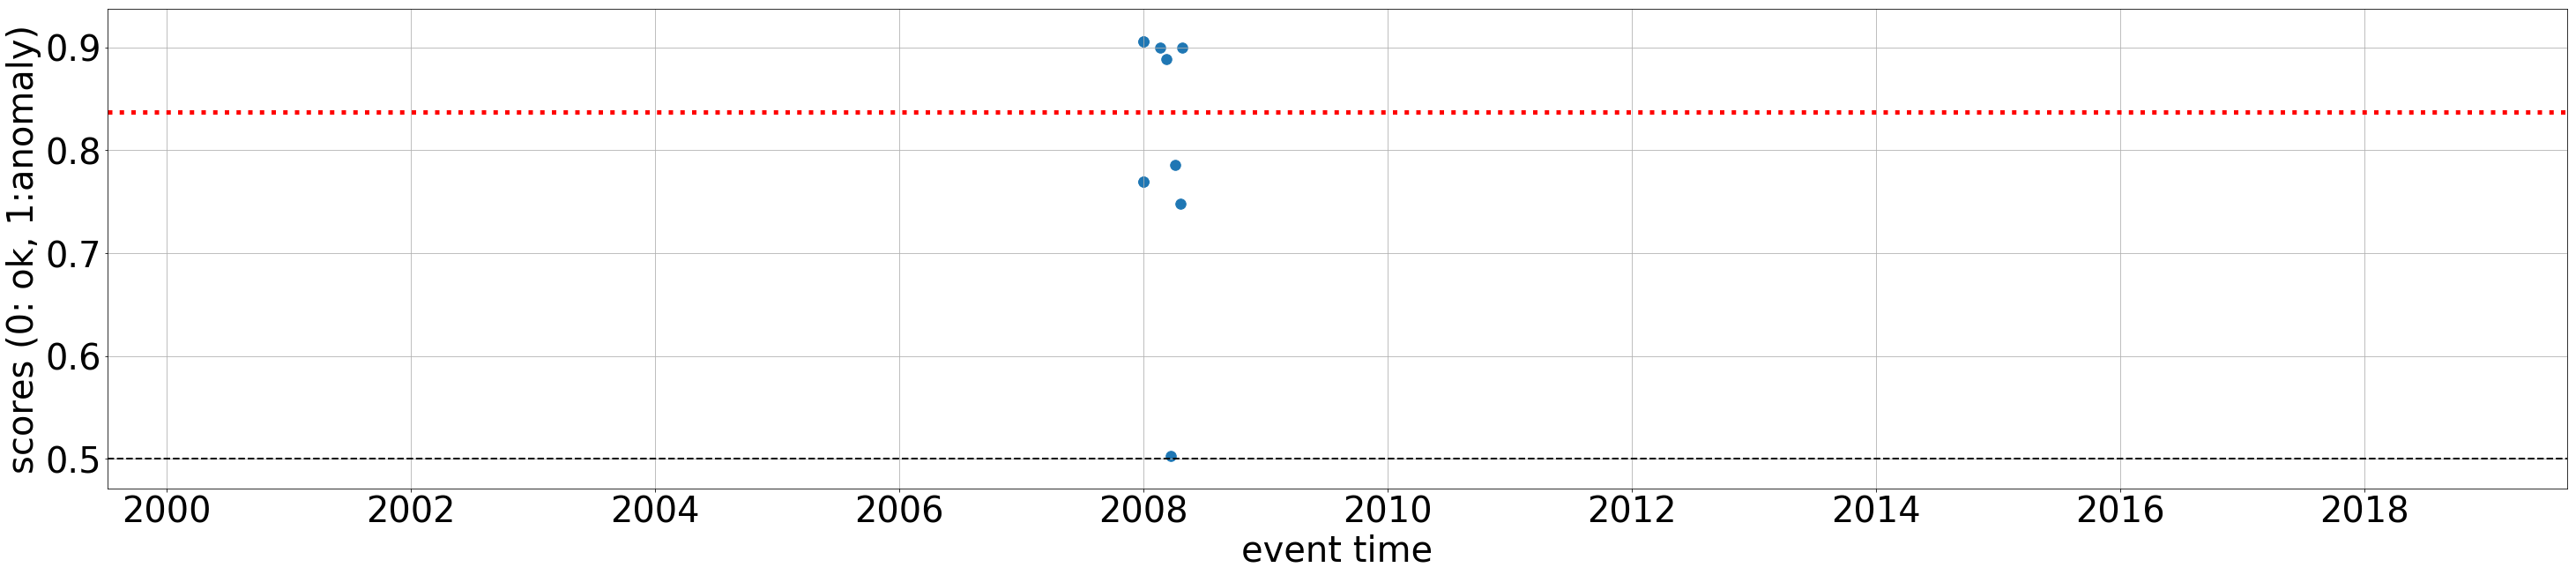

Channel: AF.KAD..BH? dataset_id: 2 (name: me) Num.segments: 33 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.814[0] 0.768[1] 0.727[2] 0.809[3] 0.780[4] 0.734[5] 0.801[6] 0.754[7] 0.708[8]


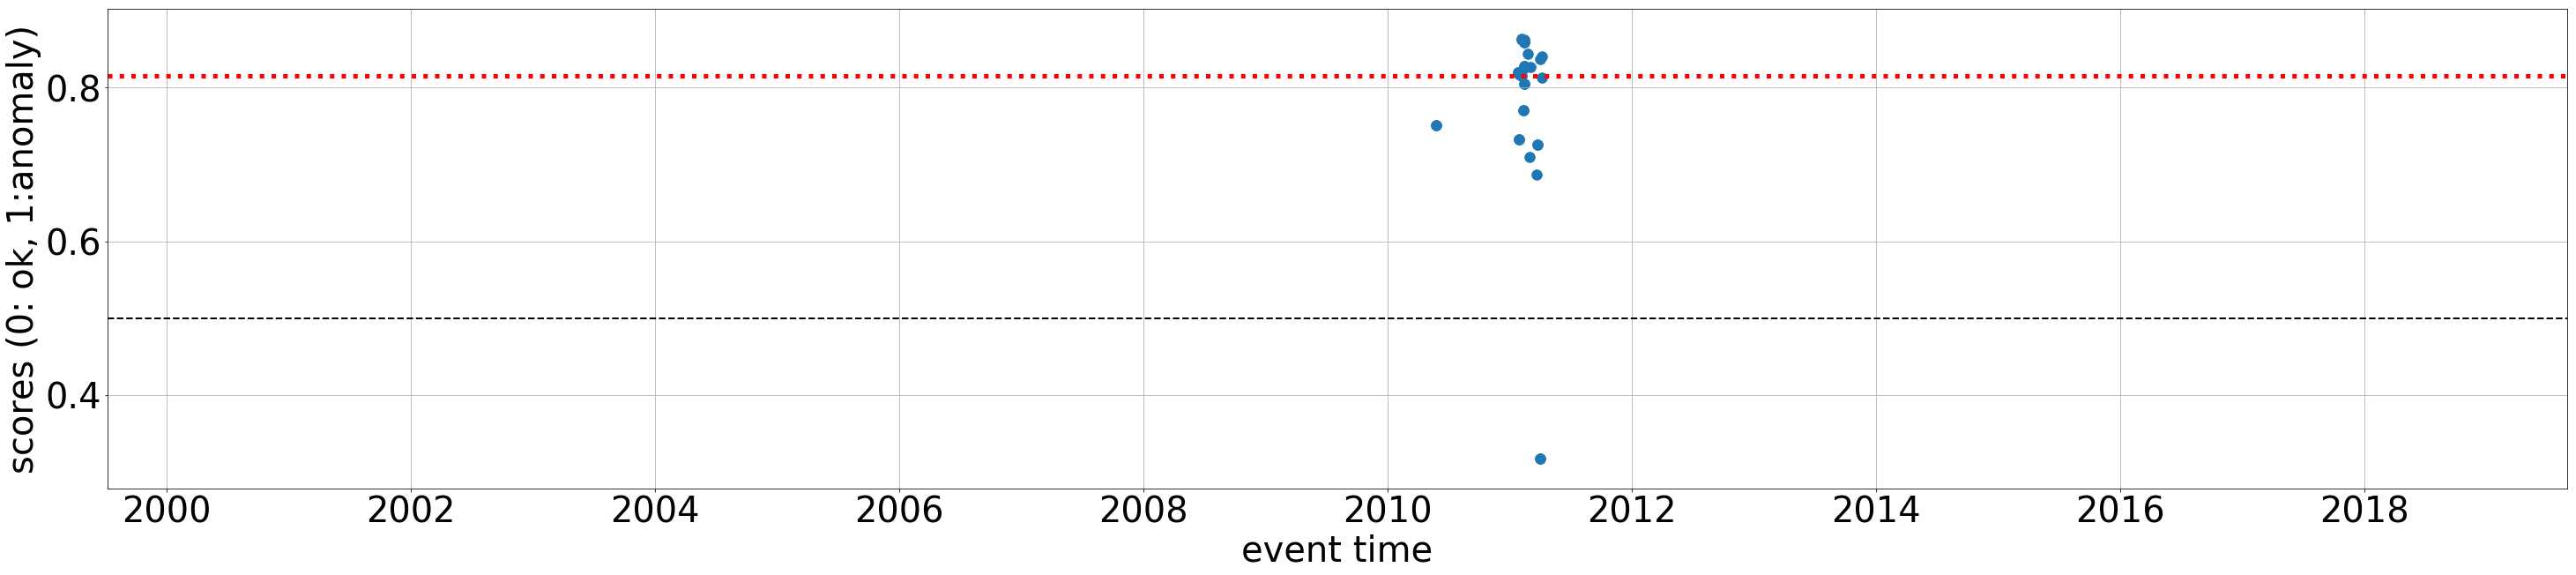

Channel: UK.FULS..BH? dataset_id: 2 (name: me) Num.segments: 65 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.809[0] 0.717[1] 0.683[2] 0.804[3] 0.716[4] 0.652[5] 0.792[6] 0.704[7] 0.660[8]


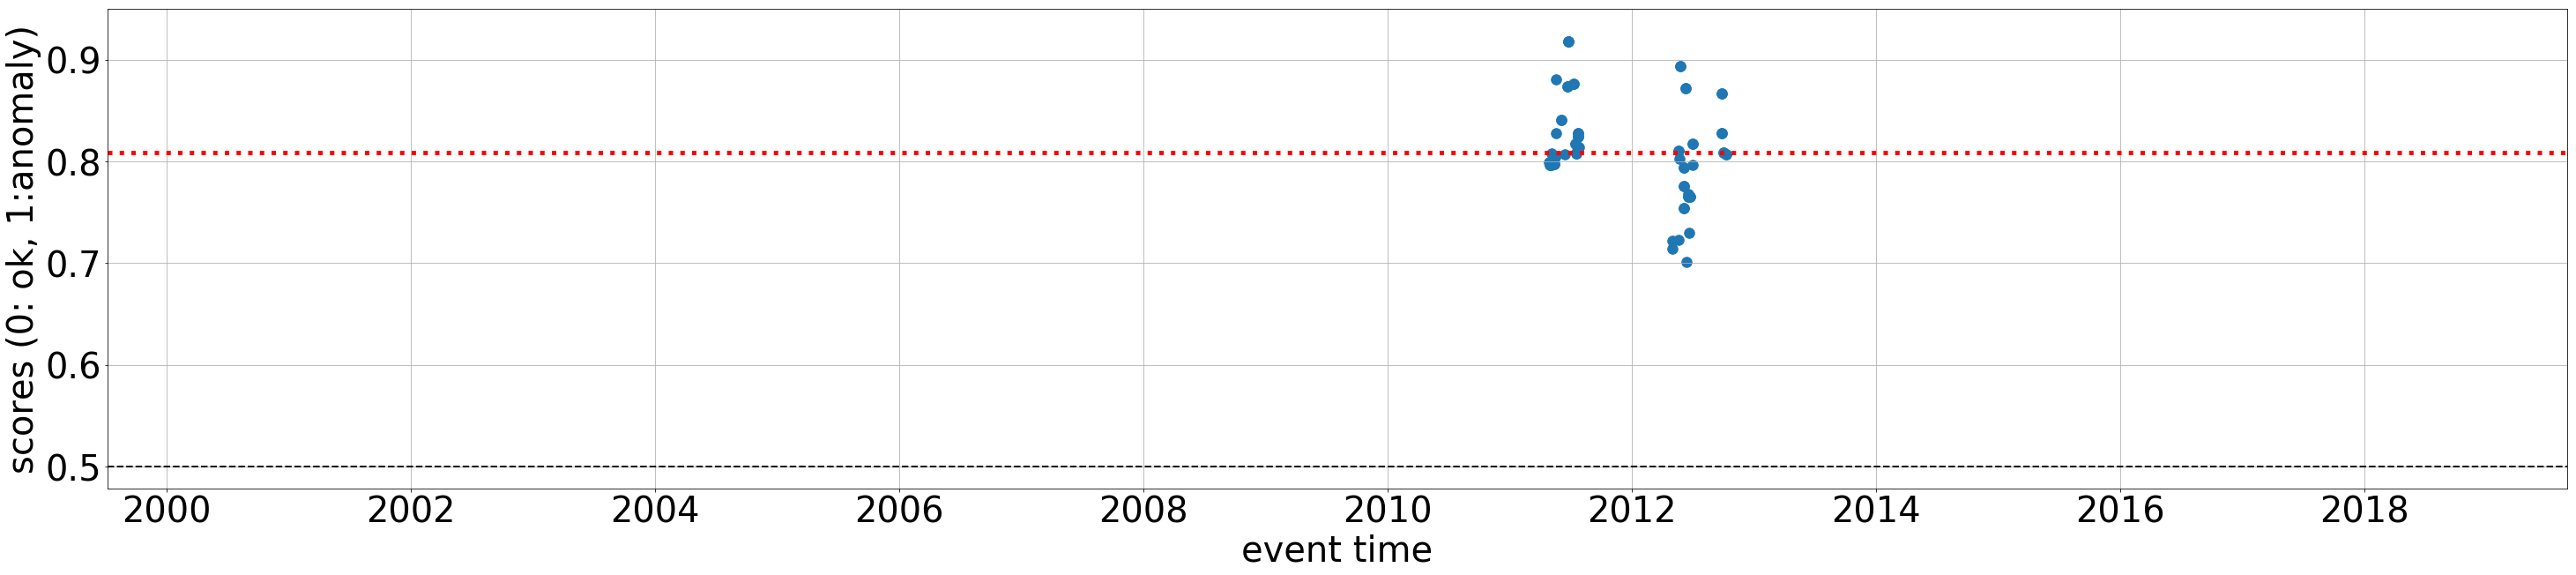

Channel: RD.FLAF..BH? dataset_id: 2 (name: me) Num.segments: 214 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.803[0] 0.707[1] 0.674[2] 0.794[3] 0.706[4] 0.649[5] 0.787[6] 0.699[7] 0.658[8]


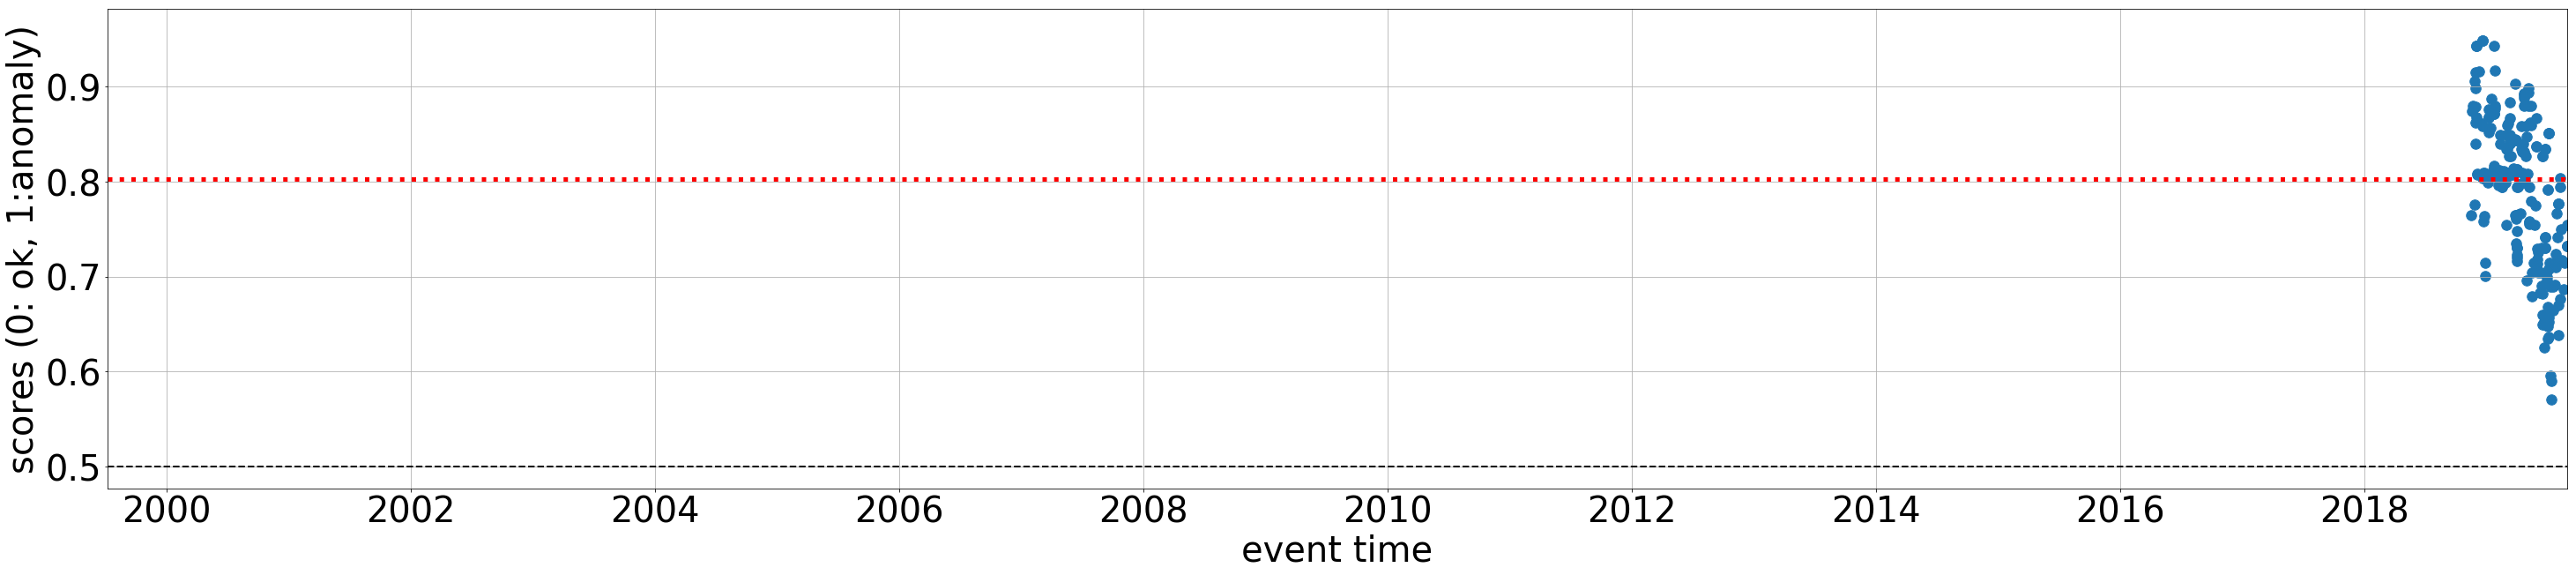

Channel: IS.MMA0B..BH? dataset_id: 2 (name: me) Num.segments: 1706 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.797[0] 0.743[1] 0.709[2] 0.798[3] 0.757[4] 0.704[5] 0.795[6] 0.727[7] 0.680[8]


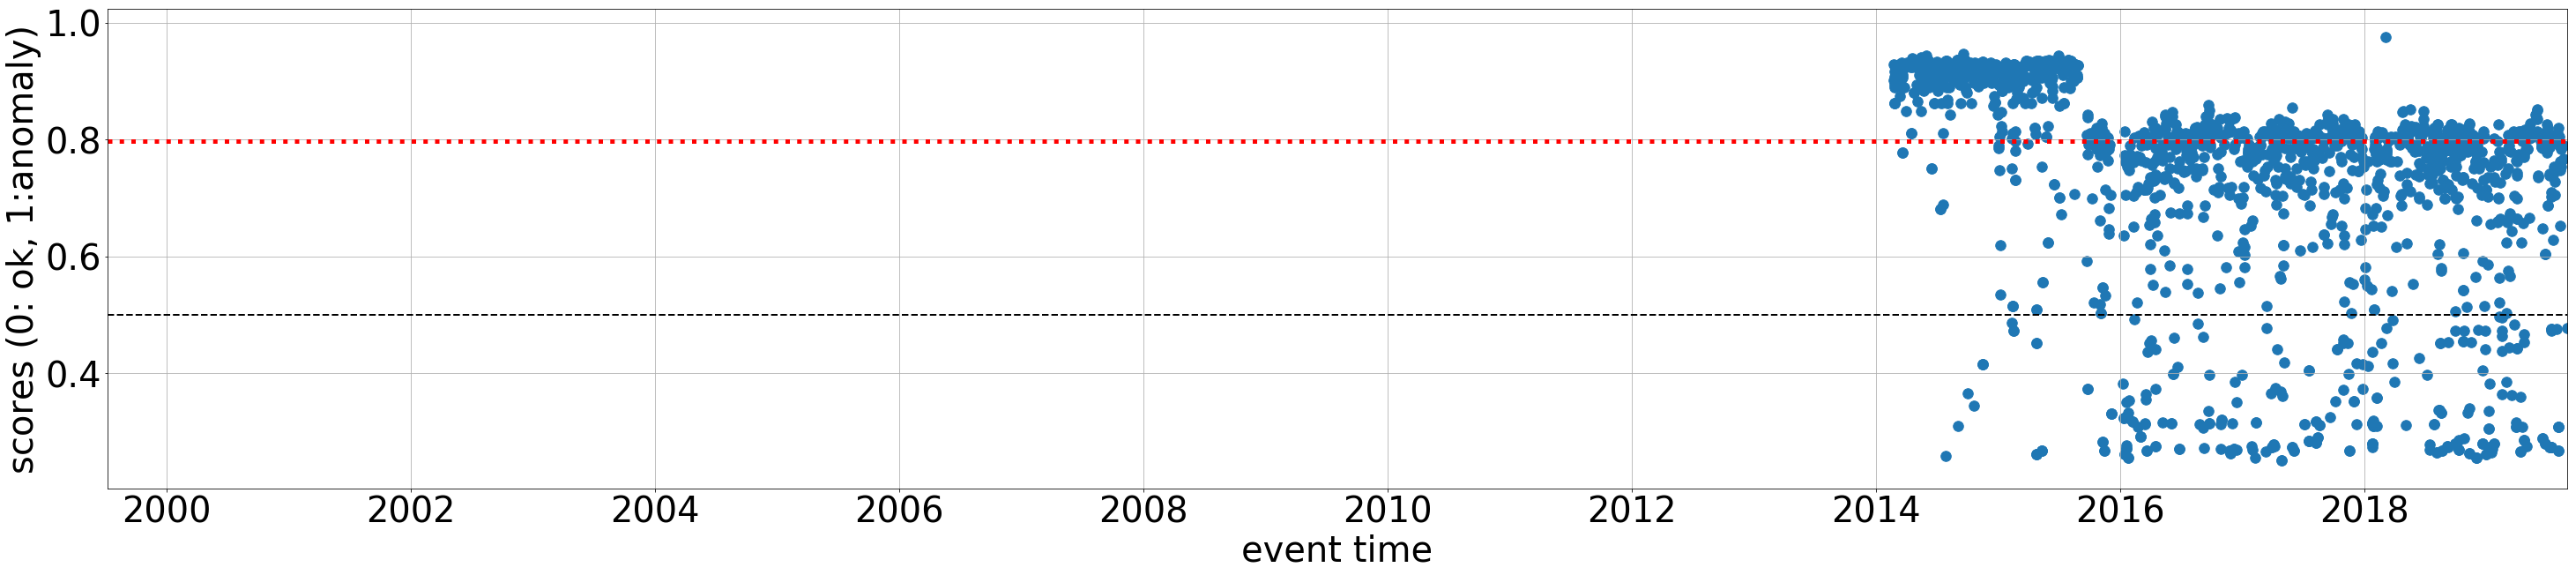

Channel: TM.PRAC..BH? dataset_id: 2 (name: me) Num.segments: 1860 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.793[0] 0.699[1] 0.663[2] 0.780[3] 0.699[4] 0.637[5] 0.777[6] 0.682[7] 0.642[8]


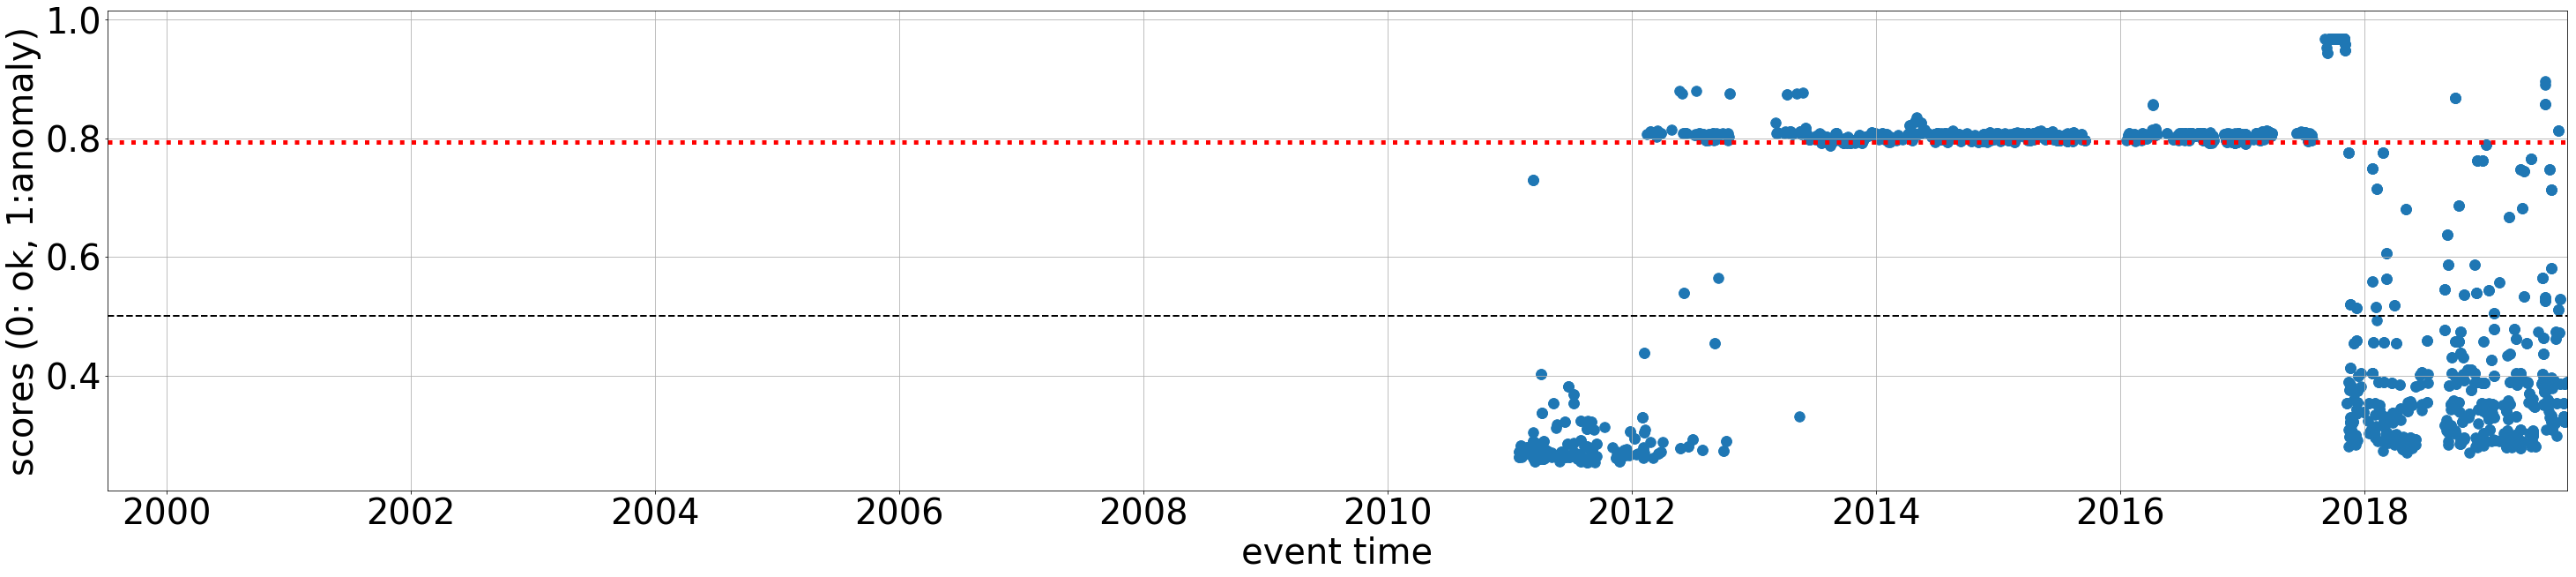

Channel: NJ.KAD..BH? dataset_id: 2 (name: me) Num.segments: 16 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.790[0] 0.736[1] 0.702[2] 0.788[3] 0.745[4] 0.700[5] 0.781[6] 0.720[7] 0.683[8]


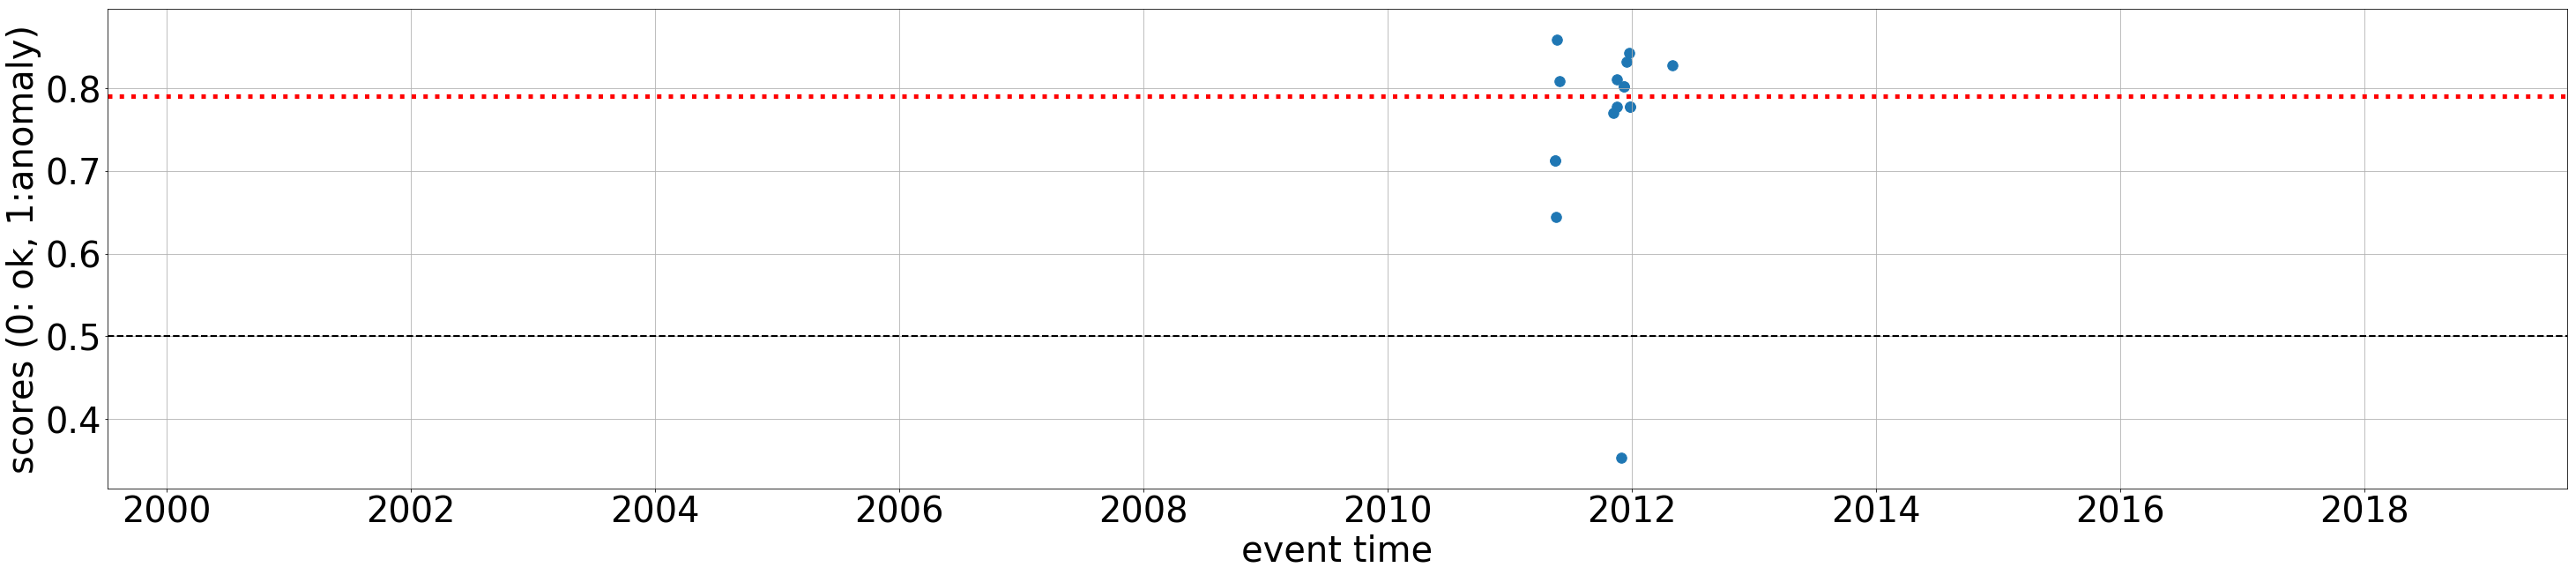

Channel: TM.TMDB..BH? dataset_id: 2 (name: me) Num.segments: 923 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.780[0] 0.730[1] 0.698[2] 0.777[3] 0.734[4] 0.692[5] 0.766[6] 0.712[7] 0.677[8]


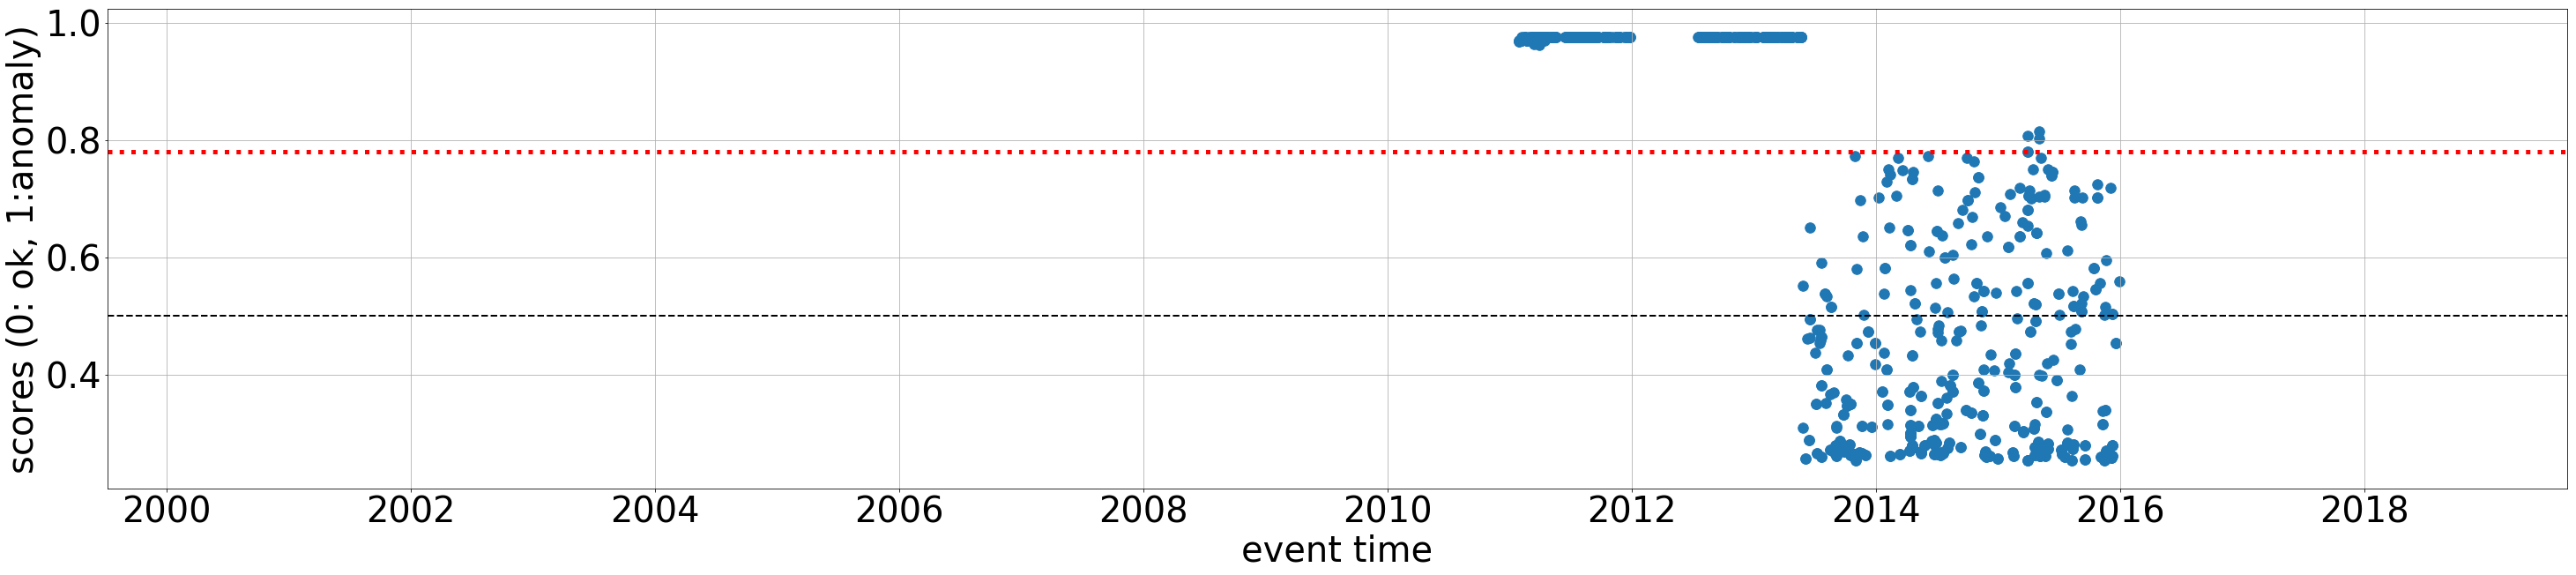

Channel: NJ.IFE..BH? dataset_id: 2 (name: me) Num.segments: 43 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.763[0] 0.713[1] 0.676[2] 0.760[3] 0.727[4] 0.688[5] 0.747[6] 0.703[7] 0.661[8]


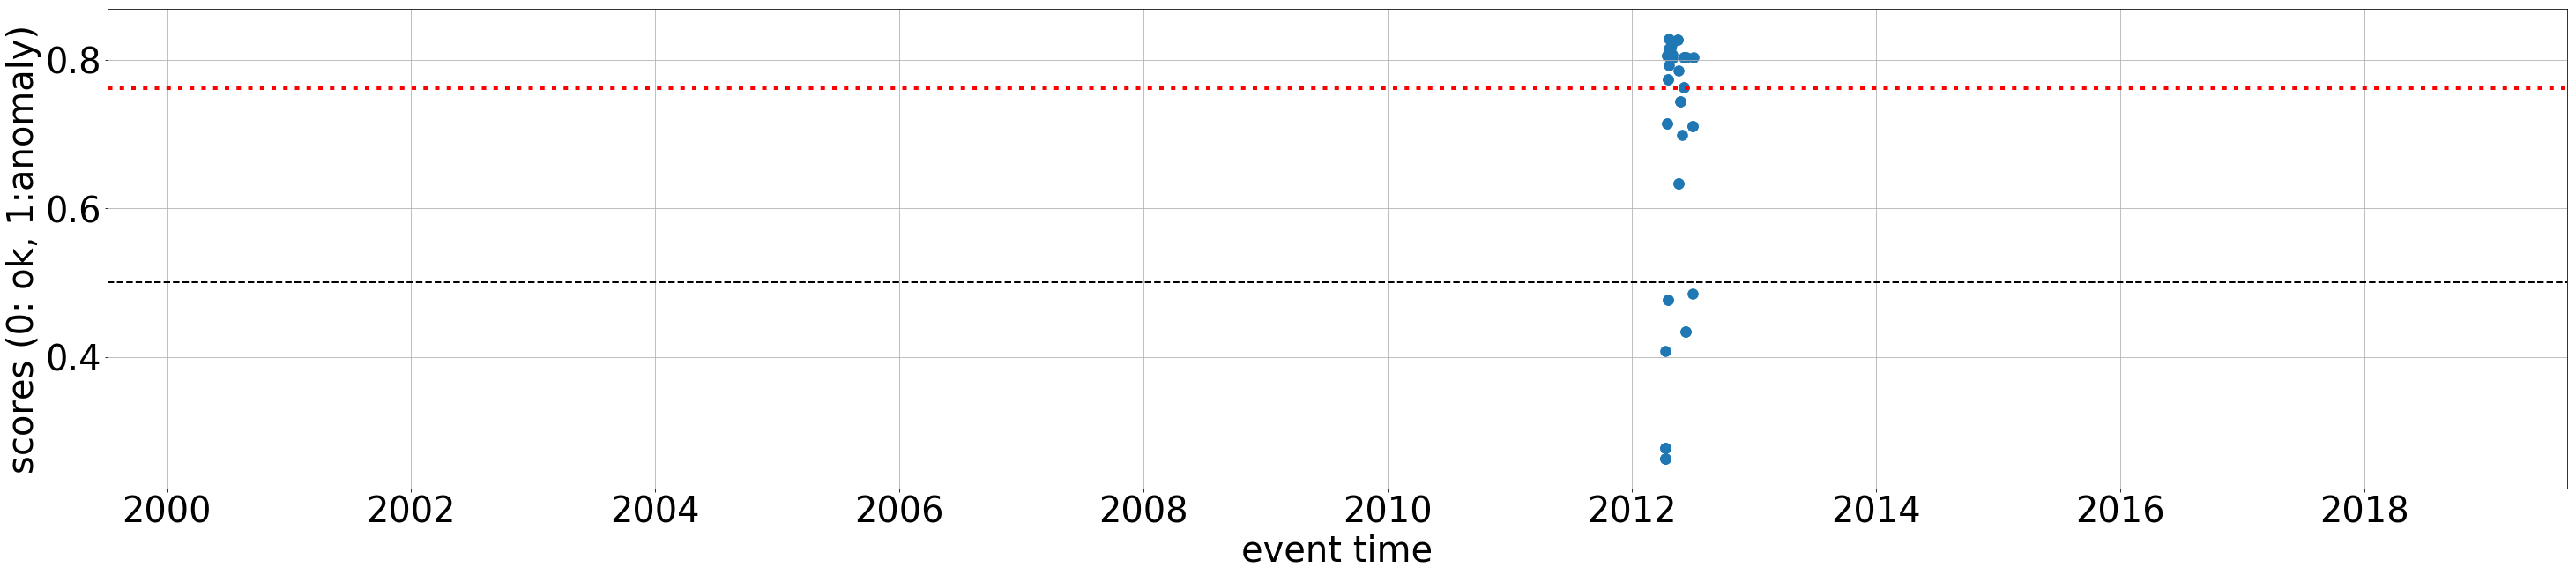

Channel: UD.MI30..BH? dataset_id: 2 (name: me) Num.segments: 70 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.751[0] 0.693[1] 0.653[2] 0.746[3] 0.699[4] 0.641[5] 0.756[6] 0.685[7] 0.644[8]


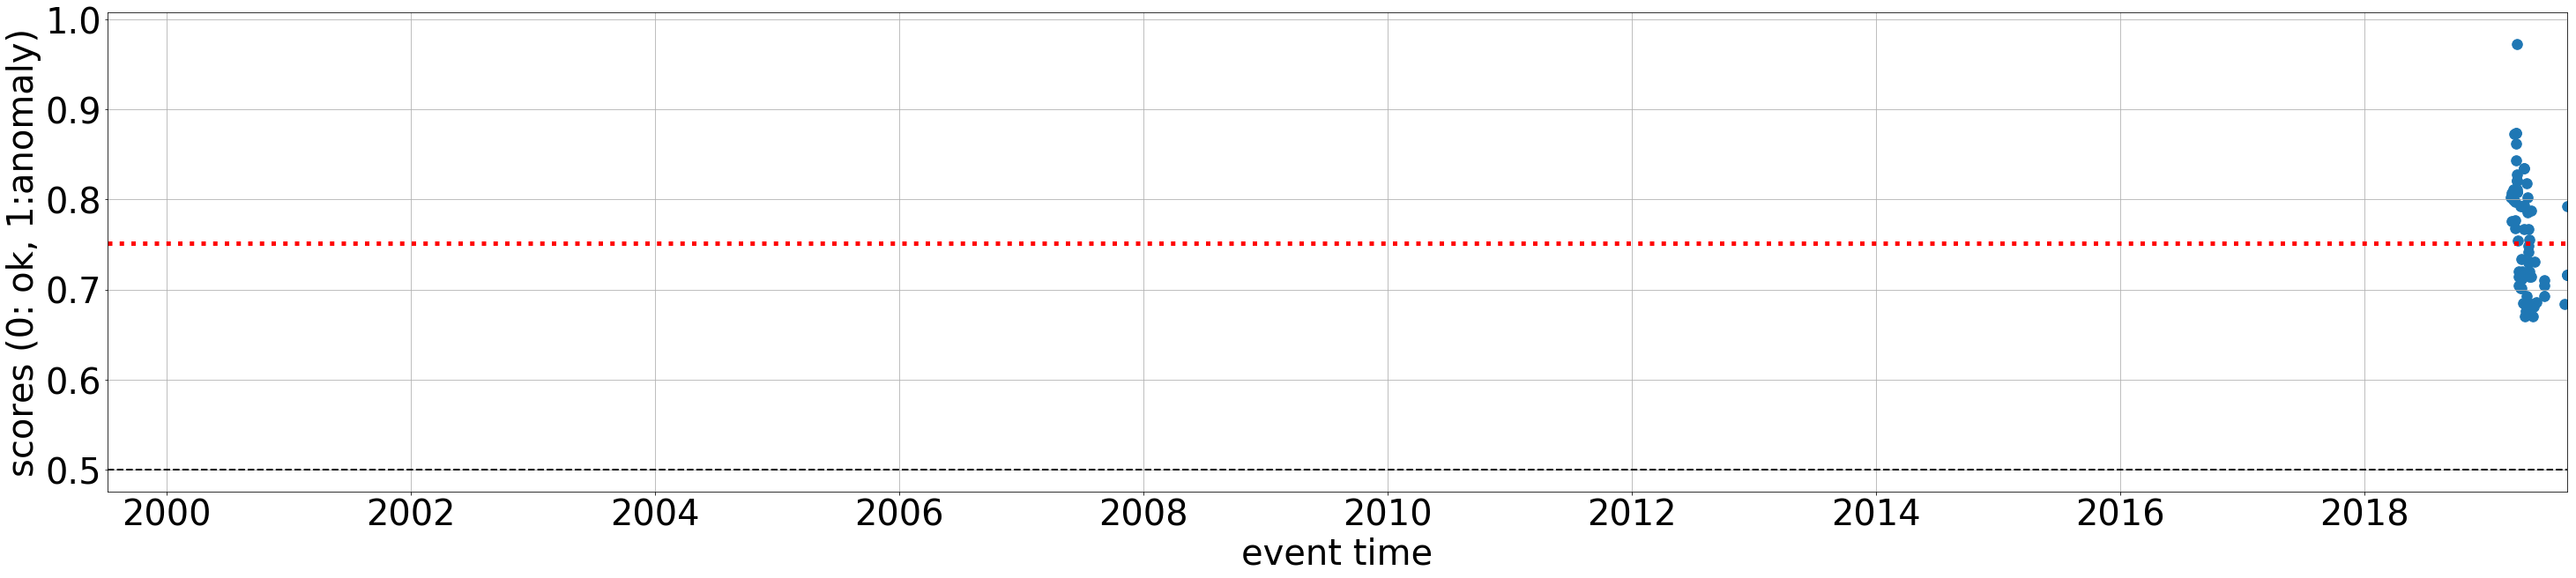

Channel: AF.SKRH..BH? dataset_id: 2 (name: me) Num.segments: 280 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.750[0] 0.700[1] 0.664[2] 0.739[3] 0.713[4] 0.676[5] 0.741[6] 0.692[7] 0.651[8]


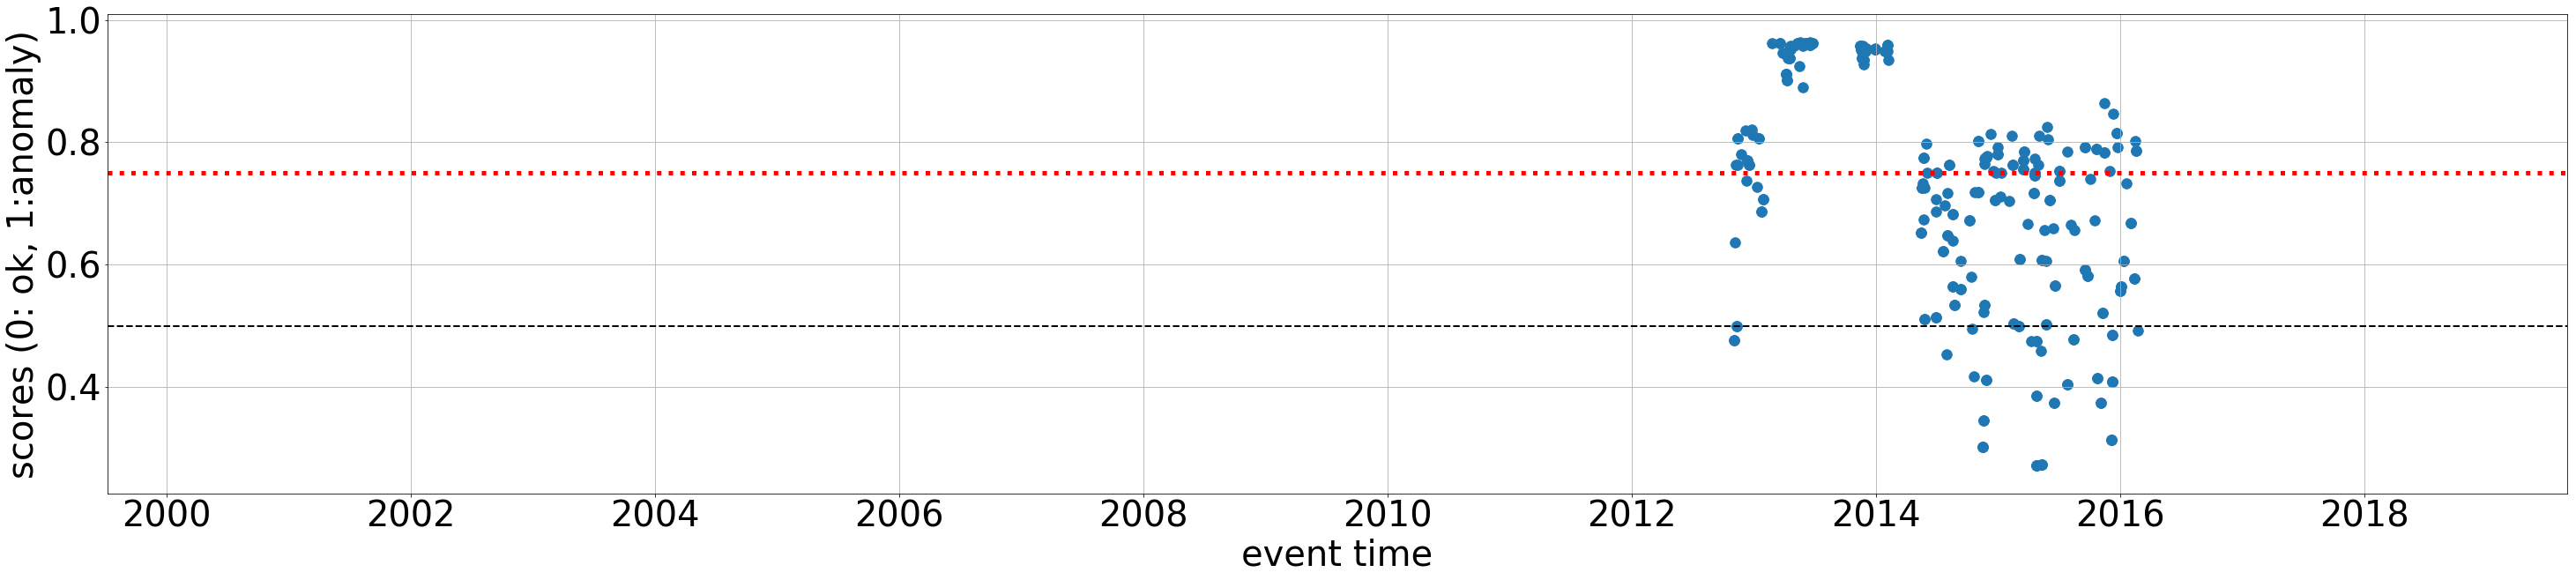

Channel: AU.AS31..BH? dataset_id: 2 (name: me) Num.segments: 2258 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.746[0] 0.695[1] 0.656[2] 0.735[3] 0.709[4] 0.665[5] 0.741[6] 0.685[7] 0.648[8]


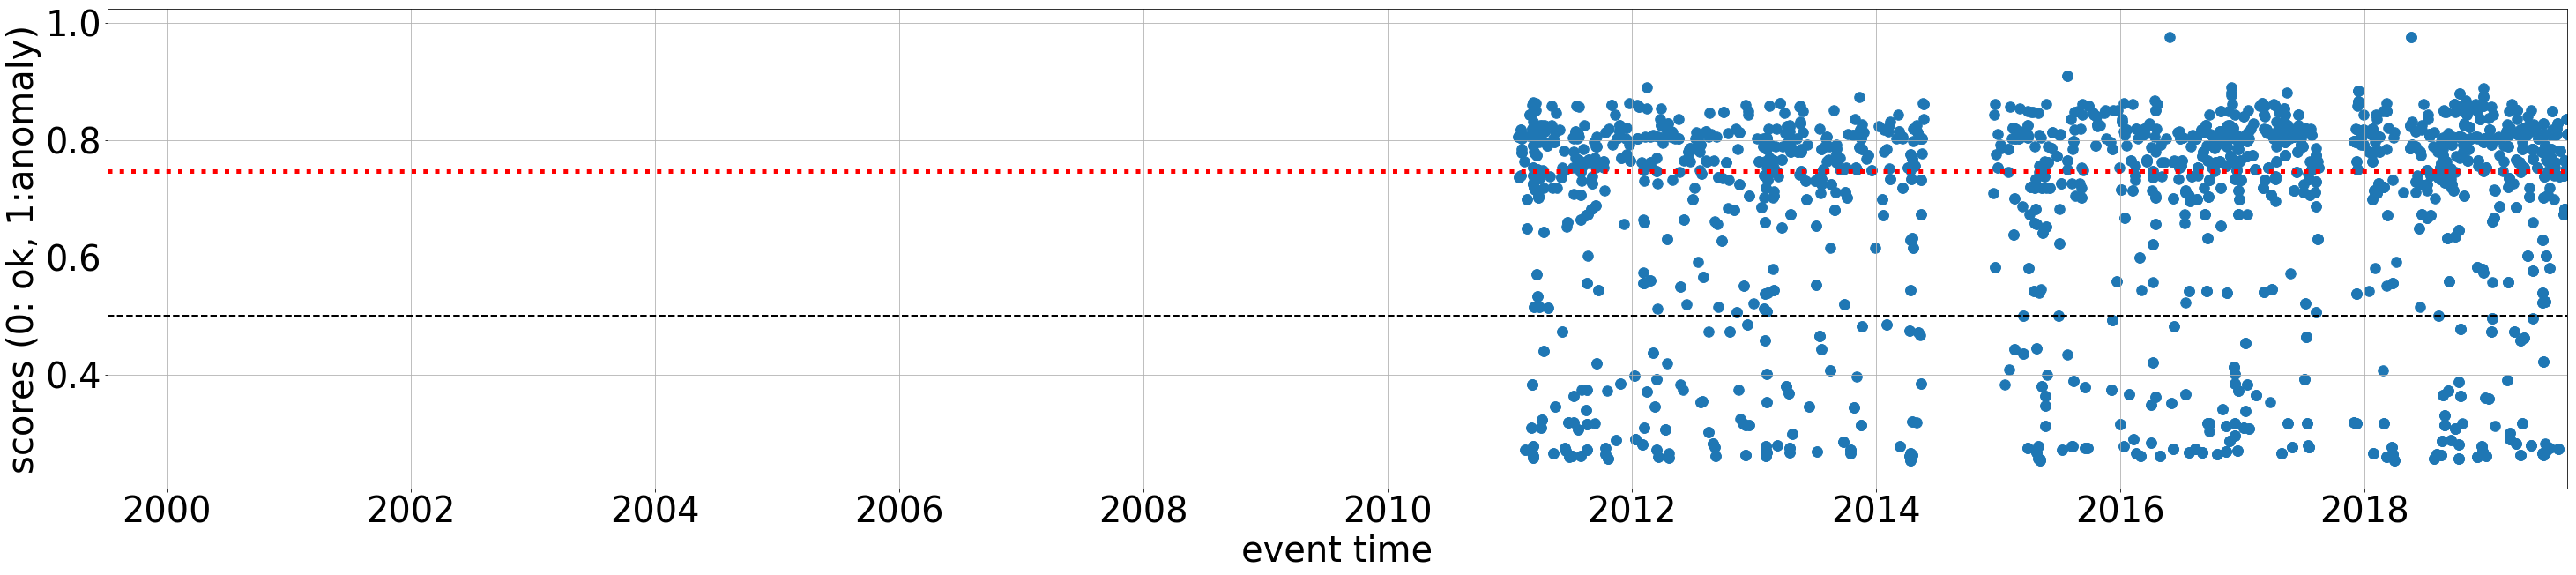

Channel: AF.IFE..BH? dataset_id: 2 (name: me) Num.segments: 59 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.739[0] 0.691[1] 0.652[2] 0.730[3] 0.704[4] 0.661[5] 0.734[6] 0.682[7] 0.636[8]


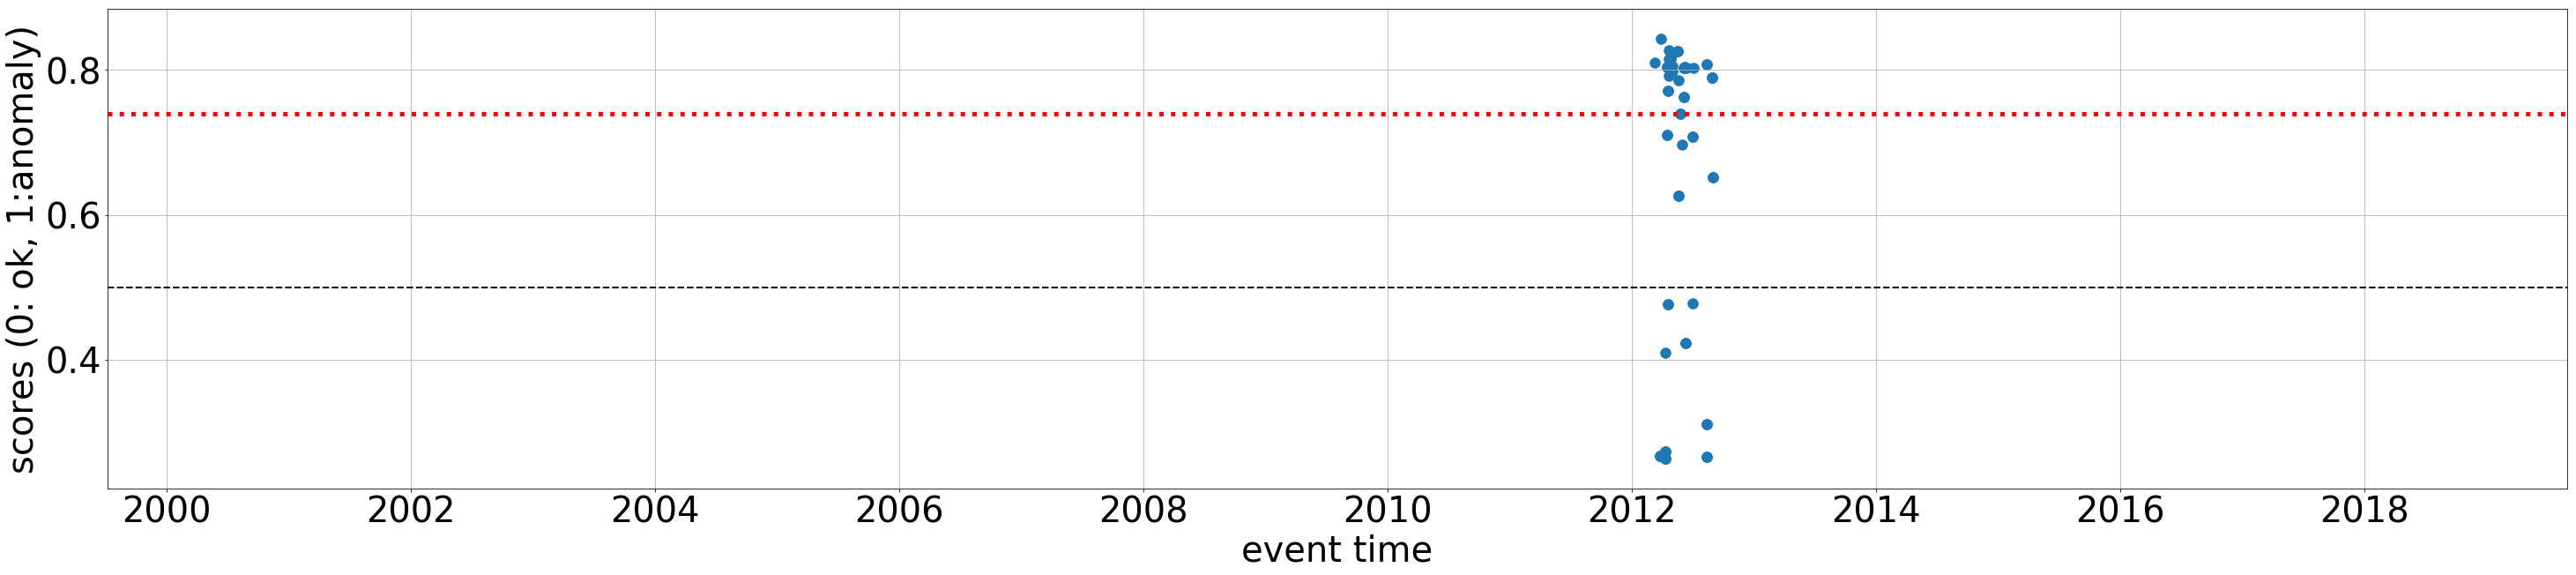

Channel: DK.COP.00.BH? dataset_id: 2 (name: me) Num.segments: 16 Label: unlabeled (Me unknown)
Misclassified by 18 clfs with median scores:  0.715[0] 0.976[0] 0.674[1] 0.975[1] 0.637[2] 0.965[2] 0.713[3] 0.977[3] 0.680[4] 0.983[4] 0.628[5] 0.981[5] 0.726[6] 0.996[6] 0.670[7] 0.962[7] 0.625[8] 0.973[8]


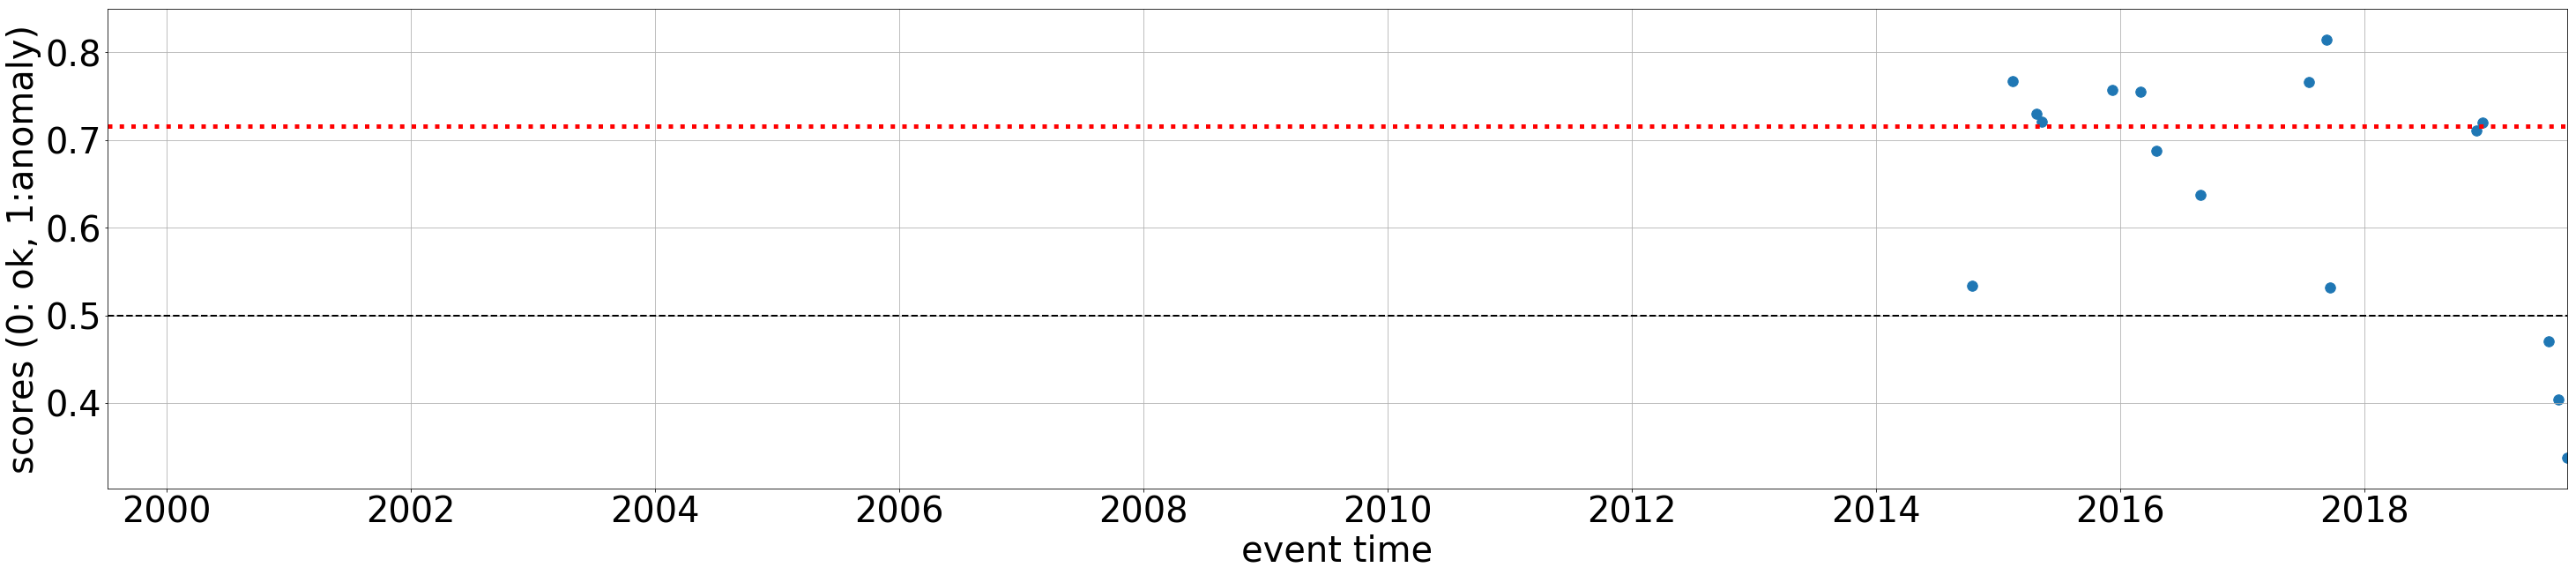

Channel: FR.ESCA.00.HN? dataset_id: 1 (name: s2s_2019_03) Num.segments: 19 Label: ok
Misclassified by 9 clfs with median scores:  0.710[0] 0.651[1] 0.616[2] 0.709[3] 0.659[4] 0.626[5] 0.714[6] 0.636[7] 0.614[8]


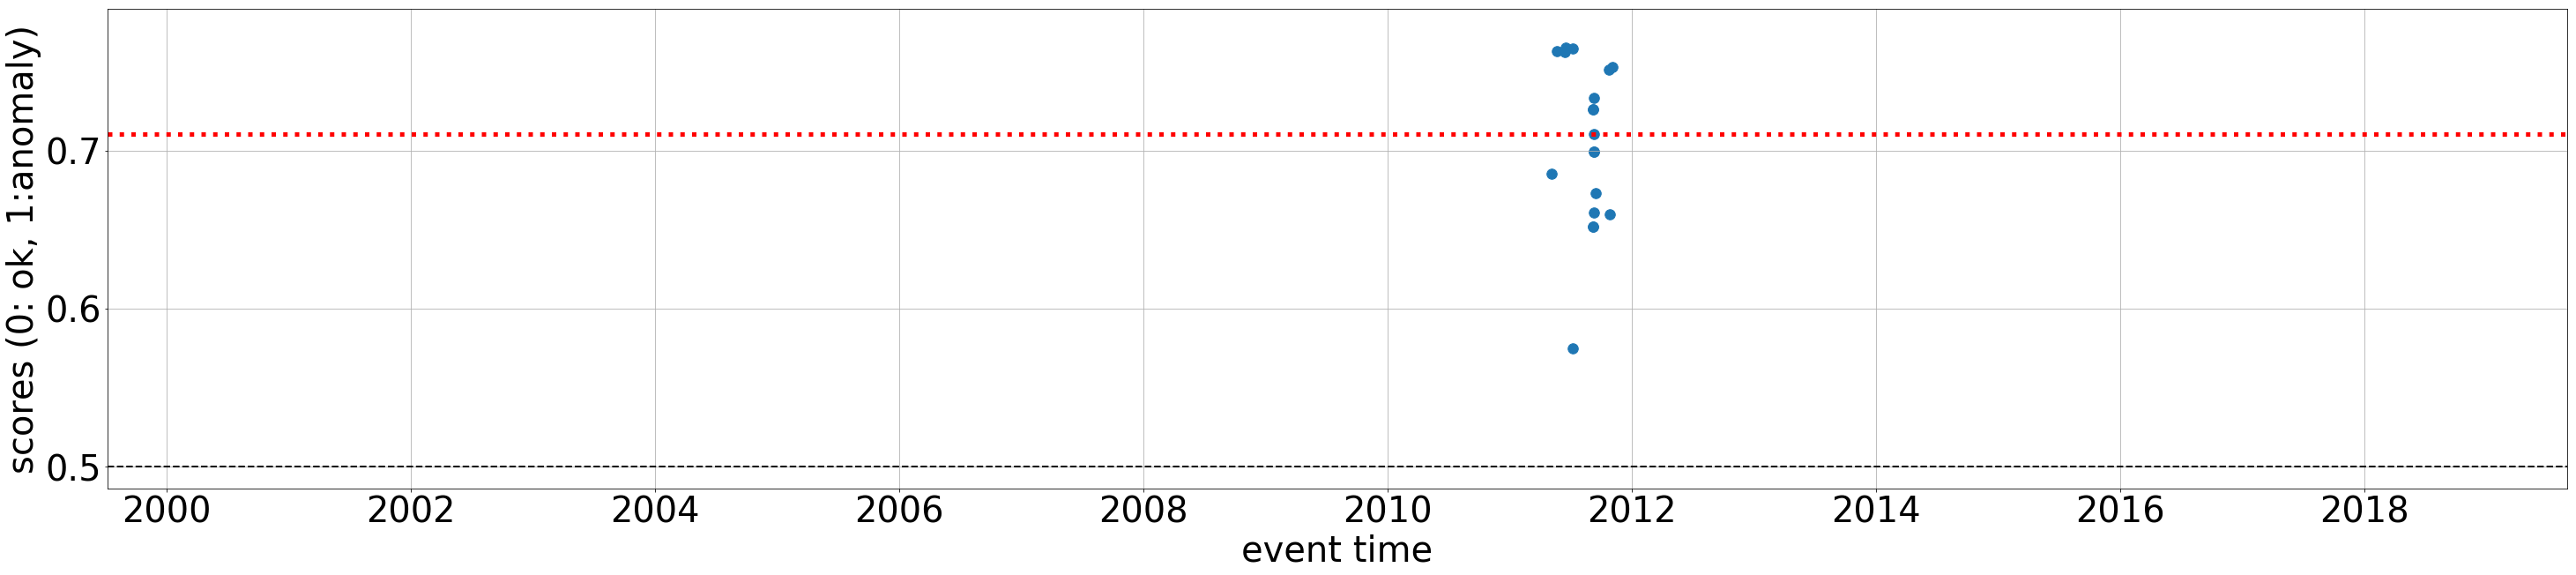

Channel: PR.CUPR..BH? dataset_id: 2 (name: me) Num.segments: 460 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.691[0] 0.617[1] 0.589[2] 0.691[3] 0.638[4] 0.598[5] 0.688[6] 0.614[7] 0.598[8]


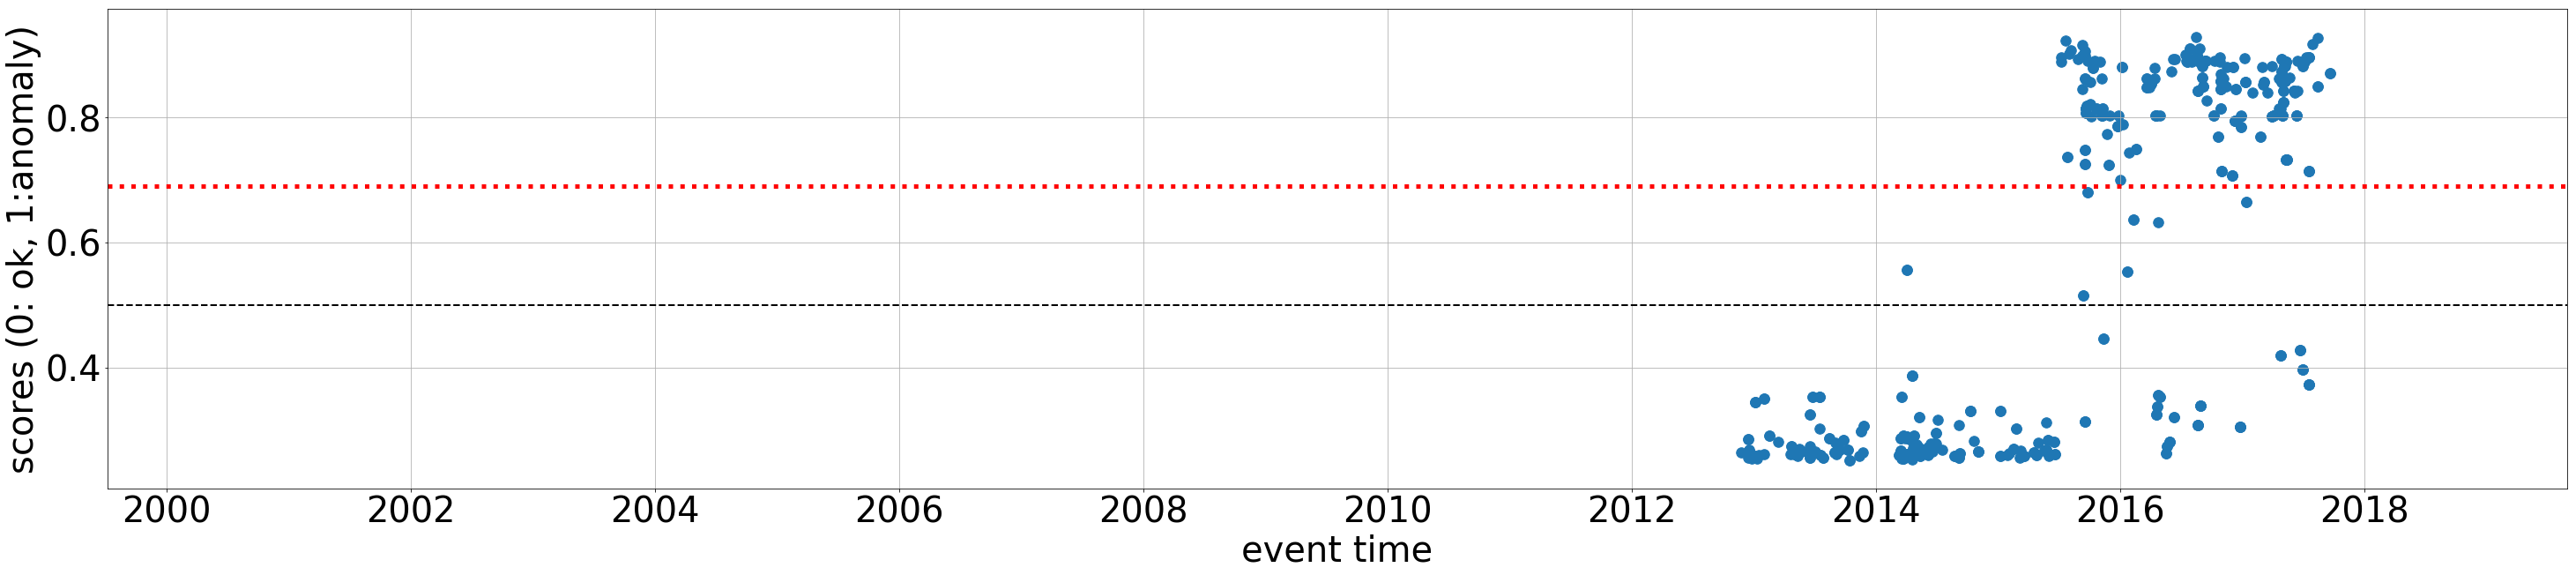

Channel: TM.LOEI..BH? dataset_id: 2 (name: me) Num.segments: 1961 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.684[0] 0.644[1] 0.611[2] 0.685[3] 0.639[4] 0.610[5] 0.709[6] 0.648[7] 0.609[8]


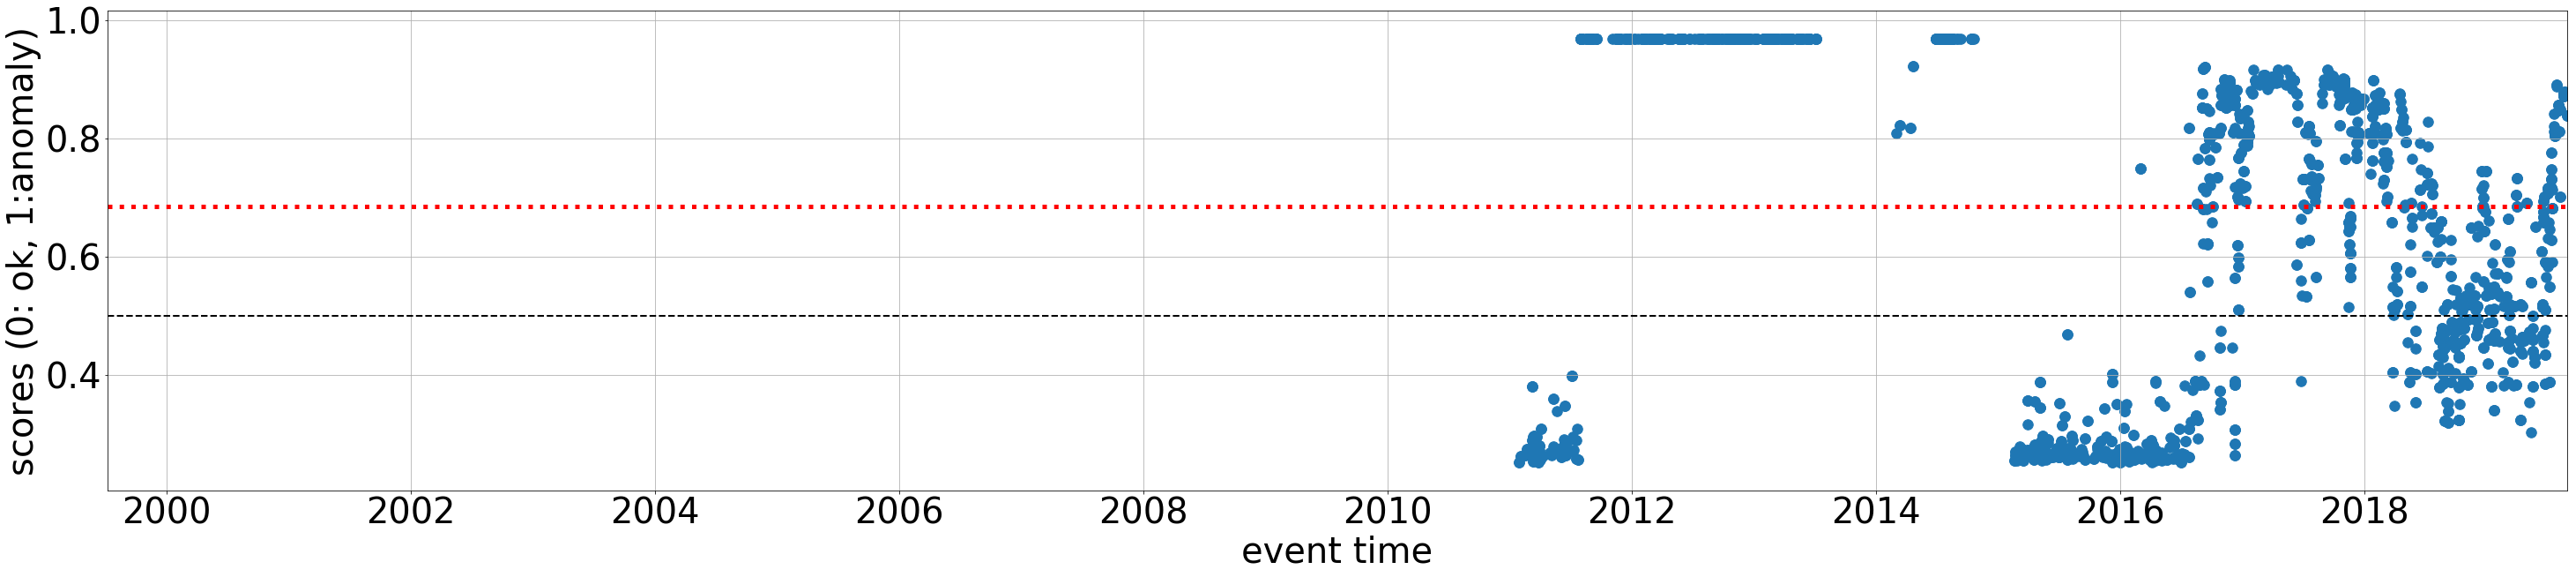

Channel: GE.SNAA..BH? dataset_id: 2 (name: me) Num.segments: 1673 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.682[0] 0.641[1] 0.605[2] 0.685[3] 0.638[4] 0.606[5] 0.709[6] 0.643[7] 0.606[8]


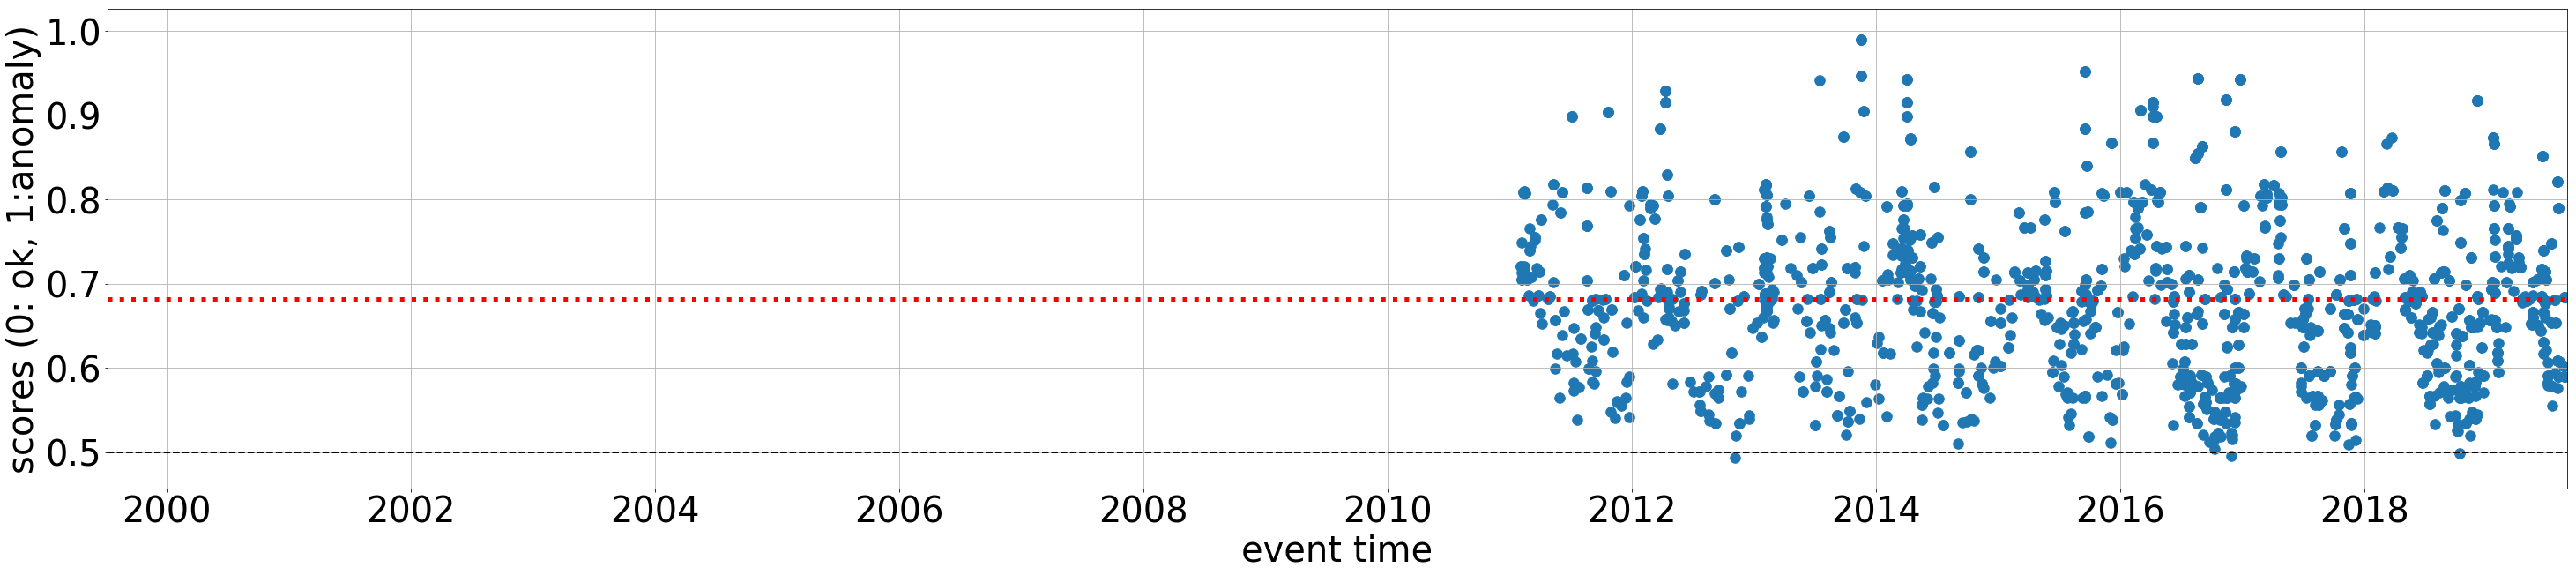

Channel: NJ.NSU..BH? dataset_id: 2 (name: me) Num.segments: 27 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.659[0] 0.588[1] 0.565[2] 0.674[3] 0.606[4] 0.568[5] 0.671[6] 0.586[7] 0.568[8]


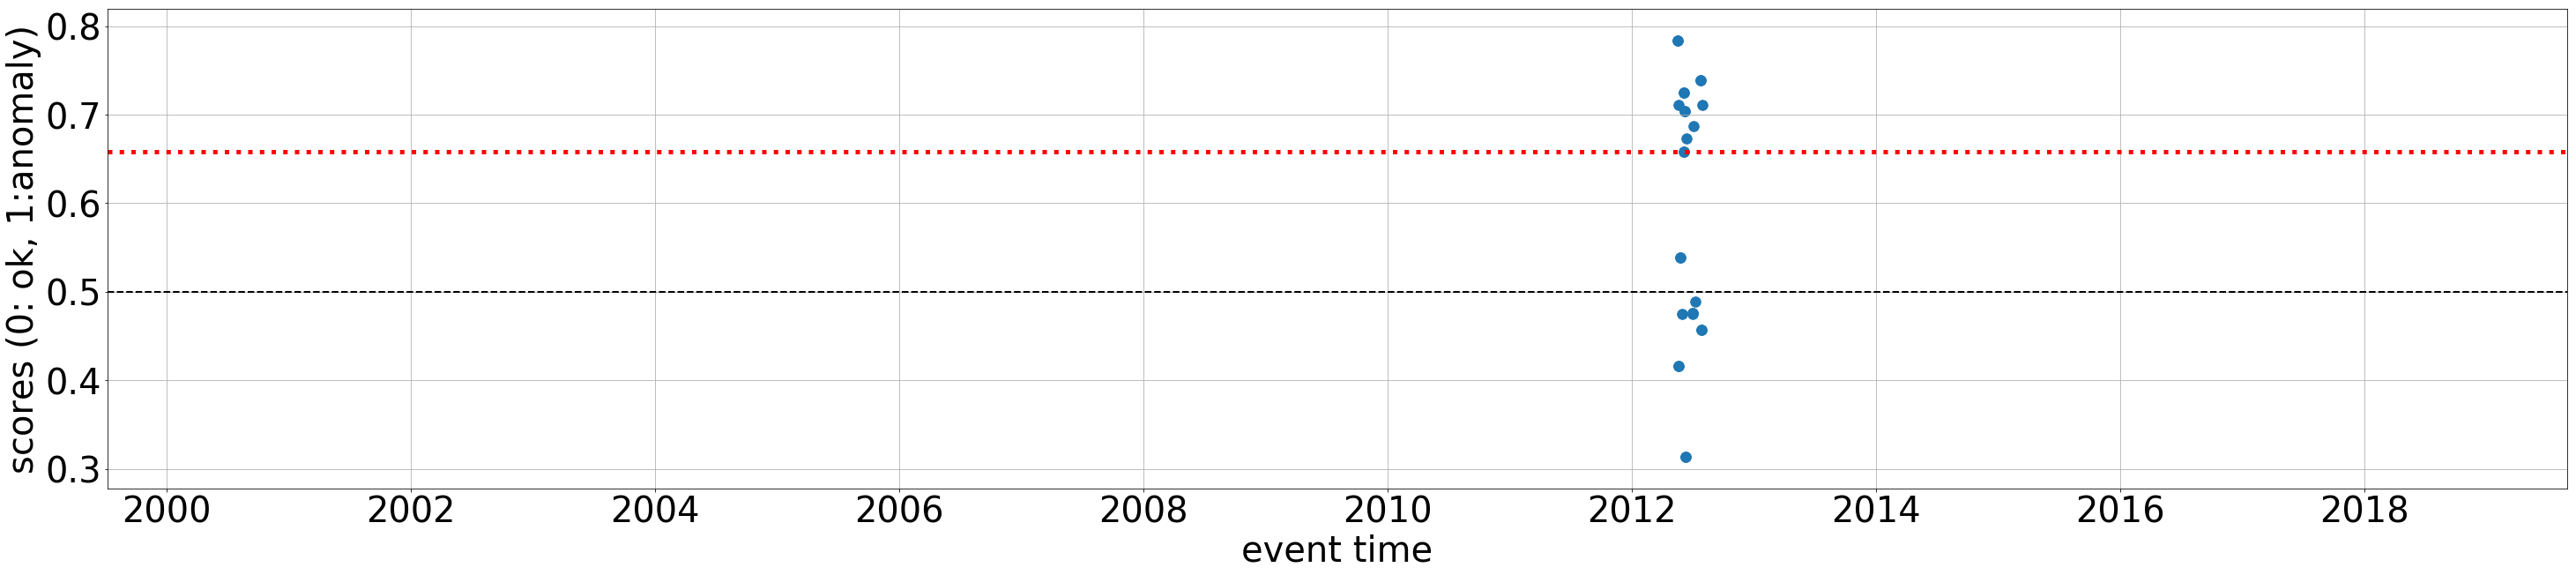

Channel: AF.NSU..BH? dataset_id: 2 (name: me) Num.segments: 33 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.635[0] 0.565[1] 0.542[2] 0.641[3] 0.572[4] 0.562[5] 0.633[6] 0.551[7] 0.558[8]


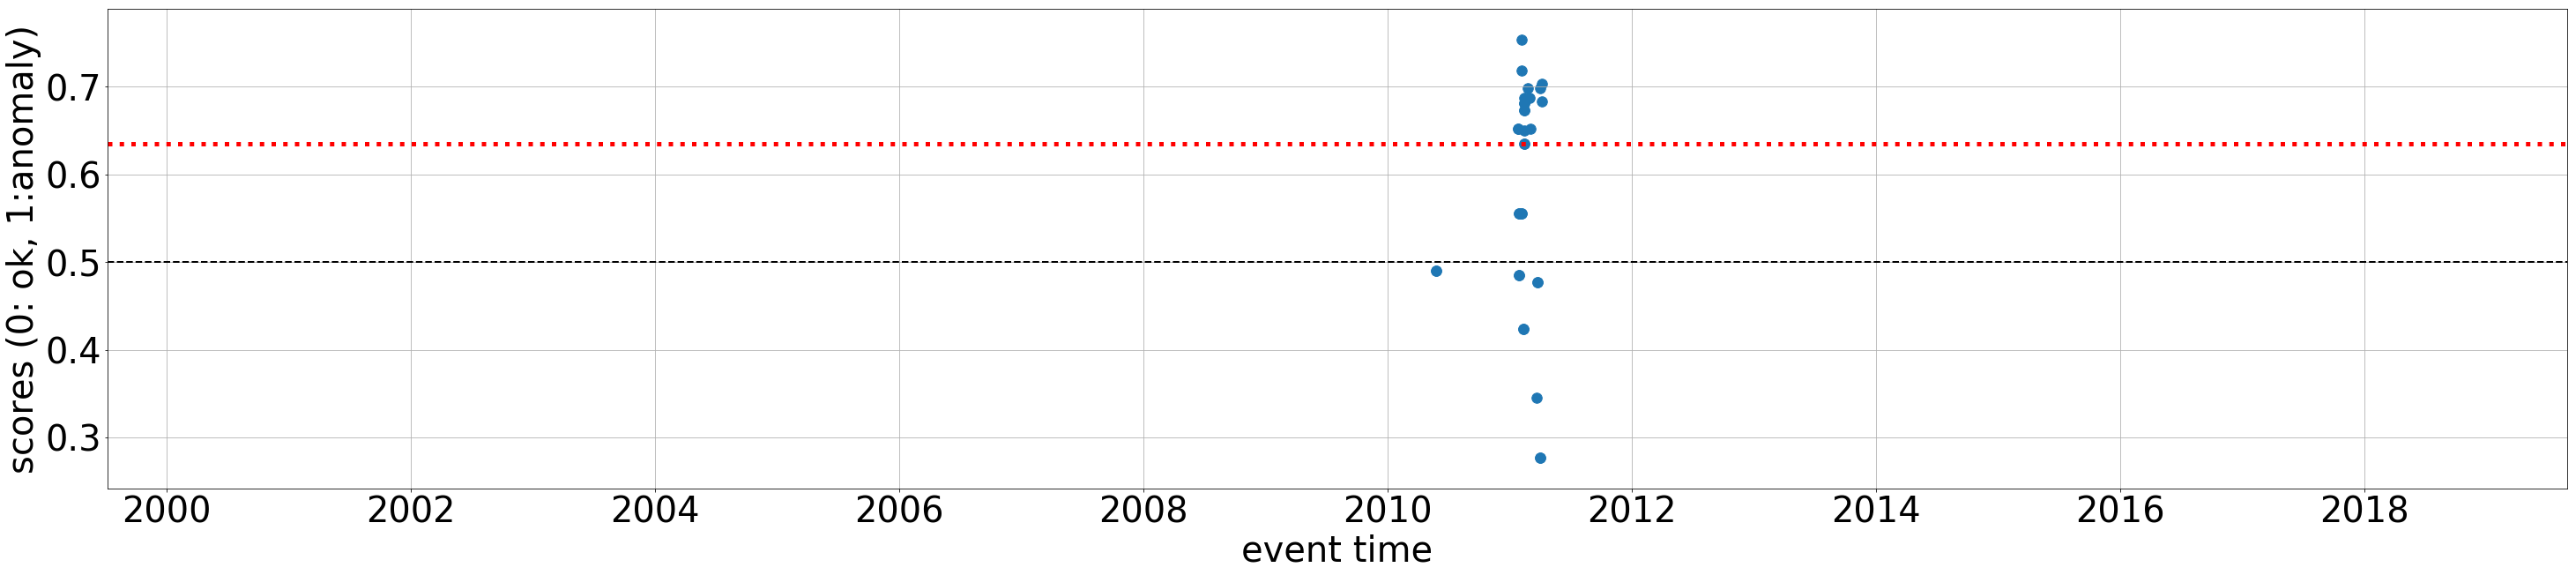

Channel: FR.SAOF.00.HN? dataset_id: 1 (name: s2s_2019_03) Num.segments: 2 Label: ok
Misclassified by 9 clfs with median scores:  0.606[0] 0.588[1] 0.558[2] 0.601[3] 0.590[4] 0.551[5] 0.617[6] 0.588[7] 0.554[8]


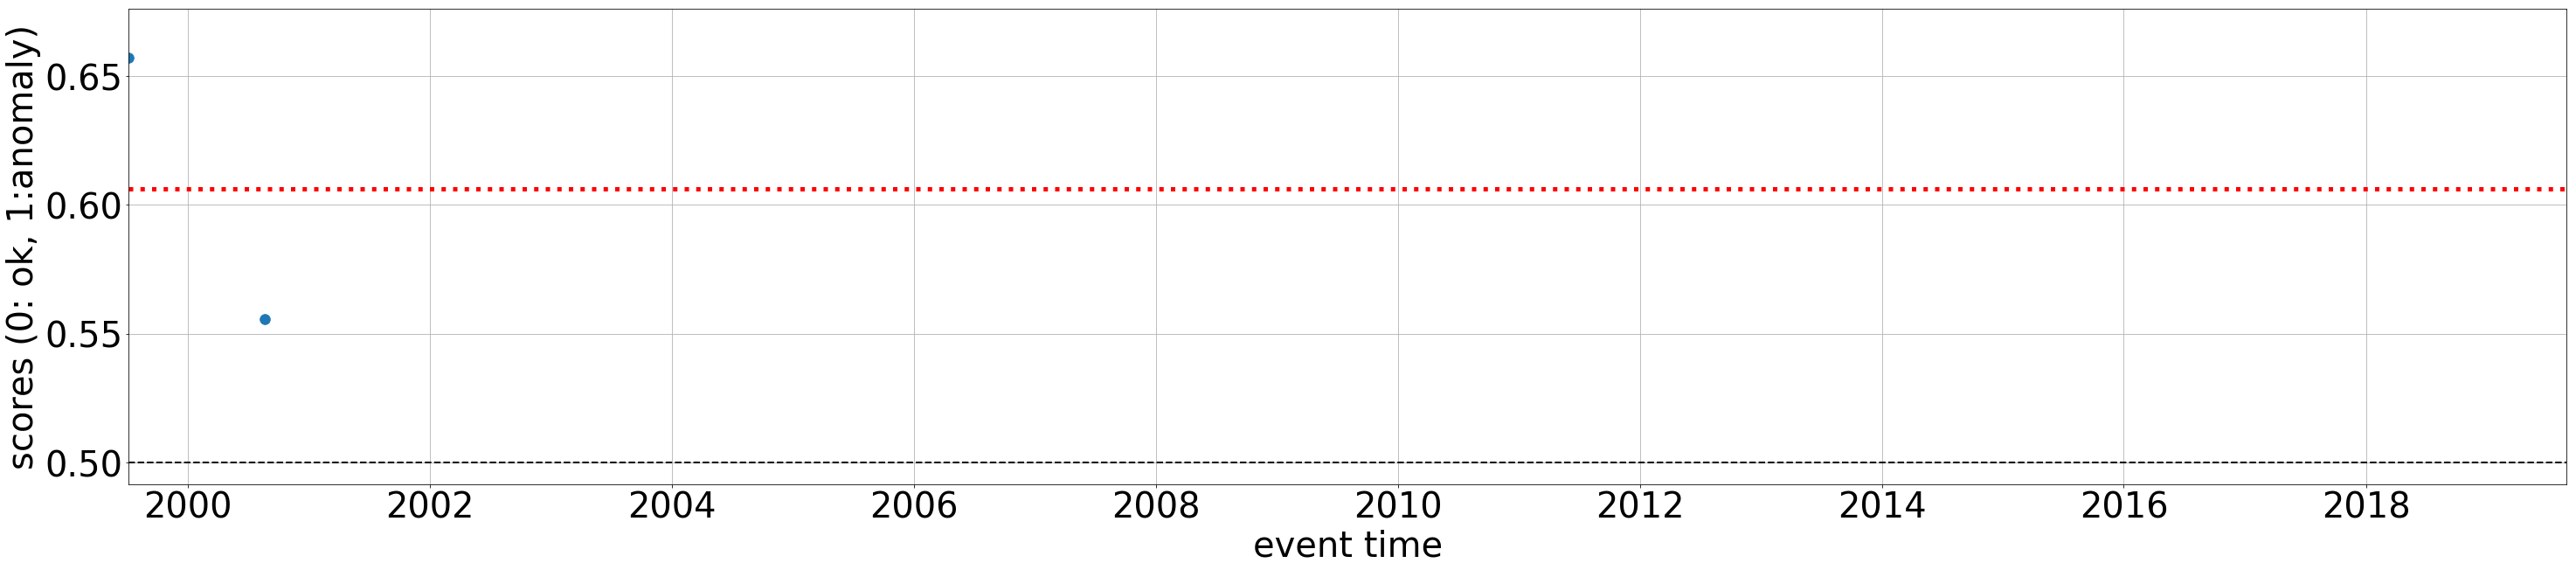

Channel: RO.BURAR..BH? dataset_id: 2 (name: me) Num.segments: 2742 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.603[0] 0.549[1] 0.530[2] 0.613[3] 0.557[4] 0.545[5] 0.602[6] 0.542[7] 0.543[8]


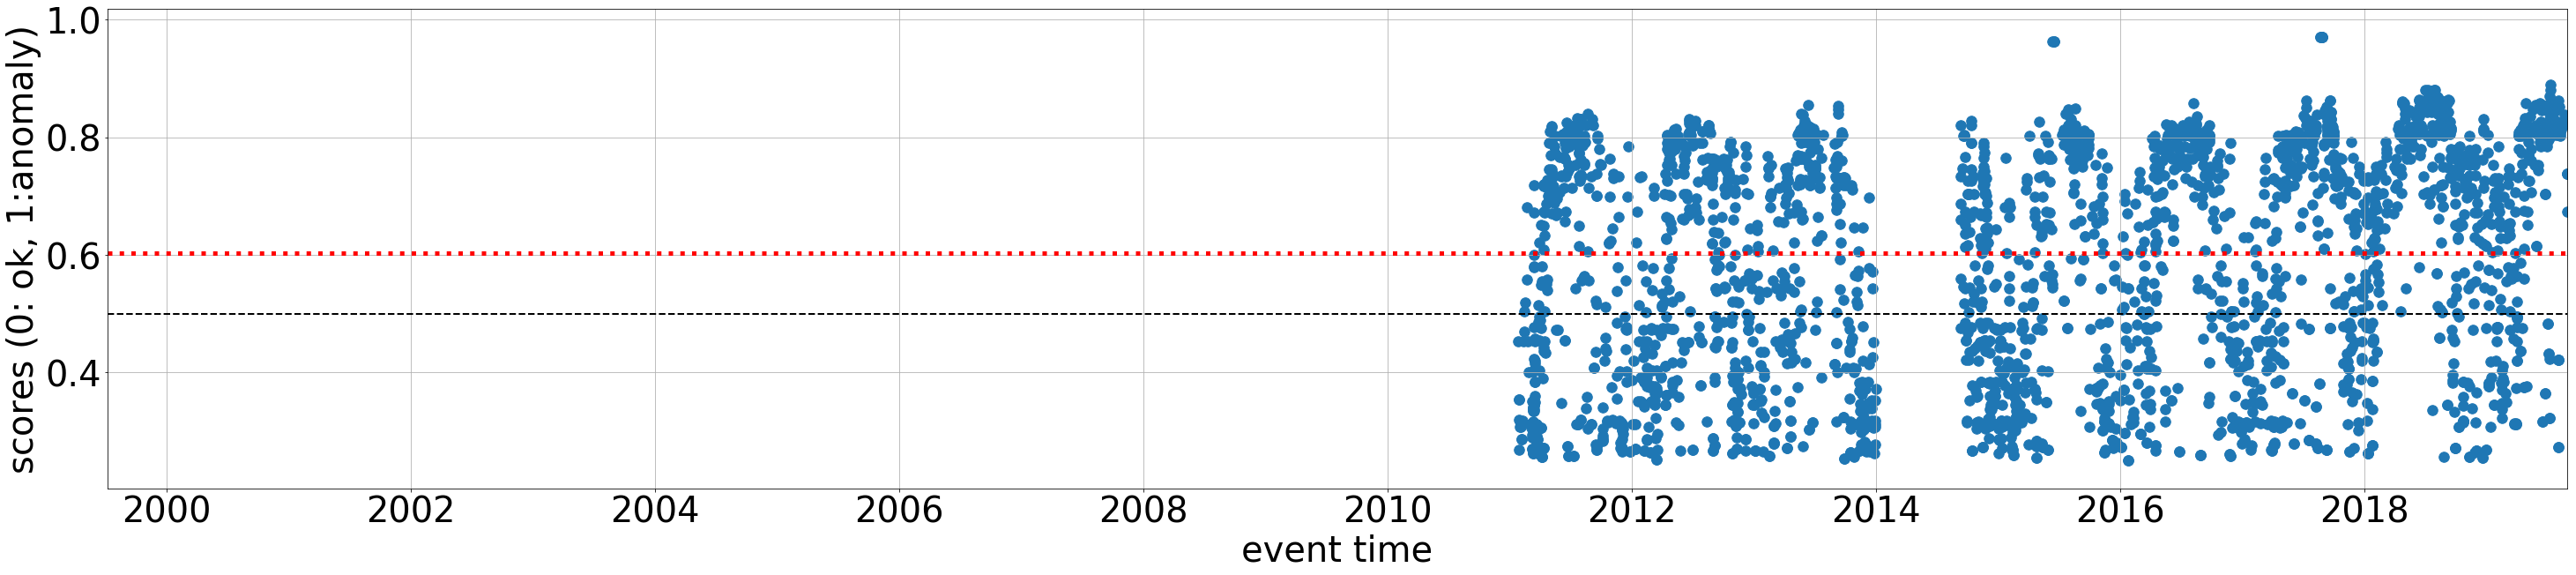

Channel: RV.HILA..BH? dataset_id: 2 (name: me) Num.segments: 1356 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.580[0] 0.575[1] 0.554[2] 0.564[3] 0.571[4] 0.546[5] 0.589[6] 0.565[7] 0.564[8]


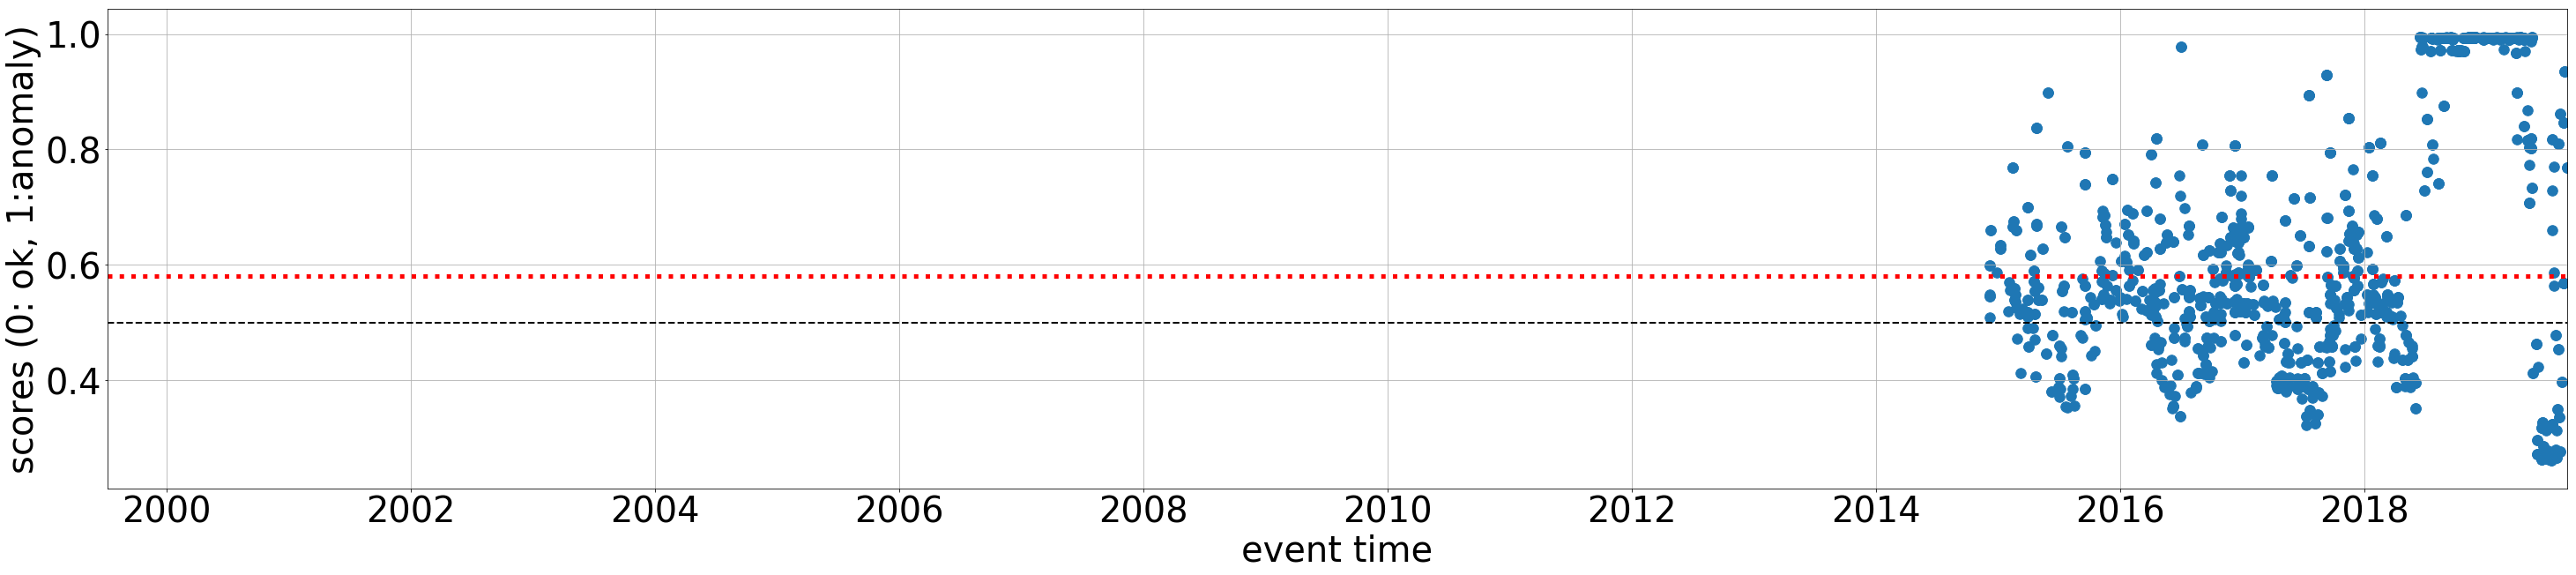

Channel: KO.YER..BH? dataset_id: 2 (name: me) Num.segments: 1932 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.578[0] 0.547[1] 0.529[2] 0.582[3] 0.554[4] 0.539[5] 0.587[6] 0.539[7] 0.537[8]


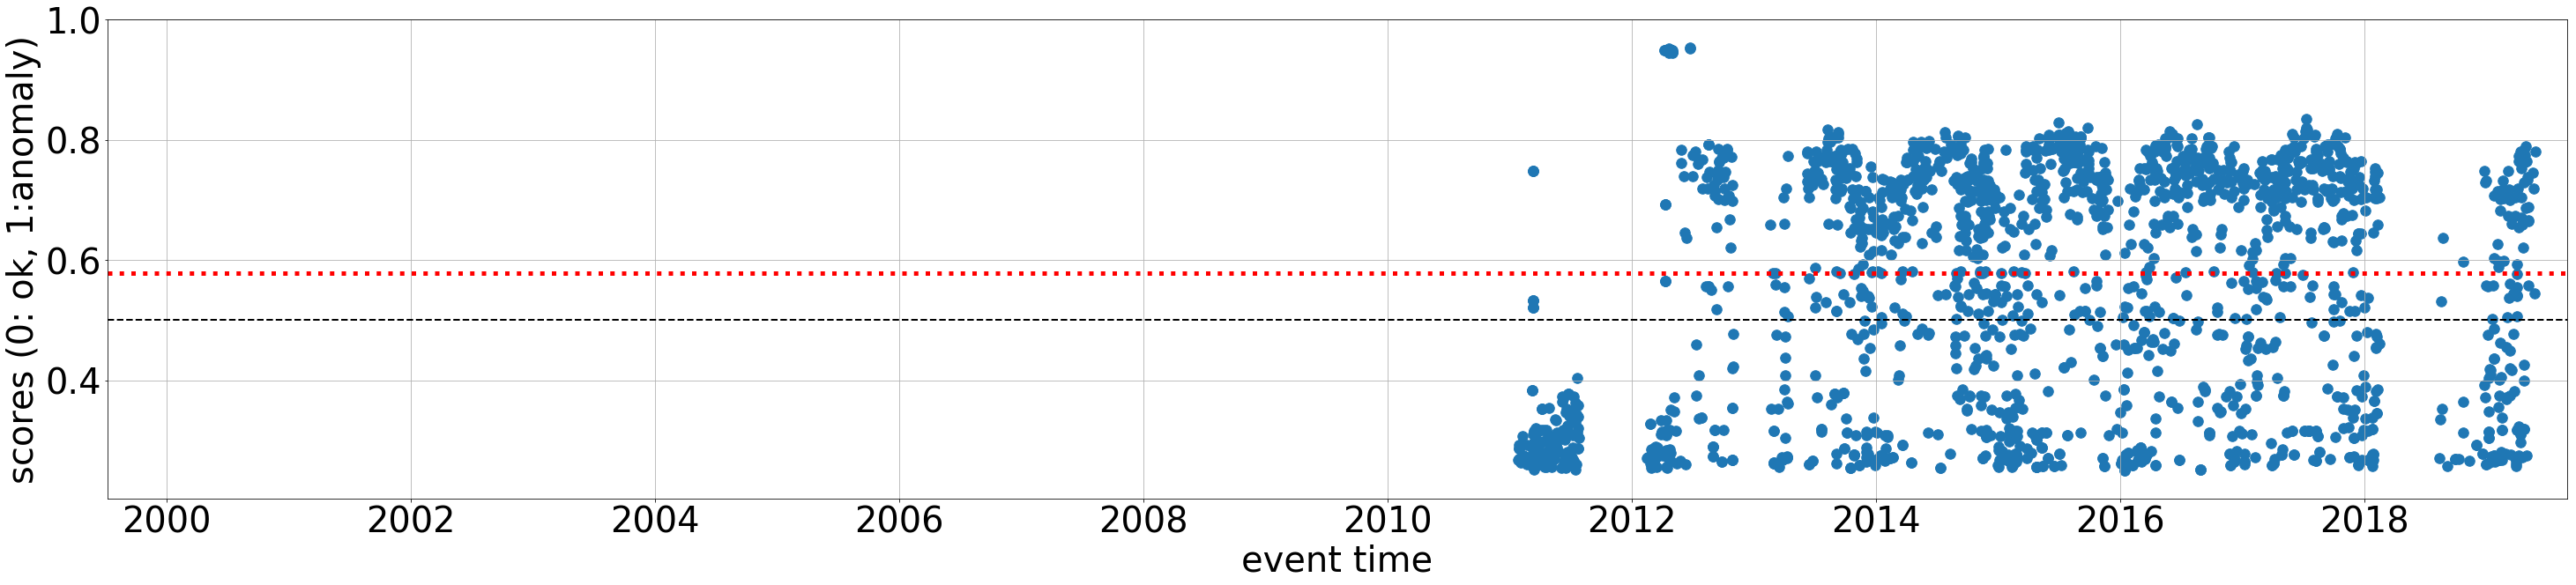

Channel: AI.DSPA.02.BH? dataset_id: 2 (name: me) Num.segments: 323 Label: unlabeled (Me unknown)
Misclassified by 18 clfs with median scores:  0.574[0] 0.568[0] 0.572[1] 0.565[1] 0.547[2] 0.546[2] 0.557[3] 0.554[3] 0.563[4] 0.557[4] 0.539[5] 0.536[5] 0.582[6] 0.577[6] 0.563[7] 0.555[7] 0.549[8] 0.544[8]


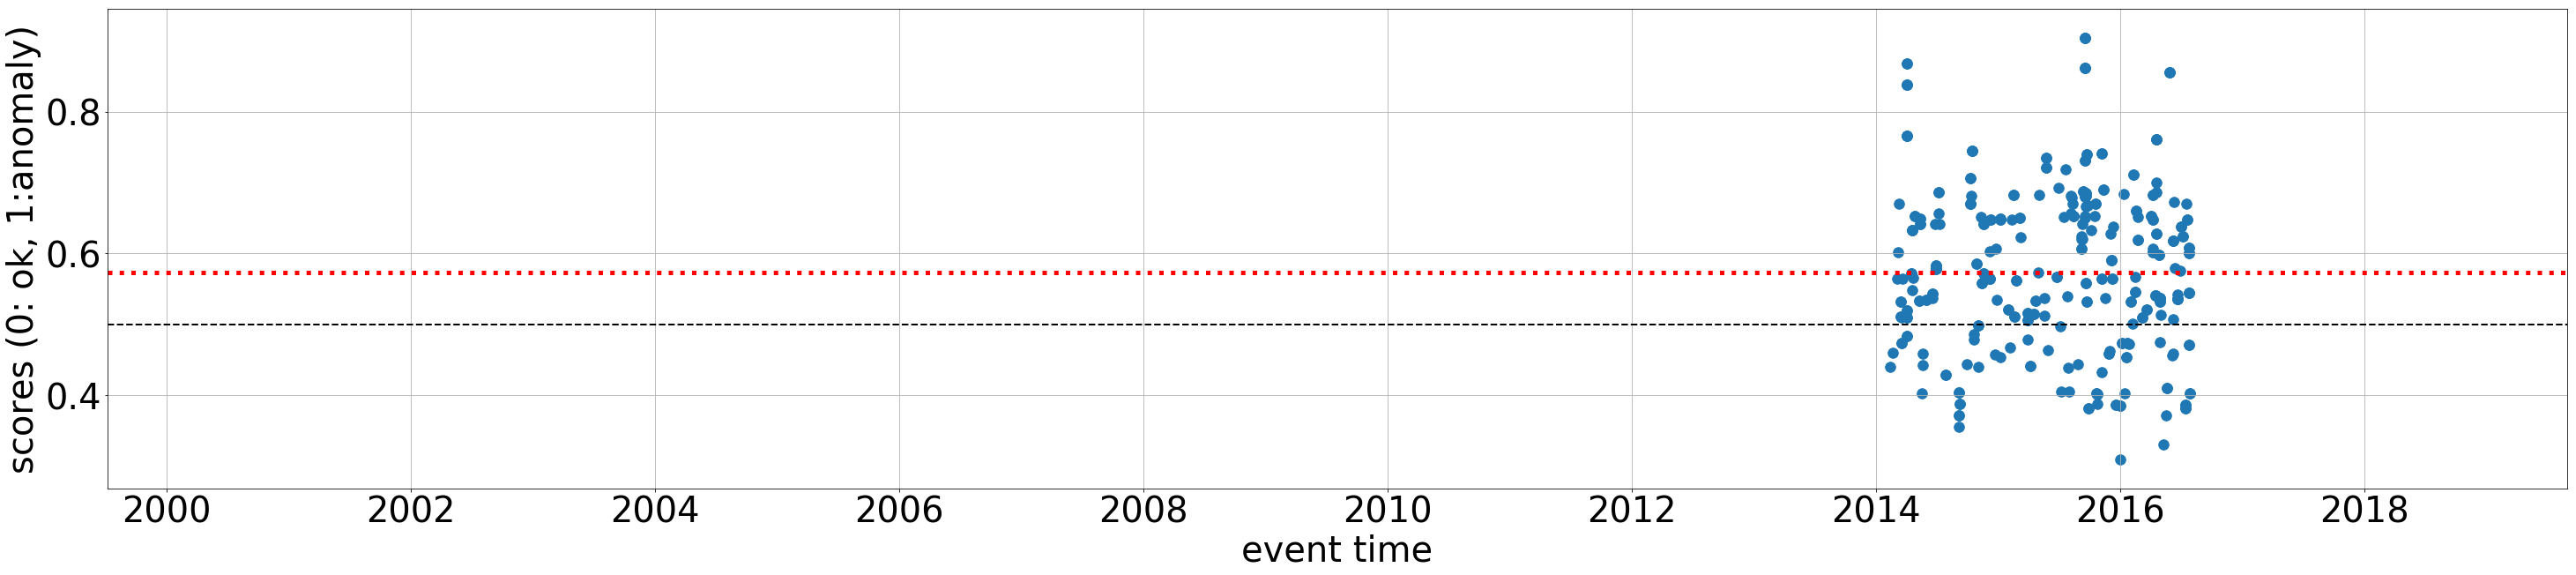

Channel: CX.PX06..BL? dataset_id: 3 (name: sod_chile) Num.segments: 3 Label: ok
Misclassified by 9 clfs with median scores:  0.555[0] 0.557[1] 0.538[2] 0.537[3] 0.550[4] 0.522[5] 0.554[6] 0.546[7] 0.525[8]


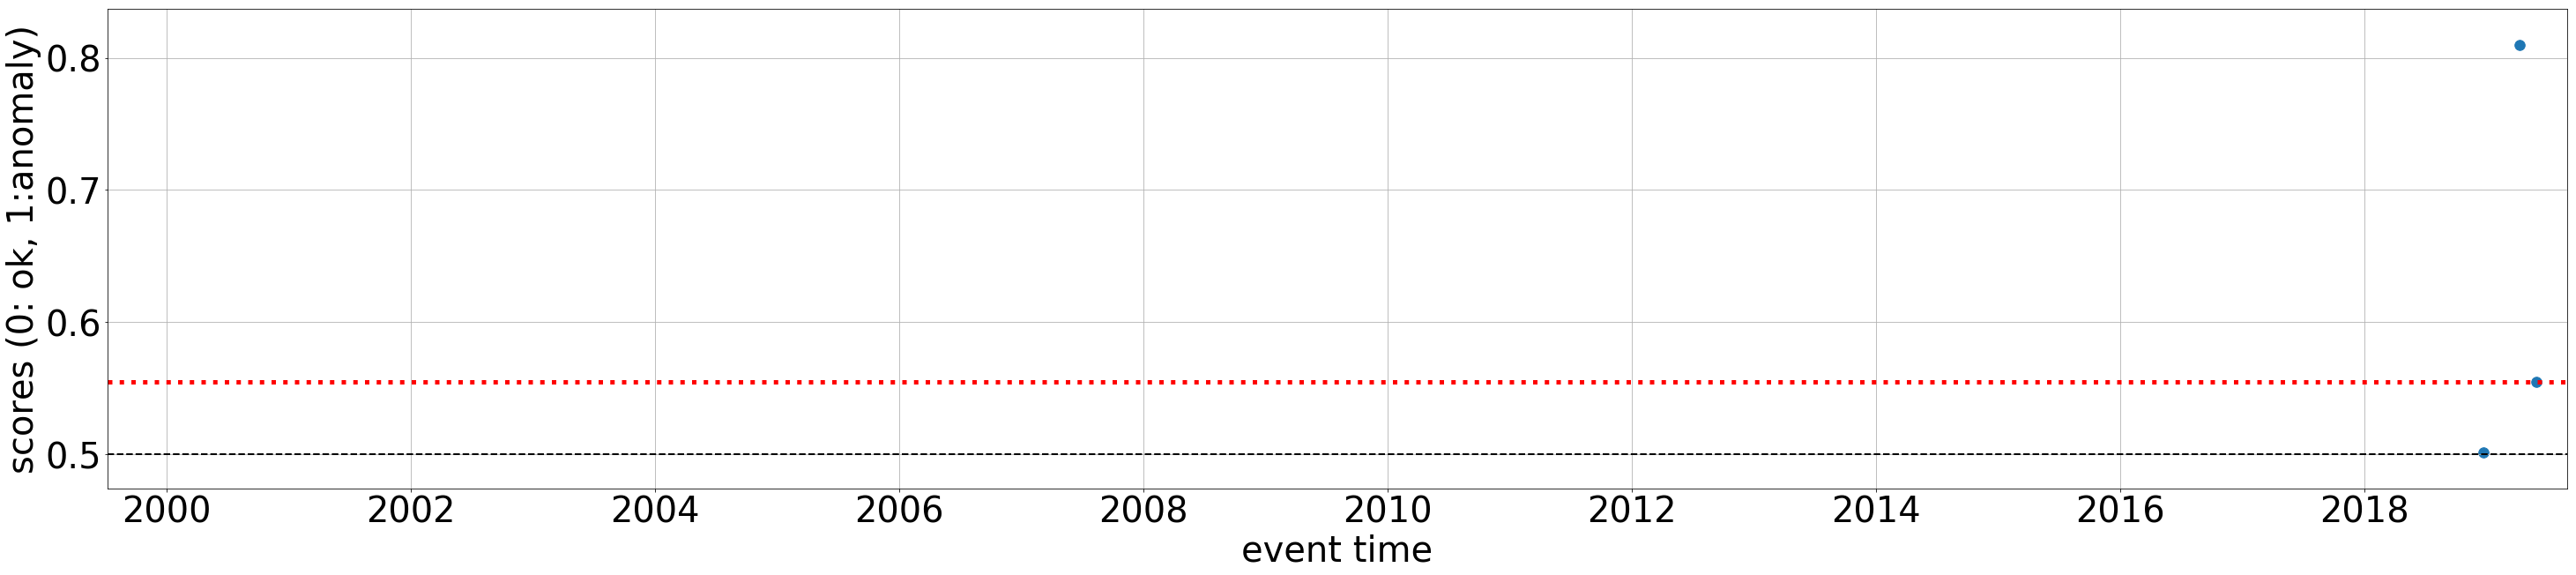

Channel: IV.PIO1..HN? dataset_id: 1 (name: s2s_2019_03) Num.segments: 174 Label: ok
Misclassified by 9 clfs with median scores:  0.544[0] 0.553[1] 0.536[2] 0.532[3] 0.545[4] 0.525[5] 0.548[6] 0.539[7] 0.525[8]


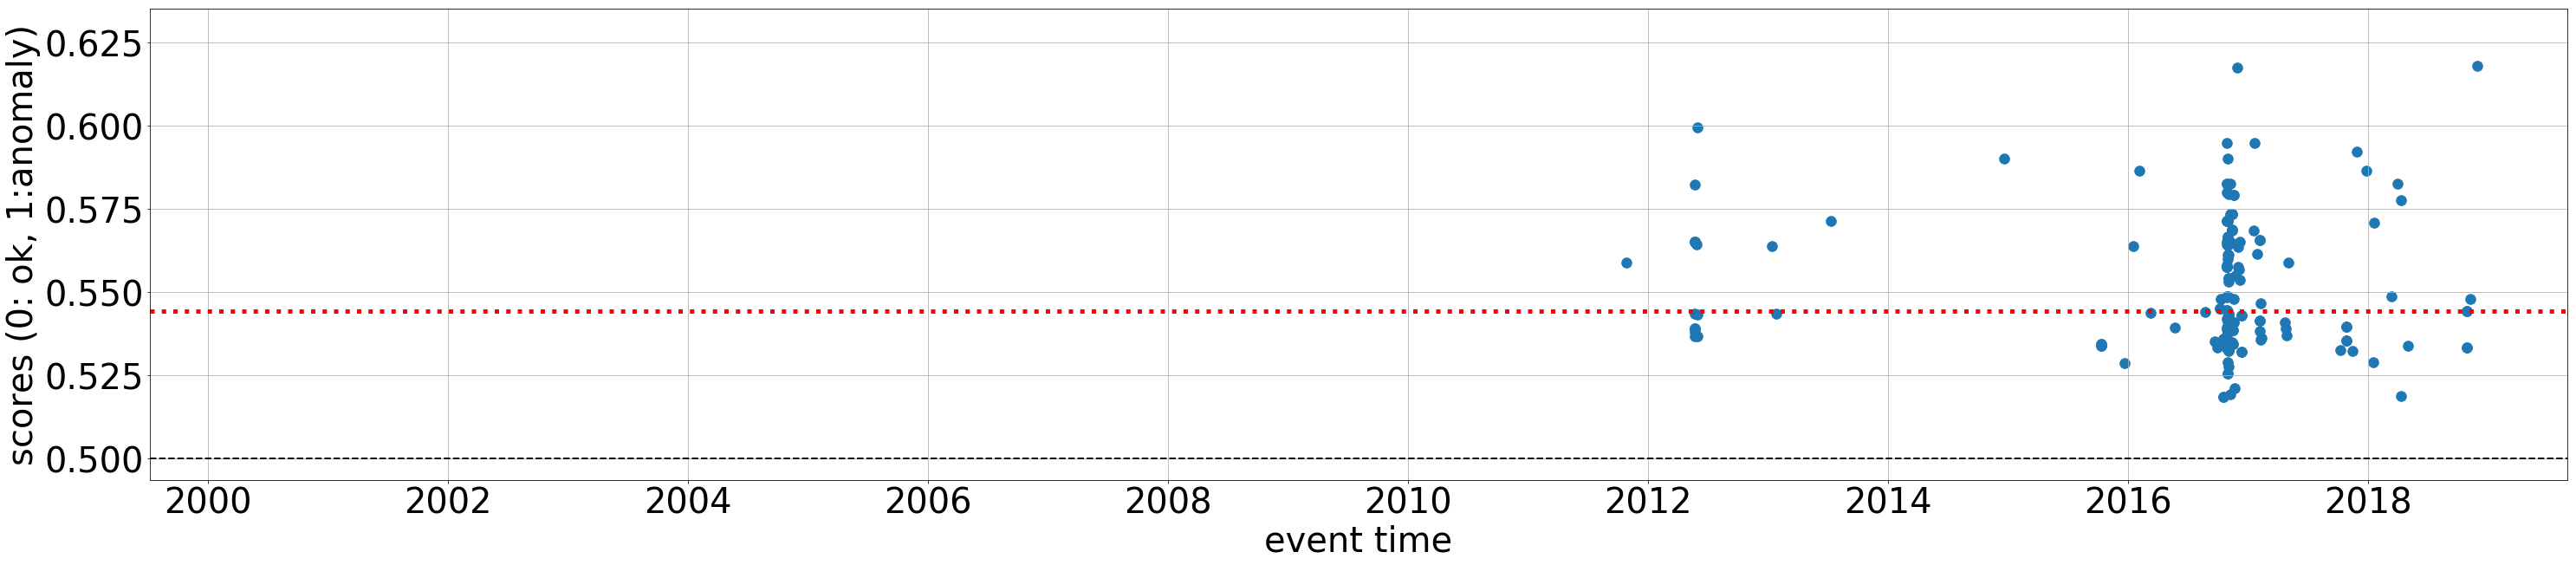

Channel: AV.AKGG..BH? dataset_id: 2 (name: me) Num.segments: 505 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.544[0] 0.555[1] 0.532[2] 0.531[3] 0.546[4] 0.525[5] 0.548[6] 0.541[7] 0.523[8]


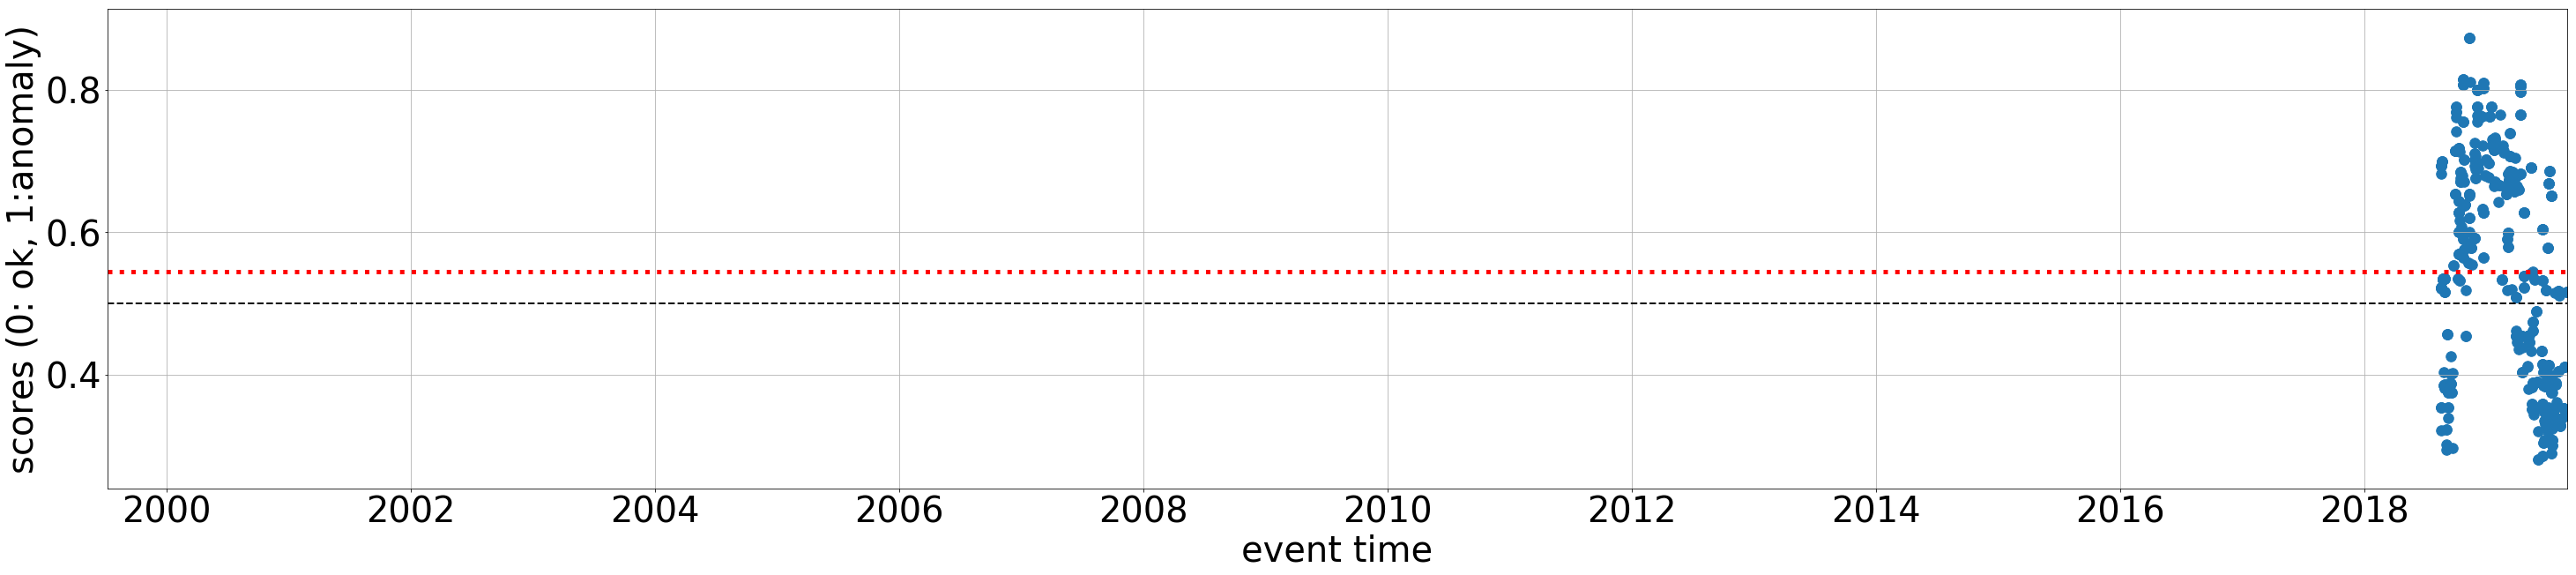

Channel: C1.LC02..BH? dataset_id: 2 (name: me) Num.segments: 400 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.539[0] 0.521[1] 0.503[2] 0.551[3] 0.521[4] 0.514[5] 0.536[6] 0.506[7] 0.514[8]


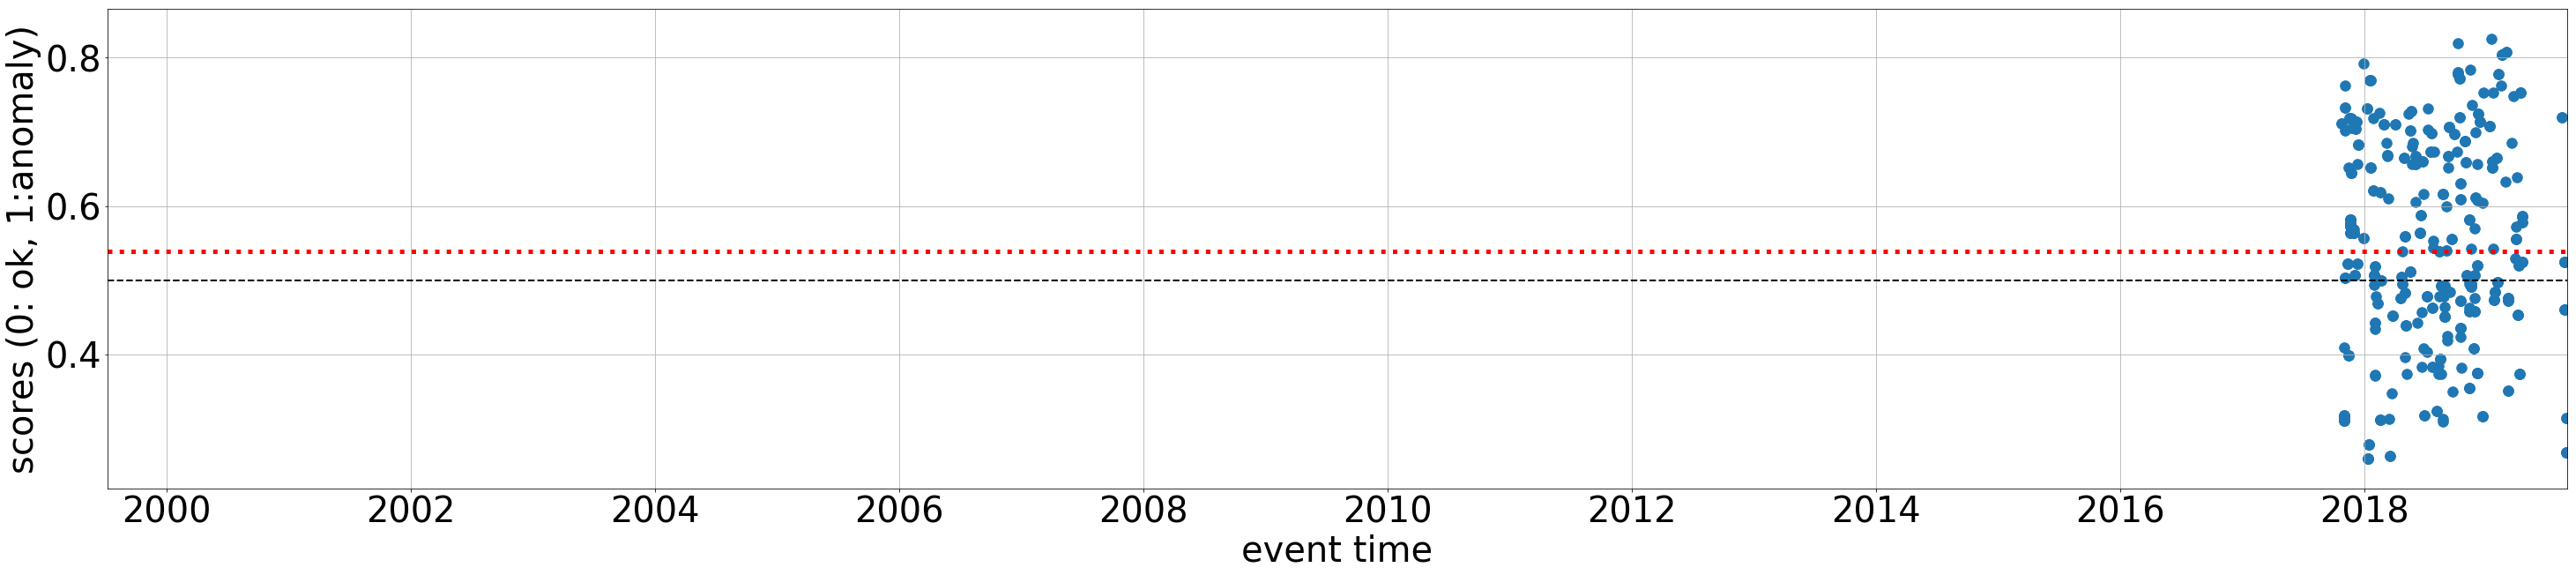

Channel: CA.POBL..BH? dataset_id: 2 (name: me) Num.segments: 2190 Label: unlabeled (Me unknown)
Misclassified by 9 clfs with median scores:  0.533[0] 0.547[1] 0.520[2] 0.520[3] 0.539[4] 0.515[5] 0.535[6] 0.529[7] 0.504[8]


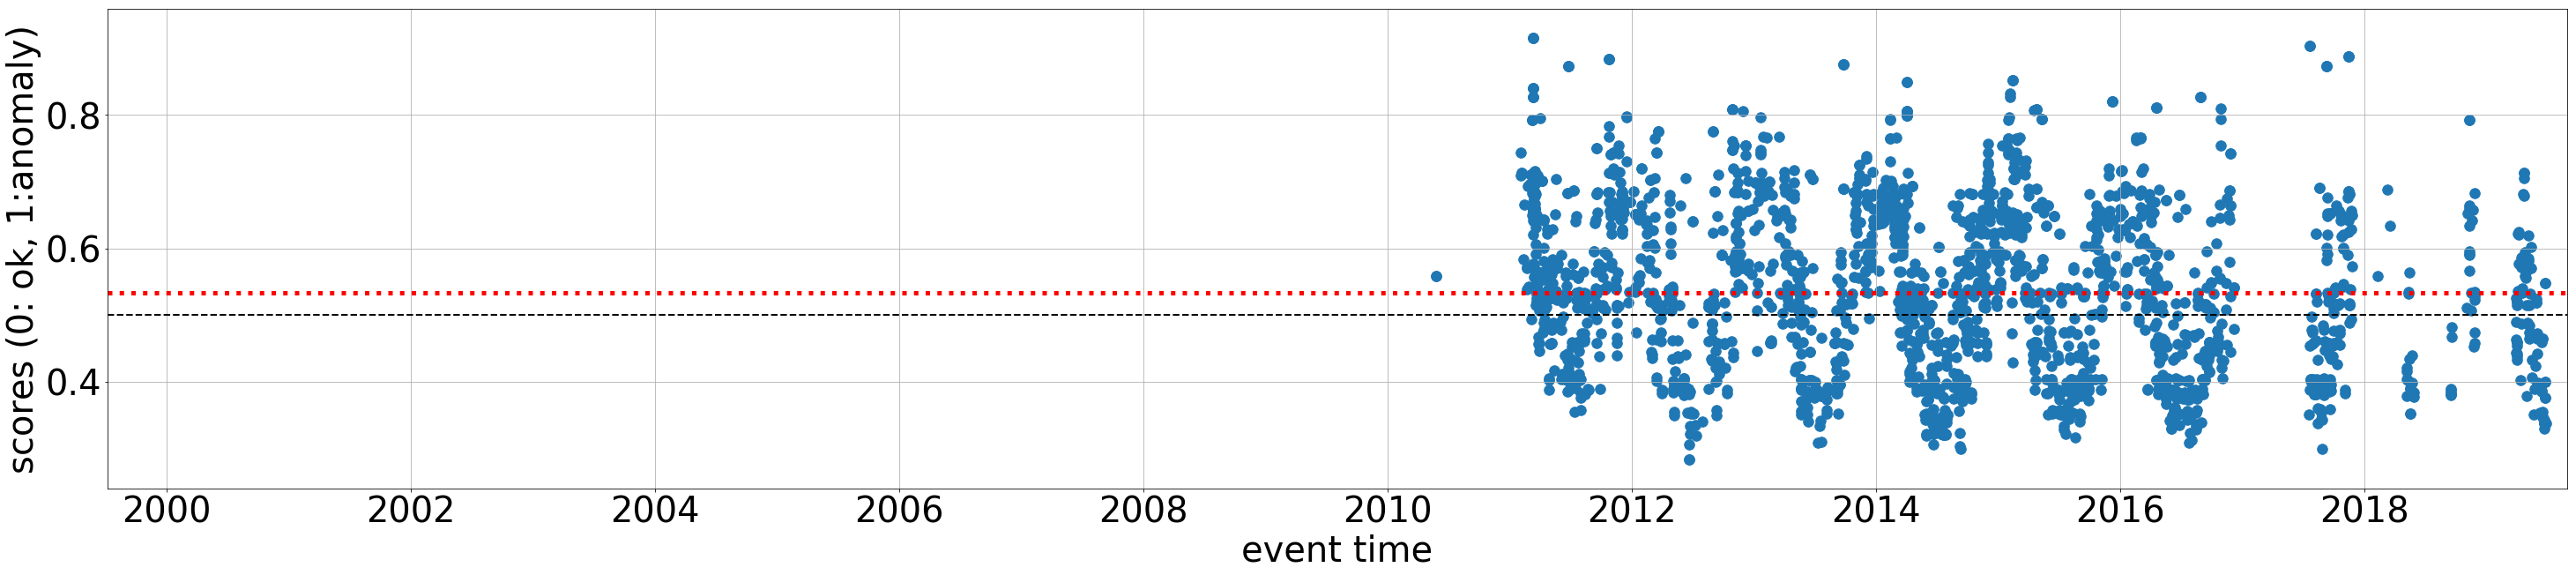

Channel: CX.PB13..BL? dataset_id: 3 (name: sod_chile) Num.segments: 1 Label: ok
Misclassified by 8 clfs with median scores:  0.531[0] 0.545[1] 0.515[2] 0.517[3] 0.534[4] 0.505[5] 0.533[6] 0.527[7]


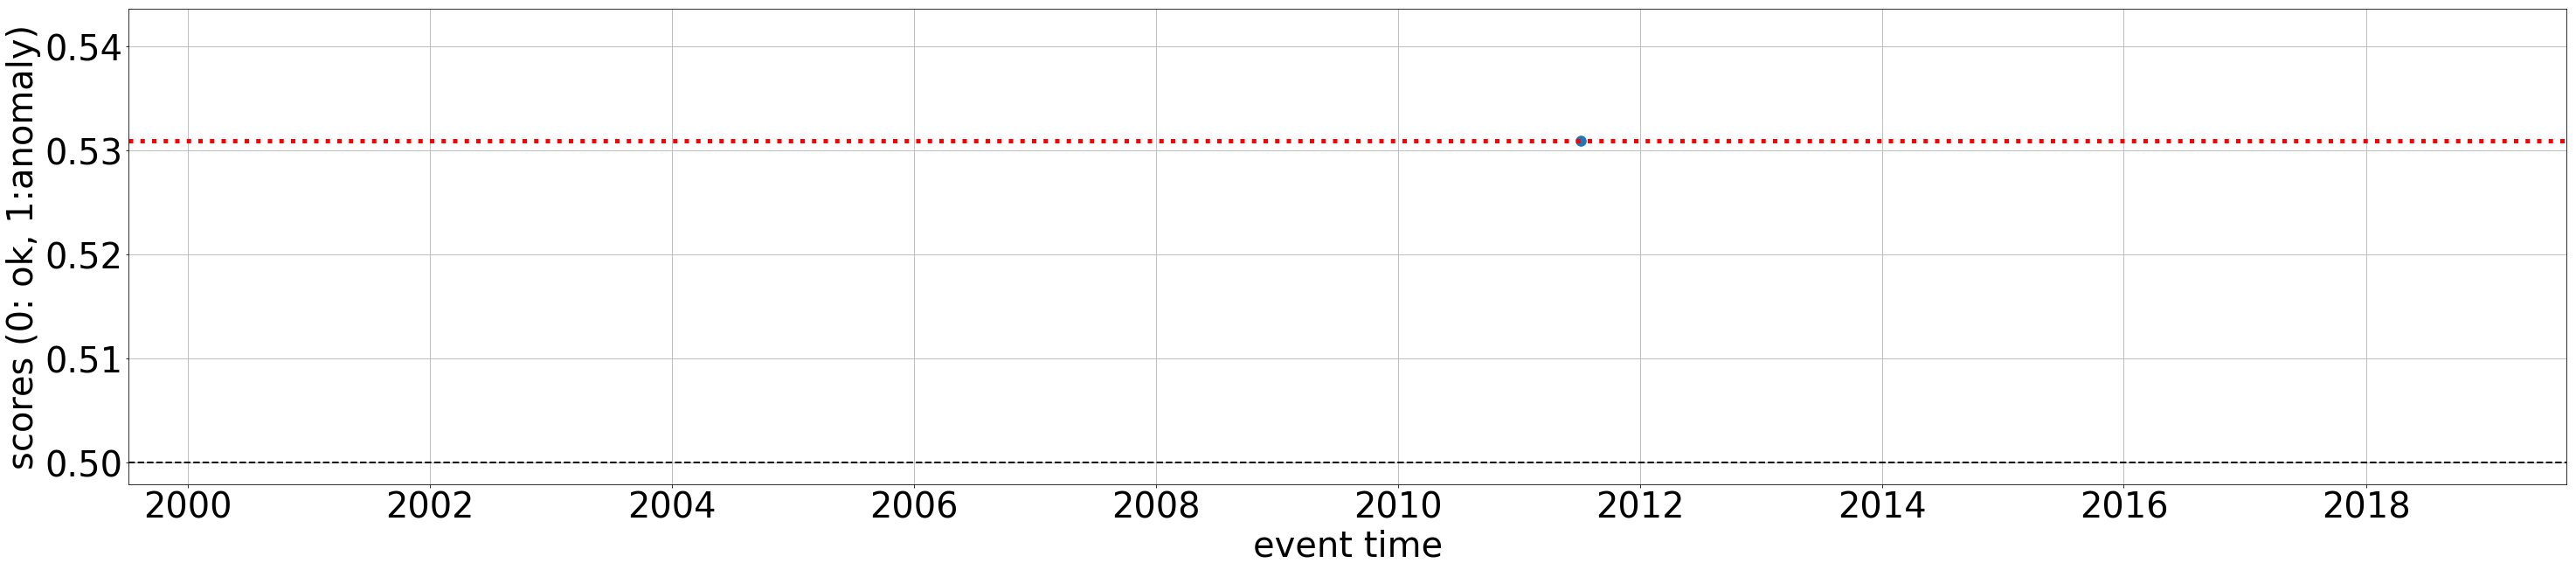

Channel: PZ.PIER..EH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 2 Label: ok
Misclassified by 6 clfs with median scores:  0.518[1] 0.511[2] 0.525[4] 0.506[5] 0.517[7] 0.503[8]


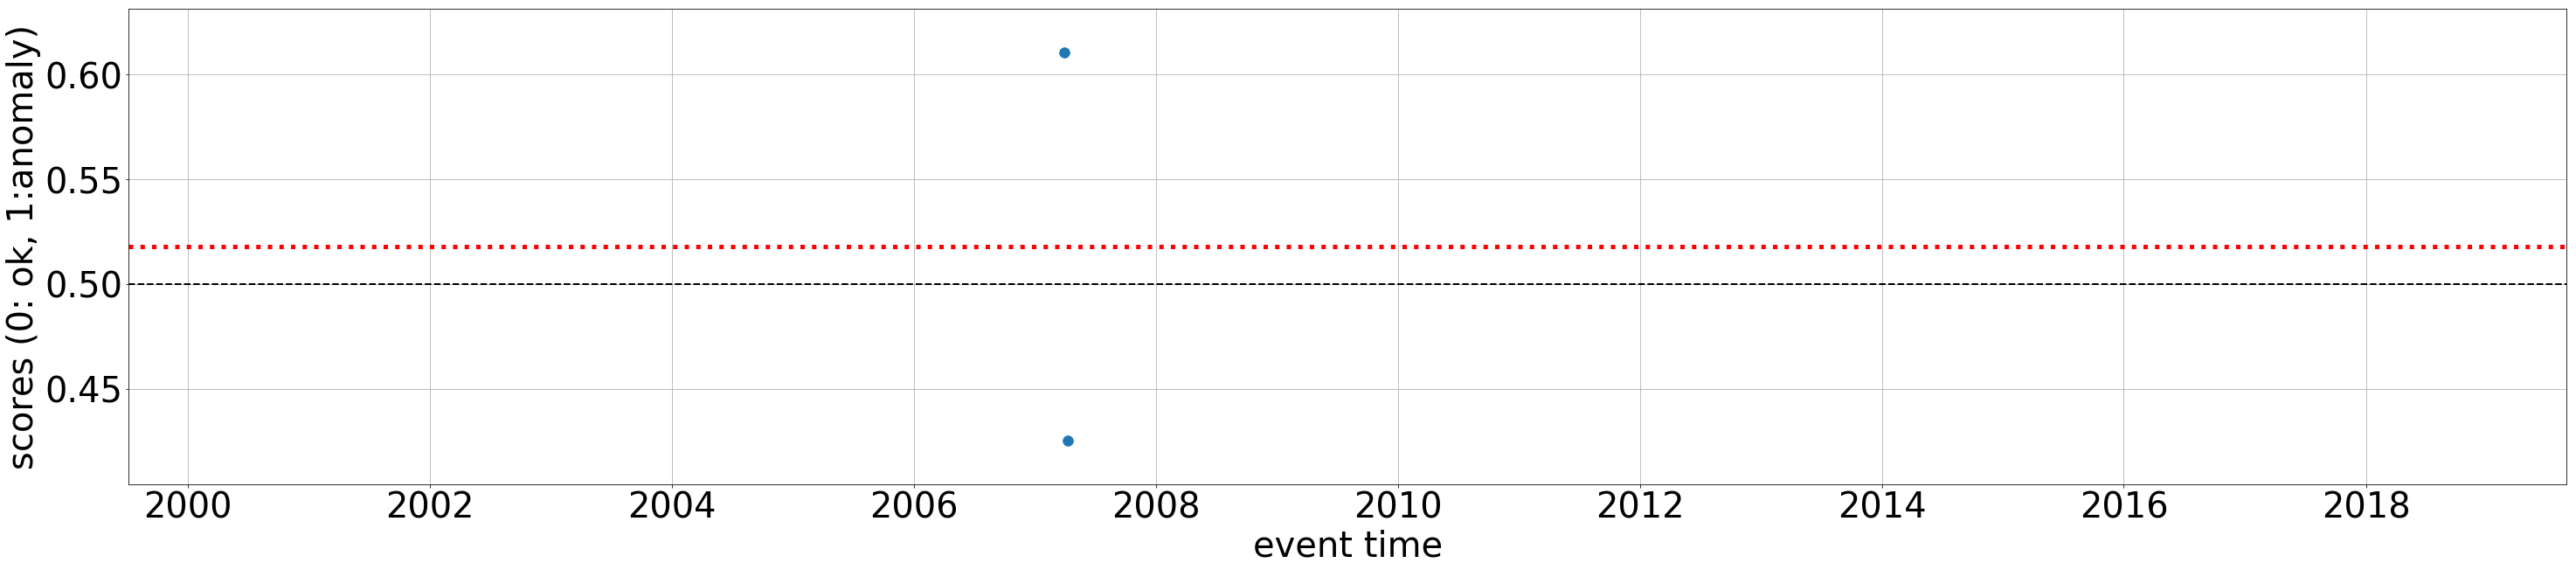

Channel: XW.W04.00.HH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 4 Label: ok
Misclassified by 2 clfs with median scores:  0.504[4] 0.505[5]


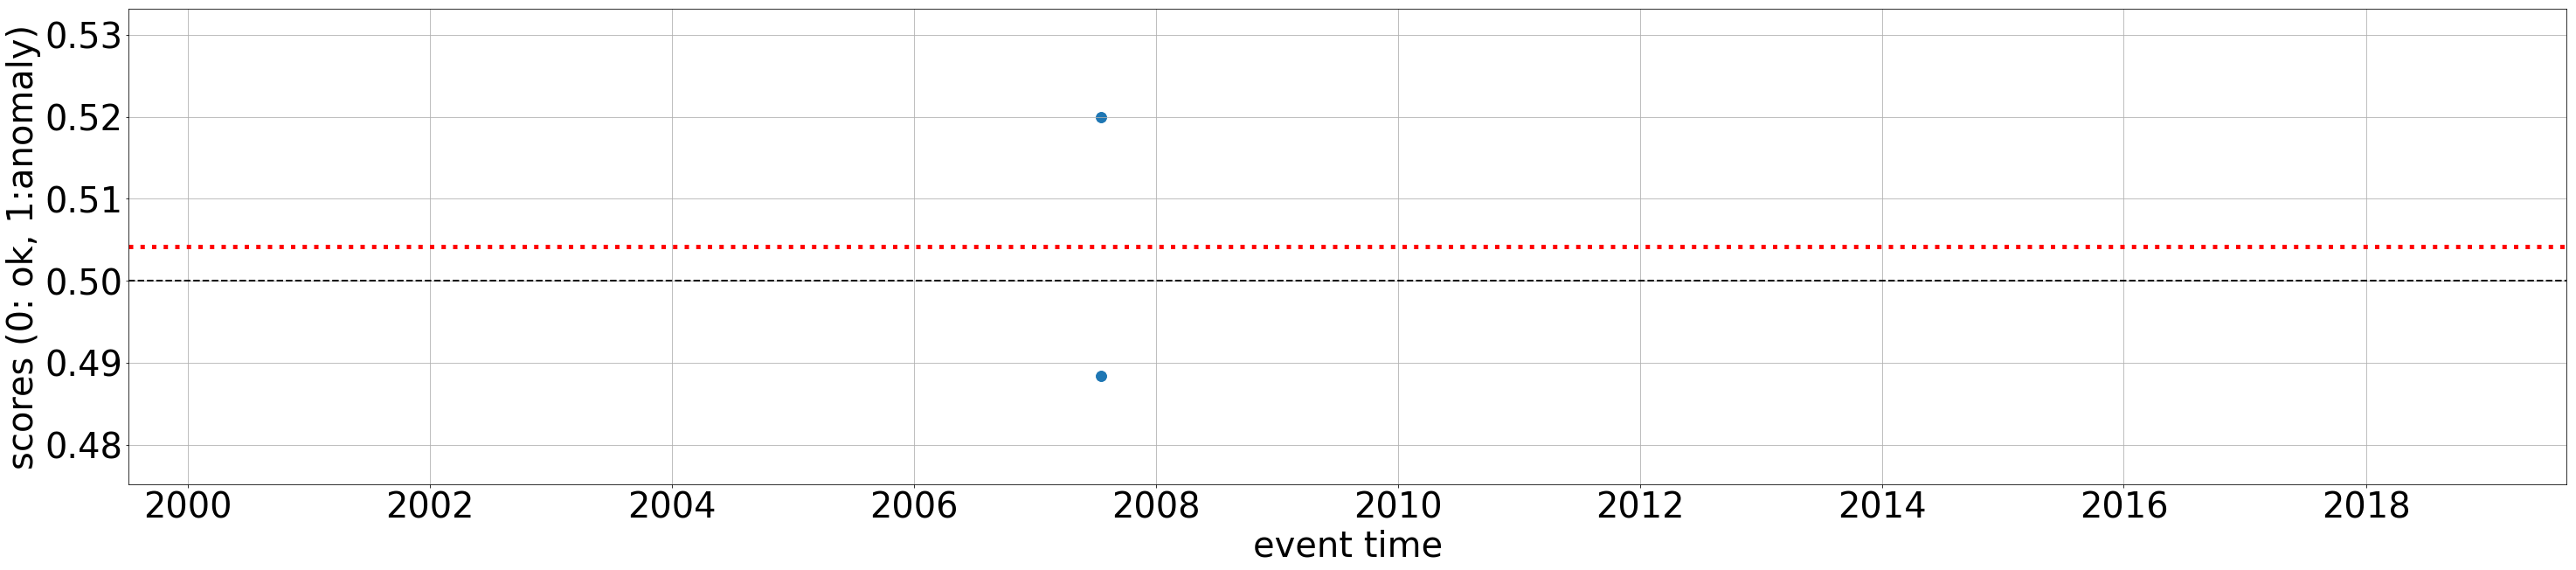

Channel: YI.E02.00.BH? dataset_id: 1 (name: s2s_2019_03) Num.segments: 3 Label: ok
Misclassified by 1 clfs with median scores:  0.503[5]


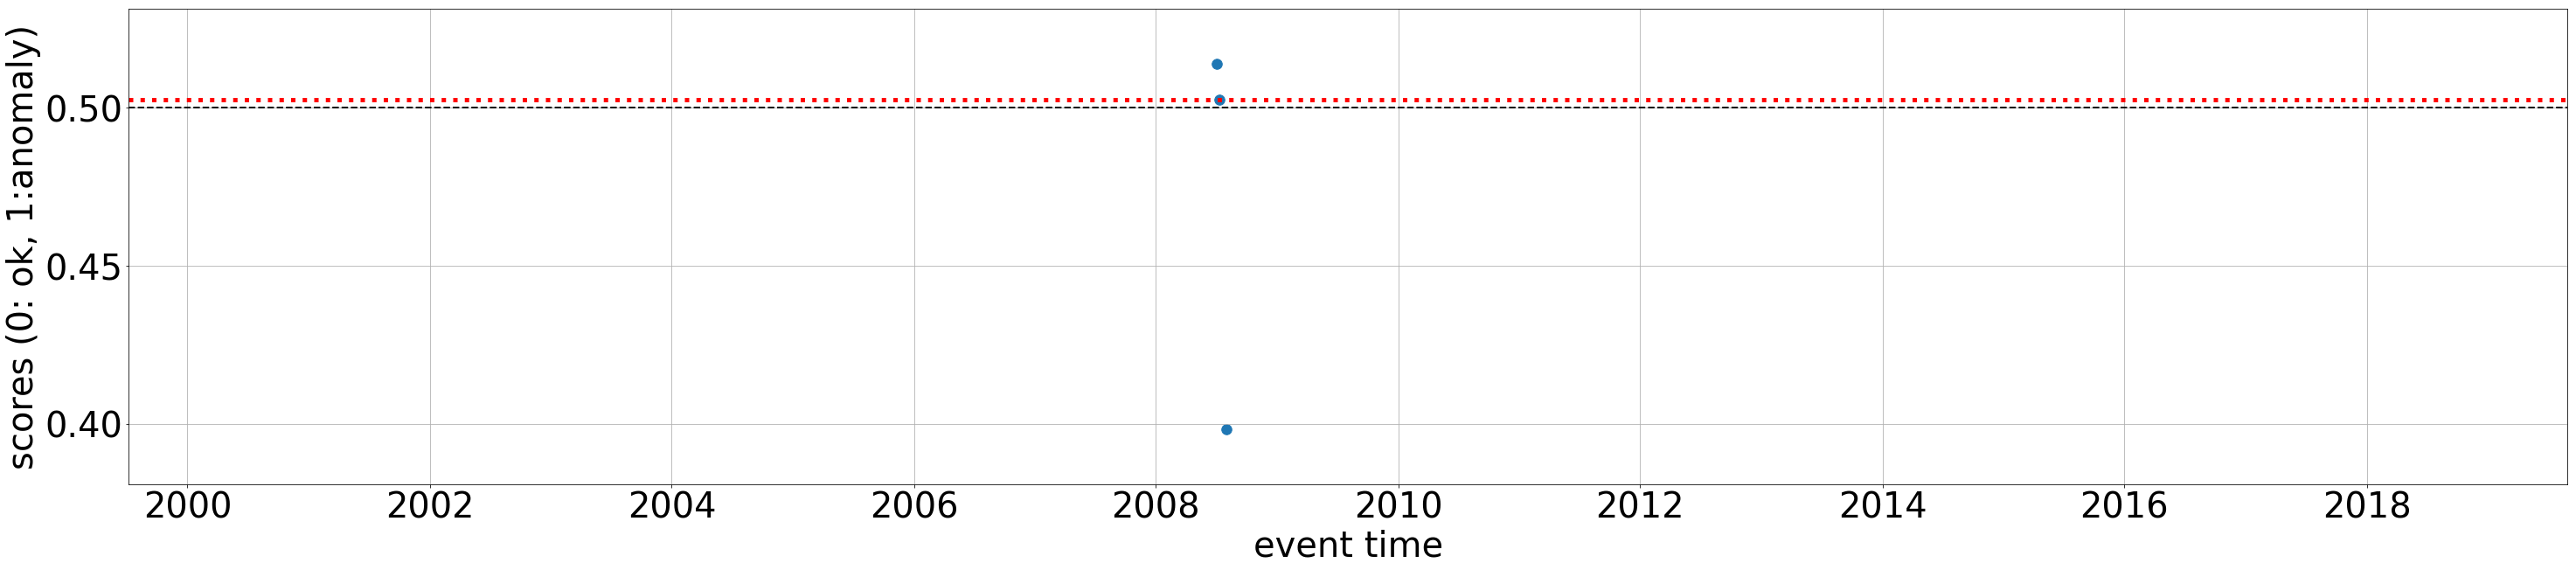

Channel: S1.AUTAR..BH? dataset_id: 2 (name: me) Num.segments: 1325 Label: outl. (wrong inv)
Misclassified by 9 clfs with median scores:  0.330[0] 0.419[1] 0.442[2] 0.314[3] 0.416[4] 0.431[5] 0.310[6] 0.403[7] 0.421[8]


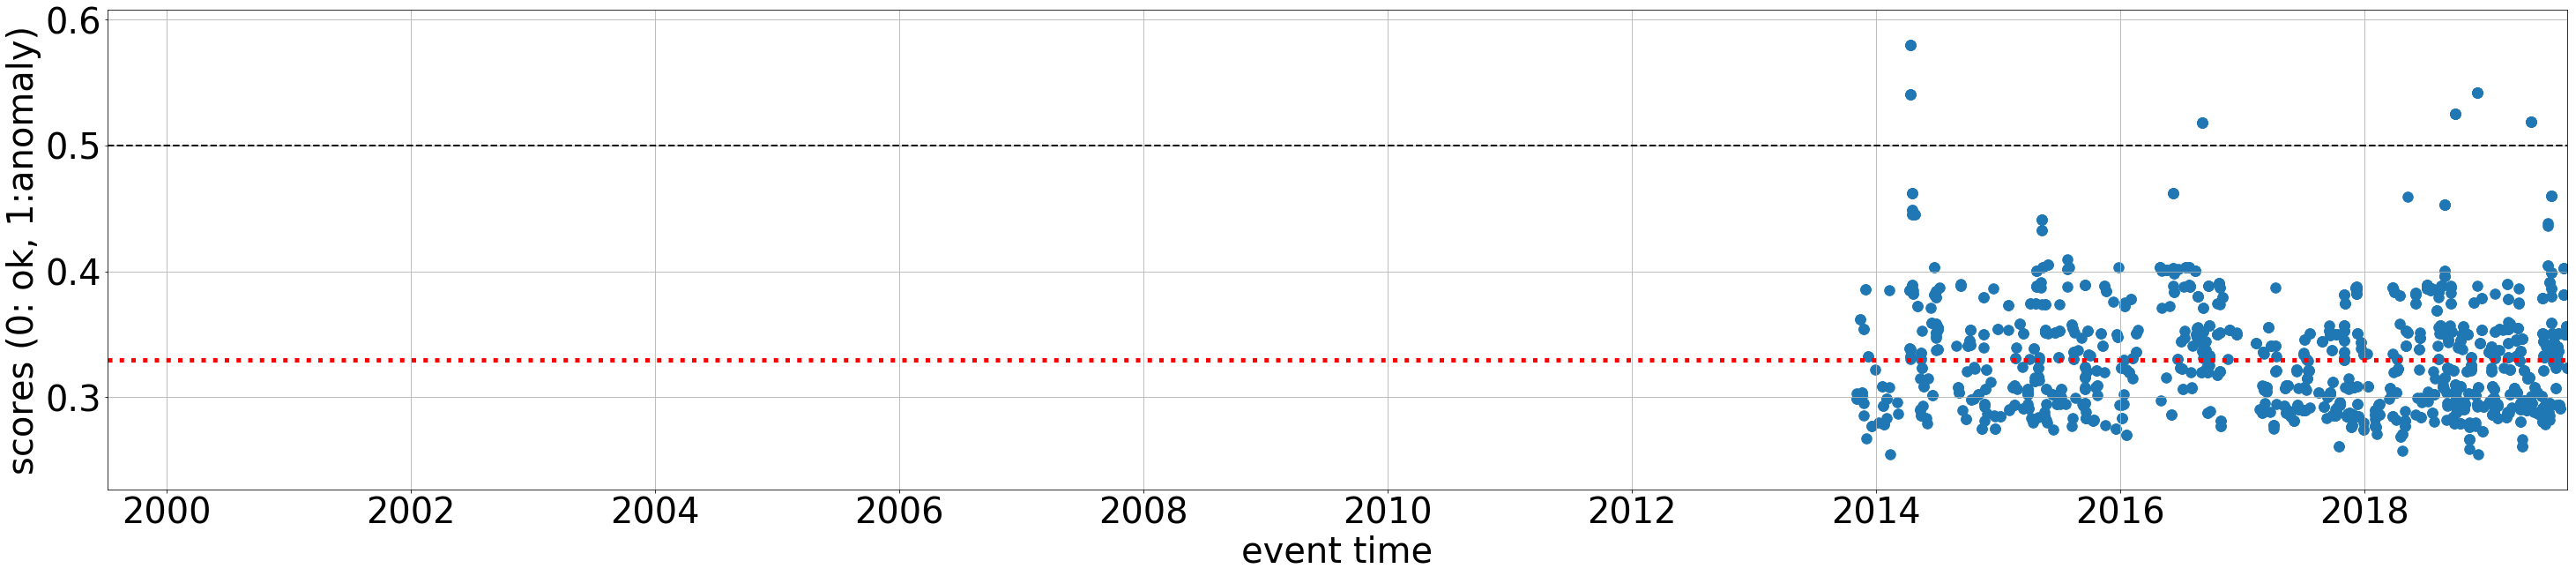

In [3]:
# plotting misclassified channels
import csv

_pred_dfs = []
timin, tmax = None, None
for i, pred_df in enumerate(pred_dfs):
    assert 'event_time' not in pred_df.columns
    _pred_df = pred_df.merge(allset_test[['allset_test.id', 'dataset_id', 'event_time']],
                             how='left', on=['allset_test.id', 'dataset_id'])
    assert 'event_time' in _pred_df.columns
    natimes = pd.isna(_pred_df.event_time).sum()
    if natimes:
        raise ValueError('%d NAT' % natimes)
    _pred_df = _pred_df.dropna(subset=['event_time'])
    _pred_dfs.append(_pred_df.copy())

    _tmin, _tmax = pd.to_datetime(_pred_dfs[-1].event_time.min()), pd.to_datetime(_pred_dfs[-1].event_time.max())
    if i == 0 or _tmin < tmin:
        tmin = _tmin
    if i==0 or _tmax > tmax:
        tmax = _tmax
#print('%d segments of %d misclassified with score diff >=%f' % (len(_pred_df), len(pred_df), TH))

_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dataset_urls= {
    1: jnconfig['dbpath_new'],
    2: jnconfig['dbpath_me'],
    3: jnconfig['dbpath_chile']
}


station_codes = {}

from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv

print('Getting station networks and stations')
for dts_id, df in _pred_dfs[0].groupby('dataset_id'):  # use just one prediction dataframe, _pred_dfs[0]
    sess = get_session(dataset_urls[dts_id])
    for (staid, stanet, stasta) in sess.query(Station.id, Station.network, Station.station):
        station_codes[(dts_id, staid)] = "%s.%s" % (stanet, stasta)
    sess.close()

        
columns = ['dataset_id', 'station_id', 'cha_id', 'location_code']

spreds = []
from collections import defaultdict
median_score_samples = defaultdict(list)
for cname, csel in classes.items():
    for (iii, _pred_df) in enumerate(_pred_dfs):
        class_df = _pred_df[csel(_pred_df)]
        for (dts_id, sta_id, cha_id, loc_code), df in class_df.groupby(columns):
            _plot = {
                'channel': '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id),
                'num_segments': len(df),
                'dataset_name': dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:],
                'dataset_id': dts_id,
                'station_id': sta_id,
            }
            key = (sta_id, dts_id)
            # key = '%s.%s.%s?' % (station_codes[(dts_id, sta_id)], loc_code, cha_id)
            # key += ' (database: %s, station id: %d)' % (dataset_urls[dts_id][dataset_urls[dts_id].rfind('/')+1:], sta_id)
            # key += '. %d segments' % len(df)
            med = df.score_samples.median()
            outl_count = df.outlier.sum()
            if outl_count == len(df) and med < 0.5:
                median_score_samples[key].append([iii, med])
                if len(median_score_samples[key]) == 1:
                    _plot['outlier'] = True 
                    _plot['x'] = df.event_time
                    _plot['y'] = df.score_samples
                    _plot['label'] = cname
                    spreds.append(_plot)
                    # spreds.append([key, True, cname, df.event_time, df.score_samples])
            elif outl_count == 0 and med > 0.5:
                median_score_samples[key].append([iii, med])
                if len(median_score_samples[key]) == 1:
                    _plot['outlier'] = False 
                    _plot['x'] = df.event_time
                    _plot['y'] = df.score_samples
                    _plot['label'] = cname
                    spreds.append(_plot)
                    # spreds.append([key, False, cname, df.event_time, df.score_samples])
            elif outl_count != len(df) and outl_count !=0:
                print('%d: ??' % (sta_id))

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

            
spreds.sort(key=lambda val: np.nanmedian(val['y']), reverse=True)
# assert any('wrong inv' in _[2] for _ in spreds)

csvfilename = 'plot.misclassified.csv'
outfile = os.path.join(os.getcwd(), csvfilename)
print('Creating plots and saving to "%s"' % outfile)

with open(csvfilename, 'w', newline='') as csvfile:
    fieldnames = ['score_d', 'comment_d', 'score_a', 'comment_a'] + \
        list(_ for _ in spreds[0].keys() if _ not in ('x', 'y')) + \
        ['median_score_clf_[%d]' % index for index in range(len(names))]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    print()
    print()
    title = '%d channels to check (one plot per channel, each blue point is one event\'s score):' % len(spreds)
    print(title)
    print('=' * len(title))
    print()
    with plotparams({'figure.figsize': (50, 10), 'font.size': 40}):
        for i, _plot in enumerate(spreds):
            
            vals = _plot['y']
            times = _plot['x']
            outlier = _plot['outlier']
            
            median_score = vals.median()
            plt.axhline(median_score, color='r', lw=5, linestyle='dotted')
            plt.scatter([pd.to_datetime(_) for _ in times], vals, s=133)
            plt.xlim([tmin, tmax])
            comment = "Channel: " + _plot['channel'] + ' dataset_id: ' + str(_plot['dataset_id']) + \
                " (name: %s)" % _plot['dataset_name']
            comment += ' Num.segments: %d' % _plot['num_segments'] + ' Label: ' + _plot['label']
            print(comment)  # printing makes it easy to search within the web browser
            key = (_plot['station_id'], _plot['dataset_id'])
            mscores = 'Misclassified by %d clfs with median scores: ' % len(median_score_samples[key])
            for (clf_index, median_sc) in median_score_samples[key]:
                mscores += ' %.3f[%d]' % (median_sc, clf_index)
                _plot['median_score_clf_[%d]' % clf_index] = median_sc
            print(mscores)
            writer.writerow({k:v for k, v in _plot.items() if k not in ('x', 'y')})
            plt.axhline(0.5, color='k', lw=2, linestyle='--')
            plt.ylabel('scores (0: ok, 1:anomaly)')
            plt.xlabel('event time')
            plt.grid()
            plt.show()
